In [1]:
import sys
sys.path.append('../src/')

In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

from torch_geometric import seed_everything

import numpy as np
import pandas as pd

import networkx as nx
from torch_geometric.utils.convert import from_networkx

from tqdm import tqdm

from models import LinkGIN, LinkGCN, LinkSAGE, DeepVGAE
from decoders import InnerProductDecoder, CosineDecoder
from explainers import gnnexplainer, ig, deconvolution, backprop
from metrics import deletion_curve_edges, deletion_curve_features, linear_area_score
from utils import ws_graph_model, sbm_graph_model, get_computation_graph_as_nx
from utils import get_explanation
from plotting import visualize_explanation

from torch_geometric.utils import k_hop_subgraph

from matplotlib import pyplot as plt
import seaborn as sb

from torch_geometric.nn import APPNP, MessagePassing

import time
import random

In [3]:
sb.set_theme(context='paper', style='white', font_scale=1.5, palette=None)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

graph_model = 'cora'
model_name = 'gcn'  # ['gin', 'gcn', 'sage', 'vgae']
explainer = 'gnnexplainer'  # ['random', 'ig', 'gnnexplainer', 'deconvolution', 'grad', 'empty', 'pgmexplainer']
decoder = 'inner'  # ['inner', 'cosine']
edge_noise_type = 'bernoulli_whole'  # ['bernoulli_whole', 'bernoulli_computation', 'kde']
load_model = True
seed = 0

# Zorro parameters
tau = 0.02

if model_name == 'vgae':
    sigmoid = False
else:
    sigmoid = True

if model_name == 'vgae':
    return_type = 'probs'
    from train_test import train_vgae as train
    from train_test import test_vgae as test
else:
    return_type = 'raw'
    from train_test import train
    from train_test import test
    
print(seed, graph_model, model_name, explainer, decoder, return_type)  

output_folder = f"../outputs/{graph_model}/{model_name}/{explainer}/"
model_folder = f"../outputs/{graph_model}/{model_name}/"

0 cora gcn gnnexplainer inner raw


In [16]:
seed_everything(seed)

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.0, num_test=0.2, is_undirected=True),
])

dataset = graph_model.capitalize()
path = osp.join('../', 'data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=transform)
# train_data, val_data, test_data = dataset[0]
train_data, _, test_data = dataset[0]

seed_everything(seed)
if model_name == 'gin':
    model = LinkGIN(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 61
if model_name == 'gcn':
    model = LinkGCN(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 201
if model_name == 'sage':
    model = LinkSAGE(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 101
if model_name == 'vgae':
    if decoder == 'inner':
        model = DeepVGAE(train_data.num_features, 128, 64, InnerProductDecoder()).to(device)
    if decoder == 'cosine':
        model = DeepVGAE(train_data.num_features, 128, 64, CosineDecoder()).to(device)
    tot_epochs = 2001

Before Split:

Data(x=[2708,1433], edge index=[2, 10556], y=[2708], train mask=[2708], val mask=[2708], test mask=[2708])

In [17]:
if load_model:
    model.load_state_dict(torch.load(f"{model_folder}/model.pt"))
    model.eval()
    print('Model loaded')
    # val_auc = test(model, val_data)
    test_auc, test_accuracy = test(model, test_data)
    # print(f'Val auc: {val_auc:.4f}, Test auc: {test_auc:.4f}')
    print(f'Test auc: {test_auc:.4f}, Test accuracy: {test_accuracy:.4f}')

else:
    seed_everything(0)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    for epoch in range(1, tot_epochs):
        loss = train(model, optimizer, train_data)
        if epoch % 20 == 0:
            if model_name == 'vgae':
                # val_auc = test(model, train_data, val_data)
                test_auc, test_accuracy = test(model, train_data, test_data)
            else:
                # val_auc = test(model, val_data)
                test_auc, test_accuracy = test(model, test_data)
            # print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            #       f'Test: {test_auc:.4f}')
            print(
                f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test auc: {test_auc:.4f}, Test accuracy: {test_accuracy:.4f}')
    if not osp.exists(osp.dirname(model_folder)):
        os.makedirs(osp.dirname(model_folder))
    torch.save(model.state_dict(), f'{model_folder}/model.pt')

Model loaded
Test auc: 0.7977, Test accuracy: 0.7033


In [18]:
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# seed_everything(0)
# for epoch in range(1, tot_epochs):
#     loss = train(model, optimizer, train_data)
#     if epoch % 20 == 0:
#         if model_name == 'vgae':
#             val_auc = test(model, train_data, val_data)
#             test_auc = test(model, train_data, test_data)
#         else:
#             val_auc = test(model, val_data)
#             test_auc = test(model, test_data)
#         print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
#             f'Test: {test_auc:.4f}')

In [19]:
# select random edges
selected_nodes_random_seed = 42
num_selected_query_edges = 100

# select edges with positive labels, and sample the num we need
# TODO: val_data -> test_data
positive_idx = (test_data.edge_label == torch.ones(test_data.edge_label.shape)).nonzero().flatten().numpy()
print('The number of positive edges: ', len(positive_idx))
# num_selected_query_edges = min(num_selected_query_edges, len(positive_idx))

if num_selected_query_edges > len(positive_idx):
    num_selected_query_edges = len(positive_idx)

# TODO: could still result in the problem of negative prediction despite the positive label
np.random.seed(selected_nodes_random_seed)
selected_edge_pair_idx = np.random.choice(positive_idx, num_selected_query_edges, replace=False)
print('Selected edges index: ', selected_edge_pair_idx)

The number of positive edges:  1055
Selected edges index:  [ 260  832  846 1006   88  457  184  987  367  558   96   31   86  319
  529  213  428  528  256  355  231  894  722  440  296  616  158  890
  930  653  694  570  430  136  333  499  199  634  447  852  572  843
  465  888 1049  174  198   59  306   70  929  803  721  833  346  589
  354  906  475  788  519  941  429  344  351  332  107  945  531  753
  591  605  312  740  614   49  139  982  782   76   10  656  718  141
  689  299  764  215  808  113  423  678  277  361  275  918  809  981
  552  759]


In [20]:
def extract_explanation(explainer):
    
    start_time = time.time()
    
    if explainer == 'zorro':
        edge_mask = np.ones(train_data.edge_index.size(1))

        # Feature Mask, Node Mask
        explanation = get_explanation(explainer, model, train_data, edge_label_index, test_data, num_hops,
                                      tau=tau, return_type=return_type, model_type=model_name,
                                      dataset=graph_model)
        feature_mask = explanation['feature_mask']
        node_mask = explanation['node_mask']

        # calculate node mask and proportion
        node_mask_num = np.count_nonzero(node_mask[0])
        node_mask_proportion = node_mask_num / len(node_mask[0])

        # calculate feature mask and proportion
        feature_mask_num = np.count_nonzero(feature_mask[0])
        feature_mask_proportion = feature_mask_num / len(feature_mask[0])
        
        print('\n')
        print(f'Node mask num: {node_mask_num}, Node mask proportion: {node_mask_proportion}')
        print(f'Feature mask num: {feature_mask_num}, Feature mask proportion: {feature_mask_proportion}')

        if explainer == 'zorro':
            count = explanation['count']
            print(f'count of iterations to get this explanation: {count}')
        
        print(f'Time to explain: {time.time() - start_time}')
            
        return node_mask, feature_mask, edge_mask, node_mask_proportion, feature_mask_proportion
            
    elif explainer in ['gnnexplainer', 'ig', 'deconvolution', 'grad']:
        node_mask = np.ones(train_data.x.size(0))

        # Feature Mask, Edge Mask
        explanation = get_explanation(explainer, model, train_data, edge_label_index, test_data, num_hops,
                                      return_type=return_type)

        # Only keep the positive masks and make the rest to be 0
        edge_mask = explanation['edge_mask'].numpy()  # level mask with shape[num_edges]
        edge_mask = np.array([max(element, 0) for element in edge_mask])
        
        feature_mask = explanation['node_mask'].numpy()
        feature_mask = np.array([[max(element, 0) for element in sub_list] for sub_list in feature_mask])

        # TODO: 检查这里是否需要
        # Take the average of the node feature mask: (2708, 1433) -> (1, 1433)
        feature_mask = np.expand_dims(feature_mask.mean(axis=0), axis=0)  # (1, 1433)
        
        # calculate edge mask and proportion        
        edge_mask_num = np.count_nonzero(edge_mask)
        edge_mask_proportion = edge_mask_num / len(edge_mask)

        # calculate feature mask and proportion
        feature_mask_num = np.count_nonzero(feature_mask[0])
        feature_mask_proportion = feature_mask_num / len(feature_mask[0])

        print(f'Edge mask num: {edge_mask_num}, Edge mask proportion: {edge_mask_proportion}')
        print(f'Feature mask num: {feature_mask_num}, Feature mask proportion: {feature_mask_proportion}')
        
        print(f'Time to explain: {time.time() - start_time}')
        
        return node_mask, feature_mask, edge_mask, edge_mask_proportion, feature_mask_proportion

INFO:explainer:------ Start explaining edge tensor([[1405],
        [1894]])


Generating explanations for No.70 edge in the test data.
Source node 1405, Target Node: 1894
target:  1.0
pred:  0.9660840034484863
num_hops:  2



  0%|                                                                          | 0/97444 [00:00<?, ?it/s]
Explain edge tensor([[1405],
        [1894]]):   0%|                           | 0/97444 [00:00<?, ?it/s]

initial_distortion:  0.67
num_hops:  2


INFO:explainer:------ Start explaining edge tensor([[1405],
        [1894]])


INFO:explainer:------ Current fidelity 0.98
INFO:explainer:------ Finished explaining edge tensor([[1405],
        [1894]])


node_masks:  tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
best_node:  21
impove_in_distortion_by_node:  0.13
best_feature:  588
impove_in_distortion_by_feature:  0.10999999999999999



Explain edge tensor([[1405],
        [1894]]):   0%|                | 1/97444 [00:02<54:19:39,  2.01s/it]

count:  1
0.67
[21, nan, 0.67]
num_to_add_once:  10


Argmax [588, 774, 53, 325, 1170, 1003, 19, 136, 1035, 1359], 0.1499999999999999:   3%| | 1/30 [00:00<00:0

distortion_improve:  0.1499999999999999


Argmax [588, 774, 53, 325, 1170, 1003, 19, 136, 1035, 1359], 0.1499999999999999:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.12


Argmax [588, 774, 53, 325, 1170, 1003, 19, 136, 1035, 1359], 0.1499999999999999:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.07999999999999996
best_node:  None
impove_in_distortion_by_node:  -100
best_feature:  [588, 774, 53, 325, 1170, 1003, 19, 136, 1035, 1359]
impove_in_distortion_by_feature:  0.1499999999999999




Explain edge tensor([[1405],
        [1894]]):   0%|                | 2/97444 [00:02<30:26:50,  1.12s/it]

count:  2
0.82
[nan, [588, 774, 53, 325, 1170, 1003, 19, 136, 1035, 1359], 0.82]


possible_nodes change:  tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 26], 0.0:  10%|████▋                                          | 1/10 [00:00<00:01,  8.58it/s]

distortion_improve:  0.0


Argmax [43, 52], 0.010000000000000009:  20%|██████                        | 2/10 [00:00<00:00,  8.58it/s]

distortion_improve:  0.010000000000000009


Argmax [43, 52], 0.010000000000000009:  30%|█████████                     | 3/10 [00:00<00:00,  8.45it/s]

distortion_improve:  0.0


Argmax [7, 15], 0.020000000000000018:  40%|████████████▍                  | 4/10 [00:00<00:00,  8.90it/s]

distortion_improve:  0.020000000000000018


Argmax [17, 22], 0.030000000000000027:  50%|███████████████               | 5/10 [00:00<00:00,  8.92it/s]


distortion_improve:  0.030000000000000027
num_to_add_once:  10


Argmax [346, 531, 536, 894, 1352, 64, 580, 1144, 1177, 1187], 0.09000000000000008:   3%| | 1/30 [00:00<00

distortion_improve:  0.09000000000000008


Argmax [346, 531, 536, 894, 1352, 64, 580, 1144, 1177, 1187], 0.09000000000000008:  10%| | 3/30 [00:00<00

distortion_improve:  0.010000000000000009
distortion_improve:  0.030000000000000027
best_node:  [17, 22]
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  [346, 531, 536, 894, 1352, 64, 580, 1144, 1177, 1187]
impove_in_distortion_by_feature:  0.09000000000000008




Explain edge tensor([[1405],
        [1894]]):   0%|                | 3/97444 [00:03<30:08:39,  1.11s/it]

count:  3
0.91
[nan, [346, 531, 536, 894, 1352, 64, 580, 1144, 1177, 1187], 0.91]


possible_nodes change:  tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 26], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:01,  8.42it/s]

distortion_improve:  -0.010000000000000009


Argmax [43, 52], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00,  9.01it/s]

distortion_improve:  0.0


Argmax [43, 52], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  9.83it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [43, 52], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  9.66it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1204, 1263, 4, 25, 34, 89, 93, 154, 176, 208], 0.010000000000000009:   3%| | 1/30 [00:00<00:02,  

distortion_improve:  0.010000000000000009


Argmax [1204, 1263, 4, 25, 34, 89, 93, 154, 176, 208], 0.010000000000000009:   7%| | 2/30 [00:00<00:02,  

distortion_improve:  0.010000000000000009


Argmax [1204, 1263, 4, 25, 34, 89, 93, 154, 176, 208], 0.010000000000000009:  10%| | 3/30 [00:00<00:02,  

distortion_improve:  0.0
best_node:  [43, 52]
impove_in_distortion_by_node:  0.0
best_feature:  [1204, 1263, 4, 25, 34, 89, 93, 154, 176, 208]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1405],
        [1894]]):   0%|                | 4/97444 [00:04<29:47:10,  1.10s/it]

count:  4
0.92
[nan, [1204, 1263, 4, 25, 34, 89, 93, 154, 176, 208], 0.92]


possible_nodes change:  tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 26], 0.0:  10%|████▋                                          | 1/10 [00:00<00:01,  8.48it/s]

distortion_improve:  0.0


Argmax [10, 26], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00,  8.50it/s]

distortion_improve:  0.0


Argmax [10, 26], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  8.44it/s]

distortion_improve:  0.0


Argmax [10, 26], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  8.62it/s]

distortion_improve:  0.0


Argmax [10, 26], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  8.64it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [237, 507, 523, 540, 593, 666, 764, 777, 873, 1054], 0.0:   3%|▏   | 1/30 [00:00<00:02,  9.69it/s]

distortion_improve:  0.0


Argmax [237, 507, 523, 540, 593, 666, 764, 777, 873, 1054], 0.0:   7%|▎   | 2/30 [00:00<00:02,  9.34it/s]

distortion_improve:  -0.010000000000000009


Argmax [237, 507, 523, 540, 593, 666, 764, 777, 873, 1054], 0.0:  10%|▍   | 3/30 [00:00<00:02,  9.06it/s]

distortion_improve:  0.0
best_node:  [10, 26]
impove_in_distortion_by_node:  0.0
best_feature:  [237, 507, 523, 540, 593, 666, 764, 777, 873, 1054]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1405],
        [1894]]):   0%|                | 5/97444 [00:05<30:10:36,  1.11s/it]

count:  5
0.92
[nan, [237, 507, 523, 540, 593, 666, 764, 777, 873, 1054], 0.92]


possible_nodes change:  tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 26], 0.010000000000000009:  10%|███                           | 1/10 [00:00<00:01,  8.41it/s]

distortion_improve:  0.010000000000000009


Argmax [10, 26], 0.010000000000000009:  20%|██████                        | 2/10 [00:00<00:00,  8.49it/s]

distortion_improve:  0.0


Argmax [10, 26], 0.010000000000000009:  30%|█████████                     | 3/10 [00:00<00:00,  8.44it/s]

distortion_improve:  0.0


Argmax [10, 26], 0.010000000000000009:  40%|████████████                  | 4/10 [00:00<00:00,  8.63it/s]

distortion_improve:  0.0


Argmax [17, 22], 0.029999999999999916:  50%|███████████████               | 5/10 [00:00<00:00,  8.69it/s]


distortion_improve:  0.029999999999999916
num_to_add_once:  10


Argmax [1075, 1145, 1149, 1156, 1175, 1189, 1290, 1330, 1339, 1391], -0.010000000000000009:   3%| | 1/30 

distortion_improve:  -0.010000000000000009


Argmax [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84], 0.0:   7%|█              | 2/30 [00:00<00:02,  9.34it/s]

distortion_improve:  0.0


Argmax [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84], 0.0:  10%|█▌             | 3/30 [00:00<00:02,  9.51it/s]

distortion_improve:  0.0
best_node:  [17, 22]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1405],
        [1894]]):   0%|                | 6/97444 [00:06<30:16:09,  1.12s/it]

count:  6
0.95
[[17, 22], nan, 0.95]


possible_nodes change:  tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 26], 0.020000000000000018:  10%|███                           | 1/10 [00:00<00:01,  8.34it/s]

distortion_improve:  0.020000000000000018


Argmax [10, 26], 0.020000000000000018:  20%|██████                        | 2/10 [00:00<00:01,  6.59it/s]

distortion_improve:  0.010000000000000009


Argmax [10, 26], 0.020000000000000018:  30%|█████████                     | 3/10 [00:00<00:00,  7.30it/s]

distortion_improve:  0.010000000000000009


Argmax [10, 26], 0.020000000000000018:  40%|████████████                  | 4/10 [00:00<00:00,  7.66it/s]

distortion_improve:  0.010000000000000009


Argmax [10, 26], 0.020000000000000018:  50%|███████████████               | 5/10 [00:00<00:00,  7.63it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [1075, 1145, 1149, 1156, 1175, 1189, 1290, 1330, 1339, 1391], 0.010000000000000009:   3%| | 1/30 [

distortion_improve:  0.010000000000000009


Argmax [1075, 1145, 1149, 1156, 1175, 1189, 1290, 1330, 1339, 1391], 0.010000000000000009:   7%| | 2/30 [

distortion_improve:  0.010000000000000009


Argmax [1075, 1145, 1149, 1156, 1175, 1189, 1290, 1330, 1339, 1391], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  0.010000000000000009
best_node:  [10, 26]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [1075, 1145, 1149, 1156, 1175, 1189, 1290, 1330, 1339, 1391]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1405],
        [1894]]):   0%|                | 7/97444 [00:08<31:00:17,  1.15s/it]

count:  7
0.97
[[10, 26], nan, 0.97]


possible_nodes change:  tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.]])
num_to_add_once:  2


Argmax [43, 52], 0.0:  10%|████▋                                          | 1/10 [00:00<00:01,  8.93it/s]

distortion_improve:  0.0


Argmax [67, 5], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00,  8.60it/s]

distortion_improve:  0.010000000000000009


Argmax [67, 5], 0.010000000000000009:  30%|█████████▎                     | 3/10 [00:00<00:00,  8.44it/s]

distortion_improve:  0.010000000000000009


Argmax [67, 5], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00,  8.54it/s]

distortion_improve:  -0.030000000000000027


Argmax [67, 5], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00,  8.69it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1075, 1145, 1149, 1156, 1175, 1189, 1290, 1330, 1339, 1391], 0.0:   3%| | 1/30 [00:00<00:03,  9.0

distortion_improve:  0.0


Argmax [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84], 0.010000000000000009:   7%| | 2/30 [00:00<00:03,  9.26it

distortion_improve:  0.010000000000000009


Argmax [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84], 0.010000000000000009:  10%| | 3/30 [00:00<00:02,  9.11it

distortion_improve:  0.0
best_node:  [67, 5]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1405],
Explain edge tensor([[1405],           | 8/97444 [00:09<30:54:59,  1.14s/it]
        [1894]]):   0%|                | 8/97444 [00:09<31:27:27,  1.16s/it]
INFO:explainer:------ Finished explaining edge tensor([[1405],
        [1894]])


count:  8
0.98
[nan, [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84], 0.98]
[(array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.]], dtype=float32), array([[0., 0., 1., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.67], [21, nan, 0.67], [nan, [588, 774, 53, 325, 1170, 1003, 19, 136, 1035, 1359], 0.82], [nan, [346, 531, 536, 894, 1352, 64, 580, 1144, 1177, 1187], 0.91], [nan, [1204, 1263, 4, 25, 34, 89, 93, 154, 176, 208], 0.92], [nan, [237, 507, 523, 540, 593, 666, 764, 777, 873, 1054], 0.92], [[17, 22], nan, 0.95], [[10, 26], nan, 0.97], [nan, [1423, 2, 6, 30, 39, 44, 50, 59, 82, 84], 0.98]])]


Node mask num: 13, Node mask proportion: 0.19117647058823528
Feature mask num: 50, Feature mask proportion: 0.034891835310537335
count of ite

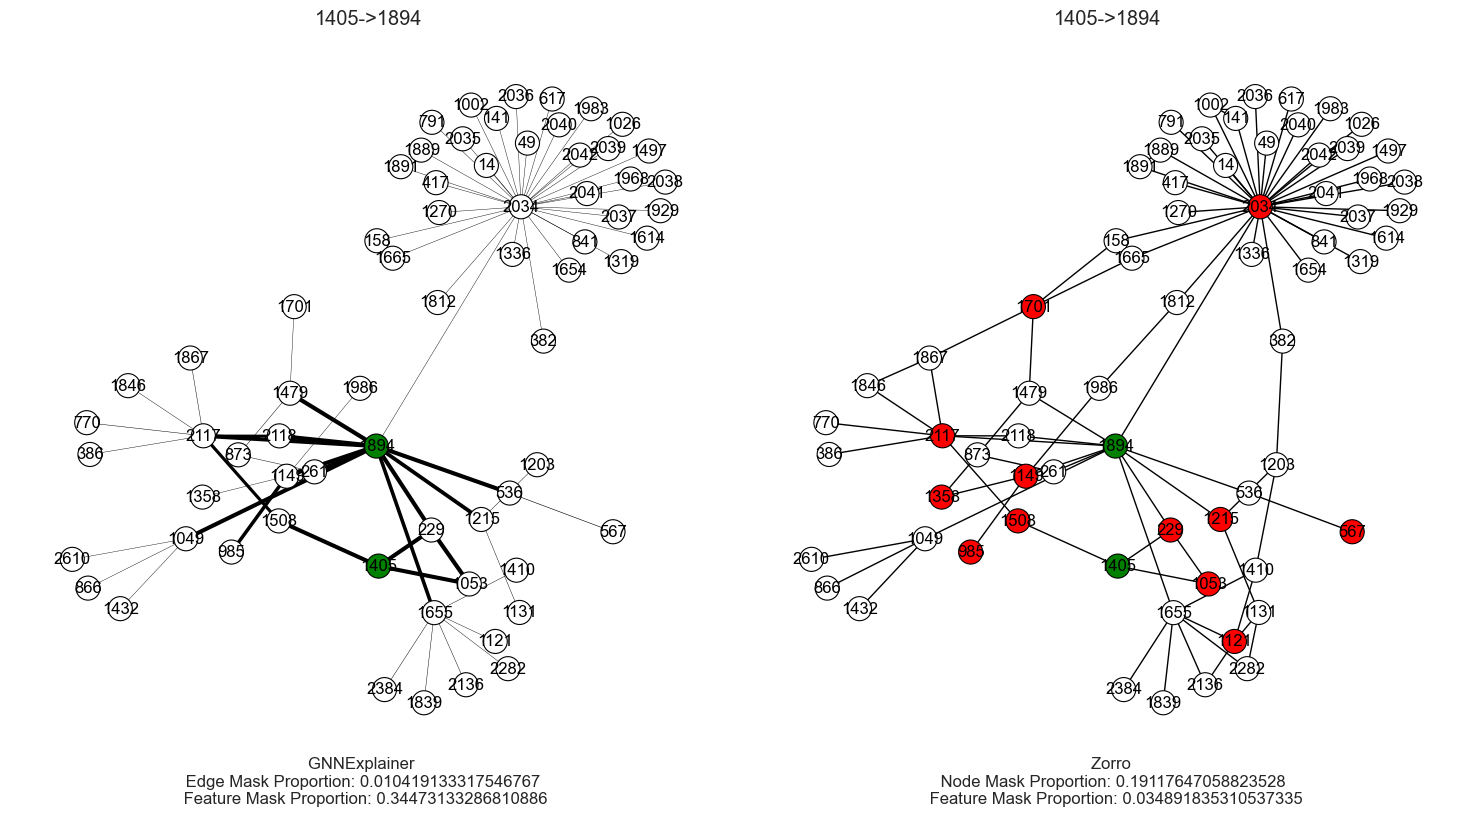

INFO:explainer:------ Start explaining edge tensor([[1952],
        [2204]])


Generating explanations for No.981 edge in the test data.
Source node 424, Target Node: 436
target:  1.0
pred:  0.19224178791046143
Generating explanations for No.833 edge in the test data.
Source node 1952, Target Node: 2204
target:  1.0
pred:  0.9961013793945312
num_hops:  2



  0%|                                                                          | 0/24361 [00:00<?, ?it/s]
Explain edge tensor([[1952],
        [2204]]):   0%|                           | 0/24361 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[1952],
        [2204]])


initial_distortion:  0.57
num_hops:  2



INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[1952],
        [2204]])

Explain edge tensor([[1952],
        [2204]]):   0%|                 | 1/24361 [00:00<2:59:56,  2.26it/s]

node_masks:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]])
best_node:  8
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  1209
impove_in_distortion_by_feature:  0.10000000000000009
count:  1
0.57
[nan, 1209, 0.57]
num_to_add_once:  2


Argmax [8, 2], 0.020000000000000018:   0%|                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.020000000000000018


Argmax [8, 2], 0.020000000000000018:  40%|████████████▊                   | 4/10 [00:00<00:00, 18.73it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.020000000000000018


Argmax [6, 1], 0.030000000000000027:  50%|████████████████                | 5/10 [00:00<00:00, 18.50it/s]

distortion_improve:  0.030000000000000027
best_node:  [6, 1]
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  None
impove_in_distortion_by_feature:  -100




Explain edge tensor([[1952],
        [2204]]):   0%|                 | 2/24361 [00:00<2:43:43,  2.48it/s]

count:  2
0.6
[[6, 1], nan, 0.6]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [8, 2], 0.010000000000000009:   0%|                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.010000000000000009


Argmax [8, 2], 0.010000000000000009:  20%|██████▍                         | 2/10 [00:00<00:00, 18.78it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [8, 2], 0.010000000000000009:  40%|████████████▊                   | 4/10 [00:00<00:00, 18.73it/s]

distortion_improve:  0.010000000000000009


Argmax [8, 2], 0.010000000000000009:  50%|████████████████                | 5/10 [00:00<00:00, 18.79it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [218, 565, 877, 13, 121, 179, 1199, 38, 39, 61], 0.07000000000000006:   7%| | 2/30 [00:00<00:01, 1

distortion_improve:  0.07000000000000006
distortion_improve:  -0.010000000000000009


Argmax [218, 565, 877, 13, 121, 179, 1199, 38, 39, 61], 0.07000000000000006:  10%| | 3/30 [00:00<00:01, 1

distortion_improve:  0.040000000000000036
best_node:  [8, 2]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [218, 565, 877, 13, 121, 179, 1199, 38, 39, 61]
impove_in_distortion_by_feature:  0.07000000000000006




Explain edge tensor([[1952],
        [2204]]):   0%|                 | 3/24361 [00:01<3:09:48,  2.14it/s]

count:  3
0.67
[nan, [218, 565, 877, 13, 121, 179, 1199, 38, 39, 61], 0.67]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [8, 2], 0.0:   0%|                                                         | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [8, 2], 0.0:  20%|█████████▊                                       | 2/10 [00:00<00:00, 18.23it/s]

distortion_improve:  0.0
distortion_improve:  -0.040000000000000036


Argmax [13, 4], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00, 18.61it/s]

distortion_improve:  0.010000000000000009


Argmax [16, 15], 0.029999999999999916:  50%|███████████████               | 5/10 [00:00<00:00, 18.59it/s]


distortion_improve:  0.029999999999999916
num_to_add_once:  10


Argmax [324, 398, 452, 456, 457, 471, 510, 548, 588, 647], 0.019999999999999907:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
distortion_improve:  0.019999999999999907


Argmax [666, 670, 675, 698, 700, 821, 828, 857, 860, 912], 0.039999999999999925:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.039999999999999925
best_node:  [16, 15]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  [666, 670, 675, 698, 700, 821, 828, 857, 860, 912]
impove_in_distortion_by_feature:  0.039999999999999925




Explain edge tensor([[1952],
        [2204]]):   0%|                 | 4/24361 [00:01<3:21:47,  2.01it/s]

count:  4
0.71
[nan, [666, 670, 675, 698, 700, 821, 828, 857, 860, 912], 0.71]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [8, 2], 0.050000000000000044:   0%|                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.050000000000000044


Argmax [8, 2], 0.050000000000000044:  20%|██████▍                         | 2/10 [00:00<00:00, 19.49it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  -0.039999999999999925
distortion_improve:  0.020000000000000018


Argmax [16, 15], 0.07000000000000006:  50%|███████████████▌               | 5/10 [00:00<00:00, 20.04it/s]

distortion_improve:  0.07000000000000006


num_to_add_once:  10


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.010000000000000009:   3%| | 1/30 [00:00<00:03, 

distortion_improve:  0.010000000000000009
distortion_improve:  0.0


Argmax [931, 1011, 1068, 1073, 1093, 1109, 1144, 1172, 1217, 1234], 0.06000000000000005:  10%| | 3/30 [00

distortion_improve:  0.06000000000000005
best_node:  [16, 15]
impove_in_distortion_by_node:  0.07000000000000006
best_feature:  [931, 1011, 1068, 1073, 1093, 1109, 1144, 1172, 1217, 1234]
impove_in_distortion_by_feature:  0.06000000000000005




Explain edge tensor([[1952],
        [2204]]):   0%|                 | 5/24361 [00:02<3:32:26,  1.91it/s]

count:  5
0.78
[[16, 15], nan, 0.78]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [8, 2], 0.05999999999999994:   0%|                                         | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.05999999999999994


Argmax [8, 2], 0.05999999999999994:  20%|██████▌                          | 2/10 [00:00<00:00, 19.34it/s]

distortion_improve:  0.0
distortion_improve:  -0.020000000000000018


Argmax [9, 0], 0.15000000000000002:  50%|████████████████▌                | 5/10 [00:00<00:00, 19.92it/s]


distortion_improve:  0.010000000000000009
distortion_improve:  0.15000000000000002
num_to_add_once:  10


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], -0.010000000000000009:   0%| | 0/30 [00:00<?, ?it

distortion_improve:  -0.010000000000000009


Argmax [324, 398, 452, 456, 457, 471, 510, 548, 588, 647], 0.05999999999999994:   7%| | 2/30 [00:00<00:01

distortion_improve:  0.05999999999999994


Argmax [324, 398, 452, 456, 457, 471, 510, 548, 588, 647], 0.05999999999999994:  10%| | 3/30 [00:00<00:01


distortion_improve:  0.04999999999999993
best_node:  [9, 0]
impove_in_distortion_by_node:  0.15000000000000002
best_feature:  [324, 398, 452, 456, 457, 471, 510, 548, 588, 647]
impove_in_distortion_by_feature:  0.05999999999999994



Explain edge tensor([[1952],
        [2204]]):   0%|                 | 6/24361 [00:02<3:31:37,  1.92it/s]

count:  6
0.93
[[9, 0], nan, 0.93]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [8, 2], 0.0:   0%|                                                          | 0/8 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [8, 2], 0.0:  50%|█████████████████████████                         | 4/8 [00:00<00:00, 20.61it/s]


distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.0:   0%|                | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [931, 1011, 1068, 1073, 1093, 1109, 1144, 1172, 1217, 1234], 0.009999999999999898:  10%| | 3/30 [0


distortion_improve:  0.009999999999999898
best_node:  [8, 2]
impove_in_distortion_by_node:  0.0
best_feature:  [931, 1011, 1068, 1073, 1093, 1109, 1144, 1172, 1217, 1234]
impove_in_distortion_by_feature:  0.009999999999999898



Explain edge tensor([[1952],
        [2204]]):   0%|                 | 7/24361 [00:03<3:22:25,  2.01it/s]

count:  7
0.94
[nan, [931, 1011, 1068, 1073, 1093, 1109, 1144, 1172, 1217, 1234], 0.94]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [8, 2], 0.0:   0%|                                                          | 0/8 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [8, 2], 0.0:  25%|████████████▌                                     | 2/8 [00:00<00:00, 18.16it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [8, 2], 0.0:  50%|█████████████████████████                         | 4/8 [00:00<00:00, 18.87it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [324, 398, 452, 456, 457, 471, 510, 548, 588, 647], 0.010000000000000009:   3%| | 1/30 [00:00<00:0

distortion_improve:  0.0
distortion_improve:  0.010000000000000009


Argmax [324, 398, 452, 456, 457, 471, 510, 548, 588, 647], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.0
best_node:  [8, 2]
impove_in_distortion_by_node:  0.0
best_feature:  [324, 398, 452, 456, 457, 471, 510, 548, 588, 647]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1952],
        [2204]]):   0%|                 | 8/24361 [00:03<3:16:58,  2.06it/s]

count:  8
0.95
[nan, [324, 398, 452, 456, 457, 471, 510, 548, 588, 647], 0.95]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [8, 2], 0.010000000000000009:   0%|                                         | 0/8 [00:00<?, ?it/s]

distortion_improve:  0.010000000000000009


Argmax [8, 2], 0.010000000000000009:  50%|████████████████▌                | 4/8 [00:00<00:00, 21.31it/s]


distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.0:   0%|                | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.0:   7%|▌       | 2/30 [00:00<00:01, 19.52it/s]

distortion_improve:  0.0


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.0:  10%|▊       | 3/30 [00:00<00:01, 19.43it/s]

Explain edge tensor([[1952],
        [2204]]):   0%|                 | 9/24361 [00:04<3:10:47,  2.13it/s]

distortion_improve:  0.0
best_node:  [8, 2]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [64, 81, 96, 130, 136, 207, 215, 247, 258, 291]
impove_in_distortion_by_feature:  0.0
count:  9
0.96
[[8, 2], nan, 0.96]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 5], 0.0:   0%|                                                          | 0/6 [00:00<?, ?it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [3, 5], 0.0:  50%|█████████████████████████                         | 3/6 [00:00<00:00, 20.14it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.0:   0%|                | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.0:  10%|▊       | 3/30 [00:00<00:01, 21.11it/s]

distortion_improve:  0.0
distortion_improve:  0.0
best_node:  [3, 5]
impove_in_distortion_by_node:  0.0
best_feature:  [64, 81, 96, 130, 136, 207, 215, 247, 258, 291]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1952],
        [2204]]):   0%|                | 10/24361 [00:04<3:00:22,  2.25it/s]

count:  10
0.96
[nan, [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.96]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 5], 0.0:   0%|                                                          | 0/6 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [13, 4], 0.010000000000000009:  50%|████████████████                | 3/6 [00:00<00:00, 19.87it/s]


distortion_improve:  0.0
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1242, 1274, 1292, 1304, 1319, 1320, 1333, 1348, 1360, 1392], 0.010000000000000009:   0%| | 0/30 [

distortion_improve:  0.010000000000000009
distortion_improve:  0.010000000000000009


Argmax [1242, 1274, 1292, 1304, 1319, 1320, 1333, 1348, 1360, 1392], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  0.010000000000000009
best_node:  [13, 4]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1242, 1274, 1292, 1304, 1319, 1320, 1333, 1348, 1360, 1392]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1952],
        [2204]]):   0%|                | 11/24361 [00:05<2:53:22,  2.34it/s]

count:  11
0.97
[nan, [1242, 1274, 1292, 1304, 1319, 1320, 1333, 1348, 1360, 1392], 0.97]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 5], 0.0:  33%|████████████████▋                                 | 2/6 [00:00<00:00, 19.57it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [3, 5], 0.0:  50%|█████████████████████████                         | 3/6 [00:00<00:00, 19.32it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1408, 1418, 1423, 3, 12, 25, 47, 65, 72, 82], 0.0:   0%|                  | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [1408, 1418, 1423, 3, 12, 25, 47, 65, 72, 82], 0.0:  10%|█         | 3/30 [00:00<00:01, 19.82it/s]

distortion_improve:  0.0
distortion_improve:  0.0
best_node:  [3, 5]
impove_in_distortion_by_node:  0.0
best_feature:  [1408, 1418, 1423, 3, 12, 25, 47, 65, 72, 82]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1952],
        [2204]]):   0%|                | 12/24361 [00:05<2:51:23,  2.37it/s]

count:  12
0.97
[nan, [1408, 1418, 1423, 3, 12, 25, 47, 65, 72, 82], 0.97]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 5], 0.0:   0%|                                                          | 0/6 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [3, 5], 0.0:  50%|█████████████████████████                         | 3/6 [00:00<00:00, 21.57it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [114, 123, 124, 125, 140, 150, 173, 176, 178, 185], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [114, 123, 124, 125, 140, 150, 173, 176, 178, 185], 0.0:   7%|▎    | 2/30 [00:00<00:01, 19.87it/s]

distortion_improve:  0.0


Argmax [114, 123, 124, 125, 140, 150, 173, 176, 178, 185], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.04it/s]

distortion_improve:  0.0
best_node:  [3, 5]
impove_in_distortion_by_node:  0.0
best_feature:  [114, 123, 124, 125, 140, 150, 173, 176, 178, 185]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1952],
        [2204]]):   0%|                | 13/24361 [00:05<2:47:50,  2.42it/s]

count:  13
0.97
[nan, [114, 123, 124, 125, 140, 150, 173, 176, 178, 185], 0.97]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 5], 0.0:   0%|                                                          | 0/6 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [3, 5], 0.0:  50%|█████████████████████████                         | 3/6 [00:00<00:00, 21.09it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [187, 192, 200, 201, 211, 216, 225, 226, 227, 236], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [187, 192, 200, 201, 211, 216, 225, 226, 227, 236], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.86it/s]

Explain edge tensor([[1952],
        [2204]]):   0%|                | 14/24361 [00:06<2:45:02,  2.46it/s]

distortion_improve:  0.0
best_node:  [3, 5]
impove_in_distortion_by_node:  0.0
best_feature:  [187, 192, 200, 201, 211, 216, 225, 226, 227, 236]
impove_in_distortion_by_feature:  0.0
count:  14
0.97
[nan, [187, 192, 200, 201, 211, 216, 225, 226, 227, 236], 0.97]


possible_nodes change:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 5], 0.0:   0%|                                                          | 0/6 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [3, 5], 0.0:  33%|████████████████▋                                 | 2/6 [00:00<00:00, 19.44it/s]

distortion_improve:  0.0


Argmax [3, 5], 0.0:  50%|█████████████████████████                         | 3/6 [00:00<00:00, 18.90it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [249, 263, 292, 310, 319, 326, 327, 351, 378, 385], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [393, 395, 414, 425, 436, 446, 468, 469, 474, 475], 0.010000000000000009:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.010000000000000009


Argmax [393, 395, 414, 425, 436, 446, 468, 469, 474, 475], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.0
best_node:  [3, 5]
impove_in_distortion_by_node:  0.0
best_feature:  [393, 395, 414, 425, 436, 446, 468, 469, 474, 475]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1952],
Explain edge tensor([[1952],           | 15/24361 [00:06<2:49:36,  2.39it/s]
        [2204]]):   0%|                | 15/24361 [00:06<3:02:40,  2.22it/s]
INFO:explainer:------ Finished explaining edge tensor([[1952],
        [2204]])


count:  15
0.98
[nan, [393, 395, 414, 425, 436, 446, 468, 469, 474, 475], 0.98]
[(array([[1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
        1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.57], [nan, 1209, 0.57], [[6, 1], nan, 0.6], [nan, [218, 565, 877, 13, 121, 179, 1199, 38, 39, 61], 0.67], [nan, [666, 670, 675, 698, 700, 821, 828, 857, 860, 912], 0.71], [[16, 15], nan, 0.78], [[9, 0], nan, 0.93], [nan, [931, 1011, 1068, 1073, 1093, 1109, 1144, 1172, 1217, 1234], 0.94], [nan, [324, 398, 452, 456, 457, 471, 510, 548, 588, 647], 0.95], [[8, 2], nan, 0.96], [nan, [64, 81, 96, 130, 136, 207, 215, 247, 258, 291], 0.96], [nan, [1242, 1274, 1292, 1304, 1319, 1320, 1333, 1348, 1360, 1392], 0.97], [nan, [1408, 1418, 1423, 3, 12, 25, 47, 65, 72, 82], 0.97], [nan, [114, 123, 124, 125, 140, 150, 173, 176, 178, 185], 0.97], [nan, [187, 192, 200, 201, 211, 216, 225, 226, 227, 236], 0.97], [nan, [393, 395, 414, 425, 436, 446, 468, 469

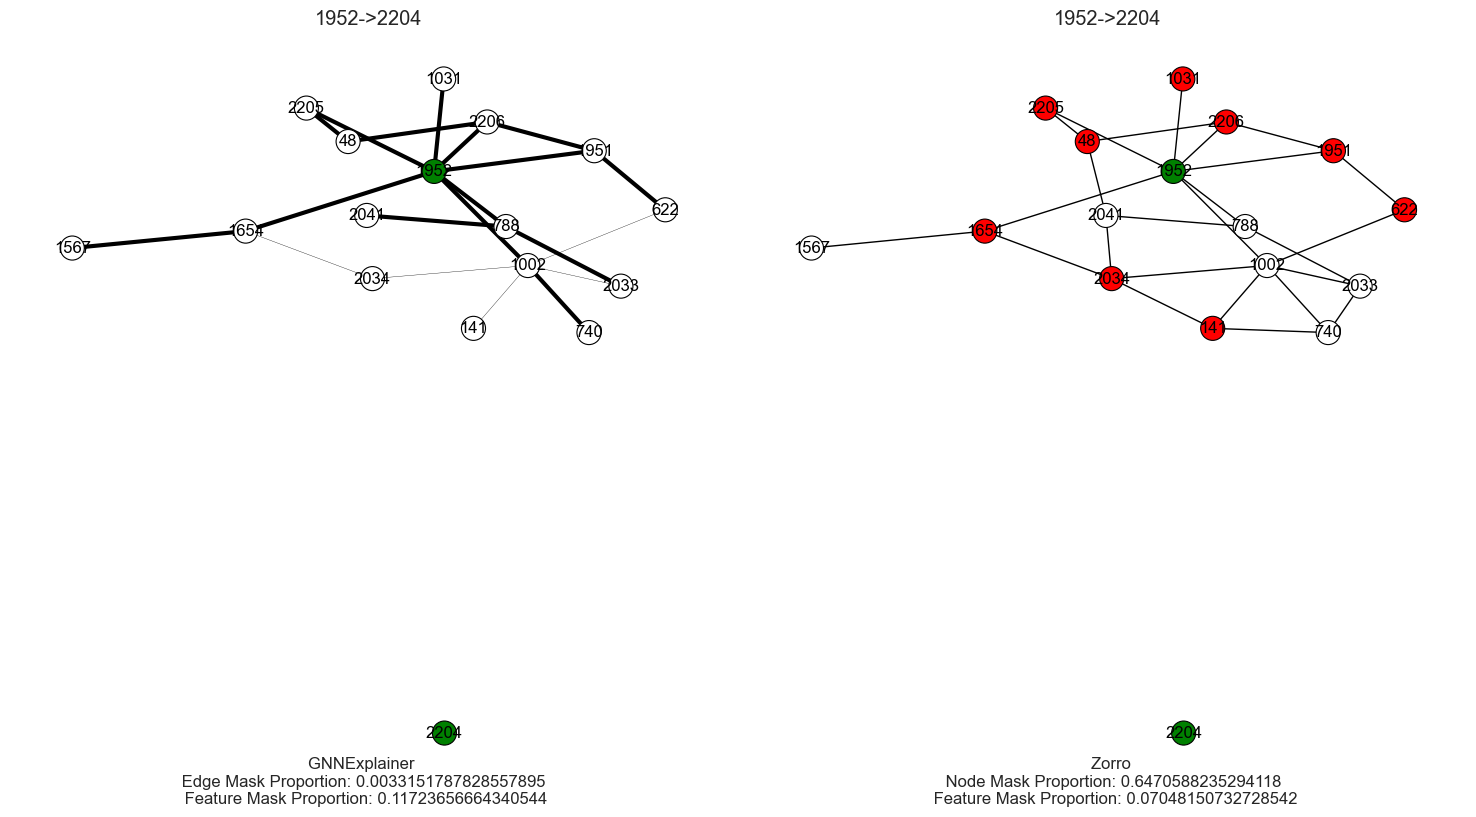

INFO:explainer:------ Start explaining edge tensor([[1191],
        [2339]])


Generating explanations for No.457 edge in the test data.
Source node 1191, Target Node: 2339
target:  1.0
pred:  0.976527214050293
num_hops:  2



  0%|                                                                          | 0/18629 [00:00<?, ?it/s]
Explain edge tensor([[1191],
        [2339]]):   0%|                           | 0/18629 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[1191],
        [2339]])


initial_distortion:  0.47
num_hops:  2



INFO:explainer:------ Current fidelity 1.0
INFO:explainer:------ Finished explaining edge tensor([[1191],
        [2339]])

Explain edge tensor([[1191],
        [2339]]):   0%|                 | 1/18629 [00:00<2:20:37,  2.21it/s]

node_masks:  tensor([[1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]])
best_node:  7
impove_in_distortion_by_node:  0.040000000000000036
best_feature:  1215
impove_in_distortion_by_feature:  0.06000000000000005
count:  1
0.53
[nan, 1215, 0.53]
num_to_add_once:  2


Argmax [7, 4], 0.0:   0%|                                                          | 0/9 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [7, 4], 0.0:  56%|███████████████████████████▊                      | 5/9 [00:00<00:00, 23.60it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  [7, 4]
impove_in_distortion_by_node:  0.0
best_feature:  None
impove_in_distortion_by_feature:  -100




Explain edge tensor([[1191],
        [2339]]):   0%|                 | 2/18629 [00:00<1:53:13,  2.74it/s]

count:  2
0.53
[[7, 4], nan, 0.53]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [12, 2], 0.0:  57%|████████████████████████████                     | 4/7 [00:00<00:00, 25.79it/s]


distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027


Argmax [616, 809, 985, 1050, 1119, 1174, 1247, 64, 108, 132], -0.010000000000000009:  10%| | 3/30 [00:00<

Explain edge tensor([[1191],
        [2339]]):   0%|                 | 3/18629 [00:01<1:56:30,  2.66it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  [12, 2]
impove_in_distortion_by_node:  0.0
best_feature:  [616, 809, 985, 1050, 1119, 1174, 1247, 64, 108, 132]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  3
0.53
[[12, 2], nan, 0.53]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 9], 0.0:   0%|                                                          | 0/5 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [3, 9], 0.0:  60%|██████████████████████████████                    | 3/5 [00:00<00:00, 20.58it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027


Argmax [616, 809, 985, 1050, 1119, 1174, 1247, 64, 108, 132], 0.010000000000000009:   7%| | 2/30 [00:00<0

distortion_improve:  0.010000000000000009


Argmax [616, 809, 985, 1050, 1119, 1174, 1247, 64, 108, 132], 0.010000000000000009:  10%| | 3/30 [00:00<0


distortion_improve:  -0.030000000000000027
best_node:  [3, 9]
impove_in_distortion_by_node:  0.0
best_feature:  [616, 809, 985, 1050, 1119, 1174, 1247, 64, 108, 132]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[1191],
        [2339]]):   0%|                 | 4/18629 [00:01<2:00:35,  2.57it/s]

count:  4
0.54
[nan, [616, 809, 985, 1050, 1119, 1174, 1247, 64, 108, 132], 0.54]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 9], 0.0:   0%|                                                          | 0/5 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [11], 0.010000000000000009:  60%|█████████████████████              | 3/5 [00:00<00:00, 20.62it/s]


distortion_improve:  -0.030000000000000027
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.040000000000000036


Argmax [440, 450, 513, 540, 564, 621, 666, 723, 735, 782], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  [11]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [440, 450, 513, 540, 564, 621, 666, 723, 735, 782]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                 | 5/18629 [00:01<2:01:56,  2.55it/s]

count:  5
0.55
[nan, [440, 450, 513, 540, 564, 621, 666, 723, 735, 782], 0.55]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 9], 0.019999999999999907:   0%|                                         | 0/5 [00:00<?, ?it/s]

distortion_improve:  0.019999999999999907
distortion_improve:  -0.040000000000000036


Argmax [3, 9], 0.019999999999999907:  60%|███████████████████▊             | 3/5 [00:00<00:00, 19.07it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.11000000000000004:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.11000000000000004


Argmax [831, 872, 892, 894, 959, 978, 1011, 1054, 1073, 1076], 0.039999999999999925:  10%| | 3/30 [00:00<

distortion_improve:  0.029999999999999916
distortion_improve:  0.039999999999999925
best_node:  [3, 9]
impove_in_distortion_by_node:  0.019999999999999907
best_feature:  [831, 872, 892, 894, 959, 978, 1011, 1054, 1073, 1076]
impove_in_distortion_by_feature:  0.039999999999999925




Explain edge tensor([[1191],
        [2339]]):   0%|                 | 6/18629 [00:02<2:07:28,  2.43it/s]

count:  6
0.59
[nan, [831, 872, 892, 894, 959, 978, 1011, 1054, 1073, 1076], 0.59]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [3, 9], 0.040000000000000036:  60%|███████████████████▊             | 3/5 [00:00<00:00, 21.43it/s]


distortion_improve:  0.040000000000000036
distortion_improve:  -0.010000000000000009
distortion_improve:  0.020000000000000018
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.08999999999999997:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.08999999999999997


Argmax [136, 146, 179, 205, 210, 292, 312, 383, 408, 421], 0.020000000000000018:   3%| | 1/30 [00:00<00:0

distortion_improve:  0.020000000000000018


Argmax [136, 146, 179, 205, 210, 292, 312, 383, 408, 421], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[1191],
        [2339]]):   0%|                 | 7/18629 [00:02<2:05:04,  2.48it/s]

distortion_improve:  -0.029999999999999916
best_node:  [3, 9]
impove_in_distortion_by_node:  0.040000000000000036
best_feature:  [136, 146, 179, 205, 210, 292, 312, 383, 408, 421]
impove_in_distortion_by_feature:  0.020000000000000018
count:  7
0.63
[[3, 9], nan, 0.63]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.030000000000000027:   0%|                                        | 0/3 [00:00<?, ?it/s]

distortion_improve:  -0.030000000000000027


Argmax [11], 0.0:  67%|██████████████████████████████████▋                 | 2/3 [00:00<00:00, 20.86it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1166, 1170, 1177, 1254, 1305, 1355, 12, 14, 16, 38], 0.010000000000000009:  10%| | 3/30 [00:00<00

distortion_improve:  -0.13
distortion_improve:  -0.040000000000000036
distortion_improve:  0.010000000000000009
best_node:  [11]
impove_in_distortion_by_node:  0.0
best_feature:  [1166, 1170, 1177, 1254, 1305, 1355, 12, 14, 16, 38]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                 | 8/18629 [00:03<1:58:13,  2.62it/s]

count:  8
0.64
[nan, [1166, 1170, 1177, 1254, 1305, 1355, 12, 14, 16, 38], 0.64]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [11], 0.030000000000000027:  67%|███████████████████████▎           | 2/3 [00:00<00:00, 19.76it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  0.030000000000000027
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.12:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [136, 146, 179, 205, 210, 292, 312, 383, 408, 421], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [136, 146, 179, 205, 210, 292, 312, 383, 408, 421], -0.020000000000000018:  10%| | 3/30 [00:00<00:


distortion_improve:  -0.020000000000000018
best_node:  [11]
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  [136, 146, 179, 205, 210, 292, 312, 383, 408, 421]
impove_in_distortion_by_feature:  -0.020000000000000018



Explain edge tensor([[1191],
        [2339]]):   0%|                 | 9/18629 [00:03<1:56:41,  2.66it/s]

count:  9
0.67
[[11], nan, 0.67]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.050000000000000044:   0%|                                        | 0/2 [00:00<?, ?it/s]

distortion_improve:  -0.050000000000000044


Argmax [1, 5], -0.050000000000000044:  50%|████████████████                | 1/2 [00:00<00:00, 20.99it/s]


num_to_add_once:  10


Argmax [136, 146, 179, 205, 210, 292, 312, 383, 408, 421], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.15000000000000002
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.050000000000000044
best_feature:  [136, 146, 179, 205, 210, 292, 312, 383, 408, 421]
impove_in_distortion_by_feature:  -0.030000000000000027
Removing features:  [136, 146, 179, 205, 210, 292, 312, 383, 408, 421]




Explain edge tensor([[1191],
        [2339]]):   0%|                | 10/18629 [00:03<1:44:05,  2.98it/s]

count:  10
0.67
None


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.050000000000000044:  50%|████████████████                | 1/2 [00:00<00:00, 18.58it/s]


distortion_improve:  -0.050000000000000044
num_to_add_once:  10


Argmax [53, 56, 65, 85, 86, 88, 97, 103, 111, 112], -0.030000000000000027:   7%| | 2/30 [00:00<00:01, 18.

distortion_improve:  -0.15000000000000002
distortion_improve:  -0.030000000000000027


Argmax [118, 124, 127, 140, 145, 170, 173, 194, 195, 212], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.77it/s]

distortion_improve:  0.0
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.050000000000000044
best_feature:  [118, 124, 127, 140, 145, 170, 173, 194, 195, 212]
impove_in_distortion_by_feature:  0.0


count: 


Explain edge tensor([[1191],
        [2339]]):   0%|                | 11/18629 [00:04<1:41:57,  3.04it/s]

 11
0.67
[nan, [118, 124, 127, 140, 145, 170, 173, 194, 195, 212], 0.67]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.06000000000000005:  50%|████████████████▌                | 1/2 [00:00<00:00, 21.60it/s]


distortion_improve:  -0.06000000000000005
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.16000000000000003:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.16000000000000003


Argmax [53, 56, 65, 85, 86, 88, 97, 103, 111, 112], -0.030000000000000027:   7%| | 2/30 [00:00<00:01, 16.

distortion_improve:  -0.030000000000000027


Argmax [228, 235, 248, 252, 261, 265, 284, 288, 291, 295], 0.029999999999999916:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.029999999999999916
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.06000000000000005
best_feature:  [228, 235, 248, 252, 261, 265, 284, 288, 291, 295]
impove_in_distortion_by_feature:  0.029999999999999916




Explain edge tensor([[1191],
        [2339]]):   0%|                | 12/18629 [00:04<1:40:50,  3.08it/s]

count:  12
0.7
[nan, [228, 235, 248, 252, 261, 265, 284, 288, 291, 295], 0.7]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.04999999999999993:  50%|████████████████▌                | 1/2 [00:00<00:00, 20.21it/s]

distortion_improve:  -0.04999999999999993


num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.13:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.13


Argmax [53, 56, 65, 85, 86, 88, 97, 103, 111, 112], -0.019999999999999907:  10%| | 3/30 [00:00<00:01, 20.

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.029999999999999916
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.04999999999999993
best_feature:  [53, 56, 65, 85, 86, 88, 97, 103, 111, 112]
impove_in_distortion_by_feature:  -0.019999999999999907
Removing features:  [53, 56, 65, 85, 86, 88, 97, 103, 111, 112]




Explain edge tensor([[1191],
        [2339]]):   0%|                | 13/18629 [00:04<1:33:52,  3.31it/s]

count:  13
0.7
None


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.04999999999999993:   0%|                                         | 0/2 [00:00<?, ?it/s]

distortion_improve:  -0.04999999999999993


Argmax [1, 5], -0.04999999999999993:  50%|████████████████▌                | 1/2 [00:00<00:00, 21.11it/s]


num_to_add_once:  10


Argmax [379, 380, 403, 409, 415, 416, 420, 448, 452, 460], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.13
distortion_improve:  -0.029999999999999916
distortion_improve:  -0.010000000000000009
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.04999999999999993
best_feature:  [379, 380, 403, 409, 415, 416, 420, 448, 452, 460]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [379, 380, 403, 409, 415, 416, 420, 448, 452, 460]




Explain edge tensor([[1191],
        [2339]]):   0%|                | 14/18629 [00:04<1:28:34,  3.50it/s]

count:  14
0.7
None


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.04999999999999993:  50%|████████████████▌                | 1/2 [00:00<00:00, 14.34it/s]


distortion_improve:  -0.04999999999999993
num_to_add_once:  10


Argmax [299, 301, 311, 326, 330, 336, 338, 349, 374, 375], -0.029999999999999916:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.13
distortion_improve:  -0.029999999999999916


Argmax [465, 478, 498, 514, 531, 569, 581, 615, 617, 623], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 15/18629 [00:05<1:27:10,  3.56it/s]

distortion_improve:  -0.010000000000000009
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.04999999999999993
best_feature:  [465, 478, 498, 514, 531, 569, 581, 615, 617, 623]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [465, 478, 498, 514, 531, 569, 581, 615, 617, 623]
count:  15
0.7
None


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.04999999999999993:  50%|████████████████▌                | 1/2 [00:00<00:00, 21.50it/s]


distortion_improve:  -0.04999999999999993
num_to_add_once:  10


Argmax [299, 301, 311, 326, 330, 336, 338, 349, 374, 375], -0.029999999999999916:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.13
distortion_improve:  -0.029999999999999916


Argmax [299, 301, 311, 326, 330, 336, 338, 349, 374, 375], -0.029999999999999916:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 16/18629 [00:05<1:23:50,  3.70it/s]

distortion_improve:  -0.039999999999999925
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.04999999999999993
best_feature:  [299, 301, 311, 326, 330, 336, 338, 349, 374, 375]
impove_in_distortion_by_feature:  -0.029999999999999916
Removing features:  [299, 301, 311, 326, 330, 336, 338, 349, 374, 375]
count:  16
0.7
None


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.04999999999999993:  50%|████████████████▌                | 1/2 [00:00<00:00, 21.27it/s]


distortion_improve:  -0.04999999999999993
num_to_add_once:  10


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.039999999999999925:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.13
distortion_improve:  -0.039999999999999925


Argmax [710, 712, 729, 730, 748, 756, 775, 779, 803, 807], 0.010000000000000009:  10%| | 3/30 [00:00<00:0


distortion_improve:  0.010000000000000009
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.04999999999999993
best_feature:  [710, 712, 729, 730, 748, 756, 775, 779, 803, 807]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[1191],
        [2339]]):   0%|                | 17/18629 [00:05<1:24:45,  3.66it/s]

count:  17
0.71
[nan, [710, 712, 729, 730, 748, 756, 775, 779, 803, 807], 0.71]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.020000000000000018:  50%|████████████████                | 1/2 [00:00<00:00, 20.17it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.12:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.04999999999999993


Argmax [808, 821, 823, 865, 875, 882, 893, 900, 902, 906], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.020000000000000018
best_feature:  [808, 821, 823, 865, 875, 882, 893, 900, 902, 906]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 18/18629 [00:05<1:27:17,  3.55it/s]

count:  18
0.72
[nan, [808, 821, 823, 865, 875, 882, 893, 900, 902, 906], 0.72]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.010000000000000009:  50%|████████████████                | 1/2 [00:00<00:00, 19.60it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.13
distortion_improve:  -0.04999999999999993


Argmax [911, 923, 925, 939, 955, 967, 973, 1001, 1017, 1033], 0.0:  10%|▏ | 3/30 [00:00<00:01, 19.61it/s]

distortion_improve:  0.0
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [911, 923, 925, 939, 955, 967, 973, 1001, 1017, 1033]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 19/18629 [00:06<1:29:24,  3.47it/s]

count:  19
0.72
[nan, [911, 923, 925, 939, 955, 967, 973, 1001, 1017, 1033], 0.72]


possible_nodes change:  tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [1, 5], -0.010000000000000009:  50%|████████████████                | 1/2 [00:00<00:00, 20.06it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.15000000000000002:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.15000000000000002


Argmax [1035, 1036, 1066, 1072, 1075, 1081, 1096, 1114, 1120, 1121], -0.030000000000000027:  10%| | 3/30 

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.030000000000000027
best_node:  [1, 5]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1035, 1036, 1066, 1072, 1075, 1081, 1096, 1114, 1120, 1121]
impove_in_distortion_by_feature:  -0.030000000000000027
tensor([[0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])
[1, 5]
Removing nodes:  [1, 5]




Explain edge tensor([[1191],
        [2339]]):   0%|                | 20/18629 [00:06<1:25:30,  3.63it/s]

count:  20
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.15000000000000002:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.15000000000000002


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.05999999999999994:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.05999999999999994


Argmax [1035, 1036, 1066, 1072, 1075, 1081, 1096, 1114, 1120, 1121], -0.030000000000000027:  10%| | 3/30 

Explain edge tensor([[1191],
        [2339]]):   0%|                | 21/18629 [00:06<1:17:38,  3.99it/s]

distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1035, 1036, 1066, 1072, 1075, 1081, 1096, 1114, 1120, 1121]
impove_in_distortion_by_feature:  -0.030000000000000027
count:  21
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.15000000000000002:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.15000000000000002


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.05999999999999994:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.05999999999999994


Argmax [1123, 1131, 1134, 1138, 1149, 1151, 1152, 1156, 1165, 1175], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1123, 1131, 1134, 1138, 1149, 1151, 1152, 1156, 1165, 1175]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 22/18629 [00:06<1:16:11,  4.07it/s]

count:  22
0.73
[nan, [1123, 1131, 1134, 1138, 1149, 1151, 1152, 1156, 1165, 1175], 0.73]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.15000000000000002:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.15000000000000002


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [1181, 1187, 1194, 1204, 1206, 1207, 1208, 1217, 1223, 1230], 0.0:  10%| | 3/30 [00:00<00:01, 20.8

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1181, 1187, 1194, 1204, 1206, 1207, 1208, 1217, 1223, 1230]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 23/18629 [00:07<1:15:48,  4.09it/s]

count:  23
0.73
[nan, [1181, 1187, 1194, 1204, 1206, 1207, 1208, 1217, 1223, 1230], 0.73]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18999999999999995:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18999999999999995


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [1231, 1234, 1235, 1236, 1248, 1252, 1255, 1257, 1259, 1281], 0.030000000000000027:  10%| | 3/30 [

distortion_improve:  0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1231, 1234, 1235, 1236, 1248, 1252, 1255, 1257, 1259, 1281]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[1191],
        [2339]]):   0%|                | 24/18629 [00:07<1:15:14,  4.12it/s]

count:  24
0.76
[nan, [1231, 1234, 1235, 1236, 1248, 1252, 1255, 1257, 1259, 1281], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [625, 627, 628, 629, 638, 646, 672, 678, 693, 702], -0.040000000000000036:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 25/18629 [00:07<1:09:57,  4.43it/s]

distortion_improve:  -0.06000000000000005
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [625, 627, 628, 629, 638, 646, 672, 678, 693, 702]
impove_in_distortion_by_feature:  -0.040000000000000036
count:  25
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], -0.06000000000000005:   3%| | 1/30 [

distortion_improve:  -0.06000000000000005


Argmax [1423, 1427, 1, 3, 5, 6, 7, 8, 10, 11], -0.040000000000000036:  10%| | 3/30 [00:00<00:01, 16.63it/

Explain edge tensor([[1191],
        [2339]]):   0%|                | 26/18629 [00:07<1:10:41,  4.39it/s]

distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1423, 1427, 1, 3, 5, 6, 7, 8, 10, 11]
impove_in_distortion_by_feature:  -0.040000000000000036
count:  26
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [13, 15, 17, 18, 20, 21, 22, 23, 24, 25], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 22.73it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [13, 15, 17, 18, 20, 21, 22, 23, 24, 25]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 27/18629 [00:08<1:09:45,  4.44it/s]

count:  27
0.76
[nan, [13, 15, 17, 18, 20, 21, 22, 23, 24, 25], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 21.14it

distortion_improve:  -0.06000000000000005
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 28/18629 [00:08<1:09:58,  4.43it/s]

count:  28
0.77
[nan, [26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 0.77]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [36, 37, 39, 40, 41, 42, 43, 44, 45, 47], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 20.96i

Explain edge tensor([[1191],
        [2339]]):   0%|                | 29/18629 [00:08<1:06:53,  4.63it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [36, 37, 39, 40, 41, 42, 43, 44, 45, 47]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  29
0.77
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], -0.06000000000000005:   3%| | 1/30 [

distortion_improve:  -0.06000000000000005


Argmax [48, 49, 50, 51, 54, 55, 57, 58, 60, 61], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 20.40i

Explain edge tensor([[1191],
        [2339]]):   0%|                | 30/18629 [00:08<1:05:14,  4.75it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [48, 49, 50, 51, 54, 55, 57, 58, 60, 61]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  30
0.77
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], -0.06000000000000005:   3%| | 1/30 [

distortion_improve:  -0.06000000000000005


Argmax [62, 63, 66, 68, 69, 70, 71, 72, 74, 75], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 20.80it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [62, 63, 66, 68, 69, 70, 71, 72, 74, 75]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 31/18629 [00:08<1:07:53,  4.57it/s]

count:  31
0.77
[nan, [62, 63, 66, 68, 69, 70, 71, 72, 74, 75], 0.77]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], -0.06000000000000005:   3%| | 1/30 [

distortion_improve:  -0.06000000000000005


Argmax [76, 77, 79, 80, 81, 82, 83, 84, 87, 90], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 21.05i

Explain edge tensor([[1191],
        [2339]]):   0%|                | 32/18629 [00:09<1:05:17,  4.75it/s]

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [76, 77, 79, 80, 81, 82, 83, 84, 87, 90]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  32
0.77
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], -0.06000000000000005:   7%| | 2/30 [

distortion_improve:  -0.19000000000000006
distortion_improve:  -0.06000000000000005


Argmax [91, 92, 93, 94, 95, 96, 100, 101, 102, 104], -0.020000000000000018:   7%| | 2/30 [00:00<00:01, 19

distortion_improve:  -0.020000000000000018


Argmax [91, 92, 93, 94, 95, 96, 100, 101, 102, 104], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 19

Explain edge tensor([[1191],
        [2339]]):   0%|                | 33/18629 [00:09<1:04:24,  4.81it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [91, 92, 93, 94, 95, 96, 100, 101, 102, 104]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  33
0.77
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [105, 106, 107, 110, 113, 114, 115, 116, 117, 119], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.88it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [105, 106, 107, 110, 113, 114, 115, 116, 117, 119]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 34/18629 [00:09<1:05:30,  4.73it/s]

count:  34
0.77
[nan, [105, 106, 107, 110, 113, 114, 115, 116, 117, 119], 0.77]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [120, 121, 122, 123, 125, 126, 129, 130, 133, 134], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 35/18629 [00:09<1:03:05,  4.91it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [120, 121, 122, 123, 125, 126, 129, 130, 133, 134]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  35
0.77
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], -0.06000000000000005:   3%| | 1/30 [

distortion_improve:  -0.06000000000000005


Argmax [135, 137, 138, 139, 141, 142, 143, 144, 147, 148], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.39it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [135, 137, 138, 139, 141, 142, 143, 144, 147, 148]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1191],
        [2339]]):   0%|                | 36/18629 [00:09<1:08:18,  4.54it/s]

count:  36
0.77
[nan, [135, 137, 138, 139, 141, 142, 143, 144, 147, 148], 0.77]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [149, 150, 152, 153, 154, 155, 156, 158, 159, 160], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 37/18629 [00:10<1:06:12,  4.68it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [149, 150, 152, 153, 154, 155, 156, 158, 159, 160]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  37
0.77
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], -0.040000000000000036:   3%| | 1/30 

distortion_improve:  -0.040000000000000036


Argmax [161, 162, 163, 164, 165, 166, 167, 168, 169, 171], 0.010000000000000009:  10%| | 3/30 [00:00<00:0


distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [161, 162, 163, 164, 165, 166, 167, 168, 169, 171]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[1191],
        [2339]]):   0%|                | 38/18629 [00:10<1:08:07,  4.55it/s]

count:  38
0.78
[nan, [161, 162, 163, 164, 165, 166, 167, 168, 169, 171], 0.78]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], 0.010000000000000009:   3%| | 1/30 [

distortion_improve:  0.010000000000000009


Argmax [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 39/18629 [00:10<1:09:52,  4.43it/s]

count:  39
0.79
[nan, [1290, 1308, 1328, 1337, 1340, 1348, 1376, 1392, 1397, 1409], 0.79]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.09000000000000008:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.09000000000000008


Argmax [172, 174, 175, 176, 177, 178, 181, 184, 185, 186], 0.0:   3%|▏    | 1/30 [00:00<00:02, 10.42it/s]

distortion_improve:  0.0


Argmax [172, 174, 175, 176, 177, 178, 181, 184, 185, 186], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.01it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [172, 174, 175, 176, 177, 178, 181, 184, 185, 186]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 40/18629 [00:10<1:10:25,  4.40it/s]

count:  40
0.79
[nan, [172, 174, 175, 176, 177, 178, 181, 184, 185, 186], 0.79]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.09000000000000008:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.09000000000000008


Argmax [188, 190, 191, 193, 197, 198, 199, 200, 201, 202], 0.0:   3%|▏    | 1/30 [00:00<00:02, 10.91it/s]

distortion_improve:  0.0


Argmax [188, 190, 191, 193, 197, 198, 199, 200, 201, 202], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.70it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [188, 190, 191, 193, 197, 198, 199, 200, 201, 202]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 41/18629 [00:11<1:11:11,  4.35it/s]

count:  41
0.79
[nan, [188, 190, 191, 193, 197, 198, 199, 200, 201, 202], 0.79]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.09000000000000008:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.09000000000000008


Argmax [203, 204, 206, 207, 208, 209, 213, 214, 215, 216], 0.0:   3%|▏    | 1/30 [00:00<00:02, 10.25it/s]

distortion_improve:  0.0


Argmax [203, 204, 206, 207, 208, 209, 213, 214, 215, 216], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.69it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [203, 204, 206, 207, 208, 209, 213, 214, 215, 216]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 42/18629 [00:11<1:12:42,  4.26it/s]

count:  42
0.79
[nan, [203, 204, 206, 207, 208, 209, 213, 214, 215, 216], 0.79]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.07000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.07000000000000006


Argmax [217, 218, 219, 220, 222, 223, 224, 226, 227, 229], 0.0:   3%|▏    | 1/30 [00:00<00:02, 10.21it/s]

distortion_improve:  0.0


Argmax [217, 218, 219, 220, 222, 223, 224, 226, 227, 229], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.74it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [217, 218, 219, 220, 222, 223, 224, 226, 227, 229]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 43/18629 [00:11<1:13:20,  4.22it/s]

count:  43
0.79
[nan, [217, 218, 219, 220, 222, 223, 224, 226, 227, 229], 0.79]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.07000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.07000000000000006


Argmax [230, 231, 232, 233, 236, 237, 238, 239, 240, 241], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [243, 245, 246, 247, 249, 250, 251, 253, 254, 255], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.65it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [243, 245, 246, 247, 249, 250, 251, 253, 254, 255]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 44/18629 [00:11<1:13:31,  4.21it/s]

count:  44
0.79
[nan, [243, 245, 246, 247, 249, 250, 251, 253, 254, 255], 0.79]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.08000000000000007:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.08000000000000007


Argmax [230, 231, 232, 233, 236, 237, 238, 239, 240, 241], 0.0:   3%|▏    | 1/30 [00:00<00:02, 10.09it/s]

distortion_improve:  0.0


Argmax [230, 231, 232, 233, 236, 237, 238, 239, 240, 241], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.97it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [230, 231, 232, 233, 236, 237, 238, 239, 240, 241]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 45/18629 [00:12<1:14:24,  4.16it/s]

count:  45
0.79
[nan, [230, 231, 232, 233, 236, 237, 238, 239, 240, 241], 0.79]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.09000000000000008:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.09000000000000008


Argmax [256, 258, 259, 262, 263, 264, 266, 267, 268, 269], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [270, 271, 272, 273, 275, 276, 277, 278, 279, 280], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [270, 271, 272, 273, 275, 276, 277, 278, 279, 280]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 46/18629 [00:12<1:14:05,  4.18it/s]

count:  46
0.8
[nan, [270, 271, 272, 273, 275, 276, 277, 278, 279, 280], 0.8]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.1100000000000001:   0%| | 0/30 [00:00<?, ?i

distortion_improve:  -0.1100000000000001


Argmax [256, 258, 259, 262, 263, 264, 266, 267, 268, 269], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [256, 258, 259, 262, 263, 264, 266, 267, 268, 269], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 47/18629 [00:12<1:09:42,  4.44it/s]

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [256, 258, 259, 262, 263, 264, 266, 267, 268, 269]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  47
0.8
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.1100000000000001:   0%| | 0/30 [00:00<?, ?i

distortion_improve:  -0.1100000000000001


Argmax [281, 282, 283, 285, 286, 287, 289, 290, 293, 294], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [296, 297, 298, 300, 302, 303, 304, 305, 306, 307], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.35it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [296, 297, 298, 300, 302, 303, 304, 305, 306, 307]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 48/18629 [00:12<1:10:52,  4.37it/s]

count:  48
0.8
[nan, [296, 297, 298, 300, 302, 303, 304, 305, 306, 307], 0.8]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.10000000000000009:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.10000000000000009


Argmax [281, 282, 283, 285, 286, 287, 289, 290, 293, 294], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [308, 309, 310, 314, 315, 316, 317, 319, 320, 321], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.64it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [308, 309, 310, 314, 315, 316, 317, 319, 320, 321]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 49/18629 [00:12<1:11:57,  4.30it/s]

count:  49
0.8
[nan, [308, 309, 310, 314, 315, 316, 317, 319, 320, 321], 0.8]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.12:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [281, 282, 283, 285, 286, 287, 289, 290, 293, 294], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [281, 282, 283, 285, 286, 287, 289, 290, 293, 294], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 50/18629 [00:13<1:08:32,  4.52it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [281, 282, 283, 285, 286, 287, 289, 290, 293, 294]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  50
0.8
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.12:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [322, 323, 325, 327, 328, 329, 331, 332, 333, 335], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [322, 323, 325, 327, 328, 329, 331, 332, 333, 335], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [322, 323, 325, 327, 328, 329, 331, 332, 333, 335]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 51/18629 [00:13<1:06:35,  4.65it/s]

count:  51
0.8
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.12:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [337, 339, 340, 341, 342, 344, 345, 346, 347, 348], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [350, 352, 353, 354, 355, 356, 357, 358, 359, 360], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.72it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [350, 352, 353, 354, 355, 356, 357, 358, 359, 360]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 52/18629 [00:13<1:09:42,  4.44it/s]

count:  52
0.8
[nan, [350, 352, 353, 354, 355, 356, 357, 358, 359, 360], 0.8]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.12:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [337, 339, 340, 341, 342, 344, 345, 346, 347, 348], 0.0:   3%|▏    | 1/30 [00:00<00:02, 10.39it/s]

distortion_improve:  0.0


Argmax [337, 339, 340, 341, 342, 344, 345, 346, 347, 348], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.62it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [337, 339, 340, 341, 342, 344, 345, 346, 347, 348]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 53/18629 [00:13<1:11:36,  4.32it/s]

count:  53
0.8
[nan, [337, 339, 340, 341, 342, 344, 345, 346, 347, 348], 0.8]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.09000000000000008:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.09000000000000008


Argmax [361, 362, 363, 364, 365, 366, 367, 368, 369, 370], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [371, 372, 373, 376, 377, 378, 381, 382, 384, 385], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [371, 372, 373, 376, 377, 378, 381, 382, 384, 385]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 54/18629 [00:14<1:09:16,  4.47it/s]

count:  54
0.8
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.09000000000000008:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.09000000000000008


Argmax [361, 362, 363, 364, 365, 366, 367, 368, 369, 370], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018


best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [361, 362, 363, 364, 365, 366, 367, 368, 369, 370]
impove_in_distortion_by_feature:  -0.020000000000000018



Explain edge tensor([[1191],
        [2339]]):   0%|                | 55/18629 [00:14<1:07:24,  4.59it/s]

count:  55
0.8
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.09000000000000008:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.09000000000000008


Argmax [386, 388, 389, 390, 391, 392, 394, 395, 396, 397], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [398, 399, 400, 401, 404, 405, 407, 410, 411, 412], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.54it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [398, 399, 400, 401, 404, 405, 407, 410, 411, 412]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1191],
        [2339]]):   0%|                | 56/18629 [00:14<1:09:01,  4.48it/s]

count:  56
0.8
[nan, [398, 399, 400, 401, 404, 405, 407, 410, 411, 412], 0.8]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.08000000000000007:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.08000000000000007


Argmax [386, 388, 389, 390, 391, 392, 394, 395, 396, 397], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [413, 414, 417, 418, 423, 424, 425, 426, 427, 428], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.60it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [413, 414, 417, 418, 423, 424, 425, 426, 427, 428]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 57/18629 [00:14<1:13:45,  4.20it/s]

count:  57
0.8
[nan, [413, 414, 417, 418, 423, 424, 425, 426, 427, 428], 0.8]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [386, 388, 389, 390, 391, 392, 394, 395, 396, 397], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.020000000000000018


Argmax [429, 430, 431, 432, 433, 434, 435, 436, 438, 439], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [429, 430, 431, 432, 433, 434, 435, 436, 438, 439]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 58/18629 [00:15<1:13:05,  4.23it/s]

count:  58
0.81
[nan, [429, 430, 431, 432, 433, 434, 435, 436, 438, 439], 0.81]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [386, 388, 389, 390, 391, 392, 394, 395, 396, 397], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.10000000000000009
distortion_improve:  -0.020000000000000018


Argmax [441, 442, 443, 444, 445, 446, 449, 451, 453, 454], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [441, 442, 443, 444, 445, 446, 449, 451, 453, 454]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[1191],
        [2339]]):   0%|                | 59/18629 [00:15<1:14:14,  4.17it/s]

count:  59
0.82
[nan, [441, 442, 443, 444, 445, 446, 449, 451, 453, 454], 0.82]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [386, 388, 389, 390, 391, 392, 394, 395, 396, 397], -0.009999999999999898:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.009999999999999898


Argmax [386, 388, 389, 390, 391, 392, 394, 395, 396, 397], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 60/18629 [00:15<1:10:22,  4.40it/s]

distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [386, 388, 389, 390, 391, 392, 394, 395, 396, 397]
impove_in_distortion_by_feature:  -0.009999999999999898
count:  60
0.82
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [468, 469, 470, 471, 472, 473, 476, 477, 479, 480], 0.0:   7%|▎    | 2/30 [00:00<00:02, 13.79it/s]

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0


Argmax [468, 469, 470, 471, 472, 473, 476, 477, 479, 480], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.57it/s]


best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [468, 469, 470, 471, 472, 473, 476, 477, 479, 480]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1191],
        [2339]]):   0%|                | 61/18629 [00:15<1:12:05,  4.29it/s]

count:  61
0.82
[nan, [468, 469, 470, 471, 472, 473, 476, 477, 479, 480], 0.82]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [455, 457, 458, 459, 461, 462, 463, 464, 466, 467], -0.009999999999999898:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.12
distortion_improve:  -0.009999999999999898


Argmax [481, 482, 483, 484, 485, 486, 487, 488, 489, 490], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.24it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [481, 482, 483, 484, 485, 486, 487, 488, 489, 490]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 62/18629 [00:15<1:12:12,  4.29it/s]

count:  62
0.82
[nan, [481, 482, 483, 484, 485, 486, 487, 488, 489, 490], 0.82]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.12:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [491, 492, 493, 494, 495, 497, 499, 500, 501, 502], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.39it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [491, 492, 493, 494, 495, 497, 499, 500, 501, 502]
impove_in_distortion_by_feature:  0.0


count:  63
0.82
[nan, [491, 492, 493, 494, 495, 497, 499, 500, 501, 502], 0.82]


Explain edge tensor([[1191],
        [2339]]):   0%|                | 63/18629 [00:16<1:14:29,  4.15it/s]



possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [503, 504, 505, 506, 508, 509, 510, 511, 512, 515], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.14it/s]

distortion_improve:  -0.13
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [503, 504, 505, 506, 508, 509, 510, 511, 512, 515]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 64/18629 [00:16<1:15:15,  4.11it/s]

count:  64
0.82
[nan, [503, 504, 505, 506, 508, 509, 510, 511, 512, 515], 0.82]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [455, 457, 458, 459, 461, 462, 463, 464, 466, 467], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 65/18629 [00:16<1:10:31,  4.39it/s]

distortion_improve:  -0.1499999999999999
distortion_improve:  -0.009999999999999898
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [455, 457, 458, 459, 461, 462, 463, 464, 466, 467]
impove_in_distortion_by_feature:  -0.009999999999999898
count:  65
0.82
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.1499999999999999:   0%| | 0/30 [00:00<?, ?i

distortion_improve:  -0.1499999999999999


Argmax [528, 529, 530, 532, 533, 534, 535, 536, 537, 538], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.48it/s]

Explain edge tensor([[1191],
        [2339]]):   0%|                | 66/18629 [00:16<1:10:26,  4.39it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [528, 529, 530, 532, 533, 534, 535, 536, 537, 538]
impove_in_distortion_by_feature:  0.0
count:  66
0.82
[nan, [528, 529, 530, 532, 533, 534, 535, 536, 537, 538], 0.82]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.1399999999999999:   0%| | 0/30 [00:00<?, ?i

distortion_improve:  -0.1399999999999999


Argmax [539, 541, 542, 543, 544, 545, 546, 547, 548, 549], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 67/18629 [00:17<1:07:32,  4.58it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [539, 541, 542, 543, 544, 545, 546, 547, 548, 549]
impove_in_distortion_by_feature:  -0.009999999999999898
count:  67
0.82
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.1399999999999999:   0%| | 0/30 [00:00<?, ?i

distortion_improve:  -0.1399999999999999


Argmax [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], -0.019999999999999907:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [550, 551, 552, 553, 555, 556, 557, 558, 559, 560], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[1191],
        [2339]]):   0%|                | 68/18629 [00:17<1:08:51,  4.49it/s]

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [550, 551, 552, 553, 555, 556, 557, 558, 559, 560]
impove_in_distortion_by_feature:  0.010000000000000009
count:  68
0.83
[nan, [550, 551, 552, 553, 555, 556, 557, 558, 559, 560], 0.83]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.1499999999999999:   0%| | 0/30 [00:00<?, ?i

distortion_improve:  -0.1499999999999999


Argmax [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], -0.019999999999999907:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [561, 562, 563, 565, 566, 567, 568, 570, 571, 572], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.89it/s]

Explain edge tensor([[1191],
        [2339]]):   0%|                | 69/18629 [00:17<1:10:17,  4.40it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [561, 562, 563, 565, 566, 567, 568, 570, 571, 572]
impove_in_distortion_by_feature:  0.0
count:  69
0.83
[nan, [561, 562, 563, 565, 566, 567, 568, 570, 571, 572], 0.83]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.1499999999999999:   0%| | 0/30 [00:00<?, ?i

distortion_improve:  -0.1499999999999999


Argmax [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [573, 574, 575, 576, 577, 578, 579, 580, 582, 583], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[1191],
        [2339]]):   0%|                | 70/18629 [00:17<1:12:16,  4.28it/s]

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [573, 574, 575, 576, 577, 578, 579, 580, 582, 583]
impove_in_distortion_by_feature:  0.010000000000000009
count:  70
0.84
[nan, [573, 574, 575, 576, 577, 578, 579, 580, 582, 583], 0.84]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.15999999999999992
distortion_improve:  -0.010000000000000009


Argmax [584, 585, 586, 587, 589, 590, 591, 592, 593, 594], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.95it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [584, 585, 586, 587, 589, 590, 591, 592, 593, 594]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1191],
        [2339]]):   0%|                | 71/18629 [00:18<1:12:45,  4.25it/s]

count:  71
0.84
[nan, [584, 585, 586, 587, 589, 590, 591, 592, 593, 594], 0.84]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], 0.0:   3%|▏    | 1/30 [00:00<00:02, 10.78it/s]

distortion_improve:  -0.15000000000000002
distortion_improve:  0.0


Argmax [595, 596, 597, 598, 599, 600, 601, 602, 604, 605], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [595, 596, 597, 598, 599, 600, 601, 602, 604, 605]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 72/18629 [00:18<1:12:54,  4.24it/s]

count:  72
0.85
[nan, [595, 596, 597, 598, 599, 600, 601, 602, 604, 605], 0.85]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], 0.010000000000000009:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.16000000000000003
distortion_improve:  0.010000000000000009


Argmax [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [516, 517, 518, 519, 520, 522, 524, 525, 526, 527]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 73/18629 [00:18<1:13:28,  4.21it/s]

count:  73
0.86
[nan, [516, 517, 518, 519, 520, 522, 524, 525, 526, 527], 0.86]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [606, 608, 609, 610, 611, 612, 613, 614, 618, 620], 0.010000000000000009:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.17000000000000004
distortion_improve:  0.010000000000000009


Argmax [606, 608, 609, 610, 611, 612, 613, 614, 618, 620], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [606, 608, 609, 610, 611, 612, 613, 614, 618, 620]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 74/18629 [00:18<1:13:08,  4.23it/s]

count:  74
0.87
[nan, [606, 608, 609, 610, 611, 612, 613, 614, 618, 620], 0.87]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [622, 626, 631, 632, 633, 634, 635, 636, 639, 640], 0.010000000000000009:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.15000000000000002
distortion_improve:  0.010000000000000009


Argmax [622, 626, 631, 632, 633, 634, 635, 636, 639, 640], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [622, 626, 631, 632, 633, 634, 635, 636, 639, 640]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 75/18629 [00:18<1:12:23,  4.27it/s]

count:  75
0.88
[nan, [622, 626, 631, 632, 633, 634, 635, 636, 639, 640], 0.88]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [641, 642, 643, 644, 645, 648, 649, 650, 651, 652], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.17000000000000004
distortion_improve:  -0.010000000000000009


Argmax [641, 642, 643, 644, 645, 648, 649, 650, 651, 652], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 76/18629 [00:19<1:09:03,  4.48it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [641, 642, 643, 644, 645, 648, 649, 650, 651, 652]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  76
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.17000000000000004:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.17000000000000004


Argmax [653, 654, 655, 656, 657, 658, 659, 660, 661, 662], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [653, 654, 655, 656, 657, 658, 659, 660, 661, 662]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 77/18629 [00:19<1:06:49,  4.63it/s]

count:  77
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.17000000000000004:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.17000000000000004


Argmax [663, 665, 667, 668, 669, 670, 671, 673, 674, 676], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [677, 679, 680, 681, 682, 683, 684, 685, 686, 687], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.62it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [677, 679, 680, 681, 682, 683, 684, 685, 686, 687]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1191],
        [2339]]):   0%|                | 78/18629 [00:19<1:09:24,  4.45it/s]

count:  78
0.88
[nan, [677, 679, 680, 681, 682, 683, 684, 685, 686, 687], 0.88]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [663, 665, 667, 668, 669, 670, 671, 673, 674, 676], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [663, 665, 667, 668, 669, 670, 671, 673, 674, 676], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 79/18629 [00:19<1:06:49,  4.63it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [663, 665, 667, 668, 669, 670, 671, 673, 674, 676]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  79
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [688, 690, 691, 692, 694, 695, 696, 697, 699, 700], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [688, 690, 691, 692, 694, 695, 696, 697, 699, 700], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [688, 690, 691, 692, 694, 695, 696, 697, 699, 700]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 80/18629 [00:20<1:05:25,  4.73it/s]

count:  80
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [701, 703, 704, 705, 706, 708, 709, 711, 713, 714], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [701, 703, 704, 705, 706, 708, 709, 711, 713, 714], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [701, 703, 704, 705, 706, 708, 709, 711, 713, 714]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 81/18629 [00:20<1:04:02,  4.83it/s]

count:  81
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [715, 716, 717, 718, 719, 720, 721, 722, 725, 726], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [715, 716, 717, 718, 719, 720, 721, 722, 725, 726], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [715, 716, 717, 718, 719, 720, 721, 722, 725, 726]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1191],
        [2339]]):   0%|                | 82/18629 [00:20<1:02:39,  4.93it/s]

count:  82
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [727, 728, 731, 732, 733, 734, 736, 737, 738, 739], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [740, 741, 742, 743, 744, 745, 746, 747, 751, 752], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.92it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [740, 741, 742, 743, 744, 745, 746, 747, 751, 752]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 83/18629 [00:20<1:06:09,  4.67it/s]

count:  83
0.88
[nan, [740, 741, 742, 743, 744, 745, 746, 747, 751, 752], 0.88]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [727, 728, 731, 732, 733, 734, 736, 737, 738, 739], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [753, 754, 755, 757, 758, 759, 760, 761, 762, 763], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 84/18629 [00:20<1:04:06,  4.82it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [753, 754, 755, 757, 758, 759, 760, 761, 762, 763]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  84
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [727, 728, 731, 732, 733, 734, 736, 737, 738, 739], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [727, 728, 731, 732, 733, 734, 736, 737, 738, 739], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [727, 728, 731, 732, 733, 734, 736, 737, 738, 739]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1191],
        [2339]]):   0%|                | 85/18629 [00:21<1:02:26,  4.95it/s]

count:  85
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [765, 766, 767, 768, 769, 770, 771, 772, 773, 774], -0.030000000000000027:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.030000000000000027


Argmax [776, 777, 778, 780, 781, 783, 784, 785, 786, 787], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [776, 777, 778, 780, 781, 783, 784, 785, 786, 787]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1191],
        [2339]]):   0%|                | 86/18629 [00:21<1:01:48,  5.00it/s]

count:  86
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [765, 766, 767, 768, 769, 770, 771, 772, 773, 774], -0.030000000000000027:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.030000000000000027


Argmax [788, 789, 790, 791, 792, 793, 794, 795, 796, 798], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.21it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [788, 789, 790, 791, 792, 793, 794, 795, 796, 798]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   0%|                | 87/18629 [00:21<1:06:51,  4.62it/s]

count:  87
0.88
[nan, [788, 789, 790, 791, 792, 793, 794, 795, 796, 798], 0.88]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [765, 766, 767, 768, 769, 770, 771, 772, 773, 774], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [765, 766, 767, 768, 769, 770, 771, 772, 773, 774]
impove_in_distortion_by_feature:  -0.030000000000000027
count:  88
0.88
None




Explain edge tensor([[1191],
        [2339]]):   0%|                | 88/18629 [00:21<1:05:25,  4.72it/s]



possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [799, 800, 801, 802, 804, 805, 806, 810, 811, 812], -0.030000000000000027:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.030000000000000027


Argmax [799, 800, 801, 802, 804, 805, 806, 810, 811, 812], -0.030000000000000027:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   0%|                | 89/18629 [00:21<1:04:11,  4.81it/s]

distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [799, 800, 801, 802, 804, 805, 806, 810, 811, 812]
impove_in_distortion_by_feature:  -0.030000000000000027
count:  89
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.18000000000000005
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018


Argmax [827, 829, 830, 832, 833, 834, 835, 836, 837, 838], -0.020000000000000018:  10%| | 3/30 [00:00<00:


best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [827, 829, 830, 832, 833, 834, 835, 836, 837, 838]
impove_in_distortion_by_feature:  -0.020000000000000018



Explain edge tensor([[1191],
        [2339]]):   0%|                | 90/18629 [00:22<1:08:01,  4.54it/s]

count:  90
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [839, 841, 842, 843, 844, 846, 847, 848, 849, 850], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [839, 841, 842, 843, 844, 846, 847, 848, 849, 850]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 91/18629 [00:22<1:06:25,  4.65it/s]

count:  91
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [851, 852, 853, 854, 855, 856, 857, 858, 861, 862], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [851, 852, 853, 854, 855, 856, 857, 858, 861, 862]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1191],
        [2339]]):   0%|                | 92/18629 [00:22<1:04:44,  4.77it/s]

count:  92
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [863, 864, 866, 867, 868, 869, 870, 871, 873, 874], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [863, 864, 866, 867, 868, 869, 870, 871, 873, 874]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   0%|                | 93/18629 [00:22<1:03:48,  4.84it/s]

count:  93
0.88
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.18000000000000005:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.18000000000000005


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0


Argmax [877, 878, 879, 880, 881, 883, 884, 885, 886, 887], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.74it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [877, 878, 879, 880, 881, 883, 884, 885, 886, 887]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   1%|                | 94/18629 [00:22<1:07:27,  4.58it/s]

count:  94
0.88
[nan, [877, 878, 879, 880, 881, 883, 884, 885, 886, 887], 0.88]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax None, -1000:   0%|                                                         | 0/30 [00:00<?, ?it/s]

distortion_improve: 

Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.16000000000000003:   0%| | 0/30 [00:00<?, ?

 -0.16000000000000003


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [888, 889, 890, 891, 895, 897, 898, 899, 901, 904], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [888, 889, 890, 891, 895, 897, 898, 899, 901, 904]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1191],
        [2339]]):   1%|                | 95/18629 [00:23<1:10:38,  4.37it/s]

count:  95
0.89
[nan, [888, 889, 890, 891, 895, 897, 898, 899, 901, 904], 0.89]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.17000000000000004:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.17000000000000004


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [814, 815, 816, 817, 818, 819, 820, 822, 824, 826], -0.040000000000000036:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [814, 815, 816, 817, 818, 819, 820, 822, 824, 826]
impove_in_distortion_by_feature:  -0.040000000000000036




Explain edge tensor([[1191],
        [2339]]):   1%|                | 96/18629 [00:23<1:11:23,  4.33it/s]

count:  96
0.89
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.17000000000000004:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.17000000000000004


Argmax [917, 918, 920, 921, 924, 927, 928, 929, 930, 932], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.56it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [917, 918, 920, 921, 924, 927, 928, 929, 930, 932]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1191],
        [2339]]):   1%|                | 97/18629 [00:23<1:11:38,  4.31it/s]

count:  97
0.89
[nan, [917, 918, 920, 921, 924, 927, 928, 929, 930, 932], 0.89]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [933, 934, 935, 936, 937, 938, 940, 941, 942, 943], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
        [2339]]):   1%|                | 98/18629 [00:23<1:07:54,  4.55it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [933, 934, 935, 936, 937, 938, 940, 941, 942, 943]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  98
0.89
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [905, 907, 908, 909, 910, 912, 913, 914, 915, 916], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [944, 946, 947, 948, 949, 950, 951, 952, 953, 954], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.11it/s]

Explain edge tensor([[1191],
        [2339]]):   1%|                | 99/18629 [00:24<1:09:18,  4.46it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [944, 946, 947, 948, 949, 950, 951, 952, 953, 954]
impove_in_distortion_by_feature:  0.0
count:  99
0.89
[nan, [944, 946, 947, 948, 949, 950, 951, 952, 953, 954], 0.89]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [98, 496, 507, 619, 675, 1144, 151, 157, 351, 588], -0.19000000000000006:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.19000000000000006


Argmax [905, 907, 908, 909, 910, 912, 913, 914, 915, 916], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [956, 957, 960, 961, 962, 963, 964, 965, 966, 968], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1191],
Explain edge tensor([[1191],          | 100/18629 [00:24<1:06:01,  4.68it/s]
        [2339]]):   1%|               | 100/18629 [00:24<1:15:03,  4.11it/s]
INFO:explainer:------ Finished explaining edge tensor([[1191],
        [2339]])


distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [956, 957, 960, 961, 962, 963, 964, 965, 966, 968]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  100
0.89
None
[(array([[1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.]],
      dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.47], [nan, 1215, 0.53], [[7, 4], nan, 0.53], [[12, 2], nan, 0.53], [nan, [616, 809, 985, 1050, 1119, 1174, 1247, 64, 108, 132], 0.54], [nan, [440, 450, 513, 540, 564, 621, 666, 723, 735, 782], 0.55], [nan, [831, 872, 892, 894, 959, 978, 1011, 1054, 1073, 1076], 0.59], [[3, 9], nan, 0.63], [nan, [1166, 1170, 1177, 1254, 1305, 1355, 12, 14, 16, 38], 0.64], [[11], nan, 0.67], None, [nan, [118, 124, 127, 140, 145, 170, 173, 194, 195, 212], 0.67], [nan, [228, 235, 248, 252, 261, 265, 284, 288, 291, 295], 0.7], None, None, None, None, [nan, [710, 712, 729, 730, 748, 756, 775, 779, 803, 807], 0.71], [nan

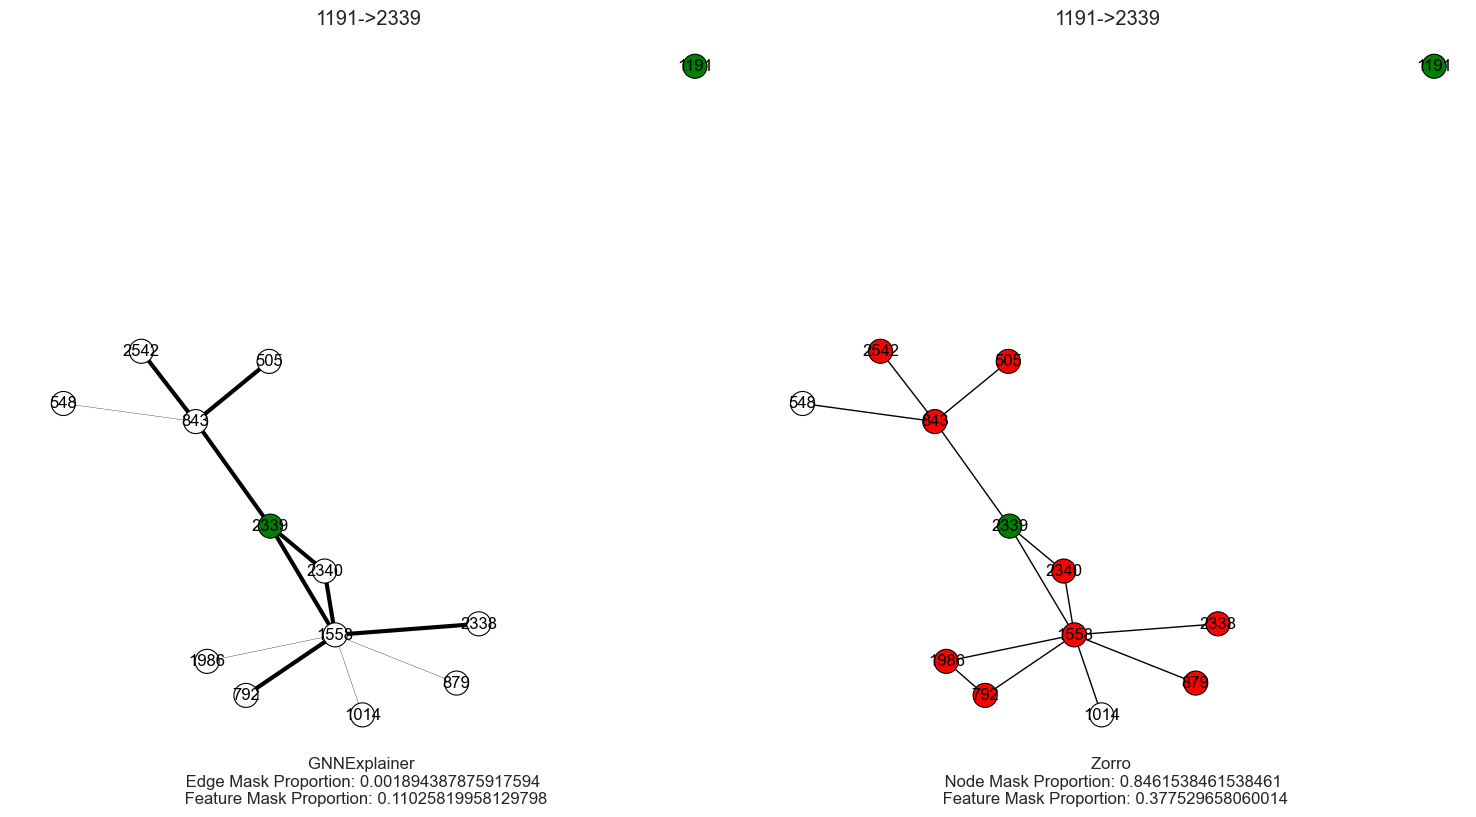

INFO:explainer:------ Start explaining edge tensor([[  89],
        [1401]])


Generating explanations for No.136 edge in the test data.
Source node 373, Target Node: 1025
target:  1.0
pred:  0.2026846706867218
Generating explanations for No.332 edge in the test data.
Source node 89, Target Node: 1401
target:  1.0
pred:  0.9822777509689331
num_hops:  2



  0%|                                                                          | 0/27227 [00:00<?, ?it/s]
Explain edge tensor([[  89],
        [1401]]):   0%|                           | 0/27227 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[  89],
        [1401]])


initial_distortion:  0.67
num_hops:  2



INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[  89],
        [1401]])

Explain edge tensor([[  89],
        [1401]]):   0%|                 | 1/27227 [00:00<5:05:35,  1.48it/s]

node_masks:  tensor([[0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0.]])
best_node:  10
impove_in_distortion_by_node:  0.04999999999999993
best_feature:  287
impove_in_distortion_by_feature:  0.06999999999999995
count:  1
0.66
[nan, 287, 0.66]
num_to_add_once:  2


Argmax [3, 7], 0.04999999999999993:  50%|████████████████▌                | 5/10 [00:00<00:00, 19.50it/s]

distortion_improve:  0.04999999999999993
distortion_improve:  0.029999999999999916
distortion_improve:  0.020000000000000018
distortion_improve:  0.029999999999999916
distortion_improve:  0.0
best_node:  [3, 7]
impove_in_distortion_by_node:  0.04999999999999993
best_feature:  None
impove_in_distortion_by_feature:  -100




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 2/27227 [00:01<3:38:41,  2.07it/s]

count:  2
0.71
[[3, 7], nan, 0.71]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [9, 14], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00, 12.93it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.0


Argmax [9, 14], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00, 16.15it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.0


Argmax [9, 14], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00, 16.12it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.020000000000000018:   0%| | 0/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [146, 177, 179, 182, 195, 201, 210, 211, 214, 220], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
distortion_improve:  0.020000000000000018
best_node:  [9, 14]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [146, 177, 179, 182, 195, 201, 210, 211, 214, 220]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 3/27227 [00:01<4:00:48,  1.88it/s]

count:  3
0.73
[nan, [146, 177, 179, 182, 195, 201, 210, 211, 214, 220], 0.73]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [9, 14], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00, 18.58it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [9, 14], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00, 18.76it/s]

distortion_improve:  0.0


Argmax [9, 14], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00, 18.71it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [6, 34, 39, 44, 57, 59, 67, 72, 84, 118], 0.0:   7%|█              | 2/30 [00:00<00:01, 19.01it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0


Argmax [234, 236, 275, 277, 294, 320, 348, 369, 374, 386], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  [9, 14]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [234, 236, 275, 277, 294, 320, 348, 369, 374, 386]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 4/27227 [00:02<4:00:28,  1.89it/s]

count:  4
0.74
[nan, [234, 236, 275, 277, 294, 320, 348, 369, 374, 386], 0.74]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [9, 14], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [9, 14], 0.0:  30%|██████████████▍                                 | 3/10 [00:00<00:00, 20.35it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0


Argmax [9, 14], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00, 19.16it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [6, 34, 39, 44, 57, 59, 67, 72, 84, 118], 0.0:   7%|█              | 2/30 [00:00<00:01, 18.59it/s]

distortion_improve:  -0.05999999999999994
distortion_improve:  0.0


Argmax [6, 34, 39, 44, 57, 59, 67, 72, 84, 118], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 18.78it/s]

distortion_improve:  -0.020000000000000018
best_node:  [9, 14]
impove_in_distortion_by_node:  0.0
best_feature:  [6, 34, 39, 44, 57, 59, 67, 72, 84, 118]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 5/27227 [00:02<4:00:50,  1.88it/s]

count:  5
0.74
[nan, [6, 34, 39, 44, 57, 59, 67, 72, 84, 118], 0.74]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [9, 14], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [9, 14], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 15.70it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [9, 14], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00, 16.62it/s]

distortion_improve:  -0.020000000000000018


Argmax [9, 14], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00, 16.44it/s]


distortion_improve:  -0.030000000000000027
num_to_add_once:  10


Argmax [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], -0.030000000000000027:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.030000000000000027


Argmax [593, 596, 613, 616, 629, 644, 670, 721, 730, 753], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.53it/s]

distortion_improve:  0.0
best_node:  [9, 14]
impove_in_distortion_by_node:  0.0
best_feature:  [593, 596, 613, 616, 629, 644, 670, 721, 730, 753]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 6/27227 [00:03<4:11:16,  1.81it/s]

count:  6
0.74
[nan, [593, 596, 613, 616, 629, 644, 670, 721, 730, 753], 0.74]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [9, 14], 0.010000000000000009:   0%|                                       | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.010000000000000009


Argmax [9, 14], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00, 16.95it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [9, 14], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00, 18.25it/s]

distortion_improve:  0.0


Argmax [9, 14], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00, 18.07it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], 0.0:   7%|▎    | 2/30 [00:00<00:01, 16.10it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  0.0


Argmax [754, 762, 767, 774, 776, 777, 783, 807, 818, 823], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.020000000000000018
best_node:  [9, 14]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [754, 762, 767, 774, 776, 777, 783, 807, 818, 823]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 7/27227 [00:03<4:16:41,  1.77it/s]

count:  7
0.76
[nan, [754, 762, 767, 774, 776, 777, 783, 807, 818, 823], 0.76]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [9, 14], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [9, 14], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 17.62it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [9, 14], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00, 18.82it/s]

distortion_improve:  0.0


Argmax [9, 14], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00, 18.25it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.010000000000000009


Argmax [830, 838, 849, 873, 877, 882, 884, 893, 906, 912], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.32it/s]

distortion_improve:  0.0
best_node:  [9, 14]
impove_in_distortion_by_node:  0.0
best_feature:  [830, 838, 849, 873, 877, 882, 884, 893, 906, 912]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 8/27227 [00:04<4:15:50,  1.77it/s]

count:  8
0.76
[nan, [830, 838, 849, 873, 877, 882, 884, 893, 906, 912], 0.76]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [9, 14], 0.040000000000000036:   0%|                                       | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.040000000000000036


Argmax [9, 14], 0.040000000000000036:  20%|██████▏                        | 2/10 [00:00<00:00, 19.22it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [9, 14], 0.040000000000000036:  50%|███████████████▌               | 5/10 [00:00<00:00, 21.63it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.040000000000000036:   0%| | 0/30 [00:00

distortion_improve:  -0.040000000000000036


Argmax [924, 926, 928, 933, 967, 987, 992, 996, 1014, 1017], 0.030000000000000027:  10%| | 3/30 [00:00<00

distortion_improve:  0.0
distortion_improve:  0.030000000000000027
best_node:  [9, 14]
impove_in_distortion_by_node:  0.040000000000000036
best_feature:  [924, 926, 928, 933, 967, 987, 992, 996, 1014, 1017]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[  89],
        [1401]]):   0%|                 | 9/27227 [00:04<4:09:53,  1.82it/s]

count:  9
0.8
[[9, 14], nan, 0.8]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [11, 12], 0.010000000000000009:  22%|██████▉                        | 2/9 [00:00<00:00, 18.23it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009


Argmax [11, 12], 0.010000000000000009:  56%|█████████████████▏             | 5/9 [00:00<00:00, 19.94it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], 0.0:   7%|▎    | 2/30 [00:00<00:01, 17.07it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0


Argmax [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.01it/s]


distortion_improve:  0.0
best_node:  [11, 12]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [387, 395, 439, 485, 517, 546, 551, 560, 565, 592]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  89],
        [1401]]):   0%|                | 10/27227 [00:05<4:06:22,  1.84it/s]

count:  10
0.81
[[11, 12], nan, 0.81]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [15, 0], -0.010000000000000009:   0%|                                       | 0/7 [00:00<?, ?it/s]

distortion_improve:  -0.010000000000000009


Argmax [8, 18], 0.0:  29%|██████████████                                   | 2/7 [00:00<00:00, 17.12it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [8, 18], 0.0:  57%|████████████████████████████                     | 4/7 [00:00<00:00, 17.96it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.020000000000000018:   0%| | 0/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], 0.019999999999999907:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.019999999999999907
distortion_improve:  -0.020000000000000018
best_node:  [8, 18]
impove_in_distortion_by_node:  0.0
best_feature:  [387, 395, 439, 485, 517, 546, 551, 560, 565, 592]
impove_in_distortion_by_feature:  0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 11/27227 [00:05<3:59:12,  1.90it/s]

count:  11
0.83
[nan, [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], 0.83]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [8, 18], -0.010000000000000009:  57%|█████████████████▋             | 4/7 [00:00<00:00, 20.33it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07999999999999996:   0%| | 0/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [924, 926, 928, 933, 967, 987, 992, 996, 1014, 1017], 0.0:  10%|▎  | 3/30 [00:00<00:01, 19.57it/s]


distortion_improve:  0.0
distortion_improve:  -0.029999999999999916
best_node:  [8, 18]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [924, 926, 928, 933, 967, 987, 992, 996, 1014, 1017]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  89],
        [1401]]):   0%|                | 12/27227 [00:06<3:50:26,  1.97it/s]

count:  12
0.83
[nan, [924, 926, 928, 933, 967, 987, 992, 996, 1014, 1017], 0.83]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [15, 0], -0.010000000000000009:  29%|████████▊                      | 2/7 [00:00<00:00, 17.53it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [16], 0.010000000000000009:  57%|████████████████████               | 4/7 [00:00<00:00, 18.14it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1166, 1182, 1193, 1218, 1223, 1234, 1243, 1255, 1256, 1259], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.019999999999999907
distortion_improve:  0.010000000000000009
best_node:  [16]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1166, 1182, 1193, 1218, 1223, 1234, 1243, 1255, 1256, 1259]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 13/27227 [00:06<3:49:12,  1.98it/s]

count:  13
0.84
[nan, [1166, 1182, 1193, 1218, 1223, 1234, 1243, 1255, 1256, 1259], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [8, 18], 0.020000000000000018:  57%|██████████████████▎             | 4/7 [00:00<00:00, 20.38it/s]

distortion_improve:  0.0
distortion_improve:  0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
num_to_add_once:  10



Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.08999999999999997:   0%| | 0/30 [00:00<

distortion_improve:  -0.08999999999999997


Argmax [1279, 1281, 1302, 1328, 1332, 1339, 1351, 1369, 1384, 1386], 0.020000000000000018:  10%| | 3/30 [


distortion_improve:  -0.010000000000000009
distortion_improve:  0.020000000000000018
best_node:  [8, 18]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [1279, 1281, 1302, 1328, 1332, 1339, 1351, 1369, 1384, 1386]
impove_in_distortion_by_feature:  0.020000000000000018



Explain edge tensor([[  89],
        [1401]]):   0%|                | 14/27227 [00:07<3:42:32,  2.04it/s]

count:  14
0.86
[nan, [1279, 1281, 1302, 1328, 1332, 1339, 1351, 1369, 1384, 1386], 0.86]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax None, -1000:   0%|                                                          | 0/7 [00:00<?, ?it/s]

distortion_improve: 

Argmax [16], 0.020000000000000018:  57%|████████████████████               | 4/7 [00:00<00:00, 20.39it/s]


 0.0
distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.020000000000000018
num_to_add_once:  10


Argmax [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145], 0.0:  10%| | 3/30 [00:00<00:01, 18.8


distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
distortion_improve:  -0.030000000000000027
best_node:  [16]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  89],
        [1401]]):   0%|                | 15/27227 [00:07<3:37:56,  2.08it/s]

count:  15
0.88
[[16], nan, 0.88]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [8, 18], 0.0:  33%|████████████████▎                                | 2/6 [00:00<00:00, 12.74it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [8, 18], 0.0:  50%|████████████████████████▌                        | 3/6 [00:00<00:00, 14.26it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  [8, 18]
impove_in_distortion_by_node:  0.0
best_feature:  [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 16/27227 [00:08<3:38:12,  2.08it/s]

count:  16
0.88
[[8, 18], nan, 0.88]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [6, 17], 0.0:  50%|████████████████████████▌                        | 2/4 [00:00<00:00, 19.05it/s]


distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.06000000000000005:   0%| | 0/30 [00:00<

distortion_improve:  -0.06000000000000005


Argmax [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145], 0.0:   7%| | 2/30 [00:00<00:01, 16.7

distortion_improve:  0.0


Argmax [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145], 0.0:  10%| | 3/30 [00:00<00:01, 17.5


distortion_improve:  -0.010000000000000009
best_node:  [6, 17]
impove_in_distortion_by_node:  0.0
best_feature:  [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  89],
        [1401]]):   0%|                | 17/27227 [00:08<3:26:53,  2.19it/s]

count:  17
0.88
[nan, [1038, 1042, 1067, 1086, 1096, 1101, 1134, 1135, 1144, 1145], 0.88]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [15, 0], 0.0:   0%|                                                         | 0/4 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [6, 17], 0.010000000000000009:  50%|████████████████                | 2/4 [00:00<00:00, 16.29it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.06999999999999995:   0%| | 0/30 [00:00<

distortion_improve:  -0.06999999999999995


Argmax [1387, 1408, 1420, 1, 2, 3, 4, 7, 8, 9], -0.020000000000000018:   7%| | 2/30 [00:00<00:01, 18.04it

distortion_improve:  -0.020000000000000018


Argmax [11, 12, 13, 14, 15, 17, 19, 20, 21, 22], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 17.90it/s]

distortion_improve:  0.0
best_node:  [6, 17]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [11, 12, 13, 14, 15, 17, 19, 20, 21, 22]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 18/27227 [00:09<3:20:16,  2.26it/s]

count:  18
0.89
[[6, 17], nan, 0.89]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2


Argmax [15, 0], 0.010000000000000009:  50%|████████████████                | 1/2 [00:00<00:00, 19.79it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1387, 1408, 1420, 1, 2, 3, 4, 7, 8, 9], 0.0:   7%|█               | 2/30 [00:00<00:01, 17.64it/s]

distortion_improve:  -0.07999999999999996
distortion_improve:  0.0


Argmax [1387, 1408, 1420, 1, 2, 3, 4, 7, 8, 9], 0.0:  10%|█▌              | 3/30 [00:00<00:01, 17.58it/s]

distortion_improve:  0.0
best_node:  [15, 0]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1387, 1408, 1420, 1, 2, 3, 4, 7, 8, 9]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 19/27227 [00:09<3:05:34,  2.44it/s]

count:  19
0.9
[[15, 0], nan, 0.9]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07000000000000006:   0%| | 0/30 [00:00<

distortion_improve:  -0.07000000000000006


Argmax [11, 12, 13, 14, 15, 17, 19, 20, 21, 22], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 18.76it

distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [11, 12, 13, 14, 15, 17, 19, 20, 21, 22]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 20/27227 [00:09<2:46:07,  2.73it/s]

count:  20
0.91
[nan, [11, 12, 13, 14, 15, 17, 19, 20, 21, 22], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [23, 24, 27, 28, 29, 30, 31, 32, 33, 35], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 19.07it

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [23, 24, 27, 28, 29, 30, 31, 32, 33, 35]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 21/27227 [00:09<2:32:09,  2.98it/s]

count:  21
0.92
[nan, [23, 24, 27, 28, 29, 30, 31, 32, 33, 35], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1387, 1408, 1420, 1, 2, 3, 4, 7, 8, 9], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 19.99it

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1387, 1408, 1420, 1, 2, 3, 4, 7, 8, 9]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 22/27227 [00:10<2:14:39,  3.37it/s]

count:  22
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [49, 51, 52, 53, 54, 55, 56, 62, 63, 66], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 18.34i

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [49, 51, 52, 53, 54, 55, 56, 62, 63, 66]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 23/27227 [00:10<2:04:11,  3.65it/s]

count:  23
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [68, 70, 73, 74, 75, 76, 77, 80, 81, 82], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 18.67i

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [68, 70, 73, 74, 75, 76, 77, 80, 81, 82]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 24/27227 [00:10<1:57:05,  3.87it/s]

count:  24
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [36, 37, 38, 40, 42, 43, 45, 46, 47, 48], -0.030000000000000027:  10%| | 3/30 [00:00<00:01, 18.25i

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [36, 37, 38, 40, 42, 43, 45, 46, 47, 48]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[  89],
        [1401]]):   0%|                | 25/27227 [00:10<1:51:53,  4.05it/s]

count:  25
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [85, 86, 87, 90, 91, 93, 94, 96, 97, 98], -0.030000000000000027:  10%| | 3/30 [00:00<00:01, 17.62i

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [85, 86, 87, 90, 91, 93, 94, 96, 97, 98]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[  89],
        [1401]]):   0%|                | 26/27227 [00:11<1:49:13,  4.15it/s]

count:  26
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [113, 114, 115, 116, 117, 119, 120, 121, 123, 124], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [113, 114, 115, 116, 117, 119, 120, 121, 123, 124]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 27/27227 [00:11<1:45:21,  4.30it/s]

count:  27
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [127, 128, 129, 136, 137, 138, 142, 143, 144, 145], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [127, 128, 129, 136, 137, 138, 142, 143, 144, 145]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 28/27227 [00:11<1:42:08,  4.44it/s]

count:  28
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [147, 148, 149, 150, 151, 152, 153, 154, 155, 156], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.97it/s]

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [147, 148, 149, 150, 151, 152, 153, 154, 155, 156]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 29/27227 [00:11<1:47:58,  4.20it/s]

count:  29
0.92
[nan, [147, 148, 149, 150, 151, 152, 153, 154, 155, 156], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [100, 101, 103, 104, 105, 107, 108, 109, 110, 111], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08000000000000007
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [100, 101, 103, 104, 105, 107, 108, 109, 110, 111]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[  89],
        [1401]]):   0%|                | 30/27227 [00:11<1:45:58,  4.28it/s]

count:  30
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [158, 159, 160, 161, 162, 163, 164, 165, 166, 168], -0.020000000000000018:  10%| | 3/30 [00:00<00:



distortion_improve:  -0.08000000000000007
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [158, 159, 160, 161, 162, 163, 164, 165, 166, 168]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  31
0.92
None


Explain edge tensor([[  89],
        [1401]]):   0%|                | 31/27227 [00:12<1:41:29,  4.47it/s]



possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [181, 183, 184, 185, 186, 188, 189, 190, 191, 192], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.51it/s]


distortion_improve:  -0.08000000000000007
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [181, 183, 184, 185, 186, 188, 189, 190, 191, 192]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  89],
        [1401]]):   0%|                | 32/27227 [00:12<1:46:01,  4.28it/s]

count:  32
0.92
[nan, [181, 183, 184, 185, 186, 188, 189, 190, 191, 192], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [193, 194, 196, 197, 198, 199, 200, 202, 204, 205], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07000000000000006
distortion_improve:  -0.030000000000000027
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [193, 194, 196, 197, 198, 199, 200, 202, 204, 205]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 33/27227 [00:12<1:48:36,  4.17it/s]

count:  33
0.93
[nan, [193, 194, 196, 197, 198, 199, 200, 202, 204, 205], 0.93]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [169, 170, 171, 172, 173, 174, 175, 176, 178, 180], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.12it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [169, 170, 171, 172, 173, 174, 175, 176, 178, 180]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 34/27227 [00:12<1:51:40,  4.06it/s]

count:  34
0.93
[nan, [169, 170, 171, 172, 173, 174, 175, 176, 178, 180], 0.93]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [206, 207, 208, 209, 212, 213, 215, 216, 217, 218], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [206, 207, 208, 209, 212, 213, 215, 216, 217, 218]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 35/27227 [00:13<1:51:57,  4.05it/s]

count:  35
0.93
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [235, 237, 239, 240, 242, 244, 245, 246, 247, 249], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.40it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [235, 237, 239, 240, 242, 244, 245, 246, 247, 249]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 36/27227 [00:13<1:58:33,  3.82it/s]

count:  36
0.93
[nan, [235, 237, 239, 240, 242, 244, 245, 246, 247, 249], 0.93]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [250, 251, 253, 254, 255, 257, 258, 260, 261, 262], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
distortion_improve:  0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [250, 251, 253, 254, 255, 257, 258, 260, 261, 262]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[  89],
        [1401]]):   0%|                | 37/27227 [00:13<1:59:34,  3.79it/s]

count:  37
0.94
[nan, [250, 251, 253, 254, 255, 257, 258, 260, 261, 262], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [219, 221, 223, 224, 226, 227, 228, 229, 232, 233], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.019999999999999907
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [219, 221, 223, 224, 226, 227, 228, 229, 232, 233]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 38/27227 [00:14<1:54:03,  3.97it/s]

count:  38
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [279, 280, 284, 285, 286, 289, 290, 291, 293, 296], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [279, 280, 284, 285, 286, 289, 290, 291, 293, 296]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[  89],
        [1401]]):   0%|                | 39/27227 [00:14<1:47:31,  4.21it/s]

count:  39
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.05999999999999994:   0%| | 0/30 [00:00<

distortion_improve:  -0.05999999999999994


Argmax [297, 299, 300, 301, 304, 305, 306, 307, 308, 309], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [297, 299, 300, 301, 304, 305, 306, 307, 308, 309]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[  89],
        [1401]]):   0%|                | 40/27227 [00:14<1:43:24,  4.38it/s]

count:  40
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.05999999999999994:   0%| | 0/30 [00:00<

distortion_improve:  -0.05999999999999994


Argmax [264, 266, 267, 268, 269, 270, 271, 272, 276, 278], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [264, 266, 267, 268, 269, 270, 271, 272, 276, 278], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [264, 266, 267, 268, 269, 270, 271, 272, 276, 278]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 41/27227 [00:14<1:49:10,  4.15it/s]

count:  41
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [311, 313, 315, 316, 317, 318, 319, 321, 322, 323], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.019999999999999907


Argmax [311, 313, 315, 316, 317, 318, 319, 321, 322, 323], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.039999999999999925
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [311, 313, 315, 316, 317, 318, 319, 321, 322, 323]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 42/27227 [00:14<1:46:34,  4.25it/s]

count:  42
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [325, 326, 327, 328, 331, 332, 334, 335, 337, 340], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [341, 342, 344, 345, 346, 347, 349, 350, 352, 353], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [341, 342, 344, 345, 346, 347, 349, 350, 352, 353]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 43/27227 [00:15<1:45:04,  4.31it/s]

count:  43
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [325, 326, 327, 328, 331, 332, 334, 335, 337, 340], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [354, 355, 356, 357, 358, 359, 360, 362, 363, 364], -0.029999999999999916:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [354, 355, 356, 357, 358, 359, 360, 362, 363, 364]
impove_in_distortion_by_feature:  -0.029999999999999916




Explain edge tensor([[  89],
        [1401]]):   0%|                | 44/27227 [00:15<1:44:00,  4.36it/s]

count:  44
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [325, 326, 327, 328, 331, 332, 334, 335, 337, 340], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [325, 326, 327, 328, 331, 332, 334, 335, 337, 340], -0.039999999999999925:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.039999999999999925
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [325, 326, 327, 328, 331, 332, 334, 335, 337, 340]
impove_in_distortion_by_feature:  -0.039999999999999925




Explain edge tensor([[  89],
        [1401]]):   0%|                | 45/27227 [00:15<1:41:41,  4.45it/s]

count:  45
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [365, 367, 368, 370, 371, 372, 373, 376, 377, 378], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [379, 381, 382, 383, 385, 388, 389, 390, 391, 392], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [379, 381, 382, 383, 385, 388, 389, 390, 391, 392]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[  89],
        [1401]]):   0%|                | 46/27227 [00:15<1:41:03,  4.48it/s]

count:  46
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [365, 367, 368, 370, 371, 372, 373, 376, 377, 378], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [393, 394, 396, 397, 398, 399, 400, 401, 402, 403], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [393, 394, 396, 397, 398, 399, 400, 401, 402, 403]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 47/27227 [00:16<1:39:18,  4.56it/s]

count:  47
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [365, 367, 368, 370, 371, 372, 373, 376, 377, 378], -0.039999999999999925:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [404, 406, 408, 409, 410, 411, 412, 415, 416, 417], -0.029999999999999916:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [404, 406, 408, 409, 410, 411, 412, 415, 416, 417]
impove_in_distortion_by_feature:  -0.029999999999999916




Explain edge tensor([[  89],
        [1401]]):   0%|                | 48/27227 [00:16<1:37:37,  4.64it/s]

count:  48
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [365, 367, 368, 370, 371, 372, 373, 376, 377, 378], -0.039999999999999925:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [418, 419, 420, 421, 422, 423, 425, 426, 427, 428], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [418, 419, 420, 421, 422, 423, 425, 426, 427, 428]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 49/27227 [00:16<1:36:39,  4.69it/s]

count:  49
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [365, 367, 368, 370, 371, 372, 373, 376, 377, 378], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925


Argmax [431, 432, 433, 435, 436, 440, 441, 442, 443, 444], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.07it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [431, 432, 433, 435, 436, 440, 441, 442, 443, 444]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 50/27227 [00:16<1:44:08,  4.35it/s]

count:  50
0.94
[nan, [431, 432, 433, 435, 436, 440, 441, 442, 443, 444], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07999999999999996:   0%| | 0/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [365, 367, 368, 370, 371, 372, 373, 376, 377, 378], -0.04999999999999993:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.05999999999999994
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [365, 367, 368, 370, 371, 372, 373, 376, 377, 378]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[  89],
        [1401]]):   0%|                | 51/27227 [00:16<1:41:55,  4.44it/s]

count:  51
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07999999999999996:   0%| | 0/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [460, 463, 466, 467, 468, 469, 470, 473, 476, 477], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [460, 463, 466, 467, 468, 469, 470, 473, 476, 477]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[  89],
        [1401]]):   0%|                | 52/27227 [00:17<1:40:27,  4.51it/s]

count:  52
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07999999999999996:   0%| | 0/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [478, 480, 481, 482, 483, 484, 487, 488, 489, 490], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [478, 480, 481, 482, 483, 484, 487, 488, 489, 490]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 53/27227 [00:17<1:41:14,  4.47it/s]

count:  53
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07999999999999996:   0%| | 0/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [491, 492, 493, 494, 496, 497, 499, 502, 503, 504], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [491, 492, 493, 494, 496, 497, 499, 502, 503, 504]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[  89],
        [1401]]):   0%|                | 54/27227 [00:17<1:39:49,  4.54it/s]

count:  54
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07999999999999996:   0%| | 0/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [506, 508, 509, 510, 511, 512, 515, 516, 518, 519], -0.029999999999999916:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [506, 508, 509, 510, 511, 512, 515, 516, 518, 519]
impove_in_distortion_by_feature:  -0.029999999999999916




Explain edge tensor([[  89],
        [1401]]):   0%|                | 55/27227 [00:17<1:39:22,  4.56it/s]

count:  55
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.07999999999999996:   0%| | 0/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [521, 522, 524, 525, 526, 527, 528, 529, 530, 531], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.16it/s]

distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [521, 522, 524, 525, 526, 527, 528, 529, 530, 531]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 56/27227 [00:18<1:45:47,  4.28it/s]

count:  56
0.94
[nan, [521, 522, 524, 525, 526, 527, 528, 529, 530, 531], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [532, 533, 535, 537, 538, 540, 541, 543, 544, 545], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.44it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [532, 533, 535, 537, 538, 540, 541, 543, 544, 545]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 57/27227 [00:18<1:52:53,  4.01it/s]

count:  57
0.94
[nan, [532, 533, 535, 537, 538, 540, 541, 543, 544, 545], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [548, 549, 550, 552, 554, 555, 556, 558, 561, 562], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.95it/s]

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [548, 549, 550, 552, 554, 555, 556, 558, 561, 562]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 58/27227 [00:18<1:54:59,  3.94it/s]

count:  58
0.94
[nan, [548, 549, 550, 552, 554, 555, 556, 558, 561, 562], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [445, 446, 449, 451, 453, 454, 455, 456, 457, 459], -0.04999999999999993:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.05999999999999994
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [445, 446, 449, 451, 453, 454, 455, 456, 457, 459]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[  89],
        [1401]]):   0%|                | 59/27227 [00:18<1:50:05,  4.11it/s]

count:  59
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [578, 579, 580, 581, 582, 583, 585, 586, 587, 588], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.05999999999999994
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [578, 579, 580, 581, 582, 583, 585, 586, 587, 588]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 60/27227 [00:19<1:45:40,  4.28it/s]

count:  60
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [589, 590, 595, 598, 599, 600, 601, 602, 603, 604], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.43it/s]

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [589, 590, 595, 598, 599, 600, 601, 602, 603, 604]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 61/27227 [00:19<1:49:57,  4.12it/s]

count:  61
0.94
[nan, [589, 590, 595, 598, 599, 600, 601, 602, 603, 604], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [563, 566, 567, 568, 569, 570, 572, 573, 574, 576], -0.04999999999999993:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.08999999999999997
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [563, 566, 567, 568, 569, 570, 572, 573, 574, 576]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[  89],
        [1401]]):   0%|                | 62/27227 [00:19<1:46:20,  4.26it/s]

count:  62
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [619, 620, 622, 626, 627, 630, 631, 633, 634, 635], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.08999999999999997
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [619, 620, 622, 626, 627, 630, 631, 633, 634, 635]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[  89],
        [1401]]):   0%|                | 63/27227 [00:19<1:43:31,  4.37it/s]

count:  63
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [636, 637, 638, 639, 640, 641, 642, 646, 647, 648], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.08999999999999997
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [636, 637, 638, 639, 640, 641, 642, 646, 647, 648]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 64/27227 [00:19<1:41:57,  4.44it/s]

count:  64
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [649, 650, 651, 652, 653, 654, 655, 657, 658, 659], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.42it/s]

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.08999999999999997
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [649, 650, 651, 652, 653, 654, 655, 657, 658, 659]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 65/27227 [00:20<1:47:05,  4.23it/s]

count:  65
0.94
[nan, [649, 650, 651, 652, 653, 654, 655, 657, 658, 659], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [660, 661, 662, 663, 665, 667, 668, 669, 671, 674], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.08999999999999997
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [660, 661, 662, 663, 665, 667, 668, 669, 671, 674]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 66/27227 [00:20<1:44:32,  4.33it/s]

count:  66
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [676, 677, 678, 679, 680, 681, 682, 683, 684, 685], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.08999999999999997
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [676, 677, 678, 679, 680, 681, 682, 683, 684, 685]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 67/27227 [00:20<1:41:42,  4.45it/s]

count:  67
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [686, 687, 688, 689, 690, 692, 694, 695, 696, 697], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.08999999999999997
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [686, 687, 688, 689, 690, 692, 694, 695, 696, 697]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 68/27227 [00:20<1:46:48,  4.24it/s]

count:  68
0.95
[nan, [686, 687, 688, 689, 690, 692, 694, 695, 696, 697], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [699, 700, 702, 704, 707, 708, 709, 710, 711, 713], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.61it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.08999999999999997
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [699, 700, 702, 704, 707, 708, 709, 710, 711, 713]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 69/27227 [00:21<1:51:05,  4.07it/s]

count:  69
0.95
[nan, [699, 700, 702, 704, 707, 708, 709, 710, 711, 713], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.08999999999999997:   7%| | 2/30 [00:00<

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.09999999999999998


Argmax [714, 716, 717, 718, 720, 725, 726, 727, 729, 731], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[  89],
        [1401]]):   0%|                | 70/27227 [00:21<1:53:04,  4.00it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [714, 716, 717, 718, 720, 725, 726, 727, 729, 731]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  70
0.95
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.08999999999999997:   7%| | 2/30 [00:00<

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.09999999999999998


Argmax [732, 733, 734, 736, 737, 740, 741, 742, 743, 744], -0.019999999999999907:  10%| | 3/30 [00:00<00:

Explain edge tensor([[  89],
        [1401]]):   0%|                | 71/27227 [00:21<1:48:45,  4.16it/s]

distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [732, 733, 734, 736, 737, 740, 741, 742, 743, 744]
impove_in_distortion_by_feature:  -0.019999999999999907
count:  71
0.95
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [745, 746, 748, 749, 750, 751, 755, 756, 757, 758], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.09999999999999998
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [745, 746, 748, 749, 750, 751, 755, 756, 757, 758]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 72/27227 [00:21<1:42:48,  4.40it/s]

count:  72
0.95
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.08999999999999997:   0%| | 0/30 [00:00<

distortion_improve:  -0.08999999999999997


Argmax [759, 760, 761, 764, 765, 766, 768, 769, 771, 772], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [759, 760, 761, 764, 765, 766, 768, 769, 771, 772]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[  89],
        [1401]]):   0%|                | 73/27227 [00:22<1:39:35,  4.54it/s]

count:  73
0.95
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.08999999999999997:   0%| | 0/30 [00:00<

distortion_improve:  -0.08999999999999997


Argmax [773, 775, 778, 779, 780, 781, 782, 785, 786, 787], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [773, 775, 778, 779, 780, 781, 782, 785, 786, 787]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 74/27227 [00:22<1:39:41,  4.54it/s]

count:  74
0.95
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.08999999999999997:   0%| | 0/30 [00:00<

distortion_improve:  -0.08999999999999997


Argmax [788, 789, 790, 791, 792, 793, 794, 795, 796, 797], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.27it/s]

distortion_improve:  -0.09999999999999998
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [788, 789, 790, 791, 792, 793, 794, 795, 796, 797]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 75/27227 [00:22<1:46:04,  4.27it/s]

count:  75
0.95
[nan, [788, 789, 790, 791, 792, 793, 794, 795, 796, 797], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [798, 799, 801, 802, 803, 804, 805, 806, 809, 810], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.48it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.07999999999999996
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [798, 799, 801, 802, 803, 804, 805, 806, 809, 810]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 76/27227 [00:22<1:51:52,  4.04it/s]

count:  76
0.95
[nan, [798, 799, 801, 802, 803, 804, 805, 806, 809, 810], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [811, 815, 816, 817, 820, 821, 822, 824, 825, 826], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.31it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.07999999999999996
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [811, 815, 816, 817, 820, 821, 822, 824, 825, 826]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 77/27227 [00:23<1:56:11,  3.89it/s]

count:  77
0.95
[nan, [811, 815, 816, 817, 820, 821, 822, 824, 825, 826], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [827, 828, 829, 831, 833, 836, 837, 839, 841, 842], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.95it/s]

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [827, 828, 829, 831, 833, 836, 837, 839, 841, 842]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 78/27227 [00:23<1:58:34,  3.82it/s]

count:  78
0.95
[nan, [827, 828, 829, 831, 833, 836, 837, 839, 841, 842], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [843, 844, 846, 847, 848, 850, 851, 852, 853, 854], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.63it/s]

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [843, 844, 846, 847, 848, 850, 851, 852, 853, 854]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 79/27227 [00:23<1:59:35,  3.78it/s]

count:  79
0.95
[nan, [843, 844, 846, 847, 848, 850, 851, 852, 853, 854], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [855, 856, 857, 858, 861, 862, 863, 866, 867, 869], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.88it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [855, 856, 857, 858, 861, 862, 863, 866, 867, 869]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 80/27227 [00:23<2:00:13,  3.76it/s]

count:  80
0.95
[nan, [855, 856, 857, 858, 861, 862, 863, 866, 867, 869], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [870, 871, 874, 875, 878, 879, 880, 881, 883, 885], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.77it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [870, 871, 874, 875, 878, 879, 880, 881, 883, 885]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 81/27227 [00:24<2:00:17,  3.76it/s]

count:  81
0.95
[nan, [870, 871, 874, 875, 878, 879, 880, 881, 883, 885], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [886, 887, 888, 889, 890, 891, 892, 896, 897, 898], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [886, 887, 888, 889, 890, 891, 892, 896, 897, 898]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 82/27227 [00:24<1:51:51,  4.04it/s]

count:  82
0.95
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [900, 901, 902, 904, 905, 907, 908, 909, 910, 913], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.20it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [900, 901, 902, 904, 905, 907, 908, 909, 910, 913]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 83/27227 [00:24<1:54:16,  3.96it/s]

count:  83
0.95
[nan, [900, 901, 902, 904, 905, 907, 908, 909, 910, 913], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [914, 917, 918, 919, 920, 925, 927, 929, 930, 934], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.14it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [914, 917, 918, 919, 920, 925, 927, 929, 930, 934]
impove_in_distortion_by_feature:  0.0


count:  84
0.95
[nan, [914, 917, 918, 919, 920, 925, 927, 929, 930, 934], 0.95]


Explain edge tensor([[  89],
        [1401]]):   0%|                | 84/27227 [00:24<1:55:22,  3.92it/s]



possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [935, 936, 937, 938, 942, 943, 944, 945, 946, 947], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.38it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [935, 936, 937, 938, 942, 943, 944, 945, 946, 947]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 85/27227 [00:25<1:55:58,  3.90it/s]

count:  85
0.95
[nan, [935, 936, 937, 938, 942, 943, 944, 945, 946, 947], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [948, 949, 951, 952, 954, 955, 956, 958, 960, 961], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.34it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [948, 949, 951, 952, 954, 955, 956, 958, 960, 961]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 86/27227 [00:25<1:55:23,  3.92it/s]

count:  86
0.95
[nan, [948, 949, 951, 952, 954, 955, 956, 958, 960, 961], 0.95]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [963, 964, 965, 966, 968, 970, 973, 974, 975, 976], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.06999999999999995
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [963, 964, 965, 966, 968, 970, 973, 974, 975, 976]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 87/27227 [00:25<1:54:09,  3.96it/s]

count:  87
0.96
[nan, [963, 964, 965, 966, 968, 970, 973, 974, 975, 976], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [977, 979, 980, 982, 983, 984, 986, 989, 990, 991], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [977, 979, 980, 982, 983, 984, 986, 989, 990, 991]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 88/27227 [00:25<1:48:55,  4.15it/s]

count:  88
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [994, 995, 997, 999, 1000, 1001, 1002, 1003, 1004, 1005], 0.0:  10%| | 3/30 [00:00<00:01, 19.84it/

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [994, 995, 997, 999, 1000, 1001, 1002, 1003, 1004, 1005]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 89/27227 [00:26<1:51:17,  4.06it/s]

count:  89
0.96
[nan, [994, 995, 997, 999, 1000, 1001, 1002, 1003, 1004, 1005], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1006, 1007, 1008, 1009, 1011, 1012, 1015, 1019, 1020, 1021], 0.0:  10%| | 3/30 [00:00<00:01, 19.4

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1006, 1007, 1008, 1009, 1011, 1012, 1015, 1019, 1020, 1021]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 90/27227 [00:26<1:53:58,  3.97it/s]

count:  90
0.96
[nan, [1006, 1007, 1008, 1009, 1011, 1012, 1015, 1019, 1020, 1021], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1022, 1023, 1024, 1025, 1028, 1029, 1030, 1031, 1032, 1033], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1022, 1023, 1024, 1025, 1028, 1029, 1030, 1031, 1032, 1033]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 91/27227 [00:26<1:48:50,  4.16it/s]

count:  91
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1034, 1035, 1037, 1039, 1040, 1044, 1045, 1048, 1049, 1050], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1034, 1035, 1037, 1039, 1040, 1044, 1045, 1048, 1049, 1050]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 92/27227 [00:26<1:45:51,  4.27it/s]

count:  92
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1051, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061], 0.0:  10%| | 3/30 [00:00<00:01, 20.5

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1051, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 93/27227 [00:27<1:48:32,  4.17it/s]

count:  93
0.96
[nan, [1051, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1062, 1063, 1064, 1065, 1066, 1068, 1069, 1070, 1071, 1072], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1062, 1063, 1064, 1065, 1066, 1068, 1069, 1070, 1071, 1072]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 94/27227 [00:27<1:44:53,  4.31it/s]

count:  94
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1073, 1074, 1076, 1077, 1078, 1080, 1081, 1083, 1084, 1085], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1073, 1074, 1076, 1077, 1078, 1080, 1081, 1083, 1084, 1085]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 95/27227 [00:27<1:42:47,  4.40it/s]

count:  95
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1098, 1099], 0.0:  10%| | 3/30 [00:00<00:01, 19.2

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.06999999999999995
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1098, 1099]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 96/27227 [00:27<1:47:44,  4.20it/s]

count:  96
0.96
[nan, [1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1098, 1099], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1100, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1100, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 97/27227 [00:27<1:45:51,  4.27it/s]

count:  97
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1111, 1112, 1113, 1115, 1116, 1120, 1121, 1122, 1124, 1125], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1111, 1112, 1113, 1115, 1116, 1120, 1121, 1122, 1124, 1125]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
        [1401]]):   0%|                | 98/27227 [00:28<1:45:03,  4.30it/s]

count:  98
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 1215, 534, 597, 698, 835, 845, 1018, 1208, 1424], -0.04999999999999993:   7%| | 2/30 [00:00<

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.04999999999999993


Argmax [1126, 1127, 1128, 1129, 1130, 1132, 1133, 1136, 1137, 1138], 0.0:  10%| | 3/30 [00:00<00:01, 14.0

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1126, 1127, 1128, 1129, 1130, 1132, 1133, 1136, 1137, 1138]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  89],
        [1401]]):   0%|                | 99/27227 [00:28<2:06:39,  3.57it/s]

count:  99
0.96
[nan, [1126, 1127, 1128, 1129, 1130, 1132, 1133, 1136, 1137, 1138], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1139, 1140, 1141, 1142, 1143, 1146, 1147, 1148, 1150, 1151], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.05999999999999994
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1139, 1140, 1141, 1142, 1143, 1146, 1147, 1148, 1150, 1151]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  89],
Explain edge tensor([[  89],          | 100/27227 [00:28<1:57:51,  3.84it/s]
        [1401]]):   0%|               | 100/27227 [00:28<2:10:17,  3.47it/s]
INFO:explainer:------ Finished explaining edge tensor([[  89],
        [1401]])


count:  100
0.96
None
[(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.67], [nan, 287, 0.66], [[3, 7], nan, 0.71], [nan, [146, 177, 179, 182, 195, 201, 210, 211, 214, 220], 0.73], [nan, [234, 236, 275, 277, 294, 320, 348, 369, 374, 386], 0.74], [nan, [6, 34, 39, 44, 57, 59, 67, 72, 84, 118], 0.74], [nan, [593, 596, 613, 616, 629, 644, 670, 721, 730, 753], 0.74], [nan, [754, 762, 767, 774, 776, 777, 783, 807, 818, 823], 0.76], [nan, [830, 838, 849, 873, 877, 882, 884, 893, 906, 912], 0.76], [[9, 14], nan, 0.8], [[11, 12], nan, 0.81], [nan, [387, 395, 439, 485, 517, 546, 551, 560, 565, 592], 0.83], [nan, [924, 926, 928, 933, 967, 987, 992, 996, 1014, 1017], 0.83], [nan, [1166, 1182, 1193, 1218, 1223, 1234, 1243, 1255, 1256, 1259], 0.84], [nan, [1279, 1281, 1302, 1328, 1332, 1339, 1351, 1369, 1384, 1386], 0.86], [[16], nan, 0.88], [[8, 18], nan, 0.88], [nan, 

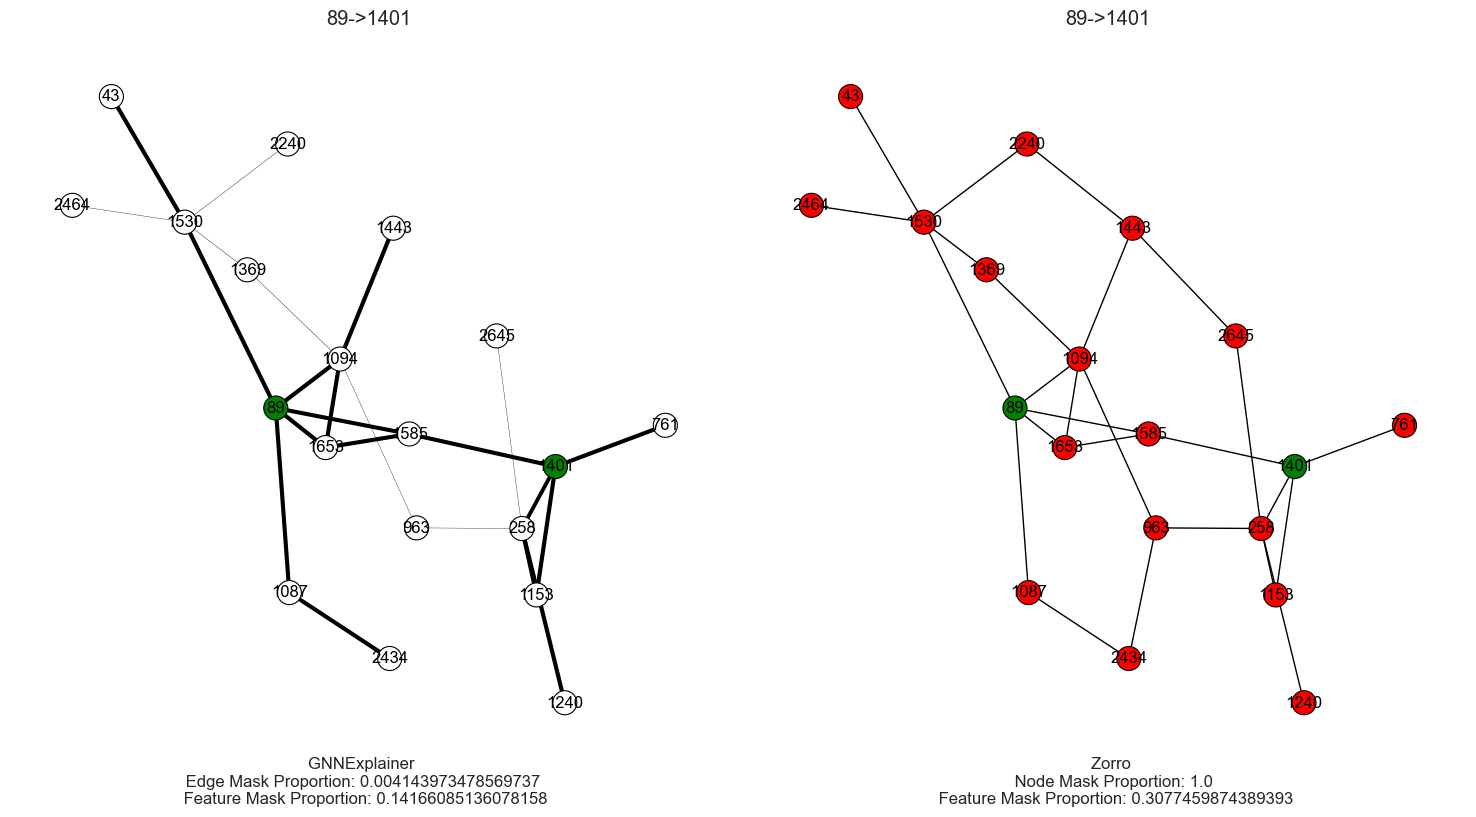

INFO:explainer:------ Start explaining edge tensor([[ 728],
        [1296]])


Generating explanations for No.429 edge in the test data.
Source node 728, Target Node: 1296
target:  1.0
pred:  0.8096391558647156
num_hops:  2



  0%|                                                                          | 0/38691 [00:00<?, ?it/s]
Explain edge tensor([[ 728],
        [1296]]):   0%|                           | 0/38691 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[ 728],
        [1296]])


initial_distortion:  0.52
num_hops:  2



INFO:explainer:------ Current fidelity 1.0
INFO:explainer:------ Finished explaining edge tensor([[ 728],
        [1296]])

Explain edge tensor([[ 728],
        [1296]]):   0%|                | 1/38691 [00:00<10:05:54,  1.06it/s]

node_masks:  tensor([[0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 1.]])
best_node:  18
impove_in_distortion_by_node:  0.07999999999999996
best_feature:  19
impove_in_distortion_by_feature:  0.05999999999999994
count:  1
0.52
[18, nan, 0.52]
num_to_add_once:  10


Argmax [19, 792, 979, 763, 1151, 1263, 1423, 607, 1049, 1174], 0.12:  10%| | 3/30 [00:00<00:01, 16.20it/s


distortion_improve:  0.12
distortion_improve:  0.07999999999999996
distortion_improve:  0.08999999999999997
best_node:  None
impove_in_distortion_by_node:  -100
best_feature:  [19, 792, 979, 763, 1151, 1263, 1423, 607, 1049, 1174]
impove_in_distortion_by_feature:  0.12



Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 2/38691 [00:01<6:06:32,  1.76it/s]

count:  2
0.64
[nan, [19, 792, 979, 763, 1151, 1263, 1423, 607, 1049, 1174], 0.64]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [23, 2], 0.020000000000000018:  20%|██████▏                        | 2/10 [00:00<00:00, 15.59it/s]

distortion_improve:  0.0
distortion_improve:  0.020000000000000018
distortion_improve:  0.0


Argmax [23, 2], 0.020000000000000018:  40%|████████████▍                  | 4/10 [00:00<00:00, 15.82it/s]

distortion_improve:  0.0


Argmax [23, 2], 0.020000000000000018:  50%|███████████████▌               | 5/10 [00:00<00:00, 15.73it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [1311, 1336, 31, 132, 173, 335, 398, 414, 597, 627], 0.09999999999999998:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.09999999999999998
distortion_improve:  0.07999999999999996


Argmax [1311, 1336, 31, 132, 173, 335, 398, 414, 597, 627], 0.09999999999999998:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.020000000000000018
best_node:  [23, 2]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [1311, 1336, 31, 132, 173, 335, 398, 414, 597, 627]
impove_in_distortion_by_feature:  0.09999999999999998




Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 3/38691 [00:01<6:25:45,  1.67it/s]

count:  3
0.74
[nan, [1311, 1336, 31, 132, 173, 335, 398, 414, 597, 627], 0.74]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [8, 20], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [8, 20], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 15.47it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [8, 20], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00, 16.29it/s]

distortion_improve:  -0.020000000000000018


Argmax [12, 21], 0.020000000000000018:  50%|███████████████               | 5/10 [00:00<00:00, 15.99it/s]


distortion_improve:  0.020000000000000018
num_to_add_once:  10


Argmax [674, 675, 723, 920, 971, 1131, 1192, 1197, 1202, 1331], 0.050000000000000044:   7%| | 2/30 [00:00

distortion_improve:  0.050000000000000044
distortion_improve:  0.010000000000000009


Argmax [674, 675, 723, 920, 971, 1131, 1192, 1197, 1202, 1331], 0.050000000000000044:  10%| | 3/30 [00:00

distortion_improve:  0.0
best_node:  [12, 21]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [674, 675, 723, 920, 971, 1131, 1192, 1197, 1202, 1331]
impove_in_distortion_by_feature:  0.050000000000000044




Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 4/38691 [00:02<6:35:28,  1.63it/s]

count:  4
0.79
[nan, [674, 675, 723, 920, 971, 1131, 1192, 1197, 1202, 1331], 0.79]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [8, 20], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [23, 2], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00, 14.81it/s]

distortion_improve:  0.010000000000000009


Argmax [24, 10], 0.029999999999999916:  40%|████████████                  | 4/10 [00:00<00:00, 14.93it/s]

distortion_improve:  0.020000000000000018
distortion_improve:  0.029999999999999916
distortion_improve:  0.0


Argmax [24, 10], 0.029999999999999916:  50%|███████████████               | 5/10 [00:00<00:00, 14.90it/s]


num_to_add_once:  10


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], 0.020000000000000018:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.020000000000000018
distortion_improve:  0.0


Argmax [615, 648, 664, 666, 673, 680, 696, 698, 724, 725], 0.05999999999999994:   7%| | 2/30 [00:00<00:01

distortion_improve:  0.05999999999999994


Argmax [615, 648, 664, 666, 673, 680, 696, 698, 724, 725], 0.05999999999999994:  10%| | 3/30 [00:00<00:01


best_node:  [24, 10]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  [615, 648, 664, 666, 673, 680, 696, 698, 724, 725]
impove_in_distortion_by_feature:  0.05999999999999994



Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 5/38691 [00:03<6:49:23,  1.57it/s]

count:  5
0.85
[nan, [615, 648, 664, 666, 673, 680, 696, 698, 724, 725], 0.85]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [8, 20], 0.020000000000000018:  10%|███                            | 1/10 [00:00<00:01,  7.79it/s]

distortion_improve:  0.020000000000000018
distortion_improve:  0.020000000000000018


Argmax [8, 20], 0.020000000000000018:  30%|█████████▎                     | 3/10 [00:00<00:00, 12.40it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.020000000000000018


Argmax [8, 20], 0.020000000000000018:  50%|███████████████▌               | 5/10 [00:00<00:00, 12.95it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.23it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  [8, 20]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [123, 135, 176, 179, 234, 237, 283, 292, 324, 368]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 6/38691 [00:03<7:05:58,  1.51it/s]

count:  6
0.87
[[8, 20], nan, 0.87]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [17, 22], 0.010000000000000009:  20%|██████                        | 2/10 [00:00<00:00, 15.21it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [17, 22], 0.010000000000000009:  40%|████████████                  | 4/10 [00:00<00:00, 15.42it/s]

distortion_improve:  -0.010000000000000009


Argmax [17, 22], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00, 15.19it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [383, 457, 469, 497, 509, 523, 537, 568, 593, 612], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
distortion_improve:  0.0


best_node:  [17, 22]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [383, 457, 469, 497, 509, 523, 537, 568, 593, 612]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 7/38691 [00:04<7:06:22,  1.51it/s]

count:  7
0.88
[nan, [383, 457, 469, 497, 509, 523, 537, 568, 593, 612], 0.88]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [17, 22], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 14.95it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [17, 22], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00, 14.93it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [17, 22], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 14.95it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [729, 756, 774, 813, 900, 903, 910, 956, 1011, 1144], -0.010000000000000009:   7%| | 2/30 [00:00<0

distortion_improve:  -0.010000000000000009


Argmax [1168, 1170, 1179, 1187, 1189, 1203, 1230, 1247, 1261, 1272], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  0.010000000000000009
best_node:  [17, 22]
impove_in_distortion_by_node:  0.0
best_feature:  [1168, 1170, 1179, 1187, 1189, 1203, 1230, 1247, 1261, 1272]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 8/38691 [00:05<7:08:23,  1.50it/s]

count:  8
0.89
[nan, [1168, 1170, 1179, 1187, 1189, 1203, 1230, 1247, 1261, 1272], 0.89]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [17, 22], 0.020000000000000018:  20%|██████                        | 2/10 [00:00<00:00, 13.99it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.020000000000000018
distortion_improve:  0.0


Argmax [17, 22], 0.020000000000000018:  50%|███████████████               | 5/10 [00:00<00:00, 14.29it/s]


distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [729, 756, 774, 813, 900, 903, 910, 956, 1011, 1144], 0.020000000000000018:  10%| | 3/30 [00:00<00

distortion_improve:  0.020000000000000018
distortion_improve:  0.0
best_node:  [17, 22]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [729, 756, 774, 813, 900, 903, 910, 956, 1011, 1144]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 728],
        [1296]]):   0%|                 | 9/38691 [00:05<7:16:46,  1.48it/s]

count:  9
0.91
[nan, [729, 756, 774, 813, 900, 903, 910, 956, 1011, 1144], 0.91]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [23, 2], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 15.40it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [23, 2], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00, 15.59it/s]

distortion_improve:  -0.050000000000000044


Argmax [23, 2], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00, 15.61it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], 0.0:   7%|▎    | 2/30 [00:00<00:01, 15.49it/s]

distortion_improve:  0.0
distortion_improve:  -0.020000000000000018


Argmax [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.29it/s]

distortion_improve:  0.0
best_node:  [23, 2]
impove_in_distortion_by_node:  0.0
best_feature:  [123, 135, 176, 179, 234, 237, 283, 292, 324, 368]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 728],
        [1296]]):   0%|                | 10/38691 [00:06<7:12:02,  1.49it/s]

count:  10
0.91
[nan, [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], 0.91]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [23, 2], 0.020000000000000018:  20%|██████▏                        | 2/10 [00:00<00:00, 15.35it/s]

distortion_improve:  0.020000000000000018
distortion_improve:  0.010000000000000009
distortion_improve:  0.010000000000000009


Argmax [23, 2], 0.020000000000000018:  40%|████████████▍                  | 4/10 [00:00<00:00, 15.56it/s]

distortion_improve:  -0.020000000000000018


Argmax [23, 2], 0.020000000000000018:  50%|███████████████▌               | 5/10 [00:00<00:00, 15.32it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25], -0.010000000000000009:   0%| | 0/30 [00:

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [27, 29, 38, 39, 41, 44, 49, 77, 78, 83], 0.0:   7%|█              | 2/30 [00:00<00:01, 15.33it/s]

distortion_improve:  -0.010000000000000009


Argmax [27, 29, 38, 39, 41, 44, 49, 77, 78, 83], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 15.09it/s]


best_node:  [23, 2]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [27, 29, 38, 39, 41, 44, 49, 77, 78, 83]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 728],
        [1296]]):   0%|                | 11/38691 [00:07<7:09:44,  1.50it/s]

count:  11
0.93
[[23, 2], nan, 0.93]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [17, 22], 0.0:   0%|                                                       | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [17, 22], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 15.17it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [17, 22], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00, 16.07it/s]

distortion_improve:  -0.010000000000000009


Argmax [25, 9], 0.009999999999999898:  50%|███████████████▌               | 5/10 [00:00<00:00, 15.71it/s]


distortion_improve:  0.009999999999999898
num_to_add_once:  10


Argmax [27, 29, 38, 39, 41, 44, 49, 77, 78, 83], 0.0:   7%|█              | 2/30 [00:00<00:01, 15.78it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [27, 29, 38, 39, 41, 44, 49, 77, 78, 83], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 15.78it/s]

distortion_improve:  0.0
best_node:  [25, 9]
impove_in_distortion_by_node:  0.009999999999999898
best_feature:  [27, 29, 38, 39, 41, 44, 49, 77, 78, 83]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 728],
        [1296]]):   0%|                | 12/38691 [00:07<7:03:22,  1.52it/s]

count:  12
0.94
[[25, 9], nan, 0.94]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [17, 22], 0.010000000000000009:   0%|                                      | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.010000000000000009


Argmax [17, 22], 0.010000000000000009:  20%|██████                        | 2/10 [00:00<00:00, 15.61it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.0


Argmax [17, 22], 0.010000000000000009:  40%|████████████                  | 4/10 [00:00<00:00, 15.89it/s]

distortion_improve:  0.0


Argmax [17, 22], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00, 15.81it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25], 0.0:   7%| | 2/30 [00:00<00:01, 16.53it/

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25], 0.0:  10%| | 3/30 [00:00<00:01, 16.11it/

distortion_improve:  0.0
best_node:  [17, 22]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 728],
        [1296]]):   0%|                | 13/38691 [00:08<6:57:34,  1.54it/s]

count:  13
0.95
[[17, 22], nan, 0.95]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [24, 10], 0.0:   0%|                                                       | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [24, 10], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 14.45it/s]

distortion_improve:  -0.010000000000000009


Argmax [24, 10], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00, 15.37it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [24, 10], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 15.23it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25], 0.0:   0%|       | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25], 0.0:  10%| | 3/30 [00:00<00:01, 16.18it/

distortion_improve:  0.0
distortion_improve:  0.0
best_node:  [24, 10]
impove_in_distortion_by_node:  0.0
best_feature:  [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 728],
        [1296]]):   0%|                | 14/38691 [00:09<6:54:52,  1.55it/s]

count:  14
0.95
[nan, [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397, 16, 25], 0.95]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [24, 10], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 16.14it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [24, 10], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00, 16.72it/s]

distortion_improve:  0.0


Argmax [24, 10], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 16.25it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [27, 29, 38, 39, 41, 44, 49, 77, 78, 83], 0.0:   7%|█              | 2/30 [00:00<00:01, 16.83it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [27, 29, 38, 39, 41, 44, 49, 77, 78, 83], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 16.62it/s]

distortion_improve:  0.0
best_node:  [24, 10]
impove_in_distortion_by_node:  0.0
best_feature:  [27, 29, 38, 39, 41, 44, 49, 77, 78, 83]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 728],
        [1296]]):   0%|                | 15/38691 [00:09<6:48:58,  1.58it/s]

count:  15
0.95
[nan, [27, 29, 38, 39, 41, 44, 49, 77, 78, 83], 0.95]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 0.]])
num_to_add_once:  2


Argmax [24, 10], 0.0:   0%|                                                       | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [24, 10], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 15.06it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [24, 10], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00, 12.94it/s]

distortion_improve:  0.0


Argmax [5, 0], 0.010000000000000009:  50%|████████████████                | 5/10 [00:00<00:00, 13.40it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [99, 102, 103, 107, 113, 122, 125, 130, 134, 137], 0.0:   7%|▍     | 2/30 [00:00<00:01, 15.95it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [224, 232, 240, 263, 266, 297, 299, 305, 313, 318], 0.040000000000000036:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.040000000000000036
best_node:  [5, 0]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [224, 232, 240, 263, 266, 297, 299, 305, 313, 318]
impove_in_distortion_by_feature:  0.040000000000000036




Explain edge tensor([[ 728],
Explain edge tensor([[ 728],           | 16/38691 [00:10<7:01:34,  1.53it/s]
        [1296]]):   0%|                | 16/38691 [00:10<7:01:32,  1.53it/s]
INFO:explainer:------ Finished explaining edge tensor([[ 728],
        [1296]])


count:  16
0.99
[nan, [224, 232, 240, 263, 266, 297, 299, 305, 313, 318], 0.99]
[(array([[0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.52], [18, nan, 0.52], [nan, [19, 792, 979, 763, 1151, 1263, 1423, 607, 1049, 1174], 0.64], [nan, [1311, 1336, 31, 132, 173, 335, 398, 414, 597, 627], 0.74], [nan, [674, 675, 723, 920, 971, 1131, 1192, 1197, 1202, 1331], 0.79], [nan, [615, 648, 664, 666, 673, 680, 696, 698, 724, 725], 0.85], [[8, 20], nan, 0.87], [nan, [383, 457, 469, 497, 509, 523, 537, 568, 593, 612], 0.88], [nan, [1168, 1170, 1179, 1187, 1189, 1203, 1230, 1247, 1261, 1272], 0.89], [nan, [729, 756, 774, 813, 900, 903, 910, 956, 1011, 1144], 0.91], [nan, [123, 135, 176, 179, 234, 237, 283, 292, 324, 368], 0.91], [[23, 2], nan, 0.93], [[25, 9], nan, 0.94], [[17, 22], nan, 0.95], [nan, [1305, 1320, 1338, 1353, 1360, 1365, 1393, 1397,

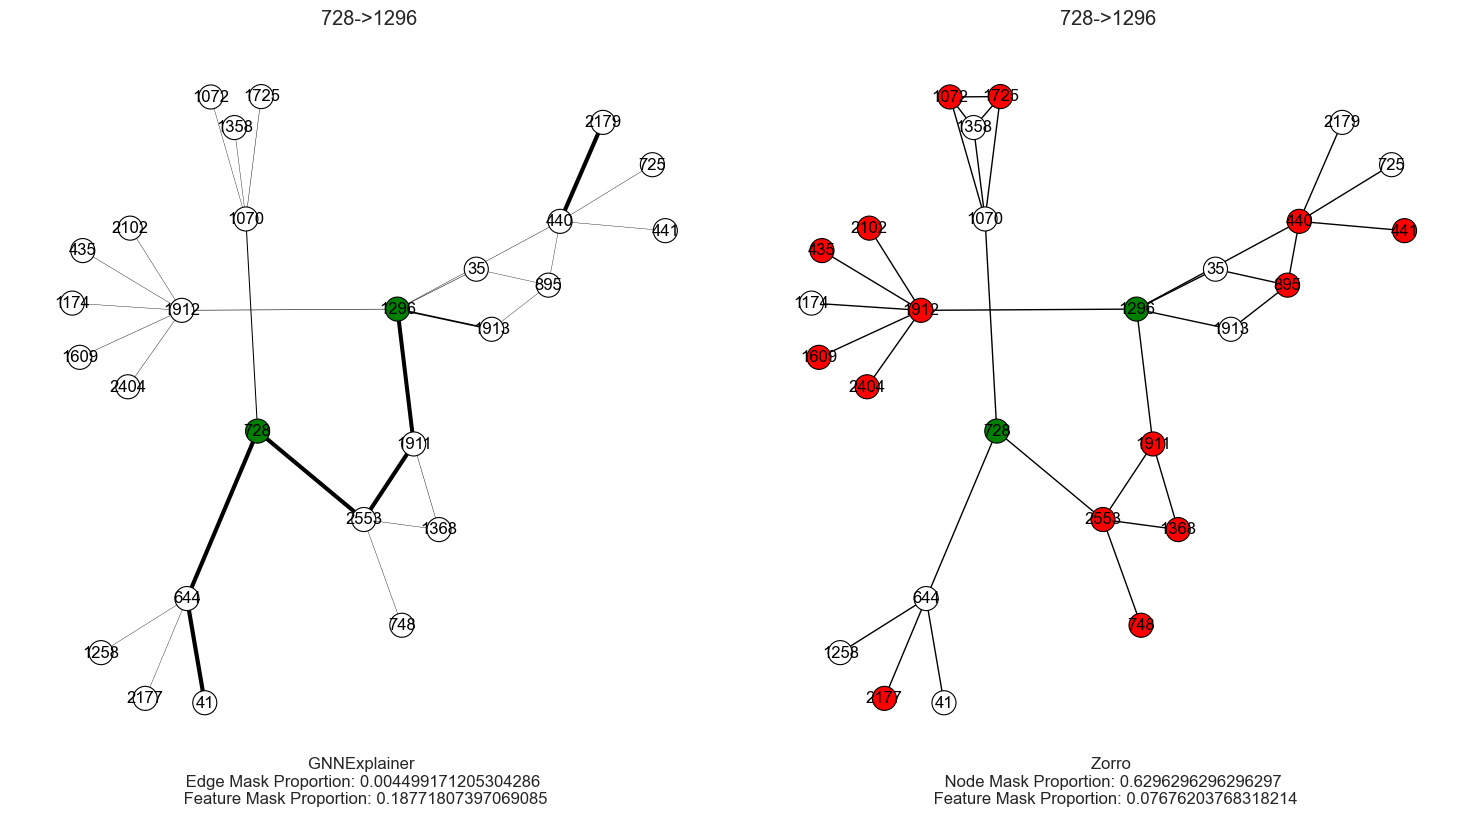

INFO:explainer:------ Start explaining edge tensor([[2224],
        [2226]])


Generating explanations for No.803 edge in the test data.
Source node 2224, Target Node: 2226
target:  1.0
pred:  0.9960183501243591
num_hops:  2



  0%|                                                                          | 0/12897 [00:00<?, ?it/s]
Explain edge tensor([[2224],
        [2226]]):   0%|                           | 0/12897 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[2224],
        [2226]])


initial_distortion:  0.76
num_hops:  2



INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[2224],
        [2226]])

Explain edge tensor([[2224],
        [2226]]):   0%|                 | 1/12897 [00:00<1:24:17,  2.55it/s]

node_masks:  tensor([[1., 0., 1., 0., 0., 0., 1., 1., 1.]])
best_node:  0
impove_in_distortion_by_node:  0.08999999999999997
best_feature:  1285
impove_in_distortion_by_feature:  0.05999999999999994
count:  1
0.76
[0, nan, 0.76]
num_to_add_once:  10


Argmax [1285, 295, 1201, 89, 418, 788, 805, 978, 57, 64], 0.06999999999999995:  10%| | 3/30 [00:00<00:00,


distortion_improve:  0.06999999999999995
distortion_improve:  0.06999999999999995
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -100
best_feature:  [1285, 295, 1201, 89, 418, 788, 805, 978, 57, 64]
impove_in_distortion_by_feature:  0.06999999999999995



Explain edge tensor([[2224],
        [2226]]):   0%|                   | 2/12897 [00:00<55:41,  3.86it/s]

count:  2
0.83
[nan, [1285, 295, 1201, 89, 418, 788, 805, 978, 57, 64], 0.83]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [4, 5], 0.020000000000000018:  50%|████████████████▌                | 2/4 [00:00<00:00, 29.98it/s]


distortion_improve:  0.020000000000000018
distortion_improve:  0.0
num_to_add_once:  10


Argmax [135, 435, 580, 631, 674, 675, 696, 702, 734, 860], 0.0:  10%|▌    | 3/30 [00:00<00:00, 30.58it/s]

distortion_improve:  0.0
distortion_improve:  -0.029999999999999916
distortion_improve:  -0.010000000000000009
best_node:  [4, 5]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [135, 435, 580, 631, 674, 675, 696, 702, 734, 860]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[2224],
        [2226]]):   0%|                   | 3/12897 [00:00<53:43,  4.00it/s]

count:  3
0.85
[[4, 5], nan, 0.85]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [3, 1], 0.010000000000000009:  50%|████████████████▌                | 1/2 [00:00<00:00, 28.71it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [868, 892, 923, 967, 1066, 1247, 1262, 1301, 1418, 2], 0.050000000000000044:  10%| | 3/30 [00:00<0

distortion_improve:  0.030000000000000027
distortion_improve:  0.050000000000000044
distortion_improve:  0.010000000000000009
best_node:  [3, 1]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [868, 892, 923, 967, 1066, 1247, 1262, 1301, 1418, 2]
impove_in_distortion_by_feature:  0.050000000000000044




Explain edge tensor([[2224],
        [2226]]):   0%|                   | 4/12897 [00:01<49:44,  4.32it/s]

count:  4
0.9
[nan, [868, 892, 923, 967, 1066, 1247, 1262, 1301, 1418, 2], 0.9]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [3, 1], 0.010000000000000009:   0%|                                         | 0/2 [00:00<?, ?it/s]

distortion_improve:  0.010000000000000009


Argmax [3, 1], 0.010000000000000009:  50%|████████████████▌                | 1/2 [00:00<00:00, 30.46it/s]


num_to_add_once:  10


Argmax [135, 435, 580, 631, 674, 675, 696, 702, 734, 860], 0.010000000000000009:  10%| | 3/30 [00:00<00:0


distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  [3, 1]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [135, 435, 580, 631, 674, 675, 696, 702, 734, 860]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[2224],
        [2226]]):   0%|                   | 5/12897 [00:01<47:32,  4.52it/s]

count:  5
0.91
[nan, [135, 435, 580, 631, 674, 675, 696, 702, 734, 860], 0.91]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [3, 1], 0.0:  50%|█████████████████████████                         | 1/2 [00:00<00:00, 27.00it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [71, 99, 101, 136, 140, 145, 166, 189, 194, 203], 0.0:  10%|▋      | 3/30 [00:00<00:00, 28.67it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  [3, 1]
impove_in_distortion_by_node:  0.0
best_feature:  [71, 99, 101, 136, 140, 145, 166, 189, 194, 203]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[2224],
        [2226]]):   0%|                   | 6/12897 [00:01<46:57,  4.58it/s]

count:  6
0.91
[nan, [71, 99, 101, 136, 140, 145, 166, 189, 194, 203], 0.91]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [3, 1], 0.0:  50%|█████████████████████████                         | 1/2 [00:00<00:00, 26.31it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [204, 213, 215, 223, 237, 263, 284, 296, 299, 312], 0.0:  10%|▌    | 3/30 [00:00<00:00, 28.96it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  -0.020000000000000018
best_node:  [3, 1]
impove_in_distortion_by_node:  0.0
best_feature:  [204, 213, 215, 223, 237, 263, 284, 296, 299, 312]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[2224],
        [2226]]):   0%|                   | 7/12897 [00:01<46:45,  4.60it/s]

count:  7
0.91
[nan, [204, 213, 215, 223, 237, 263, 284, 296, 299, 312], 0.91]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [3, 1], 0.020000000000000018:  50%|████████████████▌                | 1/2 [00:00<00:00, 28.12it/s]


distortion_improve:  0.020000000000000018
num_to_add_once:  10


Argmax [462, 499, 548, 551, 563, 564, 605, 615, 623, 624], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  [3, 1]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [462, 499, 548, 551, 563, 564, 605, 615, 623, 624]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[2224],
        [2226]]):   0%|                   | 8/12897 [00:01<46:20,  4.64it/s]

count:  8
0.93
[[3, 1], nan, 0.93]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [7, 25, 35, 38, 44, 52, 56, 58, 59, 62], 0.0:   0%|                        | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [7, 25, 35, 38, 44, 52, 56, 58, 59, 62], 0.0:  10%|█▌              | 3/30 [00:00<00:01, 25.20it/s]

Explain edge tensor([[2224],
        [2226]]):   0%|                   | 9/12897 [00:02<44:21,  4.84it/s]

distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [7, 25, 35, 38, 44, 52, 56, 58, 59, 62]
impove_in_distortion_by_feature:  0.0
count:  9
0.93
[nan, [7, 25, 35, 38, 44, 52, 56, 58, 59, 62], 0.93]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [315, 335, 338, 358, 365, 379, 384, 402, 416, 458], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [462, 499, 548, 551, 563, 564, 605, 615, 623, 624], 0.009999999999999898:   3%| | 1/30 [00:00<00:0

distortion_improve:  0.009999999999999898


Argmax [647, 673, 684, 697, 698, 699, 701, 704, 729, 750], 0.029999999999999916:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[2224],
        [2226]]):   0%|                  | 10/12897 [00:02<42:40,  5.03it/s]

distortion_improve:  0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [647, 673, 684, 697, 698, 699, 701, 704, 729, 750]
impove_in_distortion_by_feature:  0.029999999999999916
count:  10
0.96
[nan, [647, 673, 684, 697, 698, 699, 701, 704, 729, 750], 0.96]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [315, 335, 338, 358, 365, 379, 384, 402, 416, 458], 0.010000000000000009:   0%| | 0/30 [00:00<?, ?

distortion_improve:  0.010000000000000009
distortion_improve:  0.0


Argmax [315, 335, 338, 358, 365, 379, 384, 402, 416, 458], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [315, 335, 338, 358, 365, 379, 384, 402, 416, 458]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[2224],
        [2226]]):   0%|                  | 11/12897 [00:02<40:50,  5.26it/s]

count:  11
0.97
[nan, [315, 335, 338, 358, 365, 379, 384, 402, 416, 458], 0.97]


possible_nodes change:  tensor([[0., 1., 0., 1., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [462, 499, 548, 551, 563, 564, 605, 615, 623, 624], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [877, 891, 894, 896, 902, 915, 933, 973, 1005, 1011], 0.010000000000000009:  10%| | 3/30 [00:00<00

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [877, 891, 894, 896, 902, 915, 933, 973, 1005, 1011]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[2224],
Explain edge tensor([[2224],             | 12/12897 [00:02<39:57,  5.37it/s]
        [2226]]):   0%|                  | 12/12897 [00:02<45:48,  4.69it/s]
INFO:explainer:------ Finished explaining edge tensor([[2224],
        [2226]])


count:  12
0.98
[nan, [877, 891, 894, 896, 902, 915, 933, 973, 1005, 1011], 0.98]
[(array([[1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32), array([[0., 0., 1., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.76], [0, nan, 0.76], [nan, [1285, 295, 1201, 89, 418, 788, 805, 978, 57, 64], 0.83], [[4, 5], nan, 0.85], [nan, [868, 892, 923, 967, 1066, 1247, 1262, 1301, 1418, 2], 0.9], [nan, [135, 435, 580, 631, 674, 675, 696, 702, 734, 860], 0.91], [nan, [71, 99, 101, 136, 140, 145, 166, 189, 194, 203], 0.91], [nan, [204, 213, 215, 223, 237, 263, 284, 296, 299, 312], 0.91], [[3, 1], nan, 0.93], [nan, [7, 25, 35, 38, 44, 52, 56, 58, 59, 62], 0.93], [nan, [647, 673, 684, 697, 698, 699, 701, 704, 729, 750], 0.96], [nan, [315, 335, 338, 358, 365, 379, 384, 402, 416, 458], 0.97], [nan, [877, 891, 894, 896, 902, 915, 933, 973, 1005, 1011], 0.98]])]


Node mask num: 9, Node mask proportion: 1.0
Feature mask num: 90, Feature mask proportion: 0.0628053035589672
count of iterations to get this e

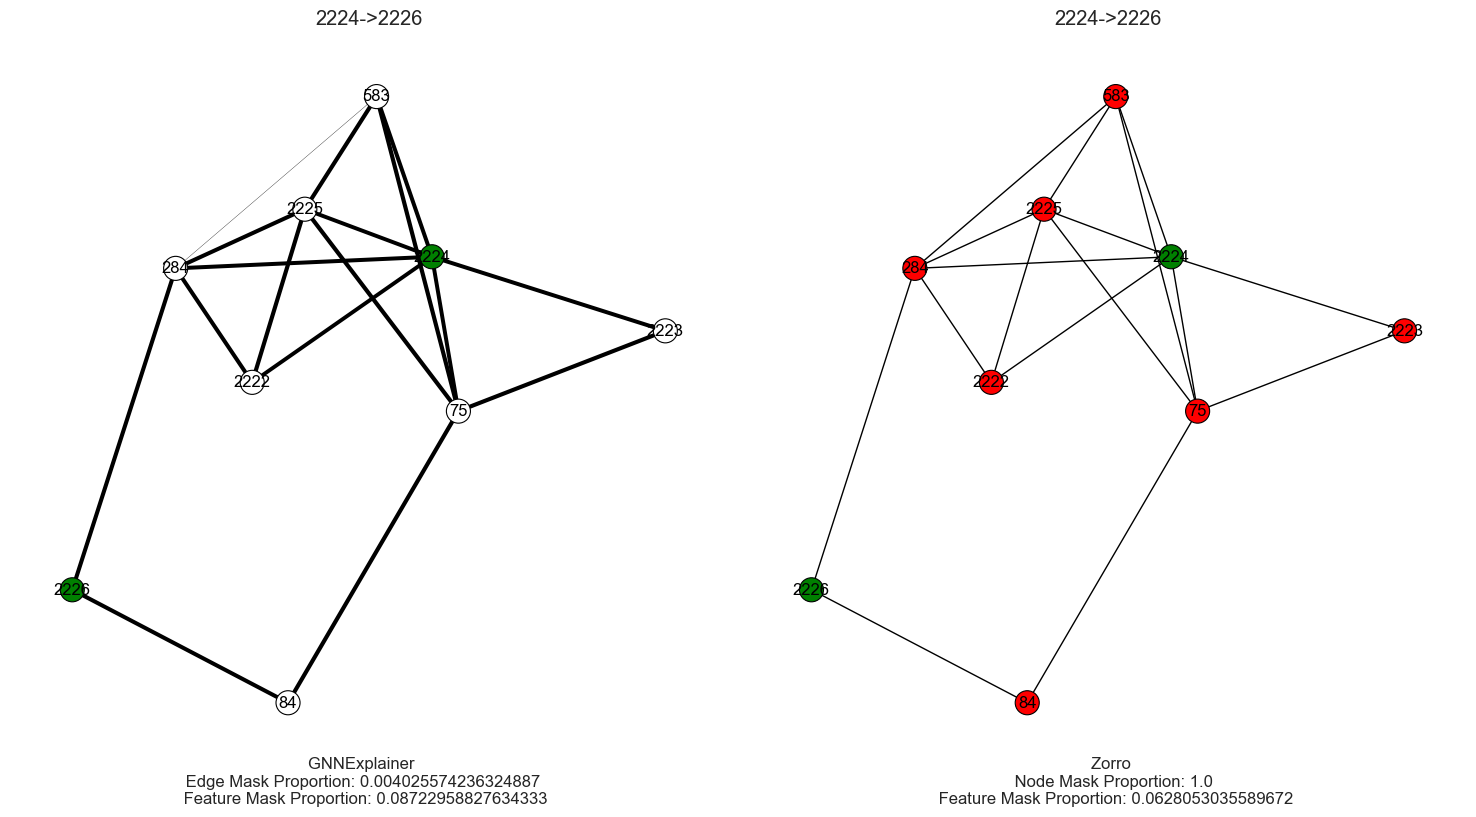

INFO:explainer:------ Start explaining edge tensor([[   4],
        [1761]])


Generating explanations for No.447 edge in the test data.
Source node 4, Target Node: 1761
target:  1.0
pred:  0.7942400574684143
num_hops:  2



  0%|                                                                          | 0/28660 [00:00<?, ?it/s]
Explain edge tensor([[   4],
        [1761]]):   0%|                           | 0/28660 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[   4],
        [1761]])


initial_distortion:  0.87
num_hops:  2



INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[   4],
        [1761]])

Explain edge tensor([[   4],
        [1761]]):   0%|                 | 1/28660 [00:00<7:03:09,  1.13it/s]

node_masks:  tensor([[1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
         1., 1.]])
best_node:  15
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  1060
impove_in_distortion_by_feature:  0.050000000000000044
count:  1
0.86
[nan, 1060, 0.86]
num_to_add_once:  2


Argmax [9, 7], 0.020000000000000018:  40%|████████████▊                   | 4/10 [00:00<00:00, 18.09it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.020000000000000018
distortion_improve:  0.0


Argmax [9, 7], 0.020000000000000018:  50%|████████████████                | 5/10 [00:00<00:00, 18.11it/s]

Explain edge tensor([[   4],
        [1761]]):   0%|                 | 2/28660 [00:01<4:42:35,  1.69it/s]

distortion_improve:  0.010000000000000009
best_node:  [9, 7]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  None
impove_in_distortion_by_feature:  -100
count:  2
0.88
[[9, 7], nan, 0.88]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         0., 0.]])
num_to_add_once:  2


Argmax [15, 1], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [15, 1], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00, 18.81it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [17, 13], 0.030000000000000027:  50%|███████████████               | 5/10 [00:00<00:00, 18.44it/s]


distortion_improve:  0.030000000000000027
num_to_add_once:  10


Argmax [337, 1274, 79, 88, 145, 338, 548, 774, 1171, 1180], 0.050000000000000044:  10%| | 3/30 [00:00<00:

distortion_improve:  0.050000000000000044
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  [17, 13]
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  [337, 1274, 79, 88, 145, 338, 548, 774, 1171, 1180]
impove_in_distortion_by_feature:  0.050000000000000044




Explain edge tensor([[   4],
        [1761]]):   0%|                 | 3/28660 [00:01<4:35:57,  1.73it/s]

count:  3
0.93
[nan, [337, 1274, 79, 88, 145, 338, 548, 774, 1171, 1180], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         0., 0.]])
num_to_add_once:  2


Argmax [15, 1], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 17.43it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [5, 10], 0.019999999999999907:  30%|█████████▎                     | 3/10 [00:00<00:00, 17.43it/s]

distortion_improve:  0.019999999999999907


Argmax [17, 13], 0.029999999999999916:  50%|███████████████               | 5/10 [00:00<00:00, 18.86it/s]


distortion_improve:  0.029999999999999916
num_to_add_once:  10


Argmax [1254, 1402, 1423, 6, 19, 27, 34, 46, 59, 61], 0.0:   7%|▋         | 2/30 [00:00<00:01, 18.02it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [210, 214, 234, 251, 259, 292, 316, 358, 370, 374], 0.019999999999999907:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.019999999999999907
best_node:  [17, 13]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  [210, 214, 234, 251, 259, 292, 316, 358, 370, 374]
impove_in_distortion_by_feature:  0.019999999999999907




Explain edge tensor([[   4],
        [1761]]):   0%|                 | 4/28660 [00:02<4:30:00,  1.77it/s]

count:  4
0.96
[[17, 13], nan, 0.96]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         0., 0.]])
num_to_add_once:  2


Argmax [15, 1], 0.0:   0%|                                                         | 0/8 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [15, 1], 0.0:  25%|████████████▎                                    | 2/8 [00:00<00:00, 17.44it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [5, 10], 0.010000000000000009:  50%|████████████████                | 4/8 [00:00<00:00, 16.92it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1254, 1402, 1423, 6, 19, 27, 34, 46, 59, 61], -0.010000000000000009:   0%| | 0/30 [00:00<?, ?it/s

distortion_improve:  -0.010000000000000009


Argmax [77, 115, 121, 125, 150, 157, 167, 189, 195, 205], 0.010000000000000009:  10%| | 3/30 [00:00<00:01

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
best_node:  [5, 10]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [77, 115, 121, 125, 150, 157, 167, 189, 195, 205]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[   4],
        [1761]]):   0%|                 | 5/28660 [00:02<4:21:53,  1.82it/s]

count:  5
0.97
[nan, [77, 115, 121, 125, 150, 157, 167, 189, 195, 205], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         0., 0.]])
num_to_add_once:  2


Argmax [15, 1], 0.0:  25%|████████████▎                                    | 2/8 [00:00<00:00, 17.02it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [5, 10], 0.010000000000000009:  50%|████████████████                | 4/8 [00:00<00:00, 17.31it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1254, 1402, 1423, 6, 19, 27, 34, 46, 59, 61], 0.0:  10%|█         | 3/30 [00:00<00:01, 17.93it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  [5, 10]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1254, 1402, 1423, 6, 19, 27, 34, 46, 59, 61]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[   4],
Explain edge tensor([[   4],            | 6/28660 [00:03<4:15:15,  1.87it/s]
        [1761]]):   0%|                 | 6/28660 [00:03<4:31:05,  1.76it/s]
INFO:explainer:------ Finished explaining edge tensor([[   4],
        [1761]])


count:  6
0.98
[[5, 10], nan, 0.98]
[(array([[1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 1., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.87], [nan, 1060, 0.86], [[9, 7], nan, 0.88], [nan, [337, 1274, 79, 88, 145, 338, 548, 774, 1171, 1180], 0.93], [[17, 13], nan, 0.96], [nan, [77, 115, 121, 125, 150, 157, 167, 189, 195, 205], 0.97], [[5, 10], nan, 0.98]])]


Node mask num: 14, Node mask proportion: 0.7
Feature mask num: 21, Feature mask proportion: 0.01465457083042568
count of iterations to get this explanation: 6
Time to explain: 3.409393787384033


Edge mask num: 34, Edge mask proportion: 0.004025574236324887
Feature mask num: 214, Feature mask proportion: 0.14933705512909978
Time to explain: 3.276732921600342


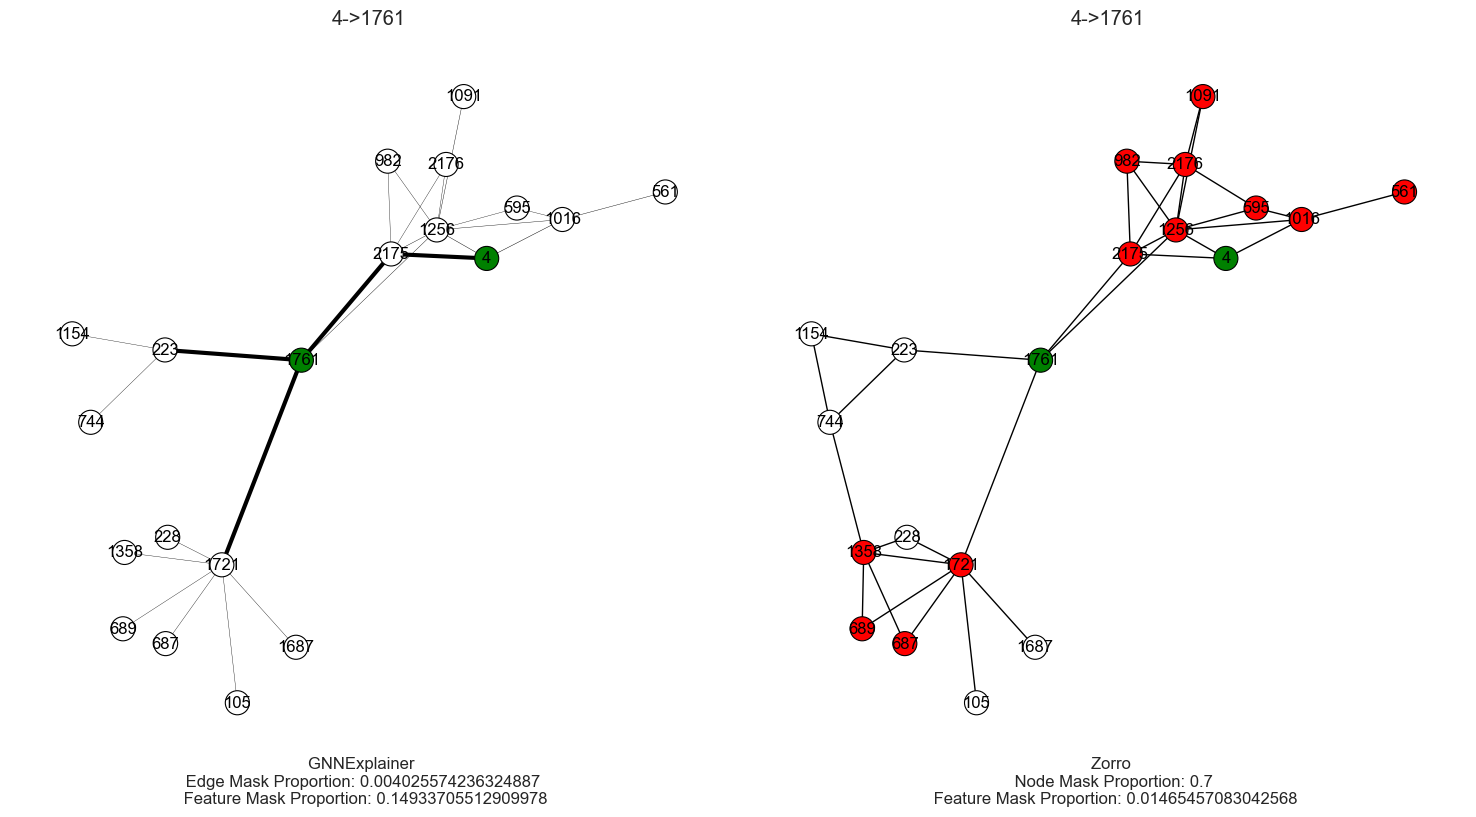

INFO:explainer:------ Start explaining edge tensor([[1202],
        [2376]])


Generating explanations for No.941 edge in the test data.
Source node 1202, Target Node: 2376
target:  1.0
pred:  0.8720369935035706
num_hops:  2



  0%|                                                                          | 0/31526 [00:00<?, ?it/s]
Explain edge tensor([[1202],
        [2376]]):   0%|                           | 0/31526 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[1202],
        [2376]])


initial_distortion:  0.6
num_hops:  2



INFO:explainer:------ Current fidelity 1.0
INFO:explainer:------ Finished explaining edge tensor([[1202],
        [2376]])

Explain edge tensor([[1202],
        [2376]]):   0%|                 | 1/31526 [00:01<9:43:20,  1.11s/it]

node_masks:  tensor([[1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
         1., 0., 0., 0.]])
best_node:  5
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  456
impove_in_distortion_by_feature:  0.040000000000000036
count:  1
0.63
[nan, 456, 0.63]
num_to_add_once:  2


Argmax [2, 3], 0.010000000000000009:  40%|████████████▊                   | 4/10 [00:00<00:00, 16.22it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [2, 3], 0.010000000000000009:  50%|████████████████                | 5/10 [00:00<00:00, 15.84it/s]

Explain edge tensor([[1202],
        [2376]]):   0%|                 | 2/31526 [00:01<6:19:56,  1.38it/s]

distortion_improve:  0.0
best_node:  [2, 3]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  None
impove_in_distortion_by_feature:  -100
count:  2
0.64
[[2, 3], nan, 0.64]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [19, 4], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [19, 4], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00, 15.96it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [19, 4], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00, 16.55it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [27, 56, 57, 93, 107, 126, 237, 331, 377, 409], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 1

distortion_improve:  -0.020000000000000018
distortion_improve:  0.010000000000000009
distortion_improve:  0.0
best_node:  [19, 4]
impove_in_distortion_by_node:  0.0
best_feature:  [27, 56, 57, 93, 107, 126, 237, 331, 377, 409]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                 | 3/31526 [00:02<5:53:21,  1.49it/s]

count:  3
0.65
[nan, [27, 56, 57, 93, 107, 126, 237, 331, 377, 409], 0.65]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [9, 11], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00, 15.69it/s]

distortion_improve:  0.0
distortion_improve:  0.010000000000000009
distortion_improve:  0.0


Argmax [9, 11], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00, 16.55it/s]

distortion_improve:  -0.030000000000000027


Argmax [9, 11], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00, 16.07it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], 0.0:   7%|▎    | 2/30 [00:00<00:01, 16.33it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  0.0


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.99it/s]

distortion_improve:  -0.010000000000000009
best_node:  [9, 11]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [457, 468, 479, 494, 495, 496, 514, 516, 531, 551]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                 | 4/31526 [00:02<5:41:54,  1.54it/s]

count:  4
0.66
[[9, 11], nan, 0.66]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [19, 4], 0.0:   0%|                                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [19, 4], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 15.66it/s]

distortion_improve:  0.0
distortion_improve:  -0.020000000000000018


Argmax [19, 4], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00, 15.39it/s]

distortion_improve:  0.0


Argmax [7, 21], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00, 15.39it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.030000000000000027:   0%| | 0/30 [00:00<?

distortion_improve:  -0.030000000000000027


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  [7, 21]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [457, 468, 479, 494, 495, 496, 514, 516, 531, 551]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                 | 5/31526 [00:03<5:48:27,  1.51it/s]

count:  5
0.67
[[7, 21], nan, 0.67]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [19, 4], 0.0:  25%|████████████▎                                    | 2/8 [00:00<00:00, 15.38it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [19, 4], 0.0:  50%|████████████████████████▌                        | 4/8 [00:00<00:00, 15.83it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [594, 597, 680, 715, 723, 725, 726, 774, 779, 813], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
distortion_improve:  0.010000000000000009
best_node:  [19, 4]
impove_in_distortion_by_node:  0.0
best_feature:  [594, 597, 680, 715, 723, 725, 726, 774, 779, 813]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                 | 6/31526 [00:04<5:31:25,  1.59it/s]

count:  6
0.68
[nan, [594, 597, 680, 715, 723, 725, 726, 774, 779, 813], 0.68]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [19, 4], -0.010000000000000009:  25%|███████▊                       | 2/8 [00:00<00:00, 17.17it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [12, 6], 0.029999999999999916:  50%|████████████████                | 4/8 [00:00<00:00, 16.54it/s]


distortion_improve:  0.029999999999999916
num_to_add_once:  10


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07000000000000006
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
best_node:  [12, 6]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  [457, 468, 479, 494, 495, 496, 514, 516, 531, 551]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                 | 7/31526 [00:04<5:19:06,  1.65it/s]

count:  7
0.71
[[12, 6], nan, 0.71]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [19, 4], 0.0:  50%|████████████████████████▌                        | 3/6 [00:00<00:00, 16.04it/s]


distortion_improve:  0.0
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.08999999999999997:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.08999999999999997


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.04999999999999993:  10%| | 3/30 [00:00<00:0


distortion_improve:  -0.04999999999999993
distortion_improve:  -0.06999999999999995
best_node:  [19, 4]
impove_in_distortion_by_node:  0.0
best_feature:  [457, 468, 479, 494, 495, 496, 514, 516, 531, 551]
impove_in_distortion_by_feature:  -0.04999999999999993



Explain edge tensor([[1202],
        [2376]]):   0%|                 | 8/31526 [00:05<5:02:14,  1.74it/s]

count:  8
0.71
[[19, 4], nan, 0.71]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [15, 20], 0.0:  50%|████████████████████████                        | 2/4 [00:00<00:00, 15.29it/s]


distortion_improve:  0.0
distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.07999999999999996:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.07999999999999996


Argmax [816, 845, 874, 893, 933, 935, 937, 959, 1114, 1125], -0.05999999999999994:  10%| | 3/30 [00:00<00


distortion_improve:  -0.05999999999999994
best_node:  [15, 20]
impove_in_distortion_by_node:  0.0
best_feature:  [816, 845, 874, 893, 933, 935, 937, 959, 1114, 1125]
impove_in_distortion_by_feature:  -0.05999999999999994



Explain edge tensor([[1202],
        [2376]]):   0%|                 | 9/31526 [00:05<4:41:57,  1.86it/s]

count:  9
0.71
[[15, 20], nan, 0.71]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [14, 8], -0.029999999999999916:  50%|███████████████▌               | 1/2 [00:00<00:00, 15.37it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.06999999999999995:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.06999999999999995


Argmax [816, 845, 874, 893, 933, 935, 937, 959, 1114, 1125], -0.04999999999999993:  10%| | 3/30 [00:00<00

distortion_improve:  -0.04999999999999993
best_node:  [14, 8]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [816, 845, 874, 893, 933, 935, 937, 959, 1114, 1125]
impove_in_distortion_by_feature:  -0.04999999999999993
tensor([[0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 1., 1.]])
[14, 8]
Removing nodes:  [14, 8]




Explain edge tensor([[1202],
        [2376]]):   0%|                | 10/31526 [00:05<4:10:05,  2.10it/s]

count:  10
0.71
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.06999999999999995:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.06999999999999995


Argmax [816, 845, 874, 893, 933, 935, 937, 959, 1114, 1125], -0.04999999999999993:  10%| | 3/30 [00:00<00

distortion_improve:  -0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [816, 845, 874, 893, 933, 935, 937, 959, 1114, 1125]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[1202],
        [2376]]):   0%|                | 11/31526 [00:06<3:33:46,  2.46it/s]

count:  11
0.71
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.09999999999999998:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.09999999999999998


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.06999999999999995:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.06999999999999995


Argmax [457, 468, 479, 494, 495, 496, 514, 516, 531, 551], -0.06999999999999995:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07999999999999996
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [457, 468, 479, 494, 495, 496, 514, 516, 531, 551]
impove_in_distortion_by_feature:  -0.06999999999999995




Explain edge tensor([[1202],
        [2376]]):   0%|                | 12/31526 [00:06<3:12:20,  2.73it/s]

count:  12
0.71
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.09999999999999998:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.09999999999999998


Argmax [1317, 1369, 1387, 1418, 2, 4, 6, 9, 11, 18], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 15

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1317, 1369, 1387, 1418, 2, 4, 6, 9, 11, 18]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 13/31526 [00:06<2:55:45,  2.99it/s]

count:  13
0.71
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [19, 21, 23, 24, 34, 36, 38, 41, 45, 55], -0.020000000000000018:   7%| | 2/30 [00:00<00:01, 14.58i

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.07999999999999996
distortion_improve:  -0.020000000000000018


Argmax [19, 21, 23, 24, 34, 36, 38, 41, 45, 55], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 15.19i

Explain edge tensor([[1202],
        [2376]]):   0%|                | 14/31526 [00:06<2:45:08,  3.18it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [19, 21, 23, 24, 34, 36, 38, 41, 45, 55]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  14
0.71
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.09999999999999998:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.09999999999999998


Argmax [62, 63, 73, 78, 80, 90, 99, 102, 112, 120], -0.020000000000000018:  10%| | 3/30 [00:00<00:02, 12.

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [62, 63, 73, 78, 80, 90, 99, 102, 112, 120]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 15/31526 [00:07<2:44:54,  3.18it/s]

count:  15
0.71
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [121, 127, 140, 159, 168, 173, 176, 191, 192, 194], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.07999999999999996
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [121, 127, 140, 159, 168, 173, 176, 191, 192, 194]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 16/31526 [00:07<2:36:07,  3.36it/s]

count:  16
0.71
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [208, 212, 213, 214, 217, 222, 233, 235, 236, 261], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.07999999999999996
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [208, 212, 213, 214, 217, 222, 233, 235, 236, 261]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 17/31526 [00:07<2:39:17,  3.30it/s]

count:  17
0.72
[nan, [208, 212, 213, 214, 217, 222, 233, 235, 236, 261], 0.72]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [262, 283, 284, 291, 295, 299, 305, 310, 316, 324], -0.04999999999999993:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [262, 283, 284, 291, 295, 299, 305, 310, 316, 324]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[1202],
        [2376]]):   0%|                | 18/31526 [00:08<2:31:17,  3.47it/s]

count:  18
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1137, 1170, 1178, 1203, 1209, 1224, 1236, 1246, 1276, 1298], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06999999999999995


Argmax [330, 336, 337, 340, 341, 348, 351, 367, 372, 380], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1202],
        [2376]]):   0%|                | 19/31526 [00:08<2:28:31,  3.54it/s]

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [330, 336, 337, 340, 341, 348, 351, 367, 372, 380]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  19
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1137, 1170, 1178, 1203, 1209, 1224, 1236, 1246, 1276, 1298], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06999999999999995


Argmax [382, 393, 394, 403, 416, 421, 422, 425, 430, 431], -0.020000000000000018:  10%| | 3/30 [00:00<00:


distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [382, 393, 394, 403, 416, 421, 422, 425, 430, 431]
impove_in_distortion_by_feature:  -0.020000000000000018



Explain edge tensor([[1202],
        [2376]]):   0%|                | 20/31526 [00:08<2:26:07,  3.59it/s]

count:  20
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1137, 1170, 1178, 1203, 1209, 1224, 1236, 1246, 1276, 1298], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06999999999999995


Argmax [434, 437, 438, 454, 458, 461, 470, 472, 489, 491], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [434, 437, 438, 454, 458, 461, 470, 472, 489, 491]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1202],
        [2376]]):   0%|                | 21/31526 [00:08<2:22:26,  3.69it/s]

count:  21
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1137, 1170, 1178, 1203, 1209, 1224, 1236, 1246, 1276, 1298], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06999999999999995


Argmax [1137, 1170, 1178, 1203, 1209, 1224, 1236, 1246, 1276, 1298], -0.06999999999999995:  10%| | 3/30 [

distortion_improve:  -0.06999999999999995
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1137, 1170, 1178, 1203, 1209, 1224, 1236, 1246, 1276, 1298]
impove_in_distortion_by_feature:  -0.06999999999999995




Explain edge tensor([[1202],
        [2376]]):   0%|                | 22/31526 [00:09<2:19:23,  3.77it/s]

count:  22
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.10999999999999999:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.10999999999999999


Argmax [502, 504, 507, 522, 526, 535, 536, 546, 560, 568], -0.06999999999999995:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.06999999999999995


Argmax [502, 504, 507, 522, 526, 535, 536, 546, 560, 568], -0.06999999999999995:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[1202],
        [2376]]):   0%|                | 23/31526 [00:09<2:19:37,  3.76it/s]

distortion_improve:  -0.07999999999999996
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [502, 504, 507, 522, 526, 535, 536, 546, 560, 568]
impove_in_distortion_by_feature:  -0.06999999999999995
count:  23
0.72
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.10999999999999999:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.10999999999999999


Argmax [644, 670, 685, 693, 696, 699, 704, 720, 722, 729], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07999999999999996
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [644, 670, 685, 693, 696, 699, 704, 720, 722, 729]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 24/31526 [00:09<2:27:32,  3.56it/s]

count:  24
0.73
[nan, [644, 670, 685, 693, 696, 699, 704, 720, 722, 729], 0.73]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [735, 746, 747, 750, 752, 753, 754, 755, 756, 759], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [735, 746, 747, 750, 752, 753, 754, 755, 756, 759]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 25/31526 [00:09<2:22:06,  3.69it/s]

count:  25
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [761, 778, 781, 794, 809, 812, 815, 819, 826, 836], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [761, 778, 781, 794, 809, 812, 815, 819, 826, 836]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 26/31526 [00:10<2:19:21,  3.77it/s]

count:  26
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [847, 849, 859, 878, 900, 909, 915, 917, 920, 924], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [847, 849, 859, 878, 900, 909, 915, 917, 920, 924]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 27/31526 [00:10<2:17:12,  3.83it/s]

count:  27
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [945, 952, 958, 962, 963, 971, 978, 981, 982, 1019], -0.010000000000000009:  10%| | 3/30 [00:00<00

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [945, 952, 958, 962, 963, 971, 978, 981, 982, 1019]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 28/31526 [00:10<2:15:57,  3.86it/s]

count:  28
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [575, 586, 588, 592, 593, 601, 605, 606, 618, 623], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [575, 586, 588, 592, 593, 601, 605, 606, 618, 623]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1202],
        [2376]]):   0%|                | 29/31526 [00:10<2:15:59,  3.86it/s]

count:  29
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1027, 1038, 1041, 1047, 1049, 1051, 1058, 1071, 1072, 1074], -0.030000000000000027:  10%| | 3/30 

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1027, 1038, 1041, 1047, 1049, 1051, 1058, 1071, 1072, 1074]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1202],
        [2376]]):   0%|                | 30/31526 [00:11<2:15:07,  3.88it/s]

count:  30
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1139, 1141, 1146, 1147, 1151, 1161, 1168, 1183, 1194, 1201], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1139, 1141, 1146, 1147, 1151, 1161, 1168, 1183, 1194, 1201]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 31/31526 [00:11<2:13:48,  3.92it/s]

count:  31
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1205, 1206, 1212, 1230, 1232, 1233, 1237, 1247, 1255, 1256], 0.0:  10%| | 3/30 [00:00<00:01, 16.2

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1205, 1206, 1212, 1230, 1232, 1233, 1237, 1247, 1255, 1256]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 32/31526 [00:11<2:22:19,  3.69it/s]

count:  32
0.73
[nan, [1205, 1206, 1212, 1230, 1232, 1233, 1237, 1247, 1255, 1256], 0.73]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1257, 1259, 1260, 1261, 1271, 1273, 1280, 1290, 1291, 1292], 0.0:  10%| | 3/30 [00:00<00:01, 15.8

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1257, 1259, 1260, 1261, 1271, 1273, 1280, 1290, 1291, 1292]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 33/31526 [00:12<2:29:47,  3.50it/s]

count:  33
0.73
[nan, [1257, 1259, 1260, 1261, 1271, 1273, 1280, 1290, 1291, 1292], 0.73]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995


Argmax [1315, 1330, 1332, 1333, 1338, 1339, 1347, 1349, 1365, 1381], -0.04999999999999993:  10%| | 3/30 [

distortion_improve:  -0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1315, 1330, 1332, 1333, 1338, 1339, 1347, 1349, 1365, 1381]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[1202],
        [2376]]):   0%|                | 34/31526 [00:12<2:29:30,  3.51it/s]

count:  34
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995


Argmax [1392, 1397, 1404, 1406, 1411, 1425, 1426, 1427, 1429, 0], -0.040000000000000036:  10%| | 3/30 [00

Explain edge tensor([[1202],
        [2376]]):   0%|                | 35/31526 [00:12<2:27:29,  3.56it/s]

distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1392, 1397, 1404, 1406, 1411, 1425, 1426, 1427, 1429, 0]
impove_in_distortion_by_feature:  -0.040000000000000036
count:  35
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995


Argmax [1, 5, 7, 8, 10, 12, 13, 14, 15, 16], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 16.23it/s]


distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1, 5, 7, 8, 10, 12, 13, 14, 15, 16]
impove_in_distortion_by_feature:  -0.020000000000000018



Explain edge tensor([[1202],
        [2376]]):   0%|                | 36/31526 [00:12<2:22:49,  3.67it/s]

count:  36
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995


Argmax [17, 20, 22, 28, 30, 31, 32, 33, 35, 37], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 15.36i

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [17, 20, 22, 28, 30, 31, 32, 33, 35, 37]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 37/31526 [00:13<2:21:45,  3.70it/s]

count:  37
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.08999999999999997:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.08999999999999997


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.06999999999999995


Argmax [39, 40, 42, 43, 46, 47, 48, 49, 50, 52], -0.020000000000000018:  10%| | 3/30 [00:00<00:02, 13.17i

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [39, 40, 42, 43, 46, 47, 48, 49, 50, 52]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 38/31526 [00:13<2:26:39,  3.58it/s]

count:  38
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.08999999999999997:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.08999999999999997


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.06999999999999995:   7%| | 2/30 [

distortion_improve:  -0.06999999999999995


Argmax [53, 54, 59, 60, 64, 66, 67, 68, 69, 70], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 15.00it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [53, 54, 59, 60, 64, 66, 67, 68, 69, 70]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1202],
        [2376]]):   0%|                | 39/31526 [00:13<2:34:15,  3.40it/s]

count:  39
0.73
[nan, [53, 54, 59, 60, 64, 66, 67, 68, 69, 70], 0.73]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.06999999999999995:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06999999999999995


Argmax [71, 72, 74, 75, 76, 79, 83, 84, 86, 87], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 16.17i

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [71, 72, 74, 75, 76, 79, 83, 84, 86, 87]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 40/31526 [00:14<2:28:16,  3.54it/s]

count:  40
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [88, 91, 92, 94, 95, 96, 97, 100, 101, 103], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 15.

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 41/31526 [00:14<2:24:55,  3.62it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [88, 91, 92, 94, 95, 96, 97, 100, 101, 103]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  41
0.73
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.06999999999999995:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06999999999999995


Argmax [104, 105, 106, 108, 109, 110, 111, 113, 114, 115], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.040000000000000036
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [104, 105, 106, 108, 109, 110, 111, 113, 114, 115]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 42/31526 [00:14<2:38:56,  3.30it/s]

count:  42
0.74
[nan, [104, 105, 106, 108, 109, 110, 111, 113, 114, 115], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [116, 117, 118, 119, 122, 123, 124, 125, 128, 131], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994
distortion_improve:  -0.010000000000000009


Argmax [116, 117, 118, 119, 122, 123, 124, 125, 128, 131], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1202],
        [2376]]):   0%|                | 43/31526 [00:14<2:32:32,  3.44it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [116, 117, 118, 119, 122, 123, 124, 125, 128, 131]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  43
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.05999999999999994:   7%| | 2/30 [

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994


Argmax [132, 133, 134, 135, 136, 138, 139, 141, 142, 143], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1202],
        [2376]]):   0%|                | 44/31526 [00:15<2:25:11,  3.61it/s]

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [132, 133, 134, 135, 136, 138, 139, 141, 142, 143]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  44
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.05999999999999994:   7%| | 2/30 [

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994


Argmax [144, 145, 146, 147, 148, 149, 150, 152, 153, 154], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1202],
        [2376]]):   0%|                | 45/31526 [00:15<2:22:11,  3.69it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [144, 145, 146, 147, 148, 149, 150, 152, 153, 154]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  45
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.05999999999999994:   7%| | 2/30 [

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994


Argmax [156, 157, 158, 160, 161, 162, 163, 165, 166, 167], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1202],
        [2376]]):   0%|                | 46/31526 [00:15<2:21:26,  3.71it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [156, 157, 158, 160, 161, 162, 163, 165, 166, 167]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  46
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.06999999999999995:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06999999999999995


Argmax [171, 172, 174, 175, 177, 178, 180, 181, 182, 183], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.40it/s]


distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [171, 172, 174, 175, 177, 178, 180, 181, 182, 183]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1202],
        [2376]]):   0%|                | 47/31526 [00:16<2:28:24,  3.54it/s]

count:  47
0.74
[nan, [171, 172, 174, 175, 177, 178, 180, 181, 182, 183], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [184, 185, 186, 188, 189, 190, 193, 195, 197, 198], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.05999999999999994
distortion_improve:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 48/31526 [00:16<2:25:44,  3.60it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [184, 185, 186, 188, 189, 190, 193, 195, 197, 198]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  48
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.05999999999999994:   7%| | 2/30 [

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.05999999999999994


Argmax [199, 200, 201, 202, 203, 204, 205, 206, 207, 209], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.14it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [199, 200, 201, 202, 203, 204, 205, 206, 207, 209]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1202],
        [2376]]):   0%|                | 49/31526 [00:16<2:30:41,  3.48it/s]

count:  49
0.74
[nan, [199, 200, 201, 202, 203, 204, 205, 206, 207, 209], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.08999999999999997:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.08999999999999997


Argmax [210, 215, 216, 218, 221, 224, 226, 227, 229, 230], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [210, 215, 216, 218, 221, 224, 226, 227, 229, 230]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 50/31526 [00:16<2:25:28,  3.61it/s]

count:  50
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.08999999999999997:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.08999999999999997


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.050000000000000044:   7%| | 2/30 

distortion_improve:  -0.050000000000000044


Argmax [231, 232, 234, 238, 239, 240, 241, 242, 243, 245], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.01it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [231, 232, 234, 238, 239, 240, 241, 242, 243, 245]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 51/31526 [00:17<2:36:43,  3.35it/s]

count:  51
0.74
[nan, [231, 232, 234, 238, 239, 240, 241, 242, 243, 245], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.08999999999999997:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.08999999999999997


Argmax [246, 247, 248, 249, 251, 252, 253, 254, 255, 256], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [246, 247, 248, 249, 251, 252, 253, 254, 255, 256]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 52/31526 [00:17<2:30:16,  3.49it/s]

count:  52
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax None, -1000:   0%|                                                         | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.08999999999999997


Argmax [257, 258, 259, 260, 263, 264, 265, 266, 267, 268], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.37it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [257, 258, 259, 260, 263, 264, 265, 266, 267, 268]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 53/31526 [00:17<2:32:55,  3.43it/s]

count:  53
0.74
[nan, [257, 258, 259, 260, 263, 264, 265, 266, 267, 268], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [269, 270, 271, 272, 274, 275, 276, 277, 278, 279], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [269, 270, 271, 272, 274, 275, 276, 277, 278, 279]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 54/31526 [00:18<2:29:16,  3.51it/s]

count:  54
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [280, 281, 282, 285, 288, 289, 290, 292, 293, 294], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [280, 281, 282, 285, 288, 289, 290, 292, 293, 294]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 55/31526 [00:18<2:25:45,  3.60it/s]

count:  55
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [296, 297, 300, 301, 302, 303, 304, 306, 307, 308], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [296, 297, 300, 301, 302, 303, 304, 306, 307, 308]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 56/31526 [00:18<2:23:38,  3.65it/s]

count:  56
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [309, 311, 314, 315, 317, 319, 320, 321, 322, 323], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [309, 311, 314, 315, 317, 319, 320, 321, 322, 323]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 57/31526 [00:18<2:19:34,  3.76it/s]

count:  57
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [325, 327, 328, 329, 332, 333, 334, 335, 338, 339], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [325, 327, 328, 329, 332, 333, 334, 335, 338, 339]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 58/31526 [00:19<2:18:39,  3.78it/s]

count:  58
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [343, 344, 346, 347, 350, 352, 353, 354, 355, 357], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.83it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [343, 344, 346, 347, 350, 352, 353, 354, 355, 357]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 59/31526 [00:19<2:25:14,  3.61it/s]

count:  59
0.74
[nan, [343, 344, 346, 347, 350, 352, 353, 354, 355, 357], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138], -0.030000000000000027:  10%| | 3/30 

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.08999999999999997
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1077, 1087, 1094, 1096, 1110, 1117, 1127, 1128, 1131, 1138]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1202],
        [2376]]):   0%|                | 60/31526 [00:19<2:19:25,  3.76it/s]

count:  60
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [371, 373, 374, 375, 376, 378, 379, 381, 383, 384], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.90it/s]

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.08999999999999997
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [371, 373, 374, 375, 376, 378, 379, 381, 383, 384]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 61/31526 [00:19<2:27:27,  3.56it/s]

count:  61
0.74
[nan, [371, 373, 374, 375, 376, 378, 379, 381, 383, 384], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [385, 386, 387, 388, 389, 390, 391, 392, 395, 397], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.77it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.07999999999999996
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [385, 386, 387, 388, 389, 390, 391, 392, 395, 397]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 62/31526 [00:20<2:32:06,  3.45it/s]

count:  62
0.74
[nan, [385, 386, 387, 388, 389, 390, 391, 392, 395, 397], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [399, 400, 402, 404, 405, 406, 407, 408, 410, 411], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.84it/s]

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.07999999999999996
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [399, 400, 402, 404, 405, 406, 407, 408, 410, 411]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 63/31526 [00:20<2:36:01,  3.36it/s]

count:  63
0.74
[nan, [399, 400, 402, 404, 405, 406, 407, 408, 410, 411], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.040000000000000036


Argmax [412, 413, 414, 415, 417, 418, 419, 420, 423, 424], 0.0:  10%|▌    | 3/30 [00:00<00:02, 12.65it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [412, 413, 414, 415, 417, 418, 419, 420, 423, 424]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 64/31526 [00:20<2:46:51,  3.14it/s]

count:  64
0.74
[nan, [412, 413, 414, 415, 417, 418, 419, 420, 423, 424], 0.74]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.07999999999999996:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.07999999999999996


Argmax [426, 427, 428, 429, 432, 433, 435, 436, 439, 440], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [426, 427, 428, 429, 432, 433, 435, 436, 439, 440]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1202],
        [2376]]):   0%|                | 65/31526 [00:21<2:38:47,  3.30it/s]

count:  65
0.74
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [441, 442, 443, 444, 445, 446, 447, 448, 449, 451], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.050000000000000044
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [441, 442, 443, 444, 445, 446, 447, 448, 449, 451]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 66/31526 [00:21<2:39:26,  3.29it/s]

count:  66
0.75
[nan, [441, 442, 443, 444, 445, 446, 447, 448, 449, 451], 0.75]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [452, 453, 459, 460, 462, 463, 465, 466, 467, 469], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06999999999999995
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [452, 453, 459, 460, 462, 463, 465, 466, 467, 469]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 67/31526 [00:21<2:38:18,  3.31it/s]

count:  67
0.76
[nan, [452, 453, 459, 460, 462, 463, 465, 466, 467, 469], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [471, 473, 476, 477, 478, 480, 482, 483, 484, 485], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.08999999999999997
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [471, 473, 476, 477, 478, 480, 482, 483, 484, 485]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 68/31526 [00:22<2:31:14,  3.47it/s]

count:  68
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [486, 487, 488, 490, 492, 493, 497, 499, 500, 501], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.68it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.08999999999999997
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [486, 487, 488, 490, 492, 493, 497, 499, 500, 501]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 69/31526 [00:22<2:34:46,  3.39it/s]

count:  69
0.76
[nan, [486, 487, 488, 490, 492, 493, 497, 499, 500, 501], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [503, 505, 506, 508, 509, 510, 511, 512, 515, 517], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.45it/s]

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.09999999999999998
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [503, 505, 506, 508, 509, 510, 511, 512, 515, 517]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 70/31526 [00:22<2:38:21,  3.31it/s]

count:  70
0.76
[nan, [503, 505, 506, 508, 509, 510, 511, 512, 515, 517], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [518, 519, 520, 521, 523, 524, 525, 527, 528, 529], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.12
distortion_improve:  -0.10999999999999999
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [518, 519, 520, 521, 523, 524, 525, 527, 528, 529]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 71/31526 [00:22<2:31:25,  3.46it/s]

count:  71
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.10999999999999999:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.12
distortion_improve:  -0.10999999999999999


Argmax [530, 532, 534, 537, 539, 541, 542, 543, 544, 545], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.63it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [530, 532, 534, 537, 539, 541, 542, 543, 544, 545]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 72/31526 [00:23<2:40:11,  3.27it/s]

count:  72
0.76
[nan, [530, 532, 534, 537, 539, 541, 542, 543, 544, 545], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.08999999999999997:   7%| | 2/30 [00:00<00

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.08999999999999997


Argmax [547, 549, 552, 553, 554, 555, 556, 557, 558, 561], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.83it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [547, 549, 552, 553, 554, 555, 556, 557, 558, 561]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 73/31526 [00:23<2:44:10,  3.19it/s]

count:  73
0.76
[nan, [547, 549, 552, 553, 554, 555, 556, 557, 558, 561], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.14:   0%|         | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.14


Argmax [562, 563, 564, 565, 566, 567, 569, 570, 571, 572], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [562, 563, 564, 565, 566, 567, 569, 570, 571, 572]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 74/31526 [00:23<2:34:58,  3.38it/s]

count:  74
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.14:   0%|         | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.14


Argmax [573, 574, 576, 578, 579, 580, 582, 583, 584, 587], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.42it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [573, 574, 576, 578, 579, 580, 582, 583, 584, 587]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 75/31526 [00:24<2:36:28,  3.35it/s]

count:  75
0.76
[nan, [573, 574, 576, 578, 579, 580, 582, 583, 584, 587], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [589, 591, 595, 596, 599, 600, 602, 603, 604, 607], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.14
distortion_improve:  -0.08999999999999997
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [589, 591, 595, 596, 599, 600, 602, 603, 604, 607]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 76/31526 [00:24<2:29:21,  3.51it/s]

count:  76
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [608, 609, 610, 611, 612, 614, 615, 616, 617, 619], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.14
distortion_improve:  -0.08999999999999997
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [608, 609, 610, 611, 612, 614, 615, 616, 617, 619]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 77/31526 [00:24<2:24:21,  3.63it/s]

count:  77
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [620, 621, 622, 624, 625, 626, 627, 629, 631, 633], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.99it/s]

distortion_improve:  -0.14
distortion_improve:  -0.08999999999999997
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [620, 621, 622, 624, 625, 626, 627, 629, 631, 633]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 78/31526 [00:25<2:30:19,  3.49it/s]

count:  78
0.76
[nan, [620, 621, 622, 624, 625, 626, 627, 629, 631, 633], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.07000000000000006:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.07000000000000006


Argmax [634, 635, 636, 637, 638, 639, 640, 641, 642, 643], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.51it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [634, 635, 636, 637, 638, 639, 640, 641, 642, 643]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 79/31526 [00:25<2:37:29,  3.33it/s]

count:  79
0.76
[nan, [634, 635, 636, 637, 638, 639, 640, 641, 642, 643], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.12:   0%|         | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [645, 646, 649, 650, 651, 652, 654, 655, 656, 657], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.22it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [645, 646, 649, 650, 651, 652, 654, 655, 656, 657]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 80/31526 [00:25<2:39:20,  3.29it/s]

count:  80
0.76
[nan, [645, 646, 649, 650, 651, 652, 654, 655, 656, 657], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [658, 659, 660, 662, 663, 665, 667, 668, 669, 671], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [658, 659, 660, 662, 663, 665, 667, 668, 669, 671]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 81/31526 [00:25<2:32:13,  3.44it/s]

count:  81
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.06000000000000005:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009


Argmax [673, 674, 675, 676, 678, 679, 681, 682, 683, 684], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1202],
        [2376]]):   0%|                | 82/31526 [00:26<2:27:51,  3.54it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [673, 674, 675, 676, 678, 679, 681, 682, 683, 684]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  82
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.06000000000000005:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.06000000000000005


Argmax [686, 687, 688, 689, 690, 691, 692, 694, 698, 700], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.86it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [686, 687, 688, 689, 690, 691, 692, 694, 698, 700]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1202],
        [2376]]):   0%|                | 83/31526 [00:26<2:32:27,  3.44it/s]

count:  83
0.76
[nan, [686, 687, 688, 689, 690, 691, 692, 694, 698, 700], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.10999999999999999:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.10999999999999999


Argmax [701, 702, 703, 705, 706, 707, 708, 709, 710, 711], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [701, 702, 703, 705, 706, 707, 708, 709, 710, 711]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 84/31526 [00:26<2:26:54,  3.57it/s]

count:  84
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.10999999999999999:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.10999999999999999


Argmax [712, 713, 714, 716, 717, 719, 721, 727, 728, 731], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [712, 713, 714, 716, 717, 719, 721, 727, 728, 731]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 85/31526 [00:27<2:22:58,  3.67it/s]

count:  85
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.10999999999999999:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.10999999999999999


Argmax [732, 733, 737, 738, 739, 740, 741, 742, 743, 744], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.36it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [732, 733, 737, 738, 739, 740, 741, 742, 743, 744]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 86/31526 [00:27<2:27:00,  3.56it/s]

count:  86
0.76
[nan, [732, 733, 737, 738, 739, 740, 741, 742, 743, 744], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [745, 748, 751, 757, 758, 760, 762, 763, 766, 767], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.30it/s]

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [745, 748, 751, 757, 758, 760, 762, 763, 766, 767]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 87/31526 [00:27<2:38:54,  3.30it/s]

count:  87
0.76
[nan, [745, 748, 751, 757, 758, 760, 762, 763, 766, 767], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.050000000000000044:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.050000000000000044


Argmax [768, 769, 770, 771, 773, 775, 776, 780, 782, 784], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1202],
        [2376]]):   0%|                | 88/31526 [00:27<2:33:58,  3.40it/s]

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [768, 769, 770, 771, 773, 775, 776, 780, 782, 784]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  88
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.050000000000000044:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.050000000000000044


Argmax [785, 786, 787, 788, 789, 790, 791, 792, 793, 795], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.01it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [785, 786, 787, 788, 789, 790, 791, 792, 793, 795]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1202],
        [2376]]):   0%|                | 89/31526 [00:28<2:38:20,  3.31it/s]

count:  89
0.76
[nan, [785, 786, 787, 788, 789, 790, 791, 792, 793, 795], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.040000000000000036


Argmax [796, 797, 798, 799, 800, 801, 802, 803, 804, 805], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [796, 797, 798, 799, 800, 801, 802, 803, 804, 805]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 90/31526 [00:28<2:34:24,  3.39it/s]

count:  90
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.07999999999999996:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.07999999999999996


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [806, 808, 810, 811, 817, 818, 820, 821, 822, 823], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [806, 808, 810, 811, 817, 818, 820, 821, 822, 823]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1202],
        [2376]]):   0%|                | 91/31526 [00:28<2:31:44,  3.45it/s]

count:  91
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.040000000000000036


Argmax [824, 825, 827, 829, 830, 831, 832, 833, 835, 837], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.17it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [824, 825, 827, 829, 830, 831, 832, 833, 835, 837]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 92/31526 [00:29<2:33:16,  3.42it/s]

count:  92
0.76
[nan, [824, 825, 827, 829, 830, 831, 832, 833, 835, 837], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.07999999999999996:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.07999999999999996


Argmax [838, 839, 840, 841, 842, 843, 844, 846, 848, 850], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.58it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [838, 839, 840, 841, 842, 843, 844, 846, 848, 850]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 93/31526 [00:29<2:35:48,  3.36it/s]

count:  93
0.76
[nan, [838, 839, 840, 841, 842, 843, 844, 846, 848, 850], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [851, 852, 853, 854, 855, 856, 858, 860, 861, 862], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07000000000000006
distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [851, 852, 853, 854, 855, 856, 858, 860, 861, 862]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 94/31526 [00:29<2:29:27,  3.50it/s]

count:  94
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [863, 864, 865, 866, 867, 868, 869, 870, 871, 873], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.79it/s]

distortion_improve:  -0.07000000000000006
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [863, 864, 865, 866, 867, 868, 869, 870, 871, 873]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1202],
        [2376]]):   0%|                | 95/31526 [00:29<2:32:57,  3.42it/s]

count:  95
0.76
[nan, [863, 864, 865, 866, 867, 868, 869, 870, 871, 873], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [876, 879, 880, 881, 882, 883, 884, 885, 886, 887], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07000000000000006
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [876, 879, 880, 881, 882, 883, 884, 885, 886, 887]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 96/31526 [00:30<2:25:47,  3.59it/s]

count:  96
0.76
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.030000000000000027:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.07000000000000006
distortion_improve:  -0.030000000000000027


Argmax [888, 889, 890, 891, 894, 895, 896, 897, 898, 899], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.31it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [888, 889, 890, 891, 894, 895, 896, 897, 898, 899]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1202],
        [2376]]):   0%|                | 97/31526 [00:30<2:32:56,  3.42it/s]

count:  97
0.76
[nan, [888, 889, 890, 891, 894, 895, 896, 897, 898, 899], 0.76]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.030000000000000027:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.030000000000000027


Argmax [901, 902, 904, 905, 906, 907, 908, 910, 911, 913], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [901, 902, 904, 905, 906, 907, 908, 910, 911, 913]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1202],
        [2376]]):   0%|                | 98/31526 [00:30<2:44:16,  3.19it/s]

count:  98
0.77
[nan, [901, 902, 904, 905, 906, 907, 908, 910, 911, 913], 0.77]


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.040000000000000036:   0%| | 0/30 [00:00<?

distortion_improve:  -0.040000000000000036


Argmax [358, 360, 361, 362, 363, 364, 365, 366, 368, 369], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [358, 360, 361, 362, 363, 364, 365, 366, 368, 369]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1202],
        [2376]]):   0%|                | 99/31526 [00:31<2:34:58,  3.38it/s]

count:  99
0.77
None


possible_nodes change:  tensor([[0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [777, 359, 474, 647, 807, 969, 1075, 1272, 1328, 26], -0.040000000000000036:   0%| | 0/30 [00:00<?

distortion_improve:  -0.040000000000000036


Argmax [928, 929, 930, 931, 932, 934, 936, 938, 939, 940], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [928, 929, 930, 931, 932, 934, 936, 938, 939, 940]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1202],
Explain edge tensor([[1202],          | 100/31526 [00:31<2:28:50,  3.52it/s]
        [2376]]):   0%|               | 100/31526 [00:31<2:44:36,  3.18it/s]
INFO:explainer:------ Finished explaining edge tensor([[1202],
        [2376]])


count:  100
0.77
None
[(array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.6], [nan, 456, 0.63], [[2, 3], nan, 0.64], [nan, [27, 56, 57, 93, 107, 126, 237, 331, 377, 409], 0.65], [[9, 11], nan, 0.66], [[7, 21], nan, 0.67], [nan, [594, 597, 680, 715, 723, 725, 726, 774, 779, 813], 0.68], [[12, 6], nan, 0.71], [[19, 4], nan, 0.71], [[15, 20], nan, 0.71], None, None, None, None, None, None, None, [nan, [208, 212, 213, 214, 217, 222, 233, 235, 236, 261], 0.72], None, None, None, None, None, None, [nan, [644, 670, 685, 693, 696, 699, 704, 720, 722, 729], 0.73], None, None, None, None, None, None, None, [nan, [1205, 1206, 1212, 1230, 1232, 1233, 1237, 1247, 1255, 1256], 0.73], [nan, [1257, 1259, 1260, 1261, 1271, 1273, 1280, 1290, 1291, 1292], 0.73], None, None, None, None, None, [nan, [53, 54, 59, 60, 64, 66, 67, 68, 69, 70], 0.73], None, None, [nan, [1

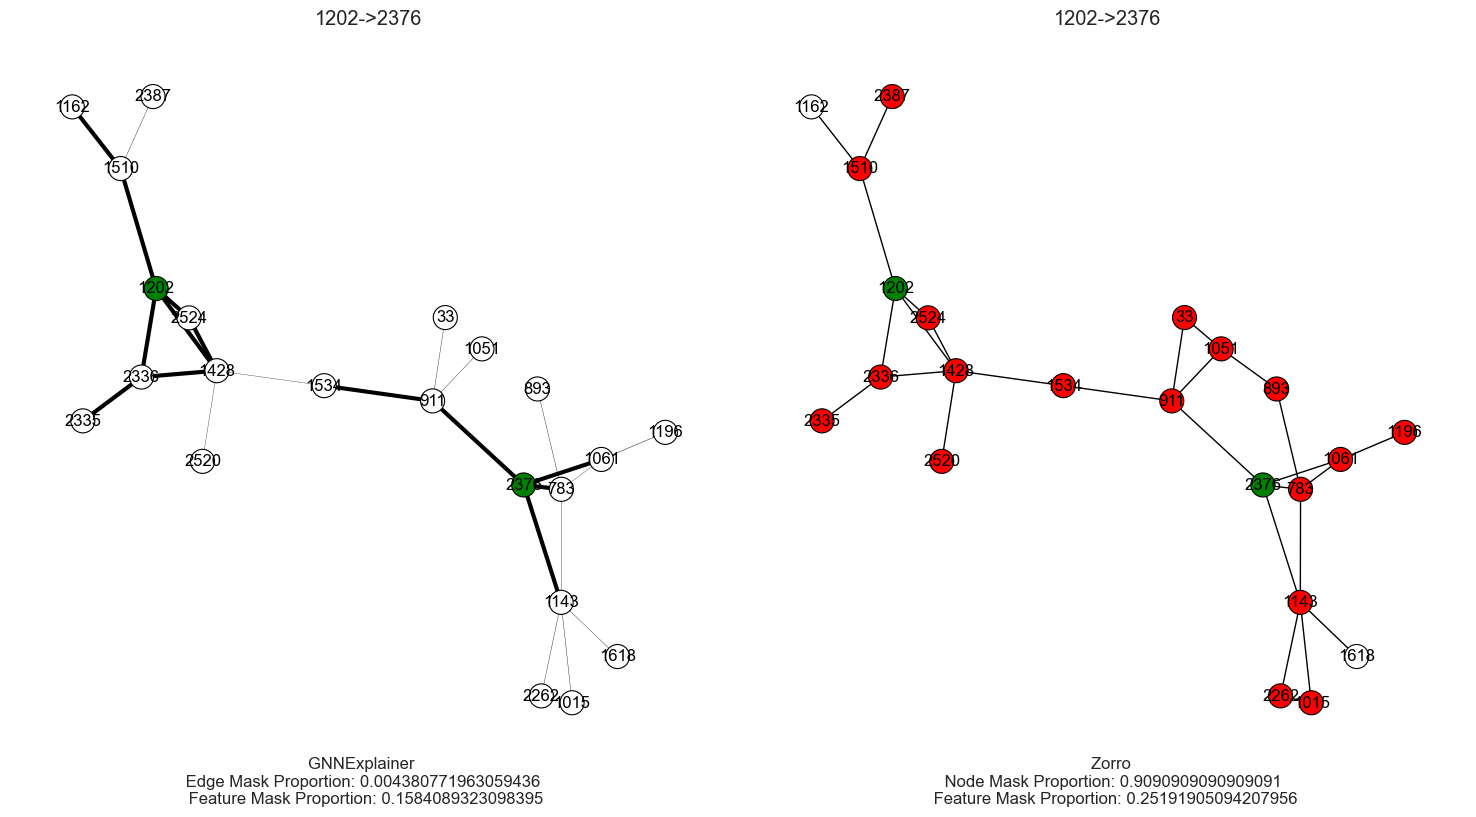

INFO:explainer:------ Start explaining edge tensor([[ 385],
        [2484]])


Generating explanations for No.174 edge in the test data.
Source node 385, Target Node: 2484
target:  1.0
pred:  0.9883749485015869
num_hops:  2



  0%|                                                                           | 0/5732 [00:00<?, ?it/s]
Explain edge tensor([[ 385],
        [2484]]):   0%|                            | 0/5732 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[ 385],
        [2484]])
INFO:explainer:------ Current fidelity 1.0
INFO:explainer:------ Finished explaining edge tensor([[ 385],
        [2484]])


initial_distortion:  0.85
num_hops:  2

node_masks:  tensor([[0., 1., 1., 0.]])
best_node:  1
impove_in_distortion_by_node:  0.07000000000000006
best_feature:  1043
impove_in_distortion_by_feature:  0.12



Explain edge tensor([[ 385],
        [2484]]):   0%|                    | 1/5732 [00:00<22:23,  4.27it/s]

count:  1
0.97
[nan, 1043, 0.97]
num_to_add_once:  2


Argmax [3, 0], 0.0:  50%|█████████████████████████                         | 1/2 [00:00<00:00, 32.30it/s]


distortion_improve:  0.0
best_node:  [3, 0]
impove_in_distortion_by_node:  0.0
best_feature:  None
impove_in_distortion_by_feature:  -100
count:  2
0.97
[[3, 0], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [16, 697, 1081, 1175, 210, 393, 1026, 1174, 1209, 1236], 0.030000000000000027:  10%| | 3/30 [00:00

distortion_improve:  0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [16, 697, 1081, 1175, 210, 393, 1026, 1174, 1209, 1236]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[ 385],
Explain edge tensor([[ 385],               | 3/5732 [00:00<13:49,  6.91it/s]
        [2484]]):   0%|                    | 3/5732 [00:00<14:42,  6.49it/s]
INFO:explainer:------ Finished explaining edge tensor([[ 385],
        [2484]])


count:  3
1.0
[nan, [16, 697, 1081, 1175, 210, 393, 1026, 1174, 1209, 1236], 1.0]
[(array([[1., 1., 1., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.85], [nan, 1043, 0.97], [[3, 0], nan, 0.97], [nan, [16, 697, 1081, 1175, 210, 393, 1026, 1174, 1209, 1236], 1.0]])]


Node mask num: 4, Node mask proportion: 1.0
Feature mask num: 11, Feature mask proportion: 0.007676203768318213
count of iterations to get this explanation: 3
Time to explain: 0.46579694747924805


Edge mask num: 6, Edge mask proportion: 0.0007103954534690978
Feature mask num: 39, Feature mask proportion: 0.02721563154221912
Time to explain: 3.6664257049560547


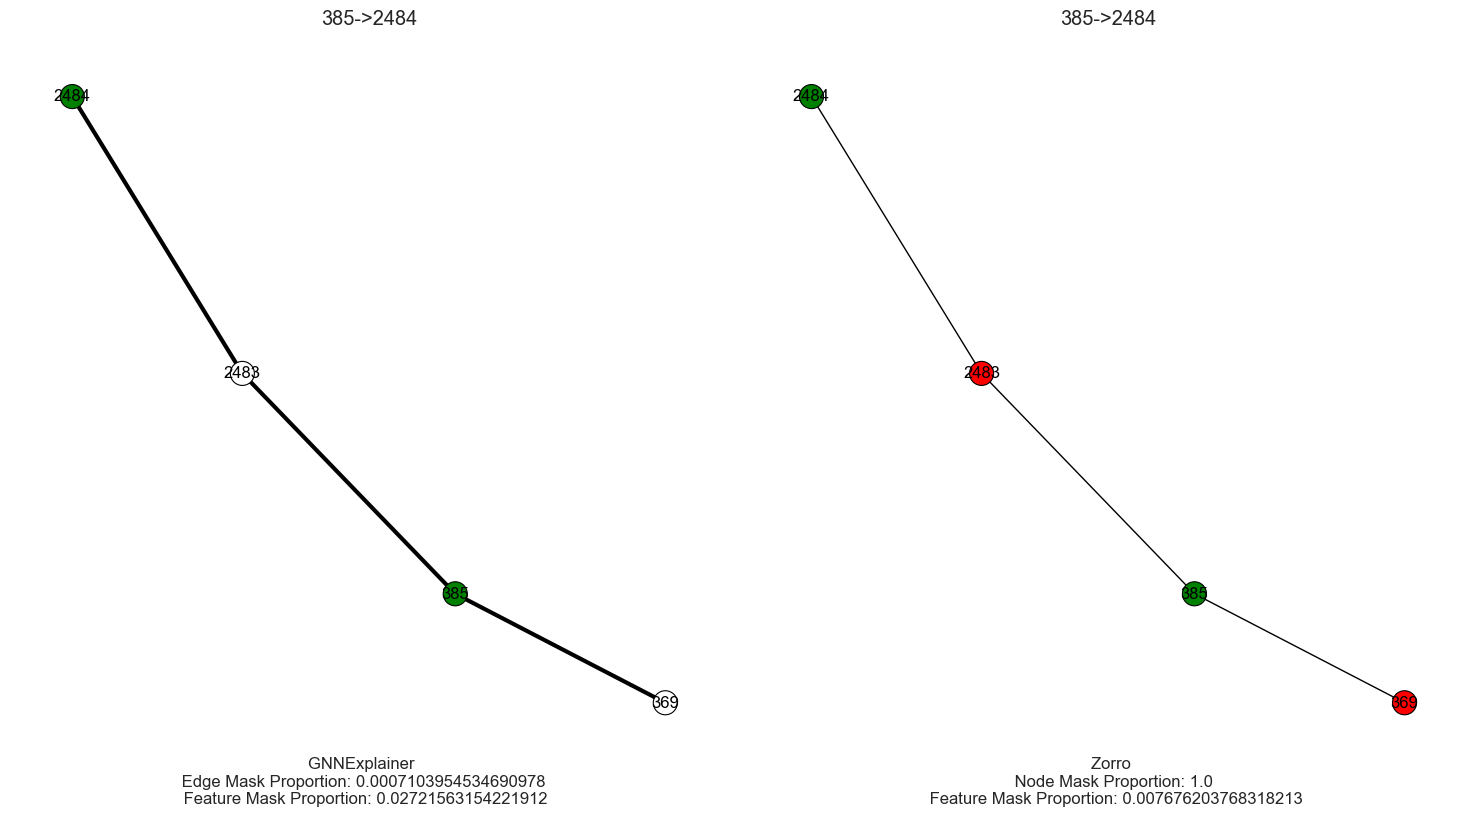

INFO:explainer:------ Start explaining edge tensor([[1050],
        [2563]])


Generating explanations for No.614 edge in the test data.
Source node 1050, Target Node: 2563
target:  1.0
pred:  0.96952223777771
num_hops:  2



  0%|                                                                          | 0/25794 [00:00<?, ?it/s]
Explain edge tensor([[1050],
        [2563]]):   0%|                           | 0/25794 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[1050],
        [2563]])


initial_distortion:  0.75
num_hops:  2



INFO:explainer:------ Current fidelity 1.0
INFO:explainer:------ Finished explaining edge tensor([[1050],
        [2563]])

Explain edge tensor([[1050],
        [2563]]):   0%|                 | 1/25794 [00:00<4:17:47,  1.67it/s]

node_masks:  tensor([[1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
best_node:  7
impove_in_distortion_by_node:  0.040000000000000036
best_feature:  1345
impove_in_distortion_by_feature:  0.030000000000000027
count:  1
0.75
[7, nan, 0.75]
num_to_add_once:  10


Argmax [1345, 118, 665, 697, 775, 1328, 8, 23, 26, 29], 0.06999999999999995:  10%| | 3/30 [00:00<00:01, 1


distortion_improve:  0.06999999999999995
distortion_improve:  0.020000000000000018
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -100
best_feature:  [1345, 118, 665, 697, 775, 1328, 8, 23, 26, 29]
impove_in_distortion_by_feature:  0.06999999999999995



Explain edge tensor([[1050],
        [2563]]):   0%|                 | 2/25794 [00:00<3:01:21,  2.37it/s]

count:  2
0.82
[nan, [1345, 118, 665, 697, 775, 1328, 8, 23, 26, 29], 0.82]


possible_nodes change:  tensor([[0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [13, 1], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 18.06it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  -0.009999999999999898
distortion_improve:  -0.009999999999999898


Argmax [13, 1], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00, 19.09it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [33, 34, 39, 65, 74, 125, 129, 131, 135, 153], 0.010000000000000009:   7%| | 2/30 [00:00<00:01, 17

distortion_improve:  0.010000000000000009
distortion_improve:  -0.04999999999999993


Argmax [33, 34, 39, 65, 74, 125, 129, 131, 135, 153], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 16

distortion_improve:  -0.009999999999999898
best_node:  [13, 1]
impove_in_distortion_by_node:  0.0
best_feature:  [33, 34, 39, 65, 74, 125, 129, 131, 135, 153]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                 | 3/25794 [00:01<3:28:39,  2.06it/s]

count:  3
0.83
[nan, [33, 34, 39, 65, 74, 125, 129, 131, 135, 153], 0.83]


possible_nodes change:  tensor([[0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [13, 1], -0.019999999999999907:   0%|                                      | 0/10 [00:00<?, ?it/s]

distortion_improve:  -0.019999999999999907


Argmax [17, 5], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00, 16.78it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [17, 5], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00, 16.82it/s]

distortion_improve:  -0.010000000000000009


Argmax [17, 5], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00, 17.15it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.019999999999999907


Argmax [382, 395, 400, 415, 428, 441, 447, 455, 458, 460], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.45it/s]

distortion_improve:  0.0
best_node:  [17, 5]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [382, 395, 400, 415, 428, 441, 447, 455, 458, 460]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                 | 4/25794 [00:02<3:44:06,  1.92it/s]

count:  4
0.84
[[17, 5], nan, 0.84]


possible_nodes change:  tensor([[0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [13, 1], -0.029999999999999916:   0%|                                      | 0/10 [00:00<?, ?it/s]

distortion_improve:  -0.029999999999999916


Argmax [10, 11], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:00, 16.50it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.029999999999999916


Argmax [10, 11], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00, 13.67it/s]

distortion_improve:  -0.010000000000000009


Argmax [10, 11], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00, 14.46it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.029999999999999916


Argmax [382, 395, 400, 415, 428, 441, 447, 455, 458, 460], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.23it/s]

distortion_improve:  0.0
best_node:  [10, 11]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [382, 395, 400, 415, 428, 441, 447, 455, 458, 460]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                 | 5/25794 [00:02<4:00:39,  1.79it/s]

count:  5
0.84
[nan, [382, 395, 400, 415, 428, 441, 447, 455, 458, 460], 0.84]


possible_nodes change:  tensor([[0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [13, 1], -0.029999999999999916:   0%|                                      | 0/10 [00:00<?, ?it/s]

distortion_improve:  -0.029999999999999916


Argmax [10, 11], -0.020000000000000018:  20%|█████▊                       | 2/10 [00:00<00:00, 17.26it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.029999999999999916


Argmax [6, 9], 0.0:  50%|████████████████████████▌                        | 5/10 [00:00<00:00, 19.19it/s]

distortion_improve:  0.0
distortion_improve:  -0.029999999999999916


num_to_add_once:  10


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.039999999999999925


Argmax [474, 476, 487, 505, 540, 544, 580, 581, 588, 615], -0.029999999999999916:  10%| | 3/30 [00:00<00:


distortion_improve:  -0.029999999999999916
best_node:  [6, 9]
impove_in_distortion_by_node:  0.0
best_feature:  [474, 476, 487, 505, 540, 544, 580, 581, 588, 615]
impove_in_distortion_by_feature:  -0.029999999999999916



Explain edge tensor([[1050],
        [2563]]):   0%|                 | 6/25794 [00:03<3:59:14,  1.80it/s]

count:  6
0.84
[[6, 9], nan, 0.84]


possible_nodes change:  tensor([[0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [13, 1], -0.029999999999999916:   0%|                                       | 0/8 [00:00<?, ?it/s]

distortion_improve:  -0.029999999999999916


Argmax [13, 1], -0.029999999999999916:  25%|███████▊                       | 2/8 [00:00<00:00, 16.23it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.039999999999999925


Argmax [13, 1], -0.029999999999999916:  50%|███████████████▌               | 4/8 [00:00<00:00, 17.05it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.039999999999999925


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.04999999999999993
best_node:  [13, 1]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [170, 173, 176, 178, 179, 188, 198, 212, 226, 232]
impove_in_distortion_by_feature:  -0.039999999999999925
tensor([[0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])
[13, 1]
Removing nodes:  [13, 1]




Explain edge tensor([[1050],
        [2563]]):   0%|                 | 7/25794 [00:03<3:48:17,  1.88it/s]

count:  7
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 11], -0.029999999999999916:   0%|                                      | 0/6 [00:00<?, ?it/s]

distortion_improve:  -0.029999999999999916


Argmax [10, 11], -0.029999999999999916:  50%|███████████████               | 3/6 [00:00<00:00, 16.29it/s]


distortion_improve:  -0.039999999999999925
distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.039999999999999925


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1050],
        [2563]]):   0%|                 | 8/25794 [00:04<3:36:29,  1.99it/s]

distortion_improve:  -0.04999999999999993
best_node:  [10, 11]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [170, 173, 176, 178, 179, 188, 198, 212, 226, 232]
impove_in_distortion_by_feature:  -0.039999999999999925
tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.]])
[10, 11]
Removing nodes:  [10, 11]
count:  8
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [12, 16], -0.039999999999999925:   0%|                                      | 0/4 [00:00<?, ?it/s]

distortion_improve:  -0.039999999999999925


Argmax [8, 15], -0.029999999999999916:  50%|███████████████▌               | 2/4 [00:00<00:00, 16.83it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.04999999999999993


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.04999999999999993
best_node:  [8, 15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [170, 173, 176, 178, 179, 188, 198, 212, 226, 232]
impove_in_distortion_by_feature:  -0.039999999999999925
tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.]])
[8, 15]
Removing nodes:  [8, 15]




Explain edge tensor([[1050],
        [2563]]):   0%|                 | 9/25794 [00:04<3:15:59,  2.19it/s]

count:  9
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.]])
num_to_add_once:  2


Argmax [12, 16], -0.039999999999999925:  50%|███████████████               | 1/2 [00:00<00:00, 17.05it/s]


distortion_improve:  -0.039999999999999925
num_to_add_once:  10


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.039999999999999925


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993


Argmax [170, 173, 176, 178, 179, 188, 198, 212, 226, 232], -0.039999999999999925:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.04999999999999993
best_node:  [12, 16]
impove_in_distortion_by_node:  -0.039999999999999925
best_feature:  [170, 173, 176, 178, 179, 188, 198, 212, 226, 232]
impove_in_distortion_by_feature:  -0.039999999999999925
Removing features:  [170, 173, 176, 178, 179, 188, 198, 212, 226, 232]




Explain edge tensor([[1050],
        [2563]]):   0%|                | 10/25794 [00:04<2:56:24,  2.44it/s]

count:  10
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.]])
num_to_add_once:  2


Argmax [12, 16], -0.039999999999999925:  50%|███████████████               | 1/2 [00:00<00:00, 15.41it/s]


distortion_improve:  -0.039999999999999925
num_to_add_once:  10


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.04999999999999993:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.04999999999999993


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.04999999999999993


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.04999999999999993:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.04999999999999993
best_node:  [12, 16]
impove_in_distortion_by_node:  -0.039999999999999925
best_feature:  [247, 283, 284, 303, 315, 327, 331, 338, 359, 378]
impove_in_distortion_by_feature:  -0.04999999999999993
tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.]])
[12, 16]
Removing nodes:  [12, 16]




Explain edge tensor([[1050],
        [2563]]):   0%|                | 11/25794 [00:05<2:43:15,  2.63it/s]

count:  11
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.04999999999999993:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.04999999999999993


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.04999999999999993


Argmax [247, 283, 284, 303, 315, 327, 331, 338, 359, 378], -0.04999999999999993:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [247, 283, 284, 303, 315, 327, 331, 338, 359, 378]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[1050],
        [2563]]):   0%|                | 12/25794 [00:05<2:23:22,  3.00it/s]

count:  12
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [474, 476, 487, 505, 540, 544, 580, 581, 588, 615], -0.04999999999999993:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.04999999999999993


Argmax [474, 476, 487, 505, 540, 544, 580, 581, 588, 615], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.04999999999999993


Argmax [474, 476, 487, 505, 540, 544, 580, 581, 588, 615], -0.04999999999999993:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.05999999999999994
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [474, 476, 487, 505, 540, 544, 580, 581, 588, 615]
impove_in_distortion_by_feature:  -0.04999999999999993




Explain edge tensor([[1050],
        [2563]]):   0%|                | 13/25794 [00:05<2:10:05,  3.30it/s]

count:  13
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.04999999999999993:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.04999999999999993


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.05999999999999994


Argmax [877, 880, 897, 925, 933, 949, 967, 975, 982, 1024], -0.010000000000000009:  10%| | 3/30 [00:00<00

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [877, 880, 897, 925, 933, 949, 967, 975, 982, 1024]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 14/25794 [00:05<2:01:56,  3.52it/s]

count:  14
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.04999999999999993:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.04999999999999993


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.05999999999999994


Argmax [1036, 1048, 1080, 1094, 1096, 1119, 1143, 1158, 1166, 1203], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1036, 1048, 1080, 1094, 1096, 1119, 1143, 1158, 1166, 1203]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 15/25794 [00:06<1:56:40,  3.68it/s]

count:  15
0.84
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.04999999999999993:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.04999999999999993


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.04999999999999993:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.05999999999999994


Argmax [1212, 1215, 1220, 1224, 1230, 1231, 1233, 1236, 1254, 1256], 0.0:  10%| | 3/30 [00:00<00:01, 18.1

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1212, 1215, 1220, 1224, 1230, 1231, 1233, 1236, 1254, 1256]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 16/25794 [00:06<1:58:31,  3.63it/s]

count:  16
0.84
[nan, [1212, 1215, 1220, 1224, 1230, 1231, 1233, 1236, 1254, 1256], 0.84]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [737, 739, 750, 756, 758, 808, 810, 834, 836, 873], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [737, 739, 750, 756, 758, 808, 810, 834, 836, 873]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 17/25794 [00:06<2:01:44,  3.53it/s]

count:  17
0.85
[nan, [737, 739, 750, 756, 758, 808, 810, 834, 836, 873], 0.85]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [619, 623, 625, 640, 645, 647, 668, 694, 715, 725], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [619, 623, 625, 640, 645, 647, 668, 694, 715, 725]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1050],
        [2563]]):   0%|                | 18/25794 [00:06<1:54:48,  3.74it/s]

count:  18
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1431, 0, 1, 2, 3, 4, 5, 6, 7, 9], -0.020000000000000018:  10%|▍   | 3/30 [00:00<00:01, 19.23it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1431, 0, 1, 2, 3, 4, 5, 6, 7, 9]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 19/25794 [00:07<1:50:07,  3.90it/s]

count:  19
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [10, 11, 12, 13, 14, 15, 17, 18, 20, 21], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 18.16i

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [10, 11, 12, 13, 14, 15, 17, 18, 20, 21]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 20/25794 [00:07<1:47:14,  4.01it/s]

count:  20
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1258, 1262, 1273, 1286, 1290, 1301, 1313, 1317, 1327, 1330], -0.030000000000000027:  10%| | 3/30 

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1258, 1262, 1273, 1286, 1290, 1301, 1313, 1317, 1327, 1330]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1050],
        [2563]]):   0%|                | 21/25794 [00:07<1:45:41,  4.06it/s]

count:  21
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [37, 38, 40, 41, 42, 43, 44, 45, 46, 47], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 18.39i

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [37, 38, 40, 41, 42, 43, 44, 45, 46, 47]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 22/25794 [00:07<1:42:48,  4.18it/s]

count:  22
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [48, 49, 50, 51, 52, 53, 54, 55, 56, 57], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 17.55i

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 23/25794 [00:08<1:42:59,  4.17it/s]

count:  23
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [59, 60, 61, 62, 66, 68, 69, 71, 72, 73], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 16.83i

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [59, 60, 61, 62, 66, 68, 69, 71, 72, 73]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 24/25794 [00:08<1:43:48,  4.14it/s]

count:  24
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [75, 76, 77, 78, 79, 80, 81, 82, 83, 84], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 17.41i

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 25/25794 [00:08<1:42:38,  4.18it/s]

count:  25
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [85, 86, 87, 88, 89, 90, 91, 92, 95, 96], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 15.93i

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [85, 86, 87, 88, 89, 90, 91, 92, 95, 96]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 26/25794 [00:08<1:44:27,  4.11it/s]

count:  26
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [97, 98, 100, 101, 102, 104, 105, 106, 107, 108], 0.0:  10%|▋      | 3/30 [00:00<00:01, 16.16it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [97, 98, 100, 101, 102, 104, 105, 106, 107, 108]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 27/25794 [00:09<1:58:27,  3.63it/s]

count:  27
0.85
[nan, [97, 98, 100, 101, 102, 104, 105, 106, 107, 108], 0.85]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [109, 110, 111, 112, 114, 115, 116, 117, 119, 120], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.53it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [109, 110, 111, 112, 114, 115, 116, 117, 119, 120]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 28/25794 [00:09<1:59:02,  3.61it/s]

count:  28
0.85
[nan, [109, 110, 111, 112, 114, 115, 116, 117, 119, 120], 0.85]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [22, 24, 25, 27, 28, 30, 31, 32, 35, 36], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 17.00i

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [22, 24, 25, 27, 28, 30, 31, 32, 35, 36]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 29/25794 [00:09<1:54:41,  3.74it/s]

count:  29
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [137, 138, 139, 141, 142, 143, 144, 145, 146, 147], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.82it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [137, 138, 139, 141, 142, 143, 144, 145, 146, 147]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 30/25794 [00:09<1:58:35,  3.62it/s]

count:  30
0.85
[nan, [137, 138, 139, 141, 142, 143, 144, 145, 146, 147], 0.85]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [121, 122, 123, 124, 126, 127, 128, 130, 134, 136], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [121, 122, 123, 124, 126, 127, 128, 130, 134, 136]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 31/25794 [00:10<1:54:05,  3.76it/s]

count:  31
0.85
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [159, 160, 161, 162, 163, 164, 165, 166, 167, 171], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.26it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [159, 160, 161, 162, 163, 164, 165, 166, 167, 171]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 32/25794 [00:10<1:57:13,  3.66it/s]

count:  32
0.85
[nan, [159, 160, 161, 162, 163, 164, 165, 166, 167, 171], 0.85]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [172, 174, 175, 177, 180, 181, 182, 183, 184, 186], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.22it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [172, 174, 175, 177, 180, 181, 182, 183, 184, 186]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 33/25794 [00:10<2:00:03,  3.58it/s]

count:  33
0.85
[nan, [172, 174, 175, 177, 180, 181, 182, 183, 184, 186], 0.85]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [187, 189, 190, 191, 192, 193, 195, 196, 197, 199], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [187, 189, 190, 191, 192, 193, 195, 196, 197, 199]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 34/25794 [00:11<2:02:48,  3.50it/s]

count:  34
0.86
[nan, [187, 189, 190, 191, 192, 193, 195, 196, 197, 199], 0.86]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [148, 149, 150, 151, 152, 154, 155, 156, 157, 158], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.30it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [148, 149, 150, 151, 152, 154, 155, 156, 157, 158]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 35/25794 [00:11<2:05:13,  3.43it/s]

count:  35
0.86
[nan, [148, 149, 150, 151, 152, 154, 155, 156, 157, 158], 0.86]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [200, 201, 202, 203, 204, 205, 206, 207, 208, 209], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.040000000000000036


Argmax [210, 211, 213, 214, 215, 216, 217, 218, 219, 220], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [210, 211, 213, 214, 215, 216, 217, 218, 219, 220]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 36/25794 [00:11<2:08:21,  3.34it/s]

count:  36
0.86
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [200, 201, 202, 203, 204, 205, 206, 207, 208, 209], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.040000000000000036


Argmax [221, 222, 223, 224, 225, 227, 228, 229, 231, 233], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [221, 222, 223, 224, 225, 227, 228, 229, 231, 233]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 37/25794 [00:11<1:58:58,  3.61it/s]

count:  37
0.86
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [200, 201, 202, 203, 204, 205, 206, 207, 208, 209], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.040000000000000036


Argmax [235, 236, 237, 238, 239, 240, 241, 242, 243, 245], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [235, 236, 237, 238, 239, 240, 241, 242, 243, 245]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 38/25794 [00:12<1:54:29,  3.75it/s]

count:  38
0.86
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [200, 201, 202, 203, 204, 205, 206, 207, 208, 209], -0.040000000000000036:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.040000000000000036


Argmax [246, 248, 249, 250, 251, 252, 253, 254, 255, 256], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.89it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [246, 248, 249, 250, 251, 252, 253, 254, 255, 256]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 39/25794 [00:12<1:56:39,  3.68it/s]

count:  39
0.86
[nan, [246, 248, 249, 250, 251, 252, 253, 254, 255, 256], 0.86]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1331, 1337, 1353, 1370, 1397, 1401, 1413, 1424, 1426, 1429], -0.040000000000000036:   0%| | 0/30 

distortion_improve:  -0.040000000000000036


Argmax [257, 258, 259, 260, 261, 262, 263, 264, 265, 266], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.040000000000000036
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [257, 258, 259, 260, 261, 262, 263, 264, 265, 266]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 40/25794 [00:12<1:58:46,  3.61it/s]

count:  40
0.87
[nan, [257, 258, 259, 260, 261, 262, 263, 264, 265, 266], 0.87]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [267, 268, 269, 270, 271, 272, 273, 274, 275, 276], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.94it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [267, 268, 269, 270, 271, 272, 273, 274, 275, 276]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 41/25794 [00:13<2:00:09,  3.57it/s]

count:  41
0.87
[nan, [267, 268, 269, 270, 271, 272, 273, 274, 275, 276], 0.87]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [277, 278, 279, 280, 281, 285, 286, 287, 288, 289], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.41it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [277, 278, 279, 280, 281, 285, 286, 287, 288, 289]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 42/25794 [00:13<2:00:28,  3.56it/s]

count:  42
0.87
[nan, [277, 278, 279, 280, 281, 285, 286, 287, 288, 289], 0.87]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [290, 291, 292, 293, 294, 295, 296, 297, 298, 299], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 43/25794 [00:13<1:53:35,  3.78it/s]

count:  43
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [300, 301, 302, 304, 305, 306, 307, 308, 309, 310], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.48it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [300, 301, 302, 304, 305, 306, 307, 308, 309, 310]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 44/25794 [00:13<1:58:52,  3.61it/s]

count:  44
0.87
[nan, [300, 301, 302, 304, 305, 306, 307, 308, 309, 310], 0.87]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [311, 314, 316, 317, 318, 319, 320, 321, 322, 323], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [311, 314, 316, 317, 318, 319, 320, 321, 322, 323]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 45/25794 [00:14<1:55:14,  3.72it/s]

count:  45
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [324, 325, 328, 329, 332, 333, 335, 336, 337, 339], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.37it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [324, 325, 328, 329, 332, 333, 335, 336, 337, 339]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 46/25794 [00:14<1:57:53,  3.64it/s]

count:  46
0.87
[nan, [324, 325, 328, 329, 332, 333, 335, 336, 337, 339], 0.87]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [200, 201, 202, 203, 204, 205, 206, 207, 208, 209], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [200, 201, 202, 203, 204, 205, 206, 207, 208, 209]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 47/25794 [00:14<1:53:46,  3.77it/s]

count:  47
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1331, 1337, 1353, 1370, 1397, 1401, 1413, 1424, 1426, 1429], -0.020000000000000018:  10%| | 3/30 

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1331, 1337, 1353, 1370, 1397, 1401, 1413, 1424, 1426, 1429]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 48/25794 [00:14<1:49:28,  3.92it/s]

count:  48
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [364, 365, 366, 367, 368, 369, 370, 371, 372, 373], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [364, 365, 366, 367, 368, 369, 370, 371, 372, 373]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 49/25794 [00:15<1:51:12,  3.86it/s]

count:  49
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [341, 342, 343, 344, 345, 346, 347, 348, 349, 350], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [341, 342, 343, 344, 345, 346, 347, 348, 349, 350]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 50/25794 [00:15<1:47:41,  3.98it/s]

count:  50
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [374, 375, 376, 377, 379, 380, 381, 383, 384, 385], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [374, 375, 376, 377, 379, 380, 381, 383, 384, 385]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 51/25794 [00:15<1:48:23,  3.96it/s]

count:  51
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [386, 387, 388, 389, 390, 391, 392, 393, 396, 397], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [386, 387, 388, 389, 390, 391, 392, 393, 396, 397]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1050],
        [2563]]):   0%|                | 52/25794 [00:15<1:46:52,  4.01it/s]

count:  52
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [409, 410, 411, 413, 414, 417, 418, 419, 420, 421], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.55it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [409, 410, 411, 413, 414, 417, 418, 419, 420, 421]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 53/25794 [00:16<1:54:02,  3.76it/s]

count:  53
0.87
[nan, [409, 410, 411, 413, 414, 417, 418, 419, 420, 421], 0.87]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [422, 423, 424, 425, 426, 427, 429, 430, 431, 432], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [422, 423, 424, 425, 426, 427, 429, 430, 431, 432]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 54/25794 [00:16<1:49:32,  3.92it/s]

count:  54
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [351, 352, 354, 355, 356, 357, 358, 361, 362, 363], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [351, 352, 354, 355, 356, 357, 358, 361, 362, 363]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1050],
        [2563]]):   0%|                | 55/25794 [00:16<1:46:26,  4.03it/s]

count:  55
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [445, 446, 448, 449, 450, 451, 452, 453, 454, 456], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [445, 446, 448, 449, 450, 451, 452, 453, 454, 456]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 56/25794 [00:16<1:45:02,  4.08it/s]

count:  56
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [457, 459, 461, 462, 463, 464, 465, 466, 467, 468], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [457, 459, 461, 462, 463, 464, 465, 466, 467, 468]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 57/25794 [00:17<1:43:25,  4.15it/s]

count:  57
0.87
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [469, 471, 472, 473, 477, 478, 479, 480, 481, 482], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.84it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [469, 471, 472, 473, 477, 478, 479, 480, 481, 482]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 58/25794 [00:17<1:49:28,  3.92it/s]

count:  58
0.87
[nan, [469, 471, 472, 473, 477, 478, 479, 480, 481, 482], 0.87]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [483, 484, 485, 486, 488, 489, 490, 491, 492, 493], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.040000000000000036
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [483, 484, 485, 486, 488, 489, 490, 491, 492, 493]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 59/25794 [00:17<1:55:58,  3.70it/s]

count:  59
0.88
[nan, [483, 484, 485, 486, 488, 489, 490, 491, 492, 493], 0.88]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [494, 495, 496, 497, 498, 499, 500, 501, 502, 503], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.88it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [494, 495, 496, 497, 498, 499, 500, 501, 502, 503]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 60/25794 [00:17<1:58:04,  3.63it/s]

count:  60
0.88
[nan, [494, 495, 496, 497, 498, 499, 500, 501, 502, 503], 0.88]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [504, 506, 507, 508, 511, 512, 513, 515, 516, 517], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [504, 506, 507, 508, 511, 512, 513, 515, 516, 517]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 61/25794 [00:18<2:00:11,  3.57it/s]

count:  61
0.89
[nan, [504, 506, 507, 508, 511, 512, 513, 515, 516, 517], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [518, 519, 520, 522, 525, 526, 527, 528, 529, 530], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.30it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [518, 519, 520, 522, 525, 526, 527, 528, 529, 530]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 62/25794 [00:18<1:59:26,  3.59it/s]

count:  62
0.89
[nan, [518, 519, 520, 522, 525, 526, 527, 528, 529, 530], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [531, 532, 534, 535, 536, 537, 538, 539, 541, 542], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [531, 532, 534, 535, 536, 537, 538, 539, 541, 542]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 63/25794 [00:18<1:55:48,  3.70it/s]

count:  63
0.89
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [543, 545, 546, 547, 549, 550, 551, 552, 553, 554], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.79it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [543, 545, 546, 547, 549, 550, 551, 552, 553, 554]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 64/25794 [00:19<2:02:08,  3.51it/s]

count:  64
0.89
[nan, [543, 545, 546, 547, 549, 550, 551, 552, 553, 554], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [555, 556, 557, 558, 559, 560, 561, 562, 563, 564], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [555, 556, 557, 558, 559, 560, 561, 562, 563, 564]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 65/25794 [00:19<1:56:08,  3.69it/s]

count:  65
0.89
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [565, 566, 567, 568, 569, 570, 572, 573, 574, 575], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.07it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [565, 566, 567, 568, 569, 570, 572, 573, 574, 575]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 66/25794 [00:19<1:59:25,  3.59it/s]

count:  66
0.89
[nan, [565, 566, 567, 568, 569, 570, 572, 573, 574, 575], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [576, 577, 578, 579, 582, 583, 584, 587, 590, 591], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.22it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [576, 577, 578, 579, 582, 583, 584, 587, 590, 591]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 67/25794 [00:19<2:02:41,  3.49it/s]

count:  67
0.89
[nan, [576, 577, 578, 579, 582, 583, 584, 587, 590, 591], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [592, 593, 594, 595, 596, 597, 598, 599, 600, 601], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.79it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [592, 593, 594, 595, 596, 597, 598, 599, 600, 601]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 68/25794 [00:20<2:04:03,  3.46it/s]

count:  68
0.89
[nan, [592, 593, 594, 595, 596, 597, 598, 599, 600, 601], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [602, 604, 605, 606, 607, 608, 609, 610, 611, 612], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [602, 604, 605, 606, 607, 608, 609, 610, 611, 612]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 69/25794 [00:20<1:59:05,  3.60it/s]

count:  69
0.89
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [613, 614, 616, 617, 618, 620, 621, 622, 626, 627], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [613, 614, 616, 617, 618, 620, 621, 622, 626, 627]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 70/25794 [00:20<1:56:05,  3.69it/s]

count:  70
0.89
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [628, 629, 630, 631, 632, 633, 634, 635, 636, 637], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.57it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [628, 629, 630, 631, 632, 633, 634, 635, 636, 637]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 71/25794 [00:21<1:58:45,  3.61it/s]

count:  71
0.89
[nan, [628, 629, 630, 631, 632, 633, 634, 635, 636, 637], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [638, 641, 642, 643, 644, 646, 648, 649, 650, 651], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.37it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [638, 641, 642, 643, 644, 646, 648, 649, 650, 651]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 72/25794 [00:21<2:01:41,  3.52it/s]

count:  72
0.89
[nan, [638, 641, 642, 643, 644, 646, 648, 649, 650, 651], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [652, 654, 655, 656, 657, 658, 659, 660, 662, 663], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.78it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [652, 654, 655, 656, 657, 658, 659, 660, 662, 663]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 73/25794 [00:21<2:09:16,  3.32it/s]

count:  73
0.89
[nan, [652, 654, 655, 656, 657, 658, 659, 660, 662, 663], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [664, 666, 667, 669, 670, 671, 672, 673, 674, 675], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [664, 666, 667, 669, 670, 671, 672, 673, 674, 675]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 74/25794 [00:21<2:01:23,  3.53it/s]

count:  74
0.89
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [676, 677, 678, 679, 680, 681, 683, 684, 685, 686], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.19it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [676, 677, 678, 679, 680, 681, 683, 684, 685, 686]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 75/25794 [00:22<2:02:59,  3.49it/s]

count:  75
0.89
[nan, [676, 677, 678, 679, 680, 681, 683, 684, 685, 686], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [687, 688, 689, 690, 691, 692, 695, 696, 699, 700], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [687, 688, 689, 690, 691, 692, 695, 696, 699, 700]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 76/25794 [00:22<1:57:13,  3.66it/s]

count:  76
0.89
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [398, 399, 401, 402, 403, 404, 405, 406, 407, 408], -0.030000000000000027:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.030000000000000027


Argmax [701, 703, 705, 706, 707, 708, 709, 710, 711, 712], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[1050],
        [2563]]):   0%|                | 77/25794 [00:22<2:08:24,  3.34it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [701, 703, 705, 706, 707, 708, 709, 710, 711, 712]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  77
0.89
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [398, 399, 401, 402, 403, 404, 405, 406, 407, 408], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027


Argmax [713, 714, 716, 717, 718, 719, 720, 721, 722, 726], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.70it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [713, 714, 716, 717, 718, 719, 720, 721, 722, 726]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[1050],
        [2563]]):   0%|                | 78/25794 [00:23<2:06:49,  3.38it/s]

count:  78
0.89
[nan, [713, 714, 716, 717, 718, 719, 720, 721, 722, 726], 0.89]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [727, 730, 731, 732, 733, 734, 736, 740, 741, 742], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [727, 730, 731, 732, 733, 734, 736, 740, 741, 742]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 79/25794 [00:23<2:06:59,  3.38it/s]

count:  79
0.9
[nan, [727, 730, 731, 732, 733, 734, 736, 740, 741, 742], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [743, 744, 745, 746, 747, 748, 749, 751, 752, 753], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.65it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [743, 744, 745, 746, 747, 748, 749, 751, 752, 753]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 80/25794 [00:23<2:08:21,  3.34it/s]

count:  80
0.9
[nan, [743, 744, 745, 746, 747, 748, 749, 751, 752, 753], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [754, 757, 759, 760, 761, 762, 763, 765, 766, 767], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.53it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [754, 757, 759, 760, 761, 762, 763, 765, 766, 767]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 81/25794 [00:24<2:10:02,  3.30it/s]

count:  81
0.9
[nan, [754, 757, 759, 760, 761, 762, 763, 765, 766, 767], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [398, 399, 401, 402, 403, 404, 405, 406, 407, 408], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.49it/s]

distortion_improve:  0.0
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [398, 399, 401, 402, 403, 404, 405, 406, 407, 408]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 82/25794 [00:24<2:09:54,  3.30it/s]

count:  82
0.9
[nan, [398, 399, 401, 402, 403, 404, 405, 406, 407, 408], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [768, 769, 770, 771, 772, 773, 776, 778, 780, 781], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.63it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [768, 769, 770, 771, 772, 773, 776, 778, 780, 781]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 83/25794 [00:24<2:09:25,  3.31it/s]

count:  83
0.9
[nan, [768, 769, 770, 771, 772, 773, 776, 778, 780, 781], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [782, 783, 786, 787, 789, 790, 791, 792, 793, 795], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.15it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [782, 783, 786, 787, 789, 790, 791, 792, 793, 795]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 84/25794 [00:24<2:07:33,  3.36it/s]

count:  84
0.9
[nan, [782, 783, 786, 787, 789, 790, 791, 792, 793, 795], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [796, 797, 798, 799, 800, 801, 802, 803, 804, 805], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.02it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [796, 797, 798, 799, 800, 801, 802, 803, 804, 805]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 85/25794 [00:25<2:04:40,  3.44it/s]

count:  85
0.9
[nan, [796, 797, 798, 799, 800, 801, 802, 803, 804, 805], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [821, 822, 823, 824, 825, 828, 829, 830, 831, 832], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.68it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [821, 822, 823, 824, 825, 828, 829, 830, 831, 832]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 86/25794 [00:25<2:03:24,  3.47it/s]

count:  86
0.9
[nan, [821, 822, 823, 824, 825, 828, 829, 830, 831, 832], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [833, 835, 837, 838, 839, 840, 841, 842, 843, 844], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.43it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [833, 835, 837, 838, 839, 840, 841, 842, 843, 844]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 87/25794 [00:25<2:05:40,  3.41it/s]

count:  87
0.9
[nan, [833, 835, 837, 838, 839, 840, 841, 842, 843, 844], 0.9]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [845, 846, 847, 848, 849, 850, 851, 852, 853, 854], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [845, 846, 847, 848, 849, 850, 851, 852, 853, 854]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 88/25794 [00:26<2:04:55,  3.43it/s]

count:  88
0.91
[nan, [845, 846, 847, 848, 849, 850, 851, 852, 853, 854], 0.91]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [806, 809, 811, 812, 813, 815, 816, 817, 818, 820], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [806, 809, 811, 812, 813, 815, 816, 817, 818, 820]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 89/25794 [00:26<1:55:27,  3.71it/s]

count:  89
0.91
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [869, 870, 871, 872, 874, 875, 876, 878, 879, 881], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.88it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [869, 870, 871, 872, 874, 875, 876, 878, 879, 881]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 90/25794 [00:26<1:58:21,  3.62it/s]

count:  90
0.91
[nan, [869, 870, 871, 872, 874, 875, 876, 878, 879, 881], 0.91]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [882, 883, 884, 885, 886, 887, 888, 889, 890, 891], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.49it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [882, 883, 884, 885, 886, 887, 888, 889, 890, 891]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 91/25794 [00:26<1:58:56,  3.60it/s]

count:  91
0.91
[nan, [882, 883, 884, 885, 886, 887, 888, 889, 890, 891], 0.91]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [892, 894, 895, 896, 898, 899, 900, 901, 902, 904], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.51it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [892, 894, 895, 896, 898, 899, 900, 901, 902, 904]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 92/25794 [00:27<1:55:03,  3.72it/s]

count:  92
0.91
[nan, [892, 894, 895, 896, 898, 899, 900, 901, 902, 904], 0.91]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [855, 856, 858, 859, 861, 863, 864, 865, 866, 867], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009


Argmax [855, 856, 858, 859, 861, 863, 864, 865, 866, 867], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [855, 856, 858, 859, 861, 863, 864, 865, 866, 867]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 93/25794 [00:27<1:56:25,  3.68it/s]

count:  93
0.91
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [905, 906, 907, 908, 909, 910, 912, 914, 915, 916], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009


Argmax [905, 906, 907, 908, 909, 910, 912, 914, 915, 916], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [905, 906, 907, 908, 909, 910, 912, 914, 915, 916]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 94/25794 [00:27<1:52:50,  3.80it/s]

count:  94
0.91
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [917, 918, 919, 920, 921, 922, 923, 924, 926, 927], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009


Argmax [917, 918, 919, 920, 921, 922, 923, 924, 926, 927], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [917, 918, 919, 920, 921, 922, 923, 924, 926, 927]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 95/25794 [00:27<1:51:53,  3.83it/s]

count:  95
0.91
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [928, 929, 930, 932, 934, 936, 937, 938, 940, 941], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018


Argmax [942, 943, 944, 945, 946, 947, 948, 950, 951, 952], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.12it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [942, 943, 944, 945, 946, 947, 948, 950, 951, 952]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 96/25794 [00:28<1:55:11,  3.72it/s]

count:  96
0.91
[nan, [942, 943, 944, 945, 946, 947, 948, 950, 951, 952], 0.91]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [433, 434, 435, 437, 438, 439, 440, 442, 443, 444], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027


Argmax [928, 929, 930, 932, 934, 936, 937, 938, 940, 941], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [928, 929, 930, 932, 934, 936, 937, 938, 940, 941]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
        [2563]]):   0%|                | 97/25794 [00:28<1:52:40,  3.80it/s]

count:  97
0.91
None


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [433, 434, 435, 437, 438, 439, 440, 442, 443, 444], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027


Argmax [964, 965, 966, 968, 969, 970, 971, 973, 974, 976], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.53it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [964, 965, 966, 968, 969, 970, 971, 973, 974, 976]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 98/25794 [00:28<1:56:59,  3.66it/s]

count:  98
0.91
[nan, [964, 965, 966, 968, 969, 970, 971, 973, 974, 976], 0.91]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [977, 978, 979, 980, 983, 984, 985, 986, 987, 988], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.68it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [977, 978, 979, 980, 983, 984, 985, 986, 987, 988]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1050],
        [2563]]):   0%|                | 99/25794 [00:29<2:01:51,  3.51it/s]

count:  99
0.91
[nan, [977, 978, 979, 980, 983, 984, 985, 986, 987, 988], 0.91]


possible_nodes change:  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [989, 990, 991, 992, 993, 994, 995, 996, 997, 999], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [989, 990, 991, 992, 993, 994, 995, 996, 997, 999]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1050],
Explain edge tensor([[1050],          | 100/25794 [00:29<1:55:45,  3.70it/s]
        [2563]]):   0%|               | 100/25794 [00:29<2:05:15,  3.42it/s]
INFO:explainer:------ Finished explaining edge tensor([[1050],
        [2563]])


count:  100
0.91
None
[(array([[1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.75], [7, nan, 0.75], [nan, [1345, 118, 665, 697, 775, 1328, 8, 23, 26, 29], 0.82], [nan, [33, 34, 39, 65, 74, 125, 129, 131, 135, 153], 0.83], [[17, 5], nan, 0.84], [nan, [382, 395, 400, 415, 428, 441, 447, 455, 458, 460], 0.84], [[6, 9], nan, 0.84], None, None, None, None, None, None, None, None, None, [nan, [1212, 1215, 1220, 1224, 1230, 1231, 1233, 1236, 1254, 1256], 0.84], [nan, [737, 739, 750, 756, 758, 808, 810, 834, 836, 873], 0.85], None, None, None, None, None, None, None, None, None, [nan, [97, 98, 100, 101, 102, 104, 105, 106, 107, 108], 0.85], [nan, [109, 110, 111, 112, 114, 115, 116, 117, 119, 120], 0.85], None, [nan, [137, 138, 139, 141, 142, 143, 144, 145, 146, 147], 0.85], None, [nan, [159, 160, 161, 162, 163, 164, 165, 166, 167, 171], 0.85], [nan, [172, 174, 175, 177, 180, 

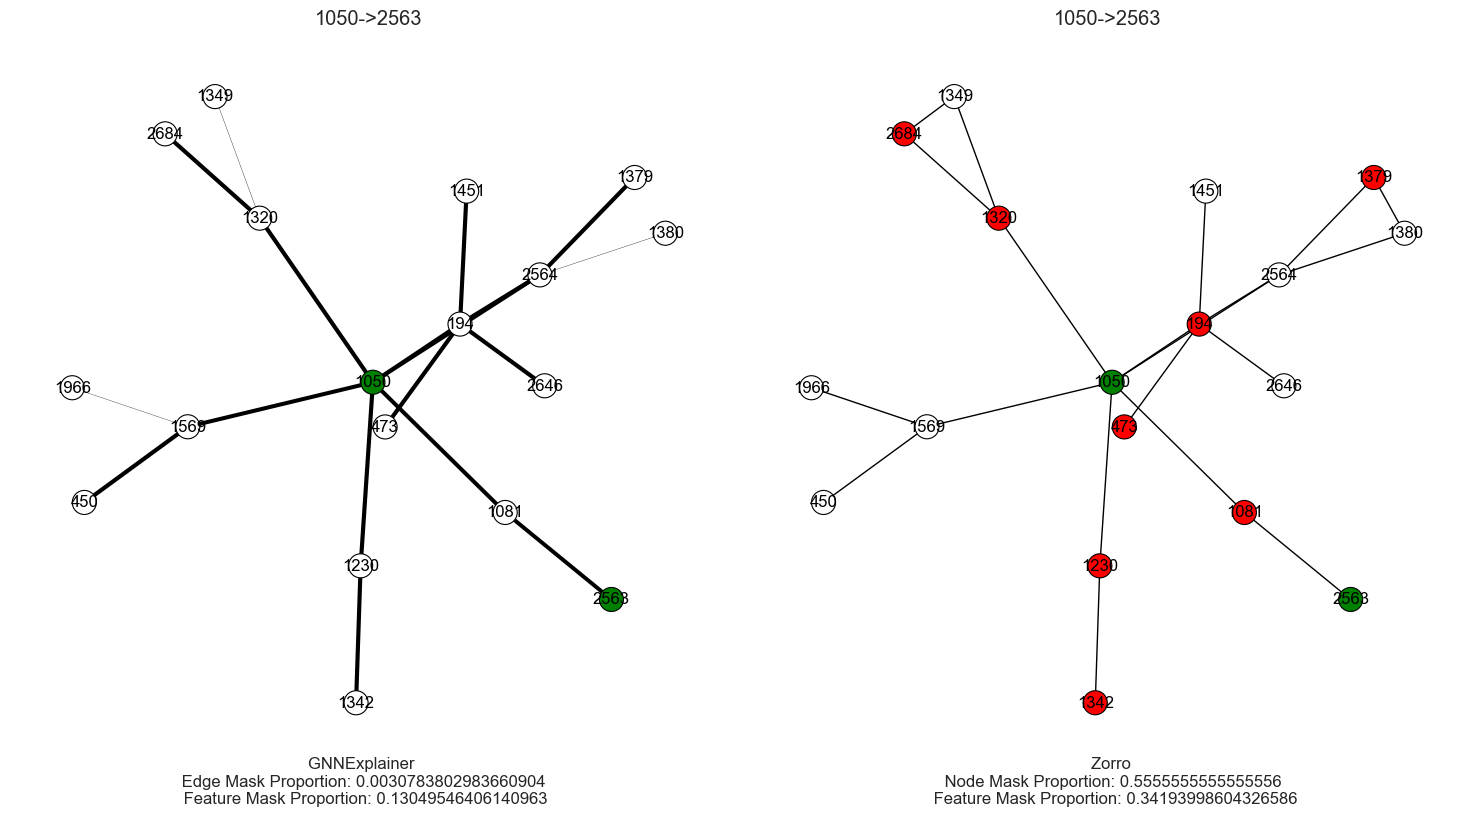

INFO:explainer:------ Start explaining edge tensor([[ 857],
        [1097]])


Generating explanations for No.890 edge in the test data.
Source node 857, Target Node: 1097
target:  1.0
pred:  0.5915665030479431
num_hops:  2



  0%|                                                                          | 0/32959 [00:00<?, ?it/s]
Explain edge tensor([[ 857],
        [1097]]):   0%|                           | 0/32959 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[ 857],
        [1097]])


initial_distortion:  0.7
num_hops:  2




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 1/32959 [00:01<15:45:59,  1.72s/it]

node_masks:  tensor([[1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
         1., 1., 1., 1., 1.]])
best_node:  13
impove_in_distortion_by_node:  0.12
best_feature:  1254
impove_in_distortion_by_feature:  0.07000000000000006
count:  1
0.7
[13, nan, 0.7]
num_to_add_once:  10


Argmax [1254, 19, 1257, 384, 1305, 3, 54, 140, 163, 283], 0.09000000000000008:  10%| | 3/30 [00:00<00:01,


distortion_improve:  0.09000000000000008
distortion_improve:  0.07000000000000006
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -100
best_feature:  [1254, 19, 1257, 384, 1305, 3, 54, 140, 163, 283]
impove_in_distortion_by_feature:  0.09000000000000008



Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 2/32959 [00:02<8:15:27,  1.11it/s]

count:  2
0.79
[nan, [1254, 19, 1257, 384, 1305, 3, 54, 140, 163, 283], 0.79]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [2, 12], 0.029999999999999916:  29%|█████████▏                      | 2/7 [00:00<00:00, 15.07it/s]

distortion_improve:  0.029999999999999916
distortion_improve:  0.010000000000000009
distortion_improve:  0.020000000000000018


Argmax [2, 12], 0.029999999999999916:  57%|██████████████████▎             | 4/7 [00:00<00:00, 15.11it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [305, 313, 422, 575, 677, 693, 763, 808, 840, 1025], 0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  0.029999999999999916
distortion_improve:  0.010000000000000009


Argmax [305, 313, 422, 575, 677, 693, 763, 808, 840, 1025], 0.029999999999999916:  10%| | 3/30 [00:00<00:

distortion_improve:  0.0
best_node:  [2, 12]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  [305, 313, 422, 575, 677, 693, 763, 808, 840, 1025]
impove_in_distortion_by_feature:  0.029999999999999916




Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 3/32959 [00:02<7:02:02,  1.30it/s]

count:  3
0.82
[nan, [305, 313, 422, 575, 677, 693, 763, 808, 840, 1025], 0.82]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [2, 12], 0.020000000000000018:  29%|█████████▏                      | 2/7 [00:00<00:00, 14.47it/s]

distortion_improve:  0.020000000000000018
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0


Argmax [2, 12], 0.020000000000000018:  57%|██████████████████▎             | 4/7 [00:00<00:00, 14.41it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [1218, 1247, 1332, 1413, 1, 17, 25, 57, 110, 111], 0.0:   0%|              | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [154, 171, 190, 215, 216, 263, 308, 335, 368, 381], 0.010000000000000009:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.010000000000000009


Argmax [154, 171, 190, 215, 216, 263, 308, 335, 368, 381], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  [2, 12]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [154, 171, 190, 215, 216, 263, 308, 335, 368, 381]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 4/32959 [00:03<6:47:15,  1.35it/s]

count:  4
0.84
[[2, 12], nan, 0.84]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [6, 11], 0.050000000000000044:  40%|████████████▊                   | 2/5 [00:00<00:00, 13.25it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.050000000000000044


Argmax [6, 11], 0.050000000000000044:  60%|███████████████████▏            | 3/5 [00:00<00:00, 13.35it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [154, 171, 190, 215, 216, 263, 308, 335, 368, 381], 0.020000000000000018:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.010000000000000009
distortion_improve:  0.020000000000000018


Argmax [154, 171, 190, 215, 216, 263, 308, 335, 368, 381], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.0
best_node:  [6, 11]
impove_in_distortion_by_node:  0.050000000000000044
best_feature:  [154, 171, 190, 215, 216, 263, 308, 335, 368, 381]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 5/32959 [00:03<6:14:34,  1.47it/s]

count:  5
0.89
[[6, 11], nan, 0.89]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.030000000000000027:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 14.14it/s]


distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
num_to_add_once:  10


Argmax [1218, 1247, 1332, 1413, 1, 17, 25, 57, 110, 111], -0.010000000000000009:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.010000000000000009


Argmax [393, 395, 401, 414, 474, 479, 498, 532, 563, 573], 0.030000000000000027:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
distortion_improve:  0.030000000000000027
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.030000000000000027
best_feature:  [393, 395, 401, 414, 474, 479, 498, 532, 563, 573]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 6/32959 [00:04<5:44:54,  1.59it/s]

count:  6
0.92
[nan, [393, 395, 401, 414, 474, 479, 498, 532, 563, 573], 0.92]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.030000000000000027:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 14.46it/s]


distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027
num_to_add_once:  10


Argmax [1218, 1247, 1332, 1413, 1, 17, 25, 57, 110, 111], -0.020000000000000018:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.020000000000000018


Argmax [154, 171, 190, 215, 216, 263, 308, 335, 368, 381], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.08it/s]

distortion_improve:  0.0
distortion_improve:  -0.030000000000000027
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.030000000000000027
best_feature:  [154, 171, 190, 215, 216, 263, 308, 335, 368, 381]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 7/32959 [00:04<5:20:42,  1.71it/s]

count:  7
0.92
[nan, [154, 171, 190, 215, 216, 263, 308, 335, 368, 381], 0.92]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 14.50it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1218, 1247, 1332, 1413, 1, 17, 25, 57, 110, 111], -0.010000000000000009:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.010000000000000009


Argmax [1218, 1247, 1332, 1413, 1, 17, 25, 57, 110, 111], -0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1218, 1247, 1332, 1413, 1, 17, 25, 57, 110, 111]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [1218, 1247, 1332, 1413, 1, 17, 25, 57, 110, 111]




Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 8/32959 [00:05<4:54:19,  1.87it/s]

count:  8
0.92
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 13.65it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [597, 604, 606, 617, 694, 699, 723, 740, 743, 750], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [597, 604, 606, 617, 694, 699, 723, 740, 743, 750], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [597, 604, 606, 617, 694, 699, 723, 740, 743, 750]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [597, 604, 606, 617, 694, 699, 723, 740, 743, 750]




Explain edge tensor([[ 857],
        [1097]]):   0%|                 | 9/32959 [00:05<4:38:27,  1.97it/s]

count:  9
0.92
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 13.55it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [1175, 1176, 1180, 1193, 1222, 1246, 1263, 1267, 1279, 1280], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1175, 1176, 1180, 1193, 1222, 1246, 1263, 1267, 1279, 1280]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [1175, 1176, 1180, 1193, 1222, 1246, 1263, 1267, 1279, 1280]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 10/32959 [00:06<4:28:06,  2.05it/s]

count:  10
0.92
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 14.12it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [1282, 1308, 1320, 1336, 1360, 1364, 1380, 1389, 1411, 1415], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.050000000000000044
distortion_improve:  0.010000000000000009
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1282, 1308, 1320, 1336, 1360, 1364, 1380, 1389, 1411, 1415]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 11/32959 [00:06<4:39:39,  1.96it/s]

count:  11
0.93
[nan, [1282, 1308, 1320, 1336, 1360, 1364, 1380, 1389, 1411, 1415], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.020000000000000018:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 14.56it/s]


distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044


Argmax [1417, 1431, 4, 5, 6, 7, 9, 10, 11, 12], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 14.88it

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 12/32959 [00:07<4:23:08,  2.09it/s]

distortion_improve:  -0.010000000000000009
best_node:  [15]
impove_in_distortion_by_node:  -0.020000000000000018
best_feature:  [1417, 1431, 4, 5, 6, 7, 9, 10, 11, 12]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [1417, 1431, 4, 5, 6, 7, 9, 10, 11, 12]
count:  12
0.93
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.020000000000000018:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 15.80it/s]


distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044


Argmax [13, 14, 15, 16, 20, 21, 22, 24, 26, 27], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 15.56i

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 13/32959 [00:07<4:08:27,  2.21it/s]

distortion_improve:  -0.010000000000000009
best_node:  [15]
impove_in_distortion_by_node:  -0.020000000000000018
best_feature:  [13, 14, 15, 16, 20, 21, 22, 24, 26, 27]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [13, 14, 15, 16, 20, 21, 22, 24, 26, 27]
count:  13
0.93
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.020000000000000018:  33%|███████████▎                      | 1/3 [00:00<00:00,  7.68it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018


Argmax [15], -0.020000000000000018:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 15.22it/s]


num_to_add_once:  10


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044


Argmax [28, 29, 30, 31, 32, 33, 34, 36, 37, 41], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 14.18it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.020000000000000018
best_feature:  [28, 29, 30, 31, 32, 33, 34, 36, 37, 41]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 14/32959 [00:08<4:13:09,  2.17it/s]

count:  14
0.93
[nan, [28, 29, 30, 31, 32, 33, 34, 36, 37, 41], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.020000000000000018:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 15.42it/s]


distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.030000000000000027:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.040000000000000036


Argmax [42, 43, 45, 46, 47, 48, 49, 51, 53, 55], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 15.31it/s]


distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.020000000000000018
best_feature:  [42, 43, 45, 46, 47, 48, 49, 51, 53, 55]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 15/32959 [00:08<4:12:40,  2.17it/s]

count:  15
0.93
[nan, [42, 43, 45, 46, 47, 48, 49, 51, 53, 55], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.020000000000000018:   0%|                                        | 0/3 [00:00<?, ?it/s]

distortion_improve:  -0.020000000000000018


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 14.58it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [754, 775, 797, 816, 826, 833, 850, 877, 881, 921], -0.010000000000000009:  10%| | 3/30 [00:00<00:


distortion_improve:  -0.020000000000000018
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [754, 775, 797, 816, 826, 833, 850, 877, 881, 921]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [754, 775, 797, 816, 826, 833, 850, 877, 881, 921]



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 16/32959 [00:08<4:04:40,  2.24it/s]

count:  16
0.93
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.020000000000000018:   0%|                                        | 0/3 [00:00<?, ?it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 15.72it/s]


num_to_add_once:  10


Argmax [56, 58, 60, 61, 62, 63, 66, 67, 68, 70], -0.020000000000000018:   7%| | 2/30 [00:00<00:01, 15.09i

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018


Argmax [71, 72, 73, 74, 75, 76, 78, 79, 80, 82], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 14.77i

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 17/32959 [00:09<3:57:11,  2.31it/s]

distortion_improve:  -0.010000000000000009
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [71, 72, 73, 74, 75, 76, 78, 79, 80, 82]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [71, 72, 73, 74, 75, 76, 78, 79, 80, 82]
count:  17
0.93
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 15.20it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009


num_to_add_once:  10


Argmax [56, 58, 60, 61, 62, 63, 66, 67, 68, 70], -0.020000000000000018:   7%| | 2/30 [00:00<00:01, 15.65i

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018


Argmax [84, 85, 86, 90, 92, 94, 95, 100, 101, 102], 0.0:  10%|█▏          | 3/30 [00:00<00:01, 15.38it/s]


distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [84, 85, 86, 90, 92, 94, 95, 100, 101, 102]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 18/32959 [00:09<4:02:22,  2.27it/s]

count:  18
0.93
[nan, [84, 85, 86, 90, 92, 94, 95, 100, 101, 102], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.020000000000000018:   0%|                                        | 0/3 [00:00<?, ?it/s]

distortion_improve:  -0.020000000000000018


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 15.34it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [56, 58, 60, 61, 62, 63, 66, 67, 68, 70], -0.020000000000000018:   3%| | 1/30 [00:00<00:03,  7.50i

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.020000000000000018


Argmax [103, 104, 105, 106, 107, 108, 109, 112, 113, 114], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 19/32959 [00:10<3:56:20,  2.32it/s]

distortion_improve:  -0.010000000000000009
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [103, 104, 105, 106, 107, 108, 109, 112, 113, 114]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [103, 104, 105, 106, 107, 108, 109, 112, 113, 114]
count:  19
0.93
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.020000000000000018:   0%|                                        | 0/3 [00:00<?, ?it/s]

distortion_improve:  -0.020000000000000018


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 15.02it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [56, 58, 60, 61, 62, 63, 66, 67, 68, 70], -0.020000000000000018:   7%| | 2/30 [00:00<00:01, 15.03i

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.020000000000000018


Argmax [116, 117, 119, 120, 122, 123, 124, 128, 129, 137], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.73it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [116, 117, 119, 120, 122, 123, 124, 128, 129, 137]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 20/32959 [00:10<4:04:11,  2.25it/s]

count:  20
0.93
[nan, [116, 117, 119, 120, 122, 123, 124, 128, 129, 137], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.020000000000000018:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 14.68it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.06000000000000005:   0%| | 0/30 [00:

distortion_improve:  -0.06000000000000005


Argmax [138, 139, 141, 142, 143, 144, 146, 147, 148, 149], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.34it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.020000000000000018
best_feature:  [138, 139, 141, 142, 143, 144, 146, 147, 148, 149]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 21/32959 [00:11<4:10:09,  2.19it/s]

count:  21
0.93
[nan, [138, 139, 141, 142, 143, 144, 146, 147, 148, 149], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.020000000000000018:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 13.24it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.050000000000000044:   0%| | 0/30 [00

distortion_improve:  -0.050000000000000044


Argmax [152, 153, 155, 156, 158, 159, 160, 161, 162, 164], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.84it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.020000000000000018
best_feature:  [152, 153, 155, 156, 158, 159, 160, 161, 162, 164]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 22/32959 [00:11<4:16:23,  2.14it/s]

count:  22
0.93
[nan, [152, 153, 155, 156, 158, 159, 160, 161, 162, 164], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 14.93it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [56, 58, 60, 61, 62, 63, 66, 67, 68, 70], -0.010000000000000009:   7%| | 2/30 [00:00<00:01, 15.02i

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009


Argmax [165, 166, 167, 169, 170, 174, 175, 180, 181, 182], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.82it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [165, 166, 167, 169, 170, 174, 175, 180, 181, 182]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 23/32959 [00:12<4:19:28,  2.12it/s]

count:  23
0.93
[nan, [165, 166, 167, 169, 170, 174, 175, 180, 181, 182], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 14.11it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.030000000000000027:   0%| | 0/30 [00

distortion_improve:  -0.030000000000000027


Argmax [56, 58, 60, 61, 62, 63, 66, 67, 68, 70], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 14.21i

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [56, 58, 60, 61, 62, 63, 66, 67, 68, 70]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [56, 58, 60, 61, 62, 63, 66, 67, 68, 70]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 24/32959 [00:12<4:12:13,  2.18it/s]

count:  24
0.93
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.010000000000000009:  67%|██████████████████████▋           | 2/3 [00:00<00:00, 13.84it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.030000000000000027:   0%| | 0/30 [00

distortion_improve:  -0.030000000000000027


Argmax [199, 200, 202, 204, 206, 207, 208, 209, 213, 214], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
distortion_improve:  0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [199, 200, 202, 204, 206, 207, 208, 209, 213, 214]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 25/32959 [00:13<4:18:28,  2.12it/s]

count:  25
0.94
[nan, [199, 200, 202, 204, 206, 207, 208, 209, 213, 214], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.019999999999999907:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 14.10it/s]


distortion_improve:  -0.019999999999999907
distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [217, 218, 219, 220, 221, 222, 223, 224, 225, 226], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.93it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [217, 218, 219, 220, 221, 222, 223, 224, 225, 226]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 26/32959 [00:13<4:33:13,  2.01it/s]

count:  26
0.94
[nan, [217, 218, 219, 220, 221, 222, 223, 224, 225, 226], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.019999999999999907:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 14.07it/s]


distortion_improve:  -0.019999999999999907
distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [184, 185, 186, 188, 189, 191, 192, 194, 197, 198], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.019999999999999907
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [184, 185, 186, 188, 189, 191, 192, 194, 197, 198]
impove_in_distortion_by_feature:  -0.019999999999999907
Removing features:  [184, 185, 186, 188, 189, 191, 192, 194, 197, 198]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 27/32959 [00:14<4:21:51,  2.10it/s]

count:  27
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.019999999999999907:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 14.61it/s]


distortion_improve:  -0.019999999999999907
distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [241, 242, 243, 246, 248, 249, 251, 253, 254, 255], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [241, 242, 243, 246, 248, 249, 251, 253, 254, 255]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [241, 242, 243, 246, 248, 249, 251, 253, 254, 255]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 28/32959 [00:14<4:14:34,  2.16it/s]

count:  28
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.019999999999999907:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 13.08it/s]


distortion_improve:  -0.019999999999999907
distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [227, 229, 231, 232, 233, 235, 236, 238, 239, 240], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.019999999999999907
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [227, 229, 231, 232, 233, 235, 236, 238, 239, 240]
impove_in_distortion_by_feature:  -0.019999999999999907
Removing features:  [227, 229, 231, 232, 233, 235, 236, 238, 239, 240]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 29/32959 [00:14<4:11:58,  2.18it/s]

count:  29
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.019999999999999907:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 13.98it/s]


distortion_improve:  -0.019999999999999907
distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [268, 269, 270, 271, 272, 273, 274, 275, 277, 278], 0.0:  10%|▌    | 3/30 [00:00<00:01, 13.97it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [268, 269, 270, 271, 272, 273, 274, 275, 277, 278]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 30/32959 [00:15<4:19:38,  2.11it/s]

count:  30
0.94
[nan, [268, 269, 270, 271, 272, 273, 274, 275, 277, 278], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], 0.0:  67%|█████████████████████████████████▎                | 2/3 [00:00<00:00, 13.38it/s]


distortion_improve:  0.0
distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [279, 281, 282, 285, 287, 289, 290, 293, 294, 295], 0.0:  10%|▌    | 3/30 [00:00<00:02, 12.95it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
best_node:  [1, 3]
impove_in_distortion_by_node:  0.0
best_feature:  [279, 281, 282, 285, 287, 289, 290, 293, 294, 295]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 31/32959 [00:16<4:35:36,  1.99it/s]

count:  31
0.94
[nan, [279, 281, 282, 285, 287, 289, 290, 293, 294, 295], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], 0.0:  67%|█████████████████████████████████▎                | 2/3 [00:00<00:00, 14.01it/s]


distortion_improve:  0.0
distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [296, 298, 300, 301, 302, 303, 304, 307, 309, 310], 0.0:  10%|▌    | 3/30 [00:00<00:01, 13.59it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
best_node:  [1, 3]
impove_in_distortion_by_node:  0.0
best_feature:  [296, 298, 300, 301, 302, 303, 304, 307, 309, 310]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 32/32959 [00:16<4:37:51,  1.98it/s]

count:  32
0.94
[nan, [296, 298, 300, 301, 302, 303, 304, 307, 309, 310], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.009999999999999898:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 13.91it/s]


distortion_improve:  -0.009999999999999898
distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [311, 312, 314, 315, 316, 317, 318, 319, 321, 323], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 33/32959 [00:16<4:22:51,  2.09it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.009999999999999898
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [311, 312, 314, 315, 316, 317, 318, 319, 321, 323]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [311, 312, 314, 315, 316, 317, 318, 319, 321, 323]
count:  33
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], -0.009999999999999898:  67%|█████████████████████▎          | 2/3 [00:00<00:00, 14.86it/s]


distortion_improve:  -0.009999999999999898
distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.029999999999999916


Argmax [325, 326, 327, 328, 329, 331, 332, 334, 340, 341], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.78it/s]

distortion_improve:  0.0
best_node:  [1, 3]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [325, 326, 327, 328, 329, 331, 332, 334, 340, 341]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 34/32959 [00:17<4:22:03,  2.09it/s]

count:  34
0.94
[nan, [325, 326, 327, 328, 329, 331, 332, 334, 340, 341], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [1, 3], 0.0:   0%|                                                          | 0/3 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [1, 3], 0.0:  67%|█████████████████████████████████▎                | 2/3 [00:00<00:00, 14.99it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.009999999999999898:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [1, 3]
impove_in_distortion_by_node:  0.0
best_feature:  [257, 258, 259, 260, 261, 262, 264, 265, 266, 267]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 35/32959 [00:17<4:19:30,  2.11it/s]

count:  35
0.94
[[1, 3], nan, 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.97it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.029999999999999916:   0%| | 0/30 [00

distortion_improve:  -0.029999999999999916


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [342, 343, 344, 346, 347, 348, 349, 350, 351, 352], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 36/32959 [00:18<3:57:30,  2.31it/s]

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [342, 343, 344, 346, 347, 348, 349, 350, 351, 352]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [342, 343, 344, 346, 347, 348, 349, 350, 351, 352]
count:  36
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.029999999999999916:   0%| | 0/30 [00

distortion_improve:  -0.029999999999999916


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [354, 355, 356, 357, 358, 361, 362, 363, 364, 366], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [354, 355, 356, 357, 358, 361, 362, 363, 364, 366]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [354, 355, 356, 357, 358, 361, 362, 363, 364, 366]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 37/32959 [00:18<3:46:16,  2.43it/s]

count:  37
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.029999999999999916:   0%| | 0/30 [00

distortion_improve:  -0.029999999999999916


Argmax [367, 369, 372, 373, 374, 376, 377, 379, 380, 382], 0.0:   7%|▎    | 2/30 [00:00<00:01, 15.12it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0


Argmax [367, 369, 372, 373, 374, 376, 377, 379, 380, 382], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.23it/s]


best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [367, 369, 372, 373, 374, 376, 377, 379, 380, 382]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 38/32959 [00:19<3:45:05,  2.44it/s]

count:  38
0.94
[nan, [367, 369, 372, 373, 374, 376, 377, 379, 380, 382], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.81it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [383, 385, 386, 387, 388, 390, 391, 392, 394, 396], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.28it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0


best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [383, 385, 386, 387, 388, 390, 391, 392, 394, 396]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 39/32959 [00:19<3:43:19,  2.46it/s]

count:  39
0.94
[nan, [383, 385, 386, 387, 388, 390, 391, 392, 394, 396], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax None, -1000:   0%|                                                          | 0/1 [00:00<?, ?it/s]

distortion_improve:  -0.019999999999999907


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [397, 399, 400, 403, 404, 405, 406, 407, 408, 409], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.97it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [397, 399, 400, 403, 404, 405, 406, 407, 408, 409]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 40/32959 [00:19<3:43:24,  2.46it/s]

count:  40
0.94
[nan, [397, 399, 400, 403, 404, 405, 406, 407, 408, 409], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [410, 411, 412, 413, 415, 418, 419, 420, 423, 425], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.17it/s]


distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [410, 411, 412, 413, 415, 418, 419, 420, 423, 425]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 41/32959 [00:20<3:51:40,  2.37it/s]

count:  41
0.94
[nan, [410, 411, 412, 413, 415, 418, 419, 420, 423, 425], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.02it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [426, 427, 428, 429, 430, 431, 432, 433, 436, 437], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.55it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [426, 427, 428, 429, 430, 431, 432, 433, 436, 437]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 42/32959 [00:20<3:51:33,  2.37it/s]

count:  42
0.94
[nan, [426, 427, 428, 429, 430, 431, 432, 433, 436, 437], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.14it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [438, 441, 443, 444, 445, 446, 447, 449, 450, 451], -0.009999999999999898:  10%| | 3/30 [00:00<00:



distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [438, 441, 443, 444, 445, 446, 447, 449, 450, 451]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [438, 441, 443, 444, 445, 446, 447, 449, 450, 451]
count:  43
0.94
None


Explain edge tensor([[ 857],
        [1097]]):   0%|                | 43/32959 [00:21<3:39:18,  2.50it/s]



possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.92it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [452, 453, 457, 458, 459, 460, 461, 462, 463, 464], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [452, 453, 457, 458, 459, 460, 461, 462, 463, 464]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [452, 453, 457, 458, 459, 460, 461, 462, 463, 464]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 44/32959 [00:21<3:30:24,  2.61it/s]

count:  44
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [465, 466, 467, 468, 470, 473, 476, 478, 481, 482], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [465, 466, 467, 468, 470, 473, 476, 478, 481, 482]
impove_in_distortion_by_feature:  -0.019999999999999907
Removing features:  [465, 466, 467, 468, 470, 473, 476, 478, 481, 482]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 45/32959 [00:21<3:25:47,  2.67it/s]

count:  45
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.05it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [484, 485, 486, 487, 488, 489, 490, 492, 493, 496], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [484, 485, 486, 487, 488, 489, 490, 492, 493, 496]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [484, 485, 486, 487, 488, 489, 490, 492, 493, 496]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 46/32959 [00:22<3:25:34,  2.67it/s]

count:  46
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [497, 499, 500, 501, 503, 504, 505, 506, 507, 508], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [497, 499, 500, 501, 503, 504, 505, 506, 507, 508]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [497, 499, 500, 501, 503, 504, 505, 506, 507, 508]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 47/32959 [00:22<3:25:48,  2.67it/s]

count:  47
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.94it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [511, 512, 518, 519, 520, 521, 522, 523, 524, 526], 0.0:  10%|▌    | 3/30 [00:00<00:02, 13.44it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [511, 512, 518, 519, 520, 521, 522, 523, 524, 526]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 48/32959 [00:22<3:37:04,  2.53it/s]

count:  48
0.94
[nan, [511, 512, 518, 519, 520, 521, 522, 523, 524, 526], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [528, 529, 531, 533, 534, 535, 536, 541, 542, 543], 0.0:  10%|▌    | 3/30 [00:00<00:01, 13.71it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [528, 529, 531, 533, 534, 535, 536, 541, 542, 543]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 49/32959 [00:23<3:44:24,  2.44it/s]

count:  49
0.94
[nan, [528, 529, 531, 533, 534, 535, 536, 541, 542, 543], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.029999999999999916: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [544, 545, 546, 547, 549, 553, 554, 555, 556, 557], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.02it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [544, 545, 546, 547, 549, 553, 554, 555, 556, 557]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 50/32959 [00:23<3:48:48,  2.40it/s]

count:  50
0.94
[nan, [544, 545, 546, 547, 549, 553, 554, 555, 556, 557], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.06it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [561, 562, 564, 566, 567, 568, 569, 571, 572, 574], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [561, 562, 564, 566, 567, 568, 569, 571, 572, 574]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [561, 562, 564, 566, 567, 568, 569, 571, 572, 574]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 51/32959 [00:24<3:42:38,  2.46it/s]

count:  51
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.23it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [576, 577, 579, 580, 581, 582, 583, 585, 587, 589], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [576, 577, 579, 580, 581, 582, 583, 585, 587, 589]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [576, 577, 579, 580, 581, 582, 583, 585, 587, 589]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 52/32959 [00:24<3:38:07,  2.51it/s]

count:  52
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [590, 592, 593, 594, 595, 596, 598, 599, 601, 602], 0.0:  10%|▌    | 3/30 [00:00<00:01, 13.61it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [590, 592, 593, 594, 595, 596, 598, 599, 601, 602]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 53/32959 [00:25<3:44:52,  2.44it/s]

count:  53
0.94
[nan, [590, 592, 593, 594, 595, 596, 598, 599, 601, 602], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [603, 605, 607, 608, 609, 611, 613, 614, 616, 620], 0.0:  10%|▌    | 3/30 [00:00<00:02, 13.22it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [603, 605, 607, 608, 609, 611, 613, 614, 616, 620]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 54/32959 [00:25<3:53:12,  2.35it/s]

count:  54
0.94
[nan, [603, 605, 607, 608, 609, 611, 613, 614, 616, 620], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [622, 626, 628, 630, 631, 632, 633, 634, 635, 636], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [622, 626, 628, 630, 631, 632, 633, 634, 635, 636]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [622, 626, 628, 630, 631, 632, 633, 634, 635, 636]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 55/32959 [00:25<3:48:21,  2.40it/s]

count:  55
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [637, 638, 639, 641, 643, 649, 650, 651, 652, 653], 0.0:  10%|▌    | 3/30 [00:00<00:01, 13.67it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [637, 638, 639, 641, 643, 649, 650, 651, 652, 653]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 56/32959 [00:26<3:53:42,  2.35it/s]

count:  56
0.94
[nan, [637, 638, 639, 641, 643, 649, 650, 651, 652, 653], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [654, 655, 656, 657, 658, 659, 661, 662, 663, 664], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [654, 655, 656, 657, 658, 659, 661, 662, 663, 664]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [654, 655, 656, 657, 658, 659, 661, 662, 663, 664]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 57/32959 [00:26<3:45:01,  2.44it/s]

count:  57
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.90it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [665, 668, 669, 671, 672, 676, 678, 679, 680, 681], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [665, 668, 669, 671, 672, 676, 678, 679, 680, 681]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [665, 668, 669, 671, 672, 676, 678, 679, 680, 681]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 58/32959 [00:27<3:42:25,  2.47it/s]

count:  58
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [682, 683, 684, 685, 686, 688, 689, 690, 691, 695], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [682, 683, 684, 685, 686, 688, 689, 690, 691, 695]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [682, 683, 684, 685, 686, 688, 689, 690, 691, 695]
count:  59
0.94
None




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 59/32959 [00:27<3:32:06,  2.59it/s]



possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax None, -1000:   0%|                                                          | 0/1 [00:00<?, ?it/s]

distortion_improve:  -0.019999999999999907


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.99it/s]


num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [257, 258, 259, 260, 261, 262, 264, 265, 266, 267], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [257, 258, 259, 260, 261, 262, 264, 265, 266, 267]
impove_in_distortion_by_feature:  -0.019999999999999907
Removing features:  [257, 258, 259, 260, 261, 262, 264, 265, 266, 267]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 60/32959 [00:27<3:24:47,  2.68it/s]

count:  60
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.00it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [697, 703, 704, 705, 707, 708, 709, 710, 711, 712], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [713, 714, 715, 716, 717, 719, 720, 722, 724, 726], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 61/32959 [00:28<3:20:09,  2.74it/s]

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [713, 714, 715, 716, 717, 719, 720, 722, 724, 726]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [713, 714, 715, 716, 717, 719, 720, 722, 724, 726]
count:  61
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [697, 703, 704, 705, 707, 708, 709, 710, 711, 712], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.019999999999999907


Argmax [730, 731, 733, 736, 737, 739, 741, 742, 744, 745], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [730, 731, 733, 736, 737, 739, 741, 742, 744, 745]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [730, 731, 733, 736, 737, 739, 741, 742, 744, 745]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 62/32959 [00:28<3:17:02,  2.78it/s]

count:  62
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.98it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [697, 703, 704, 705, 707, 708, 709, 710, 711, 712], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [697, 703, 704, 705, 707, 708, 709, 710, 711, 712], -0.019999999999999907:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 63/32959 [00:28<3:13:59,  2.83it/s]

distortion_improve:  -0.019999999999999907
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [697, 703, 704, 705, 707, 708, 709, 710, 711, 712]
impove_in_distortion_by_feature:  -0.019999999999999907
Removing features:  [697, 703, 704, 705, 707, 708, 709, 710, 711, 712]
count:  63
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.12it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.019999999999999907


Argmax [762, 766, 767, 768, 769, 770, 771, 773, 776, 780], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 64/32959 [00:29<3:12:32,  2.85it/s]

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [762, 766, 767, 768, 769, 770, 771, 773, 776, 780]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [762, 766, 767, 768, 769, 770, 771, 773, 776, 780]
count:  64
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 11.86it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [781, 782, 784, 786, 787, 788, 789, 790, 793, 794], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [781, 782, 784, 786, 787, 788, 789, 790, 793, 794]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [781, 782, 784, 786, 787, 788, 789, 790, 793, 794]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 65/32959 [00:29<3:12:47,  2.84it/s]

count:  65
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.019999999999999907: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


distortion_improve:  -0.019999999999999907
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [795, 796, 798, 799, 800, 801, 802, 805, 806, 811], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.95it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.019999999999999907
best_feature:  [795, 796, 798, 799, 800, 801, 802, 805, 806, 811]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 66/32959 [00:29<3:21:56,  2.71it/s]

count:  66
0.94
[nan, [795, 796, 798, 799, 800, 801, 802, 805, 806, 811], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], 0.0: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [815, 817, 822, 823, 824, 829, 830, 831, 832, 835], 0.0:  10%|▌    | 3/30 [00:00<00:01, 14.97it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  0.0
best_feature:  [815, 817, 822, 823, 824, 829, 830, 831, 832, 835]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 67/32959 [00:30<3:29:24,  2.62it/s]

count:  67
0.94
[nan, [815, 817, 822, 823, 824, 829, 830, 831, 832, 835], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.62it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [836, 837, 838, 839, 841, 842, 843, 844, 845, 846], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [836, 837, 838, 839, 841, 842, 843, 844, 845, 846]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [836, 837, 838, 839, 841, 842, 843, 844, 845, 846]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 68/32959 [00:30<3:24:45,  2.68it/s]

count:  68
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [847, 848, 849, 851, 852, 853, 855, 856, 858, 860], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [847, 848, 849, 851, 852, 853, 855, 856, 858, 860]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [847, 848, 849, 851, 852, 853, 855, 856, 858, 860]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 69/32959 [00:31<3:23:28,  2.69it/s]

count:  69
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [861, 862, 863, 864, 865, 866, 867, 868, 869, 870], 0.0:  10%|▌    | 3/30 [00:00<00:02, 13.12it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [861, 862, 863, 864, 865, 866, 867, 868, 869, 870]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 70/32959 [00:31<3:36:28,  2.53it/s]

count:  70
0.94
[nan, [861, 862, 863, 864, 865, 866, 867, 868, 869, 870], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [871, 872, 873, 876, 878, 879, 880, 882, 883, 884], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [871, 872, 873, 876, 878, 879, 880, 882, 883, 884]
impove_in_distortion_by_feature:  -0.009999999999999898
Removing features:  [871, 872, 873, 876, 878, 879, 880, 882, 883, 884]




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 71/32959 [00:31<3:34:50,  2.55it/s]

count:  71
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [885, 886, 887, 888, 891, 892, 893, 895, 896, 897], 0.0:  10%|▌    | 3/30 [00:00<00:02, 13.15it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [885, 886, 887, 888, 891, 892, 893, 895, 896, 897]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 72/32959 [00:32<3:44:27,  2.44it/s]

count:  72
0.94
[nan, [885, 886, 887, 888, 891, 892, 893, 895, 896, 897], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], -0.009999999999999898: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


distortion_improve:  -0.009999999999999898
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [898, 899, 900, 901, 902, 904, 906, 907, 908, 909], 0.0:  10%|▌    | 3/30 [00:00<00:01, 13.98it/s]

distortion_improve:  0.0
best_node:  [15]
impove_in_distortion_by_node:  -0.009999999999999898
best_feature:  [898, 899, 900, 901, 902, 904, 906, 907, 908, 909]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 73/32959 [00:32<3:48:53,  2.39it/s]

count:  73
0.94
[nan, [898, 899, 900, 901, 902, 904, 906, 907, 908, 909], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2


Argmax [15], 0.0: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.029999999999999916:   0%| | 0/30 [00

distortion_improve:  -0.029999999999999916


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.019999999999999907:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.019999999999999907


Argmax [910, 913, 914, 916, 917, 918, 919, 920, 922, 927], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [15]
impove_in_distortion_by_node:  0.0
best_feature:  [910, 913, 914, 916, 917, 918, 919, 920, 922, 927]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 74/32959 [00:33<3:56:35,  2.32it/s]

count:  74
0.94
[[15], nan, 0.94]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.029999999999999916


Argmax [910, 913, 914, 916, 917, 918, 919, 920, 922, 927], -0.019999999999999907:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [910, 913, 914, 916, 917, 918, 919, 920, 922, 927]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 75/32959 [00:33<3:33:41,  2.56it/s]

count:  75
0.94
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.05999999999999994:   0%| | 0/30 [00:

distortion_improve:  -0.05999999999999994


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [928, 930, 932, 933, 934, 938, 939, 940, 941, 942], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [928, 930, 932, 933, 934, 938, 939, 940, 941, 942]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 76/32959 [00:33<3:36:42,  2.53it/s]

count:  76
0.95
[nan, [928, 930, 932, 933, 934, 938, 939, 940, 941, 942], 0.95]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.029999999999999916


Argmax [943, 944, 946, 947, 948, 949, 951, 952, 953, 954], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [943, 944, 946, 947, 948, 949, 951, 952, 953, 954]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 77/32959 [00:34<3:21:01,  2.73it/s]

count:  77
0.95
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.05999999999999994:   0%| | 0/30 [00:

distortion_improve:  -0.05999999999999994


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [956, 957, 958, 960, 961, 962, 964, 965, 966, 968], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [956, 957, 958, 960, 961, 962, 964, 965, 966, 968]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 78/32959 [00:34<3:10:20,  2.88it/s]

count:  78
0.95
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.05999999999999994:   0%| | 0/30 [00:

distortion_improve:  -0.05999999999999994


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [746, 747, 748, 749, 751, 752, 753, 756, 757, 760], -0.029999999999999916:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.039999999999999925
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [746, 747, 748, 749, 751, 752, 753, 756, 757, 760]
impove_in_distortion_by_feature:  -0.029999999999999916




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 79/32959 [00:34<3:01:09,  3.02it/s]

count:  79
0.95
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.05999999999999994:   0%| | 0/30 [00:

distortion_improve:  -0.05999999999999994


Argmax [970, 974, 976, 977, 978, 980, 981, 982, 983, 984], -0.039999999999999925:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.039999999999999925


Argmax [987, 988, 989, 990, 991, 992, 993, 994, 996, 997], 0.0:  10%|▌    | 3/30 [00:00<00:02, 13.39it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [987, 988, 989, 990, 991, 992, 993, 994, 996, 997]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 80/32959 [00:35<3:07:22,  2.92it/s]

count:  80
0.95
[nan, [987, 988, 989, 990, 991, 992, 993, 994, 996, 997], 0.95]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [970, 974, 976, 977, 978, 980, 981, 982, 983, 984], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.029999999999999916


Argmax [998, 999, 1000, 1002, 1003, 1004, 1006, 1007, 1008, 1009], -0.010000000000000009:  10%| | 3/30 [0

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [998, 999, 1000, 1002, 1003, 1004, 1006, 1007, 1008, 1009]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 81/32959 [00:35<3:00:43,  3.03it/s]

count:  81
0.95
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [970, 974, 976, 977, 978, 980, 981, 982, 983, 984], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [1010, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1020, 1023], -0.019999999999999907:  10%| | 3/30 

distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1010, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1020, 1023]
impove_in_distortion_by_feature:  -0.019999999999999907




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 82/32959 [00:35<2:58:13,  3.07it/s]

count:  82
0.95
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [970, 974, 976, 977, 978, 980, 981, 982, 983, 984], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [1026, 1028, 1029, 1030, 1031, 1032, 1034, 1038, 1039, 1040], 0.0:  10%| | 3/30 [00:00<00:01, 14.0

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1026, 1028, 1029, 1030, 1031, 1032, 1034, 1038, 1039, 1040]
impove_in_distortion_by_feature:  0.0


count:  83
0.95
[nan, [1026, 1028, 1029, 1030, 1031, 1032, 1034, 1038, 1039, 1040], 0.95]


Explain edge tensor([[ 857],
        [1097]]):   0%|                | 83/32959 [00:36<3:02:26,  3.00it/s]



possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [970, 974, 976, 977, 978, 980, 981, 982, 983, 984], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.029999999999999916


Argmax [970, 974, 976, 977, 978, 980, 981, 982, 983, 984], -0.029999999999999916:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 84/32959 [00:36<2:52:31,  3.18it/s]

distortion_improve:  -0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [970, 974, 976, 977, 978, 980, 981, 982, 983, 984]
impove_in_distortion_by_feature:  -0.029999999999999916
count:  84
0.95
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.029999999999999916:   7%| | 2/30 

distortion_improve:  -0.029999999999999916


Argmax [1055, 1056, 1057, 1058, 1061, 1062, 1063, 1065, 1067, 1069], 0.0:  10%| | 3/30 [00:00<00:01, 14.6

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1055, 1056, 1057, 1058, 1061, 1062, 1063, 1065, 1067, 1069]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 85/32959 [00:36<2:57:08,  3.09it/s]

count:  85
0.95
[nan, [1055, 1056, 1057, 1058, 1061, 1062, 1063, 1065, 1067, 1069], 0.95]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.019999999999999907:   7%| | 2/30 [00

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.039999999999999925


Argmax [1071, 1072, 1073, 1074, 1078, 1080, 1081, 1082, 1083, 1084], 0.010000000000000009:  10%| | 3/30 [


distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1071, 1072, 1073, 1074, 1078, 1080, 1081, 1082, 1083, 1084]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 86/32959 [00:37<2:58:54,  3.06it/s]

count:  86
0.96
[nan, [1071, 1072, 1073, 1074, 1078, 1080, 1081, 1082, 1083, 1084], 0.96]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.020000000000000018


Argmax [1085, 1086, 1088, 1089, 1090, 1091, 1092, 1095, 1096, 1098], -0.010000000000000009:  10%| | 3/30 

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 87/32959 [00:37<2:53:23,  3.16it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1085, 1086, 1088, 1089, 1090, 1091, 1092, 1095, 1096, 1098]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  87
0.96
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.04999999999999993:   0%| | 0/30 [00:

distortion_improve:  -0.04999999999999993


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.020000000000000018


Argmax [1099, 1100, 1101, 1102, 1103, 1104, 1106, 1107, 1108, 1109], 0.0:  10%| | 3/30 [00:00<00:01, 14.9

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1099, 1100, 1101, 1102, 1103, 1104, 1106, 1107, 1108, 1109]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 88/32959 [00:37<2:57:09,  3.09it/s]

count:  88
0.96
[nan, [1099, 1100, 1101, 1102, 1103, 1104, 1106, 1107, 1108, 1109], 0.96]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.020000000000000018


Argmax [1110, 1111, 1112, 1113, 1115, 1116, 1117, 1118, 1119, 1120], -0.010000000000000009:  10%| | 3/30 

Explain edge tensor([[ 857],
        [1097]]):   0%|                | 89/32959 [00:38<2:49:26,  3.23it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1110, 1111, 1112, 1113, 1115, 1116, 1117, 1118, 1119, 1120]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  89
0.96
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.039999999999999925:   0%| | 0/30 [00

distortion_improve:  -0.039999999999999925


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.020000000000000018


Argmax [1121, 1122, 1124, 1126, 1127, 1128, 1130, 1132, 1133, 1134], 0.0:  10%| | 3/30 [00:00<00:01, 15.2


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1121, 1122, 1124, 1126, 1127, 1128, 1130, 1132, 1133, 1134]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 90/32959 [00:38<3:00:23,  3.04it/s]

count:  90
0.96
[nan, [1121, 1122, 1124, 1126, 1127, 1128, 1130, 1132, 1133, 1134], 0.96]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.020000000000000018:   7%| | 2/30 [00

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018


Argmax [1135, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1135, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 91/32959 [00:38<3:02:09,  3.01it/s]

count:  91
0.97
[nan, [1135, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174], -0.030000000000000027:  10%| | 3/30 [00

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.039999999999999925
distortion_improve:  -0.05999999999999994




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 92/32959 [00:39<2:51:26,  3.20it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [925, 967, 972, 1027, 1035, 1075, 1105, 1125, 1159, 1174]
impove_in_distortion_by_feature:  -0.030000000000000027
count:  92
0.97
None


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.039999999999999925:   0%| | 0/30 

distortion_improve:  -0.039999999999999925


Argmax [1161, 1163, 1167, 1168, 1169, 1173, 1178, 1181, 1182, 1185], 0.0:  10%| | 3/30 [00:00<00:01, 14.9

distortion_improve:  -0.05999999999999994
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1161, 1163, 1167, 1168, 1169, 1173, 1178, 1181, 1182, 1185]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 93/32959 [00:39<2:55:49,  3.12it/s]

count:  93
0.97
[nan, [1161, 1163, 1167, 1168, 1169, 1173, 1178, 1181, 1182, 1185], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.04999999999999993:   7%| | 2/30 [

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.04999999999999993


Argmax [1186, 1188, 1191, 1192, 1195, 1196, 1197, 1199, 1200, 1201], 0.0:  10%| | 3/30 [00:00<00:01, 15.1


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1186, 1188, 1191, 1192, 1195, 1196, 1197, 1199, 1200, 1201]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 94/32959 [00:39<2:58:23,  3.07it/s]

count:  94
0.97
[nan, [1186, 1188, 1191, 1192, 1195, 1196, 1197, 1199, 1200, 1201], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1204, 1205, 1207, 1210, 1211, 1212, 1214, 1215, 1216, 1217], 0.0:  10%| | 3/30 [00:00<00:01, 15.4

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.04999999999999993
distortion_improve:  0.0


best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1204, 1205, 1207, 1210, 1211, 1212, 1214, 1215, 1216, 1217]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 857],
        [1097]]):   0%|                | 95/32959 [00:40<3:00:00,  3.04it/s]

count:  95
0.97
[nan, [1204, 1205, 1207, 1210, 1211, 1212, 1214, 1215, 1216, 1217], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.039999999999999925


Argmax [1219, 1220, 1221, 1223, 1225, 1227, 1228, 1230, 1232, 1237], 0.0:  10%| | 3/30 [00:00<00:02, 12.3

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1219, 1220, 1221, 1223, 1225, 1227, 1228, 1230, 1232, 1237]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 96/32959 [00:40<3:09:41,  2.89it/s]

count:  96
0.97
[nan, [1219, 1220, 1221, 1223, 1225, 1227, 1228, 1230, 1232, 1237], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.039999999999999925


Argmax [1239, 1240, 1241, 1243, 1244, 1245, 1248, 1250, 1252, 1256], 0.0:  10%| | 3/30 [00:00<00:02, 13.2

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1239, 1240, 1241, 1243, 1244, 1245, 1248, 1250, 1252, 1256]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 97/32959 [00:40<3:15:28,  2.80it/s]

count:  97
0.97
[nan, [1239, 1240, 1241, 1243, 1244, 1245, 1248, 1250, 1252, 1256], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.030000000000000027


Argmax [1260, 1264, 1265, 1268, 1269, 1270, 1271, 1273, 1274, 1275], 0.0:  10%| | 3/30 [00:00<00:02, 13.4

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1260, 1264, 1265, 1268, 1269, 1270, 1271, 1273, 1274, 1275]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 98/32959 [00:41<3:17:51,  2.77it/s]

count:  98
0.97
[nan, [1260, 1264, 1265, 1268, 1269, 1270, 1271, 1273, 1274, 1275], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.030000000000000027:   7%| | 2/30 

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.039999999999999925


Argmax [1276, 1277, 1278, 1284, 1285, 1286, 1288, 1293, 1294, 1296], 0.0:  10%| | 3/30 [00:00<00:02, 13.4

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1276, 1277, 1278, 1284, 1285, 1286, 1288, 1293, 1294, 1296]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
        [1097]]):   0%|                | 99/32959 [00:41<3:19:28,  2.75it/s]

count:  99
0.97
[nan, [1276, 1277, 1278, 1284, 1285, 1286, 1288, 1293, 1294, 1296], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1042, 1043, 1044, 1046, 1047, 1048, 1049, 1051, 1053, 1054], -0.030000000000000027:   7%| | 2/30 

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.030000000000000027


Argmax [1297, 1298, 1300, 1302, 1303, 1304, 1306, 1307, 1309, 1310], 0.0:  10%| | 3/30 [00:00<00:01, 13.8

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1297, 1298, 1300, 1302, 1303, 1304, 1306, 1307, 1309, 1310]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 857],
Explain edge tensor([[ 857],          | 100/32959 [00:41<3:20:14,  2.73it/s]
        [1097]]):   0%|               | 100/32959 [00:41<3:49:36,  2.39it/s]
INFO:explainer:------ Finished explaining edge tensor([[ 857],
        [1097]])


count:  100
0.97
[nan, [1297, 1298, 1300, 1302, 1303, 1304, 1306, 1307, 1309, 1310], 0.97]
[(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.7], [13, nan, 0.7], [nan, [1254, 19, 1257, 384, 1305, 3, 54, 140, 163, 283], 0.79], [nan, [305, 313, 422, 575, 677, 693, 763, 808, 840, 1025], 0.82], [[2, 12], nan, 0.84], [[6, 11], nan, 0.89], [nan, [393, 395, 401, 414, 474, 479, 498, 532, 563, 573], 0.92], [nan, [154, 171, 190, 215, 216, 263, 308, 335, 368, 381], 0.92], None, None, None, [nan, [1282, 1308, 1320, 1336, 1360, 1364, 1380, 1389, 1411, 1415], 0.93], None, None, [nan, [28, 29, 30, 31, 32, 33, 34, 36, 37, 41], 0.93], [nan, [42, 43, 45, 46, 47, 48, 49, 51, 53, 55], 0.93], None, None, [nan, [84, 85, 86, 90, 92, 94, 95, 100, 101, 102], 0.93], None, [nan, [116, 117, 119, 120, 122, 123, 124, 128, 129, 137], 0.93], [nan, [138, 139, 141, 142, 143, 

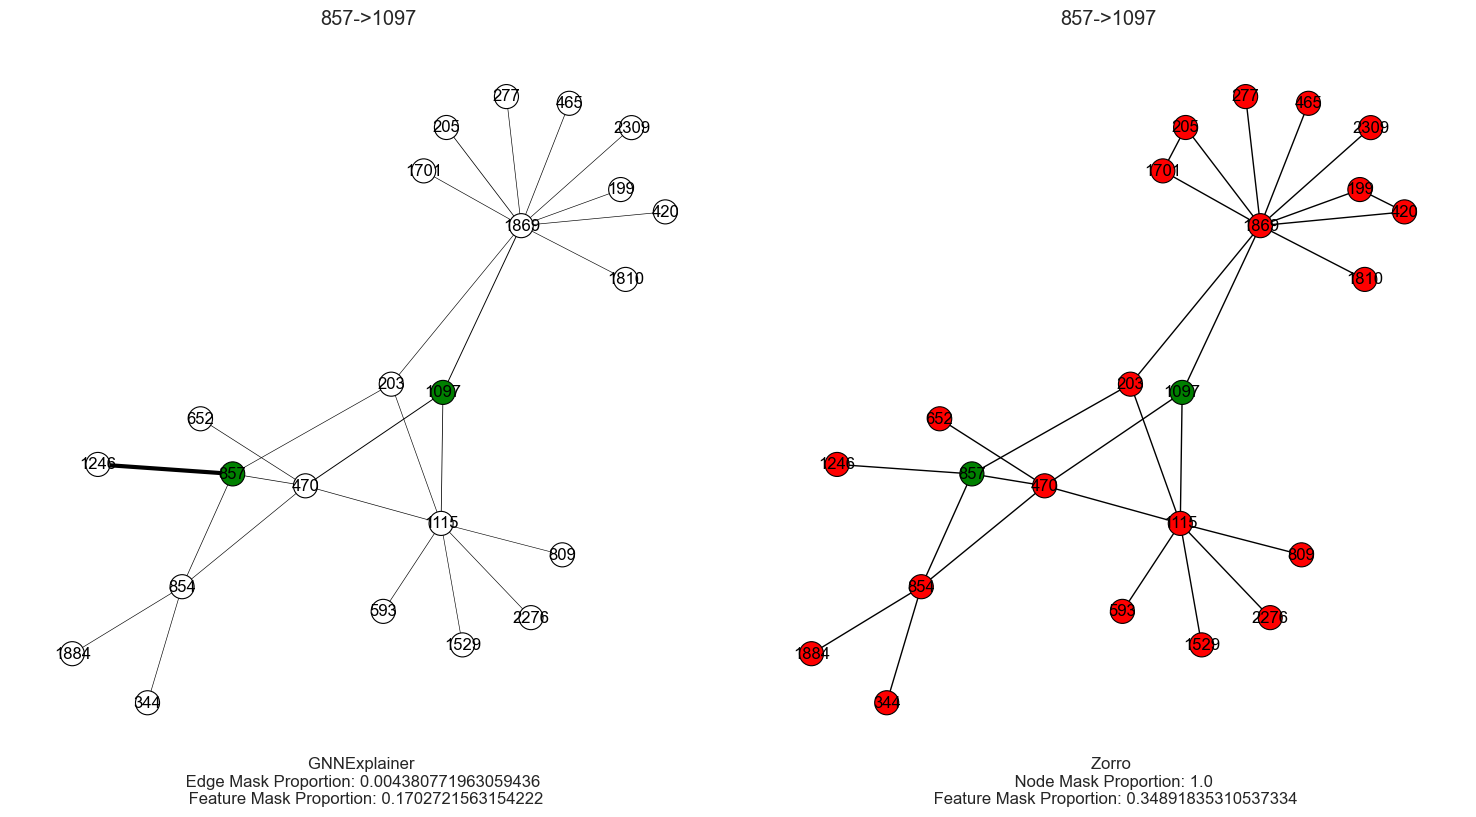

INFO:explainer:------ Start explaining edge tensor([[ 901],
        [2199]])


Generating explanations for No.351 edge in the test data.
Source node 901, Target Node: 2199
target:  1.0
pred:  0.62110435962677
num_hops:  2



  0%|                                                                          | 0/75949 [00:00<?, ?it/s]
Explain edge tensor([[ 901],
        [2199]]):   0%|                           | 0/75949 [00:00<?, ?it/s]

initial_distortion:  0.55
num_hops:  2


INFO:explainer:------ Start explaining edge tensor([[ 901],
        [2199]])


INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[ 901],
        [2199]])


node_masks:  tensor([[0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])
best_node:  46
impove_in_distortion_by_node:  0.08999999999999997
best_feature:  1263
impove_in_distortion_by_feature:  0.08999999999999997



Explain edge tensor([[ 901],
        [2199]]):   0%|                | 1/75949 [00:02<47:04:42,  2.23s/it]

count:  1
0.54
[nan, 1263, 0.54]
num_to_add_once:  2


Argmax [33, 14], 0.010000000000000009:  20%|██████                        | 2/10 [00:00<00:00, 10.29it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [33, 14], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00, 10.34it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  [33, 14]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  None
impove_in_distortion_by_feature:  -100




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 2/75949 [00:02<27:52:22,  1.32s/it]

count:  2
0.55
[[33, 14], nan, 0.55]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:00,  9.76it/s]

distortion_improve:  -0.010000000000000009


Argmax [3, 4], 0.0:  20%|█████████▊                                       | 2/10 [00:00<00:00,  9.84it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [3, 4], 0.0:  40%|███████████████████▌                             | 4/10 [00:00<00:00, 10.13it/s]

distortion_improve:  -0.010000000000000009


Argmax [3, 4], 0.0:  50%|████████████████████████▌                        | 5/10 [00:00<00:00,  9.99it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [921, 121, 348, 367, 597, 718, 724, 777, 903, 993], 0.05999999999999994:   3%| | 1/30 [00:00<00:03

distortion_improve:  0.05999999999999994


Argmax [921, 121, 348, 367, 597, 718, 724, 777, 903, 993], 0.05999999999999994:   7%| | 2/30 [00:00<00:02

distortion_improve:  0.019999999999999907


Argmax [921, 121, 348, 367, 597, 718, 724, 777, 903, 993], 0.05999999999999994:  10%| | 3/30 [00:00<00:02

distortion_improve:  0.0
best_node:  [3, 4]
impove_in_distortion_by_node:  0.0
best_feature:  [921, 121, 348, 367, 597, 718, 724, 777, 903, 993]
impove_in_distortion_by_feature:  0.05999999999999994




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 3/75949 [00:04<25:37:48,  1.21s/it]

count:  3
0.61
[nan, [921, 121, 348, 367, 597, 718, 724, 777, 903, 993], 0.61]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:00,  9.81it/s]

distortion_improve:  -0.010000000000000009


Argmax [3, 4], 0.0:  20%|█████████▊                                       | 2/10 [00:00<00:00,  9.82it/s]

distortion_improve:  0.0


Argmax [3, 4], 0.0:  40%|███████████████████▌                             | 4/10 [00:00<00:00, 10.15it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [3, 4], 0.0:  50%|████████████████████████▌                        | 5/10 [00:00<00:00, 10.09it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], 0.010000000000000009:   3%| | 1/30 [00:00<00:02,  9.6

distortion_improve:  0.010000000000000009


Argmax [82, 83, 97, 140, 149, 168, 185, 187, 194, 204], 0.030000000000000027:  10%| | 3/30 [00:00<00:02, 

distortion_improve:  0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  [3, 4]
impove_in_distortion_by_node:  0.0
best_feature:  [82, 83, 97, 140, 149, 168, 185, 187, 194, 204]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 4/75949 [00:04<23:48:12,  1.13s/it]

count:  4
0.64
[nan, [82, 83, 97, 140, 149, 168, 185, 187, 194, 204], 0.64]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], -0.020000000000000018:  10%|██▉                          | 1/10 [00:00<00:00,  9.19it/s]

distortion_improve:  -0.020000000000000018


Argmax [3, 4], -0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00,  9.15it/s]

distortion_improve:  -0.010000000000000009


Argmax [10, 13], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  9.22it/s]

distortion_improve:  0.0


Argmax [10, 13], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  9.35it/s]

distortion_improve:  -0.010000000000000009


Argmax [10, 13], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  9.36it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], -0.020000000000000018:   3%| | 1/30 [00:00<00:02,  9.

distortion_improve:  -0.020000000000000018


Argmax [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], -0.020000000000000018:   7%| | 2/30 [00:00<00:02,  9.

distortion_improve:  -0.020000000000000018


Argmax [368, 370, 379, 384, 398, 421, 422, 429, 436, 438], 0.05999999999999994:  10%| | 3/30 [00:00<00:02

distortion_improve:  0.05999999999999994
best_node:  [10, 13]
impove_in_distortion_by_node:  0.0
best_feature:  [368, 370, 379, 384, 398, 421, 422, 429, 436, 438]
impove_in_distortion_by_feature:  0.05999999999999994




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 5/75949 [00:06<23:09:42,  1.10s/it]

count:  5
0.7
[nan, [368, 370, 379, 384, 398, 421, 422, 429, 436, 438], 0.7]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], 0.0:  10%|████▋                                          | 1/10 [00:00<00:00,  9.77it/s]

distortion_improve:  0.0


Argmax [29, 51], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00,  9.82it/s]

distortion_improve:  0.0


Argmax [29, 51], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  9.68it/s]

distortion_improve:  0.0


Argmax [29, 51], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  9.72it/s]

distortion_improve:  0.0


Argmax [29, 51], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  9.75it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], -0.010000000000000009:   3%| | 1/30 [00:00<00:02,  9.

distortion_improve:  -0.010000000000000009


Argmax [451, 455, 461, 474, 495, 509, 538, 543, 550, 552], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.05it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  [29, 51]
impove_in_distortion_by_node:  0.0
best_feature:  [451, 455, 461, 474, 495, 509, 538, 543, 550, 552]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 6/75949 [00:07<22:28:29,  1.07s/it]

count:  6
0.7
[nan, [451, 455, 461, 474, 495, 509, 538, 543, 550, 552], 0.7]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 11.10it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [29, 51], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 11.15it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], 0.0:   0%|                    | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], 0.0:  10%|█▏          | 3/30 [00:00<00:02, 10.39it/s]

distortion_improve:  0.0
distortion_improve:  0.0
best_node:  [29, 51]
impove_in_distortion_by_node:  0.0
best_feature:  [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 7/75949 [00:07<21:28:10,  1.02s/it]

count:  7
0.7
[nan, [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], 0.7]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:00, 10.79it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [10, 13], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.79it/s]

distortion_improve:  0.0


Argmax [10, 13], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.94it/s]


distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [207, 248, 262, 287, 325, 338, 345, 358, 359, 365], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [207, 248, 262, 287, 325, 338, 345, 358, 359, 365], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.79it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.019999999999999907
best_node:  [10, 13]
impove_in_distortion_by_node:  0.0
best_feature:  [207, 248, 262, 287, 325, 338, 345, 358, 359, 365]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 8/75949 [00:08<20:48:12,  1.01it/s]

count:  8
0.7
[nan, [207, 248, 262, 287, 325, 338, 345, 358, 359, 365], 0.7]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.86it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [29, 51], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.87it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.019999999999999907:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.019999999999999907


Argmax [764, 770, 771, 773, 782, 807, 817, 820, 831, 838], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.85it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
best_node:  [29, 51]
impove_in_distortion_by_node:  0.0
best_feature:  [764, 770, 771, 773, 782, 807, 817, 820, 831, 838]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 9/75949 [00:09<20:38:02,  1.02it/s]

count:  9
0.7
[nan, [764, 770, 771, 773, 782, 807, 817, 820, 831, 838], 0.7]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.85it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [29, 51], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.64it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [843, 857, 859, 860, 865, 876, 893, 906, 924, 933], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.0
distortion_improve:  0.010000000000000009
best_node:  [29, 51]
impove_in_distortion_by_node:  0.0
best_feature:  [843, 857, 859, 860, 865, 876, 893, 906, 924, 933]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 10/75949 [00:10<20:20:18,  1.04it/s]

count:  10
0.71
[nan, [843, 857, 859, 860, 865, 876, 893, 906, 924, 933], 0.71]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [3, 4], 0.0:  20%|█████████▊                                       | 2/10 [00:00<00:00, 11.00it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [3, 4], 0.0:  50%|████████████████████████▌                        | 5/10 [00:00<00:00, 11.00it/s]


distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [685, 694, 722, 728, 732, 747, 750, 751, 752, 759], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.86it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  [3, 4]
impove_in_distortion_by_node:  0.0
best_feature:  [685, 694, 722, 728, 732, 747, 750, 751, 752, 759]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 11/75949 [00:11<20:07:18,  1.05it/s]

count:  11
0.71
[nan, [685, 694, 722, 728, 732, 747, 750, 751, 752, 759], 0.71]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:00,  9.88it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [29, 51], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00, 10.35it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [29, 51], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00,  9.11it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [949, 971, 976, 1004, 1005, 1019, 1042, 1044, 1054, 1061], -0.010000000000000009:   7%| | 2/30 [00

distortion_improve:  -0.010000000000000009


Argmax [949, 971, 976, 1004, 1005, 1019, 1042, 1044, 1054, 1061], -0.010000000000000009:  10%| | 3/30 [00

distortion_improve:  -0.010000000000000009
best_node:  [29, 51]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [949, 971, 976, 1004, 1005, 1019, 1042, 1044, 1054, 1061]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [949, 971, 976, 1004, 1005, 1019, 1042, 1044, 1054, 1061]




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 12/75949 [00:12<20:15:36,  1.04it/s]

count:  12
0.71
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:01,  6.19it/s]

distortion_improve:  -0.010000000000000009


Argmax [29, 51], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:01,  7.87it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [29, 51], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00,  9.23it/s]

distortion_improve:  -0.010000000000000009


Argmax [29, 51], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00,  8.94it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], -0.010000000000000009:   7%| | 2/30 

distortion_improve:  -0.010000000000000009


Argmax [1174, 1175, 1184, 1208, 1215, 1245, 1248, 1254, 1259, 1262], 0.0:  10%| | 3/30 [00:00<00:03,  7.7

distortion_improve:  0.0
best_node:  [29, 51]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1174, 1175, 1184, 1208, 1215, 1245, 1248, 1254, 1259, 1262]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 13/75949 [00:13<21:28:18,  1.02s/it]

count:  13
0.71
[nan, [1174, 1175, 1184, 1208, 1215, 1245, 1248, 1254, 1259, 1262], 0.71]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], 0.010000000000000009:  10%|███                           | 1/10 [00:00<00:00,  9.90it/s]

distortion_improve:  0.010000000000000009


Argmax [29, 51], 0.010000000000000009:  30%|█████████                     | 3/10 [00:00<00:00, 10.09it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.010000000000000009
distortion_improve:  0.0


Argmax [29, 51], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00, 10.12it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax None, -1000:   0%|                                                         | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], 0.0:   7%|▎    | 2/30 [00:00<00:02,  9.89it/s]

distortion_improve:  -0.020000000000000018


Argmax [1271, 1274, 1285, 1289, 1314, 1321, 1325, 1330, 1341, 1343], 0.020000000000000018:  10%| | 3/30 [

distortion_improve:  0.020000000000000018
best_node:  [29, 51]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1271, 1274, 1285, 1289, 1314, 1321, 1325, 1330, 1341, 1343]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 14/75949 [00:14<21:21:02,  1.01s/it]

count:  14
0.73
[nan, [1271, 1274, 1285, 1289, 1314, 1321, 1325, 1330, 1341, 1343], 0.73]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [29, 51], 0.010000000000000009:   0%|                                      | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.010000000000000009


Argmax [29, 51], 0.010000000000000009:  20%|██████                        | 2/10 [00:00<00:00,  9.88it/s]

distortion_improve:  0.010000000000000009


Argmax [29, 51], 0.010000000000000009:  30%|█████████                     | 3/10 [00:00<00:00,  9.83it/s]

distortion_improve:  -0.010000000000000009


Argmax [29, 51], 0.010000000000000009:  40%|████████████                  | 4/10 [00:00<00:00,  9.79it/s]

distortion_improve:  0.0


Argmax [29, 51], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00,  9.81it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], 0.0:  10%| | 3/30 [00:00<00:02,  9.95it

distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
best_node:  [29, 51]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 15/75949 [00:15<21:12:56,  1.01s/it]

count:  15
0.74
[[29, 51], nan, 0.74]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [3, 4], 0.0:  20%|█████████▊                                       | 2/10 [00:00<00:00, 10.97it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [26, 27], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00, 10.93it/s]


distortion_improve:  0.0
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.010000000000000009:  10%| | 3/30 [00

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  [26, 27]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 16/75949 [00:16<20:39:29,  1.02it/s]

count:  16
0.75
[[26, 27], nan, 0.75]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [3, 4], 0.010000000000000009:   0%|                                        | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.010000000000000009


Argmax [3, 4], 0.010000000000000009:  20%|██████▍                         | 2/10 [00:00<00:00,  8.57it/s]

distortion_improve:  0.0


Argmax [3, 4], 0.010000000000000009:  40%|████████████▊                   | 4/10 [00:00<00:00,  9.95it/s]

distortion_improve:  0.010000000000000009
distortion_improve:  0.010000000000000009


Argmax [3, 4], 0.010000000000000009:  50%|████████████████                | 5/10 [00:00<00:00,  9.87it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], 0.0:   3%|▏    | 1/30 [00:00<00:03,  9.38it/s]

distortion_improve:  0.0


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.26it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  [3, 4]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [555, 556, 568, 585, 587, 588, 614, 646, 651, 675]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 17/75949 [00:17<20:38:59,  1.02it/s]

count:  17
0.76
[[3, 4], nan, 0.76]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [15, 16], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.86it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [15, 16], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.87it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027


Argmax [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], -0.020000000000000018:  10%| | 3/30 

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
best_node:  [15, 16]
impove_in_distortion_by_node:  0.0
best_feature:  [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 18/75949 [00:18<20:17:34,  1.04it/s]

count:  18
0.76
[[15, 16], nan, 0.76]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:00, 11.01it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [34, 35], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 11.01it/s]

distortion_improve:  0.0


Argmax [34, 35], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.74it/s]


distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.030000000000000027:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.030000000000000027


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.020000000000000018:  10%| | 3/30 [00

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018
best_node:  [34, 35]
impove_in_distortion_by_node:  0.0
best_feature:  [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 19/75949 [00:19<20:03:56,  1.05it/s]

count:  19
0.76
[[34, 35], nan, 0.76]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:00, 10.76it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [39, 44], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.76it/s]

distortion_improve:  0.0


Argmax [39, 44], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.74it/s]


distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.020000000000000018:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.020000000000000018


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018
best_node:  [39, 44]
impove_in_distortion_by_node:  0.0
best_feature:  [555, 556, 568, 585, 587, 588, 614, 646, 651, 675]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 20/75949 [00:20<20:09:04,  1.05it/s]

count:  20
0.76
[[39, 44], nan, 0.76]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:00,  9.88it/s]

distortion_improve:  -0.010000000000000009


Argmax [10, 13], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00, 10.14it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018


Argmax [30, 31], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  9.73it/s]


distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018


Argmax [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], -0.020000000000000018:  10%| | 3/30 


distortion_improve:  -0.030000000000000027
best_node:  [30, 31]
impove_in_distortion_by_node:  0.0
best_feature:  [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153]
impove_in_distortion_by_feature:  -0.020000000000000018



Explain edge tensor([[ 901],
        [2199]]):   0%|               | 21/75949 [00:21<20:48:11,  1.01it/s]

count:  21
0.76
[[30, 31], nan, 0.76]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.020000000000000018:  10%|██▉                          | 1/10 [00:00<00:00,  9.55it/s]

distortion_improve:  -0.020000000000000018


Argmax [10, 13], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00, 10.08it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.040000000000000036


Argmax [38, 42], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00, 10.08it/s]

distortion_improve:  0.0


Argmax [43, 45], 0.030000000000000027:  50%|███████████████               | 5/10 [00:00<00:00, 10.02it/s]


distortion_improve:  0.030000000000000027
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.030000000000000027:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.030000000000000027


Argmax [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], -0.020000000000000018:   7%| | 2/30 

distortion_improve:  -0.020000000000000018


Argmax [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], -0.020000000000000018:  10%| | 3/30 

distortion_improve:  -0.050000000000000044
best_node:  [43, 45]
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 22/75949 [00:22<21:01:49,  1.00it/s]

count:  22
0.79
[[43, 45], nan, 0.79]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:00,  9.77it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [10, 13], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00, 10.26it/s]

distortion_improve:  -0.010000000000000009


Argmax [38, 42], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.21it/s]


distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  [38, 42]
impove_in_distortion_by_node:  0.0
best_feature:  [555, 556, 568, 585, 587, 588, 614, 646, 651, 675]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 23/75949 [00:23<20:54:18,  1.01it/s]

count:  23
0.79
[[38, 42], nan, 0.79]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:00,  9.73it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [47, 48], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  9.31it/s]


distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  [47, 48]
impove_in_distortion_by_node:  0.0
best_feature:  [555, 556, 568, 585, 587, 588, 614, 646, 651, 675]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 24/75949 [00:24<21:00:17,  1.00it/s]

count:  24
0.79
[[47, 48], nan, 0.79]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.66it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [21, 22], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00, 10.72it/s]


distortion_improve:  0.0
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], 0.010000000000000009:   0%| | 0/30 [00:00<?, ?

distortion_improve:  0.010000000000000009


Argmax [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], 0.020000000000000018:  10%| | 3/30 [

distortion_improve:  0.020000000000000018
distortion_improve:  0.0
best_node:  [21, 22]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 25/75949 [00:25<20:40:36,  1.02it/s]

count:  25
0.81
[nan, [1072, 1075, 1078, 1081, 1090, 1112, 1123, 1137, 1145, 1153], 0.81]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.57it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [10, 13], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.87it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], 0.0:   0%|             | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.76it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  [10, 13]
impove_in_distortion_by_node:  0.0
best_feature:  [555, 556, 568, 585, 587, 588, 614, 646, 651, 675]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 26/75949 [00:26<20:15:58,  1.04it/s]

count:  26
0.81
[nan, [555, 556, 568, 585, 587, 588, 614, 646, 651, 675], 0.81]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:00, 10.58it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [50, 20], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.79it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.020000000000000018:   0%| | 0/30 [00

distortion_improve:  -0.020000000000000018


Argmax [14, 15, 16, 17, 20, 21, 22, 23, 24, 26], 0.0:  10%|█▌             | 3/30 [00:00<00:02, 10.90it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  [50, 20]
impove_in_distortion_by_node:  0.0
best_feature:  [14, 15, 16, 17, 20, 21, 22, 23, 24, 26]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 27/75949 [00:27<20:08:36,  1.05it/s]

count:  27
0.81
[nan, [14, 15, 16, 17, 20, 21, 22, 23, 24, 26], 0.81]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:00, 10.75it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [50, 20], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.81it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.020000000000000018:   0%| | 0/30 [00

distortion_improve:  -0.020000000000000018


Argmax [28, 29, 30, 31, 32, 33, 34, 36, 37, 39], 0.0:  10%|█▌             | 3/30 [00:00<00:02, 10.62it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  [50, 20]
impove_in_distortion_by_node:  0.0
best_feature:  [28, 29, 30, 31, 32, 33, 34, 36, 37, 39]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 28/75949 [00:28<19:56:42,  1.06it/s]

count:  28
0.81
[nan, [28, 29, 30, 31, 32, 33, 34, 36, 37, 39], 0.81]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 13], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00, 10.98it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [10, 13], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 11.00it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.030000000000000027:   0%| | 0/30 [00

distortion_improve:  -0.030000000000000027


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], -0.020000000000000018:   7%|▎   | 2/30 [00:00<00:02, 10.46it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], -0.020000000000000018:  10%|▍   | 3/30 [00:00<00:02, 10.33it/s]

best_node:  [10, 13]
impove_in_distortion_by_node:  0.0
best_feature:  [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 29/75949 [00:29<19:58:22,  1.06it/s]

count:  29
0.81
[[10, 13], nan, 0.81]




possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], -0.020000000000000018:  10%|██▉                          | 1/10 [00:00<00:00,  9.79it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009


Argmax [50, 20], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00, 10.11it/s]

distortion_improve:  0.0


Argmax [50, 20], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00, 10.24it/s]


distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.030000000000000027:   3%| | 1/30 [00

distortion_improve:  -0.030000000000000027


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.030000000000000027:   7%| | 2/30 [00

distortion_improve:  -0.030000000000000027


Argmax [42, 43, 44, 45, 46, 47, 49, 50, 51, 55], -0.020000000000000018:  10%| | 3/30 [00:00<00:02,  9.56i

distortion_improve:  -0.020000000000000018
best_node:  [50, 20]
impove_in_distortion_by_node:  0.0
best_feature:  [42, 43, 44, 45, 46, 47, 49, 50, 51, 55]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 30/75949 [00:30<20:24:00,  1.03it/s]

count:  30
0.81
[[50, 20], nan, 0.81]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], -0.010000000000000009:  10%|██▉                          | 1/10 [00:00<00:00,  9.65it/s]

distortion_improve:  -0.010000000000000009


Argmax [17, 25], -0.010000000000000009:  20%|█████▊                       | 2/10 [00:00<00:00,  9.68it/s]

distortion_improve:  -0.010000000000000009


Argmax [21, 22], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  9.96it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [21, 22], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  9.98it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], -0.040000000000000036:   3%| | 1/30 [00

distortion_improve:  -0.040000000000000036


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], -0.020000000000000018:   7%|▎   | 2/30 [00:00<00:03,  7.68it/s]

distortion_improve:  -0.020000000000000018


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], -0.020000000000000018:  10%|▍   | 3/30 [00:00<00:03,  8.38it/s]

distortion_improve:  -0.020000000000000018
best_node:  [21, 22]
impove_in_distortion_by_node:  0.0
best_feature:  [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 31/75949 [00:31<20:58:49,  1.01it/s]

count:  31
0.81
[[21, 22], nan, 0.81]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], 0.0:   0%|                                                       | 0/10 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [17, 25], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:00,  9.99it/s]

distortion_improve:  -0.010000000000000009


Argmax [17, 25], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  9.46it/s]

distortion_improve:  0.0


Argmax [17, 25], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  9.65it/s]

distortion_improve:  -0.010000000000000009


Argmax [19, 12], 0.019999999999999907:  50%|███████████████               | 5/10 [00:00<00:00,  9.64it/s]


distortion_improve:  0.019999999999999907
num_to_add_once:  10


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], -0.020000000000000018:   7%|▎   | 2/30 [00:00<00:02, 10.18it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], -0.020000000000000018:  10%|▍   | 3/30 [00:00<00:02, 10.09it/s]

distortion_improve:  -0.020000000000000018
best_node:  [19, 12]
impove_in_distortion_by_node:  0.019999999999999907
best_feature:  [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 32/75949 [00:32<21:04:49,  1.00it/s]

count:  32
0.83
[[19, 12], nan, 0.83]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], 0.0:  11%|█████▎                                          | 1/9 [00:00<00:00,  9.95it/s]

distortion_improve:  0.0
distortion_improve:  -0.019999999999999907


Argmax [17, 25], 0.0:  33%|████████████████                                | 3/9 [00:00<00:00, 10.31it/s]

distortion_improve:  0.0


Argmax [5, 9], 0.010000000000000009:  56%|██████████████████▎              | 5/9 [00:00<00:00, 10.25it/s]


distortion_improve:  0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], 0.010000000000000009:  10%| | 3/30 [00:

distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  [5, 9]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 33/75949 [00:33<20:57:27,  1.01it/s]

count:  33
0.84
[nan, [1349, 1365, 1393, 1401, 1406, 1408, 1409, 1418, 1422, 0], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], -0.010000000000000009:  22%|██████▋                       | 2/9 [00:00<00:00, 10.23it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [23, 36], 0.0:  22%|██████████▋                                     | 2/9 [00:00<00:00, 10.23it/s]

distortion_improve:  0.0


Argmax [5, 9], 0.010000000000000009:  56%|██████████████████▎              | 5/9 [00:00<00:00, 10.56it/s]


distortion_improve:  0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], -0.010000000000000009:   0%|            | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.010000000000000009


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], 0.0:  10%|█▌             | 3/30 [00:00<00:02, 10.69it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  [5, 9]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [56, 58, 59, 60, 62, 63, 64, 65, 66, 70]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 34/75949 [00:34<20:37:07,  1.02it/s]

count:  34
0.85
[[5, 9], nan, 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], 0.0:  29%|█████████████▋                                  | 2/7 [00:00<00:00, 10.78it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [17, 25], 0.0:  57%|███████████████████████████▍                    | 4/7 [00:00<00:00, 11.03it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], 0.0:   0%|                              | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], 0.0:   7%|█▍                    | 2/30 [00:00<00:02, 10.60it/s]

distortion_improve:  -0.010000000000000009


Argmax [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], 0.0:  10%|██▏                   | 3/30 [00:00<00:02, 10.62it/s]

distortion_improve:  0.0
best_node:  [17, 25]
impove_in_distortion_by_node:  0.0
best_feature:  [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 35/75949 [00:35<19:45:20,  1.07it/s]

count:  35
0.85
[nan, [1, 2, 5, 6, 7, 8, 9, 10, 11, 12], 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [52, 0], 0.0:  14%|███████                                          | 1/7 [00:00<00:00,  9.97it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [52, 0], 0.0:  43%|█████████████████████                            | 3/7 [00:00<00:00, 10.30it/s]

distortion_improve:  0.0


Argmax [52, 0], 0.0:  57%|████████████████████████████                     | 4/7 [00:00<00:00, 10.35it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [42, 43, 44, 45, 46, 47, 49, 50, 51, 55], 0.0:   0%|                       | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [42, 43, 44, 45, 46, 47, 49, 50, 51, 55], 0.0:   7%|█              | 2/30 [00:00<00:02, 10.90it/s]

distortion_improve:  0.0


Argmax [42, 43, 44, 45, 46, 47, 49, 50, 51, 55], 0.0:  10%|█▌             | 3/30 [00:00<00:02, 10.90it/s]

distortion_improve:  0.0
best_node:  [52, 0]
impove_in_distortion_by_node:  0.0
best_feature:  [42, 43, 44, 45, 46, 47, 49, 50, 51, 55]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 36/75949 [00:35<19:11:50,  1.10it/s]

count:  36
0.85
[nan, [42, 43, 44, 45, 46, 47, 49, 50, 51, 55], 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [52, 0], 0.0:  29%|██████████████                                   | 2/7 [00:00<00:00, 10.82it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [52, 0], 0.0:  57%|████████████████████████████                     | 4/7 [00:00<00:00, 10.76it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:   0%|     | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.010000000000000009


Argmax [71, 74, 75, 78, 79, 80, 81, 84, 85, 86], 0.0:   7%|█              | 2/30 [00:00<00:02, 10.68it/s]

distortion_improve:  0.0


Argmax [71, 74, 75, 78, 79, 80, 81, 84, 85, 86], 0.0:  10%|█▌             | 3/30 [00:00<00:02, 10.55it/s]

distortion_improve:  -0.010000000000000009
best_node:  [52, 0]
impove_in_distortion_by_node:  0.0
best_feature:  [71, 74, 75, 78, 79, 80, 81, 84, 85, 86]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 37/75949 [00:36<18:44:02,  1.13it/s]

count:  37
0.85
[nan, [71, 74, 75, 78, 79, 80, 81, 84, 85, 86], 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [17, 25], 0.0:  29%|█████████████▋                                  | 2/7 [00:00<00:00, 11.20it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [17, 25], 0.0:  57%|███████████████████████████▍                    | 4/7 [00:00<00:00,  9.75it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:   3%| | 1/30 [00:00<00:03,  9.19i

distortion_improve:  -0.010000000000000009


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:  10%| | 3/30 [00:00<00:02, 10.20i

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  [17, 25]
impove_in_distortion_by_node:  0.0
best_feature:  [56, 58, 59, 60, 62, 63, 64, 65, 66, 70]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 38/75949 [00:37<18:45:55,  1.12it/s]

count:  38
0.85
[[17, 25], nan, 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [23, 36], 0.0:  40%|███████████████████▏                            | 2/5 [00:00<00:00, 10.92it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [23, 36], 0.0:  60%|████████████████████████████▊                   | 3/5 [00:00<00:00, 10.85it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:   7%| | 2/30 [00:00<00:02, 10.42i

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:  10%| | 3/30 [00:00<00:02, 10.35i

distortion_improve:  -0.020000000000000018
best_node:  [23, 36]
impove_in_distortion_by_node:  0.0
best_feature:  [56, 58, 59, 60, 62, 63, 64, 65, 66, 70]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 39/75949 [00:38<17:56:29,  1.18it/s]

count:  39
0.85
[[23, 36], nan, 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [52, 0], 0.0:  33%|████████████████▎                                | 1/3 [00:00<00:00,  9.81it/s]

distortion_improve:  0.0


Argmax [52, 0], 0.0:  67%|████████████████████████████████▋                | 2/3 [00:00<00:00,  9.76it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:   7%| | 2/30 [00:00<00:02, 10.37i

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:  10%| | 3/30 [00:00<00:02, 10.33i

distortion_improve:  -0.010000000000000009
best_node:  [52, 0]
impove_in_distortion_by_node:  0.0
best_feature:  [56, 58, 59, 60, 62, 63, 64, 65, 66, 70]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 40/75949 [00:39<16:56:38,  1.24it/s]

count:  40
0.85
[[52, 0], nan, 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [28], 0.0: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.15it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.020000000000000018:   3%| | 1/30 [00:00<00:02,  9.94i

distortion_improve:  -0.020000000000000018


Argmax [102, 103, 105, 106, 108, 109, 110, 113, 114, 116], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
best_node:  [28]
impove_in_distortion_by_node:  0.0
best_feature:  [102, 103, 105, 106, 108, 109, 110, 113, 114, 116]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 41/75949 [00:39<15:37:11,  1.35it/s]

count:  41
0.85
[[28], nan, 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], -0.010000000000000009:   3%| | 1/30 [00:00<00:03,  9.27i

distortion_improve:  -0.010000000000000009


Argmax [102, 103, 105, 106, 108, 109, 110, 113, 114, 116], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.79it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [102, 103, 105, 106, 108, 109, 110, 113, 114, 116]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 42/75949 [00:40<14:11:06,  1.49it/s]

count:  42
0.85
[nan, [102, 103, 105, 106, 108, 109, 110, 113, 114, 116], 0.85]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], 0.010000000000000009:   3%| | 1/30 [00:00<00:03,  9.51it

distortion_improve:  0.010000000000000009


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], 0.010000000000000009:   7%| | 2/30 [00:00<00:02,  9.53it

distortion_improve:  -0.010000000000000009


Argmax [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], 0.010000000000000009:  10%| | 3/30 [00:00<00:02,  9.64it

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [56, 58, 59, 60, 62, 63, 64, 65, 66, 70]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 43/75949 [00:40<13:11:56,  1.60it/s]

count:  43
0.86
[nan, [56, 58, 59, 60, 62, 63, 64, 65, 66, 70], 0.86]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.030000000000000027:   3%| | 1/30 [00:00<00:02,  9.7

distortion_improve:  -0.030000000000000027


Argmax [117, 119, 120, 122, 123, 124, 125, 126, 127, 128], 0.0:   7%|▎    | 2/30 [00:00<00:02,  9.79it/s]

distortion_improve:  0.0


Argmax [117, 119, 120, 122, 123, 124, 125, 126, 127, 128], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.77it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [117, 119, 120, 122, 123, 124, 125, 126, 127, 128]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 44/75949 [00:41<12:28:43,  1.69it/s]

count:  44
0.86
[nan, [117, 119, 120, 122, 123, 124, 125, 126, 127, 128], 0.86]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.030000000000000027:   3%| | 1/30 [00:00<00:02,  9.9

distortion_improve:  -0.030000000000000027


Argmax [129, 130, 131, 134, 137, 138, 139, 141, 142, 143], 0.010000000000000009:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.010000000000000009


Argmax [129, 130, 131, 134, 137, 138, 139, 141, 142, 143], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [129, 130, 131, 134, 137, 138, 139, 141, 142, 143]
impove_in_distortion_by_feature:  0.010000000000000009


count:  45
0.87
[nan, [129, 130, 131, 134, 137, 138, 139, 141, 142, 143], 0.87]


Explain edge tensor([[ 901],
        [2199]]):   0%|               | 45/75949 [00:41<11:57:03,  1.76it/s]



possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.030000000000000027:   3%| | 1/30 [00:00<00:02,  9.9

distortion_improve:  -0.030000000000000027


Argmax [144, 145, 146, 147, 148, 150, 152, 153, 155, 156], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.95it/s]

distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [144, 145, 146, 147, 148, 150, 152, 153, 155, 156]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 46/75949 [00:42<11:33:53,  1.82it/s]

count:  46
0.87
[nan, [144, 145, 146, 147, 148, 150, 152, 153, 155, 156], 0.87]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.010000000000000009:   3%| | 1/30 [00:00<00:03,  8.4

distortion_improve:  -0.010000000000000009


Argmax [157, 158, 159, 160, 161, 162, 163, 164, 165, 166], 0.010000000000000009:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.010000000000000009


Argmax [157, 158, 159, 160, 161, 162, 163, 164, 165, 166], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [157, 158, 159, 160, 161, 162, 163, 164, 165, 166]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 47/75949 [00:42<11:25:04,  1.85it/s]

count:  47
0.88
[nan, [157, 158, 159, 160, 161, 162, 163, 164, 165, 166], 0.88]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [167, 169, 170, 171, 172, 173, 174, 175, 176, 177], 0.0:   7%|▎    | 2/30 [00:00<00:02, 11.28it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0


Argmax [167, 169, 170, 171, 172, 173, 174, 175, 176, 177], 0.0:  10%|▌    | 3/30 [00:00<00:02, 11.18it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [167, 169, 170, 171, 172, 173, 174, 175, 176, 177]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 48/75949 [00:43<10:53:49,  1.93it/s]

count:  48
0.88
[nan, [167, 169, 170, 171, 172, 173, 174, 175, 176, 177], 0.88]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [178, 179, 180, 181, 182, 183, 184, 186, 188, 189], 0.0:   7%|▎    | 2/30 [00:00<00:02, 10.77it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0


Argmax [190, 191, 192, 193, 196, 197, 198, 199, 200, 201], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [190, 191, 192, 193, 196, 197, 198, 199, 200, 201]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 49/75949 [00:43<10:35:14,  1.99it/s]

count:  49
0.89
[nan, [190, 191, 192, 193, 196, 197, 198, 199, 200, 201], 0.89]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [178, 179, 180, 181, 182, 183, 184, 186, 188, 189], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018


Argmax [203, 206, 209, 210, 213, 214, 215, 216, 217, 218], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [203, 206, 209, 210, 213, 214, 215, 216, 217, 218]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 50/75949 [00:44<9:46:51,  2.16it/s]

count:  50
0.89
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.030000000000000027:   3%| | 1/30 [00:00<00:04,  6.9

distortion_improve:  -0.030000000000000027


Argmax [219, 220, 221, 222, 223, 224, 225, 226, 227, 228], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [219, 220, 221, 222, 223, 224, 225, 226, 227, 228]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 51/75949 [00:44<9:34:37,  2.20it/s]

count:  51
0.89
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [178, 179, 180, 181, 182, 183, 184, 186, 188, 189], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018


Argmax [229, 230, 231, 233, 234, 235, 236, 238, 239, 240], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [229, 230, 231, 233, 234, 235, 236, 238, 239, 240]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 52/75949 [00:45<9:42:24,  2.17it/s]

count:  52
0.9
[nan, [229, 230, 231, 233, 234, 235, 236, 238, 239, 240], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [178, 179, 180, 181, 182, 183, 184, 186, 188, 189], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009


Argmax [178, 179, 180, 181, 182, 183, 184, 186, 188, 189], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [178, 179, 180, 181, 182, 183, 184, 186, 188, 189]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 53/75949 [00:45<9:16:29,  2.27it/s]

count:  53
0.9
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.020000000000000018:   0%|   | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.020000000000000018


Argmax [241, 242, 243, 244, 246, 247, 249, 250, 251, 252], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [253, 255, 256, 257, 258, 260, 263, 264, 265, 266], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.93it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [253, 255, 256, 257, 258, 260, 263, 264, 265, 266]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 54/75949 [00:45<9:23:24,  2.25it/s]

count:  54
0.9
[nan, [253, 255, 256, 257, 258, 260, 263, 264, 265, 266], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.010000000000000009:   7%| | 2/30 [00:00<00:02, 11.0

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [89, 91, 92, 94, 95, 96, 98, 99, 100, 101], -0.010000000000000009:  10%| | 3/30 [00:00<00:02, 10.9

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [89, 91, 92, 94, 95, 96, 98, 99, 100, 101]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 55/75949 [00:46<8:57:04,  2.36it/s]

count:  55
0.9
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [241, 242, 243, 244, 246, 247, 249, 250, 251, 252], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [241, 242, 243, 244, 246, 247, 249, 250, 251, 252], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [279, 280, 281, 282, 284, 285, 286, 288, 289, 290], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [279, 280, 281, 282, 284, 285, 286, 288, 289, 290]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 56/75949 [00:46<9:12:11,  2.29it/s]

count:  56
0.91
[nan, [279, 280, 281, 282, 284, 285, 286, 288, 289, 290], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [267, 268, 269, 270, 271, 272, 274, 275, 276, 278], 0.0:   7%|▎    | 2/30 [00:00<00:02, 10.84it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [267, 268, 269, 270, 271, 272, 274, 275, 276, 278], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.70it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [267, 268, 269, 270, 271, 272, 274, 275, 276, 278]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 57/75949 [00:47<9:24:36,  2.24it/s]

count:  57
0.91
[nan, [267, 268, 269, 270, 271, 272, 274, 275, 276, 278], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [241, 242, 243, 244, 246, 247, 249, 250, 251, 252], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [241, 242, 243, 244, 246, 247, 249, 250, 251, 252], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [241, 242, 243, 244, 246, 247, 249, 250, 251, 252]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 58/75949 [00:47<9:08:11,  2.31it/s]

count:  58
0.91
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [291, 292, 293, 294, 296, 297, 298, 300, 302, 303], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [291, 292, 293, 294, 296, 297, 298, 300, 302, 303], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027


Argmax [316, 317, 319, 320, 321, 326, 327, 328, 329, 330], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.78it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [316, 317, 319, 320, 321, 326, 327, 328, 329, 330]
impove_in_distortion_by_feature:  0.0


count:  59
0.91
[nan, [316, 317, 319, 320, 321, 326, 327, 328, 329, 330], 0.91]


Explain edge tensor([[ 901],
        [2199]]):   0%|                | 59/75949 [00:48<9:37:55,  2.19it/s]



possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [291, 292, 293, 294, 296, 297, 298, 300, 302, 303], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [291, 292, 293, 294, 296, 297, 298, 300, 302, 303], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [291, 292, 293, 294, 296, 297, 298, 300, 302, 303]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 60/75949 [00:48<9:15:56,  2.28it/s]

count:  60
0.91
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [304, 307, 308, 309, 310, 311, 312, 313, 314, 315], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [304, 307, 308, 309, 310, 311, 312, 313, 314, 315], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.050000000000000044


Argmax [343, 344, 346, 347, 350, 351, 352, 354, 355, 356], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.70it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [343, 344, 346, 347, 350, 351, 352, 354, 355, 356]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 61/75949 [00:49<9:44:39,  2.16it/s]

count:  61
0.91
[nan, [343, 344, 346, 347, 350, 351, 352, 354, 355, 356], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [304, 307, 308, 309, 310, 311, 312, 313, 314, 315], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [304, 307, 308, 309, 310, 311, 312, 313, 314, 315], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [304, 307, 308, 309, 310, 311, 312, 313, 314, 315]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 62/75949 [00:49<9:22:51,  2.25it/s]

count:  62
0.91
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [331, 332, 333, 334, 335, 336, 337, 339, 340, 342], -0.06000000000000005:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009


Argmax [376, 377, 378, 381, 382, 383, 385, 386, 387, 388], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.15it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [376, 377, 378, 381, 382, 383, 385, 386, 387, 388]
impove_in_distortion_by_feature:  0.0


count:  63
0.91
[nan, [376, 377, 378, 381, 382, 383, 385, 386, 387, 388], 0.91]


Explain edge tensor([[ 901],
        [2199]]):   0%|                | 63/75949 [00:49<9:43:58,  2.17it/s]



possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [331, 332, 333, 334, 335, 336, 337, 339, 340, 342], -0.050000000000000044:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.050000000000000044


Argmax [357, 360, 362, 363, 364, 369, 372, 373, 374, 375], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [389, 390, 391, 392, 393, 394, 395, 396, 397, 399], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.35it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [389, 390, 391, 392, 393, 394, 395, 396, 397, 399]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 64/75949 [00:50<10:14:23,  2.06it/s]

count:  64
0.91
[nan, [389, 390, 391, 392, 393, 394, 395, 396, 397, 399], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [331, 332, 333, 334, 335, 336, 337, 339, 340, 342], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [357, 360, 362, 363, 364, 369, 372, 373, 374, 375], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [357, 360, 362, 363, 364, 369, 372, 373, 374, 375], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 901],
        [2199]]):   0%|                | 65/75949 [00:50<9:44:09,  2.17it/s]

best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [357, 360, 362, 363, 364, 369, 372, 373, 374, 375]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  65
0.91
None




possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [331, 332, 333, 334, 335, 336, 337, 339, 340, 342], -0.040000000000000036:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.040000000000000036


Argmax [400, 401, 402, 404, 405, 406, 407, 408, 409, 410], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [412, 413, 414, 415, 417, 418, 419, 420, 423, 424], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.42it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [412, 413, 414, 415, 417, 418, 419, 420, 423, 424]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 66/75949 [00:51<10:08:04,  2.08it/s]

count:  66
0.91
[nan, [412, 413, 414, 415, 417, 418, 419, 420, 423, 424], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [331, 332, 333, 334, 335, 336, 337, 339, 340, 342], -0.030000000000000027:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.030000000000000027


Argmax [400, 401, 402, 404, 405, 406, 407, 408, 409, 410], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [425, 426, 427, 428, 430, 431, 432, 433, 435, 437], 0.0:  10%|▌    | 3/30 [00:00<00:03,  8.22it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [425, 426, 427, 428, 430, 431, 432, 433, 435, 437]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 67/75949 [00:51<10:40:21,  1.98it/s]

count:  67
0.91
[nan, [425, 426, 427, 428, 430, 431, 432, 433, 435, 437], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [400, 401, 402, 404, 405, 406, 407, 408, 409, 410], 0.0:   7%|▎    | 2/30 [00:00<00:02, 10.90it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0


Argmax [400, 401, 402, 404, 405, 406, 407, 408, 409, 410], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.77it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [400, 401, 402, 404, 405, 406, 407, 408, 409, 410]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 68/75949 [00:52<10:31:23,  2.00it/s]

count:  68
0.91
[nan, [400, 401, 402, 404, 405, 406, 407, 408, 409, 410], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [440, 441, 443, 444, 445, 446, 447, 448, 449, 450], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009


Argmax [452, 453, 454, 457, 459, 460, 462, 464, 465, 466], 0.0:  10%|▌    | 3/30 [00:00<00:02, 11.02it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [452, 453, 454, 457, 459, 460, 462, 464, 465, 466]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 69/75949 [00:52<10:15:34,  2.05it/s]

count:  69
0.91
[nan, [452, 453, 454, 457, 459, 460, 462, 464, 465, 466], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [331, 332, 333, 334, 335, 336, 337, 339, 340, 342], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [331, 332, 333, 334, 335, 336, 337, 339, 340, 342], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [331, 332, 333, 334, 335, 336, 337, 339, 340, 342]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 70/75949 [00:53<9:32:31,  2.21it/s]

count:  70
0.91
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [440, 441, 443, 444, 445, 446, 447, 448, 449, 450], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [440, 441, 443, 444, 445, 446, 447, 448, 449, 450], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [440, 441, 443, 444, 445, 446, 447, 448, 449, 450], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [440, 441, 443, 444, 445, 446, 447, 448, 449, 450]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 71/75949 [00:53<9:02:59,  2.33it/s]

count:  71
0.91
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [467, 468, 470, 473, 475, 476, 478, 479, 480, 482], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [467, 468, 470, 473, 475, 476, 478, 479, 480, 482], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [493, 494, 496, 497, 498, 499, 500, 501, 502, 503], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.67it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [493, 494, 496, 497, 498, 499, 500, 501, 502, 503]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 72/75949 [00:54<9:18:29,  2.26it/s]

count:  72
0.91
[nan, [493, 494, 496, 497, 498, 499, 500, 501, 502, 503], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [467, 468, 470, 473, 475, 476, 478, 479, 480, 482], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [505, 506, 508, 511, 512, 513, 515, 516, 518, 519], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.67it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [505, 506, 508, 511, 512, 513, 515, 516, 518, 519]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 73/75949 [00:54<9:28:31,  2.22it/s]

count:  73
0.91
[nan, [505, 506, 508, 511, 512, 513, 515, 516, 518, 519], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [467, 468, 470, 473, 475, 476, 478, 479, 480, 482], 0.0:   7%|▎    | 2/30 [00:00<00:02, 10.64it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [467, 468, 470, 473, 475, 476, 478, 479, 480, 482], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.74it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [467, 468, 470, 473, 475, 476, 478, 479, 480, 482]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 74/75949 [00:55<9:35:18,  2.20it/s]

count:  74
0.91
[nan, [467, 468, 470, 473, 475, 476, 478, 479, 480, 482], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [483, 484, 485, 486, 487, 488, 489, 490, 491, 492], 0.0:   7%|▎    | 2/30 [00:00<00:02, 10.30it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009


Argmax [483, 484, 485, 486, 487, 488, 489, 490, 491, 492], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.45it/s]

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [483, 484, 485, 486, 487, 488, 489, 490, 491, 492]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 75/75949 [00:55<9:43:44,  2.17it/s]

count:  75
0.91
[nan, [483, 484, 485, 486, 487, 488, 489, 490, 491, 492], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [520, 521, 522, 523, 524, 525, 526, 527, 528, 529], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [520, 521, 522, 523, 524, 525, 526, 527, 528, 529], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [520, 521, 522, 523, 524, 525, 526, 527, 528, 529]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 76/75949 [00:55<9:11:30,  2.29it/s]

count:  76
0.91
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [562, 563, 564, 565, 566, 567, 569, 570, 571, 572], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.57it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [562, 563, 564, 565, 566, 567, 569, 570, 571, 572]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 77/75949 [00:56<9:24:21,  2.24it/s]

count:  77
0.91
[nan, [562, 563, 564, 565, 566, 567, 569, 570, 571, 572], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [545, 546, 547, 548, 551, 554, 557, 558, 559, 561], 0.010000000000000009:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009


Argmax [545, 546, 547, 548, 551, 554, 557, 558, 559, 561], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [545, 546, 547, 548, 551, 554, 557, 558, 559, 561]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 78/75949 [00:56<9:38:17,  2.19it/s]

count:  78
0.92
[nan, [545, 546, 547, 548, 551, 554, 557, 558, 559, 561], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [586, 591, 592, 593, 595, 596, 598, 599, 600, 601], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [586, 591, 592, 593, 595, 596, 598, 599, 600, 601]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  79
0.92
None




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 79/75949 [00:57<9:19:50,  2.26it/s]



possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [602, 603, 604, 605, 606, 607, 608, 609, 611, 612], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [602, 603, 604, 605, 606, 607, 608, 609, 611, 612]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 80/75949 [00:57<9:04:45,  2.32it/s]

count:  80
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [613, 615, 616, 619, 620, 621, 622, 623, 624, 626], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [613, 615, 616, 619, 620, 621, 622, 623, 624, 626]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 81/75949 [00:58<8:56:40,  2.36it/s]

count:  81
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [627, 628, 629, 631, 632, 633, 634, 635, 636, 637], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.41it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [627, 628, 629, 631, 632, 633, 634, 635, 636, 637]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 82/75949 [00:58<9:33:48,  2.20it/s]

count:  82
0.92
[nan, [627, 628, 629, 631, 632, 633, 634, 635, 636, 637], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [638, 639, 640, 641, 642, 643, 644, 645, 649, 650], 0.0:  10%|▌    | 3/30 [00:00<00:03,  8.47it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [638, 639, 640, 641, 642, 643, 644, 645, 649, 650]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 83/75949 [00:59<10:16:18,  2.05it/s]

count:  83
0.92
[nan, [638, 639, 640, 641, 642, 643, 644, 645, 649, 650], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [652, 653, 654, 655, 656, 657, 658, 659, 660, 662], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.85it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [652, 653, 654, 655, 656, 657, 658, 659, 660, 662]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 901],
        [2199]]):   0%|               | 84/75949 [00:59<10:22:09,  2.03it/s]

count:  84
0.92
[nan, [652, 653, 654, 655, 656, 657, 658, 659, 660, 662], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [663, 664, 665, 666, 667, 668, 669, 670, 671, 673], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.69it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [663, 664, 665, 666, 667, 668, 669, 670, 671, 673]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 85/75949 [01:00<10:34:29,  1.99it/s]

count:  85
0.92
[nan, [663, 664, 665, 666, 667, 668, 669, 670, 671, 673], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [674, 676, 678, 679, 680, 681, 682, 683, 684, 686], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.39it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [674, 676, 678, 679, 680, 681, 682, 683, 684, 686]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 86/75949 [01:00<10:41:38,  1.97it/s]

count:  86
0.92
[nan, [674, 676, 678, 679, 680, 681, 682, 683, 684, 686], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [687, 688, 689, 690, 691, 692, 696, 697, 700, 702], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.64it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [687, 688, 689, 690, 691, 692, 696, 697, 700, 702]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 87/75949 [01:01<10:27:02,  2.02it/s]

count:  87
0.92
[nan, [687, 688, 689, 690, 691, 692, 696, 697, 700, 702], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [573, 574, 575, 576, 577, 580, 581, 582, 583, 584], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009


Argmax [703, 704, 705, 706, 707, 708, 709, 710, 711, 712], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.61it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [703, 704, 705, 706, 707, 708, 709, 710, 711, 712]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 88/75949 [01:01<10:18:10,  2.05it/s]

count:  88
0.92
[nan, [703, 704, 705, 706, 707, 708, 709, 710, 711, 712], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [530, 531, 532, 533, 534, 535, 536, 537, 542, 544], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [530, 531, 532, 533, 534, 535, 536, 537, 542, 544]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 89/75949 [01:02<9:36:11,  2.19it/s]

count:  89
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [573, 574, 575, 576, 577, 580, 581, 582, 583, 584], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [573, 574, 575, 576, 577, 580, 581, 582, 583, 584], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [738, 739, 740, 741, 742, 743, 744, 745, 746, 748], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.86it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [738, 739, 740, 741, 742, 743, 744, 745, 746, 748]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 90/75949 [01:02<9:40:31,  2.18it/s]

count:  90
0.92
[nan, [738, 739, 740, 741, 742, 743, 744, 745, 746, 748], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [573, 574, 575, 576, 577, 580, 581, 582, 583, 584], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [749, 753, 754, 757, 760, 761, 762, 763, 765, 766], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.91it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [749, 753, 754, 757, 760, 761, 762, 763, 765, 766]
impove_in_distortion_by_feature:  0.0


count:  91
0.92
[nan, [749, 753, 754, 757, 760, 761, 762, 763, 765, 766], 0.92]


Explain edge tensor([[ 901],
        [2199]]):   0%|                | 91/75949 [01:02<9:48:58,  2.15it/s]



possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [573, 574, 575, 576, 577, 580, 581, 582, 583, 584], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [573, 574, 575, 576, 577, 580, 581, 582, 583, 584], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [573, 574, 575, 576, 577, 580, 581, 582, 583, 584]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 92/75949 [01:03<9:16:42,  2.27it/s]

count:  92
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [713, 716, 717, 719, 721, 727, 733, 734, 735, 737], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [713, 716, 717, 719, 721, 727, 733, 734, 735, 737], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [786, 787, 788, 789, 790, 791, 792, 793, 794, 795], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.56it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [786, 787, 788, 789, 790, 791, 792, 793, 794, 795]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 93/75949 [01:03<9:30:02,  2.22it/s]

count:  93
0.92
[nan, [786, 787, 788, 789, 790, 791, 792, 793, 794, 795], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [713, 716, 717, 719, 721, 727, 733, 734, 735, 737], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [796, 797, 798, 799, 800, 802, 803, 804, 805, 806], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.92it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [796, 797, 798, 799, 800, 802, 803, 804, 805, 806]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 94/75949 [01:04<9:35:18,  2.20it/s]

count:  94
0.92
[nan, [796, 797, 798, 799, 800, 802, 803, 804, 805, 806], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [713, 716, 717, 719, 721, 727, 733, 734, 735, 737], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [713, 716, 717, 719, 721, 727, 733, 734, 735, 737], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [713, 716, 717, 719, 721, 727, 733, 734, 735, 737]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 95/75949 [01:04<9:05:49,  2.32it/s]

count:  95
0.92
None


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [767, 769, 772, 775, 779, 780, 781, 783, 784, 785], -0.010000000000000009:   0%| | 0/30 [00:00<?, 

distortion_improve:  -0.010000000000000009


Argmax [767, 769, 772, 775, 779, 780, 781, 783, 784, 785], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [825, 826, 827, 828, 829, 830, 832, 833, 836, 837], 0.0:  10%|▌    | 3/30 [00:00<00:02, 10.50it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [825, 826, 827, 828, 829, 830, 832, 833, 836, 837]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|                | 96/75949 [01:05<9:27:22,  2.23it/s]

count:  96
0.92
[nan, [825, 826, 827, 828, 829, 830, 832, 833, 836, 837], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [767, 769, 772, 775, 779, 780, 781, 783, 784, 785], 0.0:   3%|▏    | 1/30 [00:00<00:03,  9.44it/s]

distortion_improve:  0.0


Argmax [767, 769, 772, 775, 779, 780, 781, 783, 784, 785], 0.0:   7%|▎    | 2/30 [00:00<00:03,  7.35it/s]

distortion_improve:  -0.010000000000000009


Argmax [767, 769, 772, 775, 779, 780, 781, 783, 784, 785], 0.0:  10%|▌    | 3/30 [00:00<00:03,  8.06it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [767, 769, 772, 775, 779, 780, 781, 783, 784, 785]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 97/75949 [01:05<10:19:39,  2.04it/s]

count:  97
0.92
[nan, [767, 769, 772, 775, 779, 780, 781, 783, 784, 785], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [809, 810, 811, 815, 816, 818, 819, 822, 823, 824], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [839, 841, 842, 844, 846, 847, 848, 849, 850, 851], 0.0:   7%|▎    | 2/30 [00:00<00:02,  9.73it/s]

distortion_improve:  0.0


Argmax [839, 841, 842, 844, 846, 847, 848, 849, 850, 851], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.84it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [839, 841, 842, 844, 846, 847, 848, 849, 850, 851]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 98/75949 [01:06<10:26:36,  2.02it/s]

count:  98
0.92
[nan, [839, 841, 842, 844, 846, 847, 848, 849, 850, 851], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [809, 810, 811, 815, 816, 818, 819, 822, 823, 824], -0.010000000000000009:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [852, 853, 854, 855, 856, 858, 861, 862, 864, 866], 0.0:   3%|▏    | 1/30 [00:00<00:02,  9.76it/s]

distortion_improve:  0.0


Argmax [852, 853, 854, 855, 856, 858, 861, 862, 864, 866], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.85it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [852, 853, 854, 855, 856, 858, 861, 862, 864, 866]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|               | 99/75949 [01:06<10:33:28,  2.00it/s]

count:  99
0.92
[nan, [852, 853, 854, 855, 856, 858, 861, 862, 864, 866], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [809, 810, 811, 815, 816, 818, 819, 822, 823, 824], 0.0:   3%|▏    | 1/30 [00:00<00:03,  9.15it/s]

distortion_improve:  0.0


Argmax [809, 810, 811, 815, 816, 818, 819, 822, 823, 824], 0.0:   7%|▎    | 2/30 [00:00<00:03,  9.17it/s]

distortion_improve:  0.0


Argmax [809, 810, 811, 815, 816, 818, 819, 822, 823, 824], 0.0:  10%|▌    | 3/30 [00:00<00:02,  9.44it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [809, 810, 811, 815, 816, 818, 819, 822, 823, 824]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 901],
        [2199]]):   0%|              | 100/75949 [01:07<10:42:03,  1.97it/s]

count:  100
0.92
[nan, [809, 810, 811, 815, 816, 818, 819, 822, 823, 824], 0.92]


Explain edge tensor([[ 901],
        [2199]]):   0%|              | 100/75949 [01:07<14:11:01,  1.49it/s]
INFO:explainer:------ Finished explaining edge tensor([[ 901],
        [2199]])


[(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]], dtype=float32), array([[1., 1., 1., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.55], [nan, 1263, 0.54], [[33, 14], nan, 0.55], [nan, [921, 121, 348, 367, 597, 718, 724, 777, 903, 993], 0.61], [nan, [82, 83, 97, 140, 149, 168, 185, 187, 194, 204], 0.64], [nan, [368, 370, 379, 384, 398, 421, 422, 429, 436, 438], 0.7], [nan, [451, 455, 461, 474, 495, 509, 538, 543, 550, 552], 0.7], [nan, [1272, 1413, 4, 19, 25, 38, 41, 48, 54, 67], 0.7], [nan, [207, 248, 262, 287, 325, 338, 345, 358, 359, 365], 0.7], [nan, [764, 770, 771, 773, 782, 807, 817, 820, 831, 838], 0.7], [nan, [843, 857, 859, 860, 865, 876, 893, 906, 924, 933], 0.71], [nan, [685, 694, 722, 728, 732, 747, 750, 751, 752, 759], 0.71], None, [nan, [1174, 1175, 1184, 1208, 1215, 1245, 1

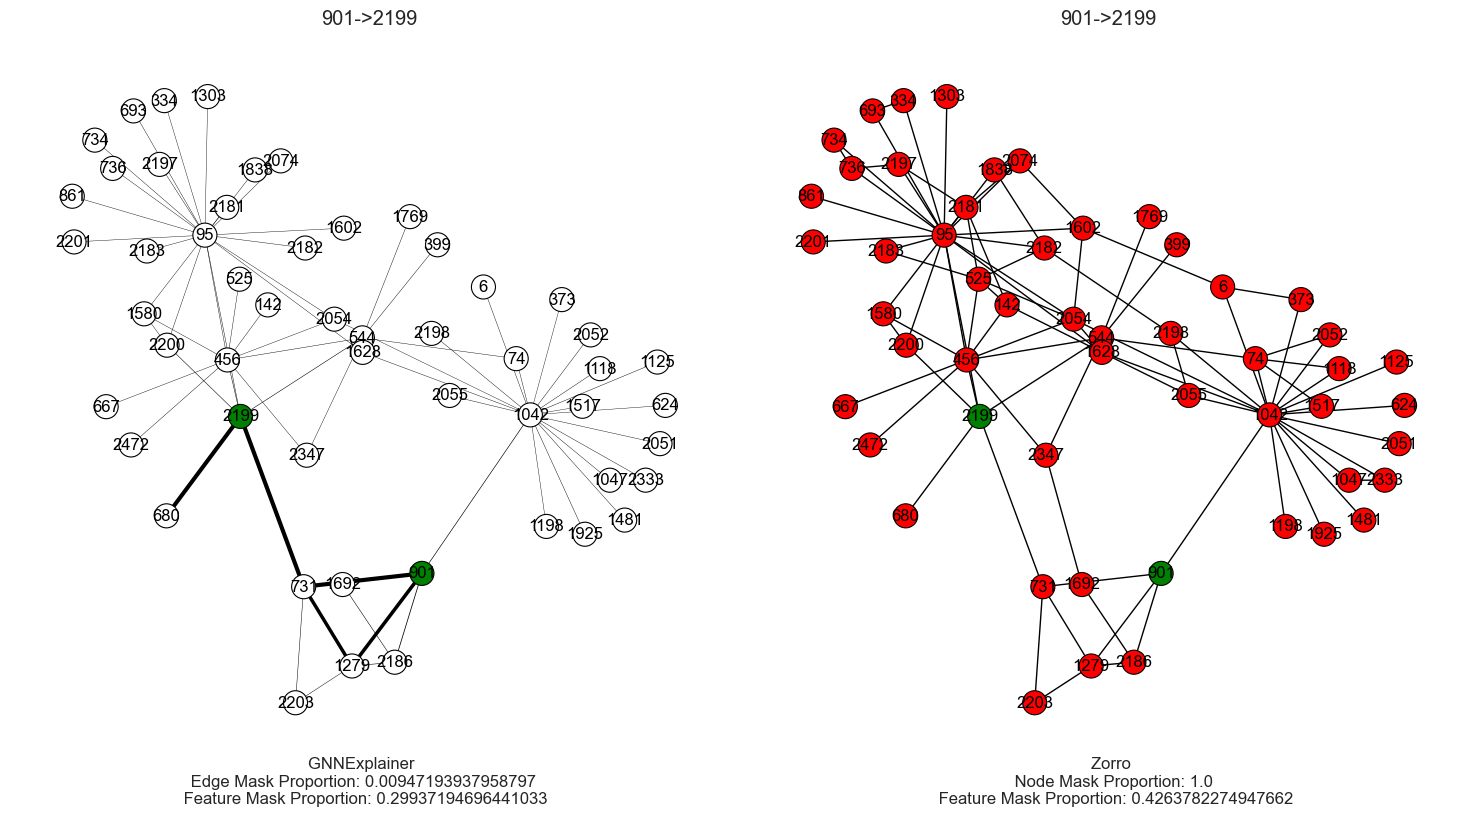

INFO:explainer:------ Start explaining edge tensor([[ 372],
        [2377]])


Generating explanations for No.528 edge in the test data.
Source node 372, Target Node: 2377
target:  1.0
pred:  0.7110189199447632
num_hops:  2



  0%|                                                                          | 0/18629 [00:00<?, ?it/s]
Explain edge tensor([[ 372],
        [2377]]):   0%|                           | 0/18629 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[ 372],
        [2377]])


initial_distortion:  0.5
num_hops:  2



INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[ 372],
        [2377]])

Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 1/18629 [00:00<4:20:54,  1.19it/s]

node_masks:  tensor([[0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.]])
best_node:  5
impove_in_distortion_by_node:  0.050000000000000044
best_feature:  581
impove_in_distortion_by_feature:  0.06999999999999995
count:  1
0.54
[nan, 581, 0.54]
num_to_add_once:  2


Argmax [0], 0.029999999999999916:  57%|████████████████████▌               | 4/7 [00:00<00:00, 21.98it/s]


distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.029999999999999916
best_node:  [0]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  None
impove_in_distortion_by_feature:  -100



Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 2/18629 [00:01<2:40:00,  1.94it/s]

count:  2
0.57
[[0], nan, 0.57]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 8], 0.0:  50%|████████████████████████▌                        | 3/6 [00:00<00:00, 19.43it/s]


distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.13999999999999996:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.13999999999999996


Argmax [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170], 0.020000000000000018:  10%| | 3/30 [00:00<

Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 3/18629 [00:01<2:24:35,  2.15it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  0.020000000000000018
best_node:  [10, 8]
impove_in_distortion_by_node:  0.0
best_feature:  [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170]
impove_in_distortion_by_feature:  0.020000000000000018
count:  3
0.59
[nan, [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170], 0.59]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [2, 12], 0.010000000000000009:  50%|████████████████                | 3/6 [00:00<00:00, 18.90it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.06999999999999995:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.06999999999999995:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 4/18629 [00:01<2:16:46,  2.27it/s]

distortion_improve:  -0.09999999999999998
best_node:  [2, 12]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.06999999999999995
count:  4
0.6
[[2, 12], nan, 0.6]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [11, 1], -0.010000000000000009:  50%|███████████████▌               | 2/4 [00:00<00:00, 20.68it/s]


distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.12
distortion_improve:  -0.10999999999999999
distortion_improve:  -0.13999999999999996
best_node:  [11, 1]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.10999999999999999
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
[11, 1]
Removing nodes:  [11, 1]




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 5/18629 [00:02<2:01:42,  2.55it/s]

count:  5
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]])
num_to_add_once:  2


Argmax [10, 8], -0.030000000000000027:  50%|███████████████▌               | 1/2 [00:00<00:00, 18.99it/s]


distortion_improve:  -0.030000000000000027
num_to_add_once:  10


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.12
distortion_improve:  -0.10999999999999999


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.13999999999999996
best_node:  [10, 8]
impove_in_distortion_by_node:  -0.030000000000000027
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.10999999999999999
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]])
[10, 8]
Removing nodes:  [10, 8]




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 6/18629 [00:02<1:48:41,  2.86it/s]

count:  6
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.12
distortion_improve:  -0.10999999999999999


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.13999999999999996
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.10999999999999999




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 7/18629 [00:02<1:33:59,  3.30it/s]

count:  7
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.12:   7%| | 2/30 [00:00<00:01, 19.09it/s]

distortion_improve:  -0.12
distortion_improve:  -0.13999999999999996


Argmax [35, 39, 93, 99, 121, 124, 191, 192, 205, 208], -0.08999999999999997:  10%| | 3/30 [00:00<00:01, 1

distortion_improve:  -0.08999999999999997
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [35, 39, 93, 99, 121, 124, 191, 192, 205, 208]
impove_in_distortion_by_feature:  -0.08999999999999997




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 8/18629 [00:02<1:25:19,  3.64it/s]

count:  8
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [251, 263, 303, 310, 313, 360, 368, 369, 396, 398], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.76it/s]

distortion_improve:  -0.12
distortion_improve:  -0.13999999999999996
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [251, 263, 303, 310, 313, 360, 368, 369, 396, 398]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 9/18629 [00:03<1:23:18,  3.73it/s]

count:  9
0.6
[nan, [251, 263, 303, 310, 313, 360, 368, 369, 396, 398], 0.6]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [422, 509, 510, 548, 608, 612, 617, 624, 637, 640], 0.030000000000000027:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.14999999999999997
distortion_improve:  0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [422, 509, 510, 548, 608, 612, 617, 624, 637, 640]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 10/18629 [00:03<1:22:39,  3.75it/s]

count:  10
0.63
[nan, [422, 509, 510, 548, 608, 612, 617, 624, 637, 640], 0.63]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 729, 735, 762, 781, 783, 810, 814, 835, 874], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.16999999999999998
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [675, 729, 735, 762, 781, 783, 810, 814, 835, 874]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 11/18629 [00:03<1:22:25,  3.76it/s]

count:  11
0.64
[nan, [675, 729, 735, 762, 781, 783, 810, 814, 835, 874], 0.64]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [899, 906, 912, 924, 928, 933, 973, 978, 979, 980], -0.07000000000000006:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.18
distortion_improve:  -0.07000000000000006
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [899, 906, 912, 924, 928, 933, 973, 978, 979, 980]
impove_in_distortion_by_feature:  -0.07000000000000006




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 12/18629 [00:03<1:17:03,  4.03it/s]

count:  12
0.64
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261], 0.04999999999999993:  10%| | 3/30 [0

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.18
distortion_improve:  0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261]
impove_in_distortion_by_feature:  0.04999999999999993




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 13/18629 [00:04<1:18:45,  3.94it/s]

count:  13
0.69
[nan, [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261], 0.69]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1295, 1328, 1384, 1412, 1427, 2, 25, 44, 45, 52], -0.029999999999999916:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 14/18629 [00:04<1:13:34,  4.22it/s]

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.21999999999999997
distortion_improve:  -0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1295, 1328, 1384, 1412, 1427, 2, 25, 44, 45, 52]
impove_in_distortion_by_feature:  -0.029999999999999916
count:  14
0.69
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [61, 64, 66, 68, 86, 88, 94, 98, 102, 109], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 19.01


distortion_improve:  -0.10999999999999999
distortion_improve:  -0.21999999999999997
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [61, 64, 66, 68, 86, 88, 94, 98, 102, 109]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 15/18629 [00:04<1:16:37,  4.05it/s]

count:  15
0.7
[nan, [61, 64, 66, 68, 86, 88, 94, 98, 102, 109], 0.7]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [114, 125, 130, 134, 140, 158, 166, 178, 179, 182], 0.040000000000000036:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.16999999999999993
distortion_improve:  0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [114, 125, 130, 134, 140, 158, 166, 178, 179, 182]
impove_in_distortion_by_feature:  0.040000000000000036




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 16/18629 [00:04<1:16:22,  4.06it/s]

count:  16
0.74
[nan, [114, 125, 130, 134, 140, 158, 166, 178, 179, 182], 0.74]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [187, 188, 189, 200, 203, 207, 214, 230, 231, 233], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.18999999999999995
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [187, 188, 189, 200, 203, 207, 214, 230, 231, 233]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 17/18629 [00:05<1:16:29,  4.06it/s]

count:  17
0.76
[nan, [187, 188, 189, 200, 203, 207, 214, 230, 231, 233], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [250, 258, 269, 275, 277, 278, 280, 284, 292, 305], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.16000000000000003
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [250, 258, 269, 275, 277, 278, 280, 284, 292, 305]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 18/18629 [00:05<1:12:42,  4.27it/s]

count:  18
0.76
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.06000000000000005:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06000000000000005


Argmax [319, 335, 336, 338, 342, 374, 375, 400, 401, 407], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 19/18629 [00:05<1:08:41,  4.52it/s]

distortion_improve:  -0.16000000000000003
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [319, 335, 336, 338, 342, 374, 375, 400, 401, 407]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  19
0.76
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.06000000000000005:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.16000000000000003


Argmax [417, 431, 437, 440, 445, 468, 474, 475, 480, 482], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.49it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [417, 431, 437, 440, 445, 468, 474, 475, 480, 482]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 20/18629 [00:05<1:12:44,  4.26it/s]

count:  20
0.76
[nan, [417, 431, 437, 440, 445, 468, 474, 475, 480, 482], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.06000000000000005:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06000000000000005


Argmax [489, 492, 495, 501, 506, 507, 516, 523, 524, 526], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.25it/s]

distortion_improve:  -0.15000000000000002
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [489, 492, 495, 501, 506, 507, 516, 523, 524, 526]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 21/18629 [00:06<1:16:24,  4.06it/s]

count:  21
0.76
[nan, [489, 492, 495, 501, 506, 507, 516, 523, 524, 526], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.040000000000000036:   0%| | 0/30 [00:00<?

distortion_improve:  -0.040000000000000036


Argmax [528, 534, 536, 546, 549, 552, 556, 560, 566, 575], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.08it/s]

distortion_improve:  -0.13
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [528, 534, 536, 546, 549, 552, 556, 560, 566, 575]
impove_in_distortion_by_feature:  0.0


count:  22
0.76
[nan, [528, 534, 536, 546, 549, 552, 556, 560, 566, 575], 0.76]


Explain edge tensor([[ 372],
        [2377]]):   0%|                | 22/18629 [00:06<1:16:58,  4.03it/s]



possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [585, 592, 596, 597, 611, 613, 618, 625, 633, 638], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.87it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.09999999999999998
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [585, 592, 596, 597, 611, 613, 618, 625, 633, 638]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 23/18629 [00:06<1:17:01,  4.03it/s]

count:  23
0.76
[nan, [585, 592, 596, 597, 611, 613, 618, 625, 633, 638], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [658, 694, 701, 704, 705, 712, 723, 725, 731, 734], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.0
distortion_improve:  -0.12
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [658, 694, 701, 704, 705, 712, 723, 725, 731, 734]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 24/18629 [00:06<1:20:40,  3.84it/s]

count:  24
0.77
[nan, [658, 694, 701, 704, 705, 712, 723, 725, 731, 734], 0.77]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], 0.0:  10%|▎  | 3/30 [00:00<00:01, 21.05it/s]

distortion_improve:  0.0
distortion_improve:  -0.16000000000000003
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 25/18629 [00:07<1:19:00,  3.92it/s]

count:  25
0.77
[nan, [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], 0.77]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [782, 785, 800, 801, 812, 819, 821, 834, 836, 854], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.14
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [782, 785, 800, 801, 812, 819, 821, 834, 836, 854]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 26/18629 [00:07<1:18:27,  3.95it/s]

count:  26
0.78
[nan, [782, 785, 800, 801, 812, 819, 821, 834, 836, 854], 0.78]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [739, 744, 748, 752, 756, 759, 760, 763, 771, 779], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 27/18629 [00:07<1:13:23,  4.22it/s]

distortion_improve:  -0.15000000000000002
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [739, 744, 748, 752, 756, 759, 760, 763, 771, 779]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  27
0.78
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [935, 937, 938, 957, 959, 967, 995, 1005, 1021, 1034], -0.010000000000000009:  10%| | 3/30 [00:00<

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 28/18629 [00:07<1:09:38,  4.45it/s]

distortion_improve:  -0.15000000000000002
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [935, 937, 938, 957, 959, 967, 995, 1005, 1021, 1034]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  28
0.78
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1036, 1044, 1049, 1052, 1057, 1058, 1060, 1061, 1070, 1076], 0.020000000000000018:  10%| | 3/30 [


distortion_improve:  -0.15000000000000002
distortion_improve:  -0.020000000000000018
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1036, 1044, 1049, 1052, 1057, 1058, 1060, 1061, 1070, 1076]
impove_in_distortion_by_feature:  0.020000000000000018



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 29/18629 [00:08<1:16:55,  4.03it/s]

count:  29
0.8
[nan, [1036, 1044, 1049, 1052, 1057, 1058, 1060, 1061, 1070, 1076], 0.8]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1094, 1095, 1096, 1097, 1105, 1108, 1109, 1117, 1124, 1137], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.16000000000000003
distortion_improve:  -0.030000000000000027
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1094, 1095, 1096, 1097, 1105, 1108, 1109, 1117, 1124, 1137]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 30/18629 [00:08<1:16:27,  4.05it/s]

count:  30
0.81
[nan, [1094, 1095, 1096, 1097, 1105, 1108, 1109, 1117, 1124, 1137], 0.81]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1142, 1143, 1145, 1147, 1149, 1152, 1157, 1160, 1167, 1171], 0.0:  10%| | 3/30 [00:00<00:01, 19.1

distortion_improve:  -0.16000000000000003
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1142, 1143, 1145, 1147, 1149, 1152, 1157, 1160, 1167, 1171]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 31/18629 [00:08<1:17:16,  4.01it/s]

count:  31
0.81
[nan, [1142, 1143, 1145, 1147, 1149, 1152, 1157, 1160, 1167, 1171], 0.81]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1175, 1178, 1179, 1180, 1184, 1185, 1192, 1197, 1198, 1203], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.14
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1175, 1178, 1179, 1180, 1184, 1185, 1192, 1197, 1198, 1203]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 32/18629 [00:08<1:12:57,  4.25it/s]

count:  32
0.81
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1204, 1205, 1206, 1215, 1230, 1231, 1235, 1250, 1254, 1255], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.14
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1204, 1205, 1206, 1215, 1230, 1231, 1235, 1250, 1254, 1255]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 33/18629 [00:08<1:10:42,  4.38it/s]

count:  33
0.81
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1256, 1259, 1260, 1262, 1267, 1274, 1278, 1279, 1281, 1292], 0.029999999999999916:  10%| | 3/30 [


distortion_improve:  -0.14
distortion_improve:  -0.040000000000000036
distortion_improve:  0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1256, 1259, 1260, 1262, 1267, 1274, 1278, 1279, 1281, 1292]
impove_in_distortion_by_feature:  0.029999999999999916



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 34/18629 [00:09<1:11:06,  4.36it/s]

count:  34
0.84
[nan, [1256, 1259, 1260, 1262, 1267, 1274, 1278, 1279, 1281, 1292], 0.84]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1304, 1308, 1311, 1316, 1317, 1325, 1330, 1331, 1334, 1335], 0.040000000000000036:  10%| | 3/30 [

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.029999999999999916
distortion_improve:  0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1304, 1308, 1311, 1316, 1317, 1325, 1330, 1331, 1334, 1335]
impove_in_distortion_by_feature:  0.040000000000000036




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 35/18629 [00:09<1:12:35,  4.27it/s]

count:  35
0.88
[nan, [1304, 1308, 1311, 1316, 1317, 1325, 1330, 1331, 1334, 1335], 0.88]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1340, 1343, 1352, 1355, 1357, 1359, 1376, 1379, 1386, 1405], 0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.040000000000000036
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1340, 1343, 1352, 1355, 1357, 1359, 1376, 1379, 1386, 1405]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 36/18629 [00:09<1:13:55,  4.19it/s]

count:  36
0.9
[nan, [1340, 1343, 1352, 1355, 1357, 1359, 1376, 1379, 1386, 1405], 0.9]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1418, 1424, 1425, 1429, 0, 1, 3, 4, 5, 7], -0.050000000000000044:  10%| | 3/30 [00:00<00:01, 21.9

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 37/18629 [00:09<1:09:43,  4.44it/s]

distortion_improve:  -0.12
distortion_improve:  -0.06000000000000005
distortion_improve:  -0.050000000000000044
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1418, 1424, 1425, 1429, 0, 1, 3, 4, 5, 7]
impove_in_distortion_by_feature:  -0.050000000000000044
count:  37
0.9
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [8, 9, 10, 12, 13, 14, 15, 17, 18, 20], 0.0:  10%|█▋               | 3/30 [00:00<00:01, 20.20it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 38/18629 [00:10<1:11:07,  4.36it/s]

distortion_improve:  -0.12
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [8, 9, 10, 12, 13, 14, 15, 17, 18, 20]
impove_in_distortion_by_feature:  0.0
count:  38
0.9
[nan, [8, 9, 10, 12, 13, 14, 15, 17, 18, 20], 0.9]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [859, 860, 871, 876, 884, 893, 897, 905, 911, 926], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.26it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 39/18629 [00:10<1:12:58,  4.25it/s]

distortion_improve:  -0.10999999999999999
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [859, 860, 871, 876, 884, 893, 897, 905, 911, 926]
impove_in_distortion_by_feature:  0.0
count:  39
0.9
[nan, [859, 860, 871, 876, 884, 893, 897, 905, 911, 926], 0.9]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [21, 22, 23, 24, 26, 27, 28, 29, 30, 31], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 19.61it

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 40/18629 [00:10<1:14:07,  4.18it/s]

distortion_improve:  -0.08999999999999997
distortion_improve:  0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [21, 22, 23, 24, 26, 27, 28, 29, 30, 31]
impove_in_distortion_by_feature:  0.010000000000000009
count:  40
0.91
[nan, [21, 22, 23, 24, 26, 27, 28, 29, 30, 31], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [32, 33, 34, 36, 37, 40, 41, 42, 43, 46], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 18.59it/s]


distortion_improve:  -0.10999999999999999
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [32, 33, 34, 36, 37, 40, 41, 42, 43, 46]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 41/18629 [00:10<1:15:56,  4.08it/s]

count:  41
0.91
[nan, [32, 33, 34, 36, 37, 40, 41, 42, 43, 46], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [48, 49, 50, 53, 54, 55, 57, 59, 60, 62], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 19.77i

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [48, 49, 50, 53, 54, 55, 57, 59, 60, 62]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 42/18629 [00:11<1:12:10,  4.29it/s]

count:  42
0.91
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.10999999999999999:   0%| | 0/30 [00:

distortion_improve:  -0.10999999999999999


Argmax [63, 67, 70, 71, 72, 73, 74, 75, 76, 77], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 19.33i

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [63, 67, 70, 71, 72, 73, 74, 75, 76, 77]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 43/18629 [00:11<1:10:03,  4.42it/s]

count:  43
0.91
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.10999999999999999:   0%| | 0/30 [00:

distortion_improve:  -0.10999999999999999


Argmax [92, 95, 96, 100, 101, 103, 104, 106, 107, 108], 0.0:  10%|▊       | 3/30 [00:00<00:01, 18.93it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [92, 95, 96, 100, 101, 103, 104, 106, 107, 108]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 44/18629 [00:11<1:13:56,  4.19it/s]

count:  44
0.91
[nan, [92, 95, 96, 100, 101, 103, 104, 106, 107, 108], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [111, 113, 115, 116, 117, 119, 120, 122, 126, 127], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.59it/s]

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [111, 113, 115, 116, 117, 119, 120, 122, 126, 127]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 45/18629 [00:11<1:16:13,  4.06it/s]

count:  45
0.91
[nan, [111, 113, 115, 116, 117, 119, 120, 122, 126, 127], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [128, 129, 132, 133, 135, 137, 139, 141, 142, 143], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.16it/s]

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [128, 129, 132, 133, 135, 137, 139, 141, 142, 143]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 46/18629 [00:12<1:18:36,  3.94it/s]

count:  46
0.91
[nan, [128, 129, 132, 133, 135, 137, 139, 141, 142, 143], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [144, 145, 146, 147, 148, 149, 150, 152, 153, 154], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07000000000000006
distortion_improve:  0.0
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [144, 145, 146, 147, 148, 149, 150, 152, 153, 154]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 47/18629 [00:12<1:18:31,  3.94it/s]

count:  47
0.93
[nan, [144, 145, 146, 147, 148, 149, 150, 152, 153, 154], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [155, 156, 157, 159, 160, 161, 162, 163, 164, 165], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.06it/s]

distortion_improve:  -0.09000000000000008
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [155, 156, 157, 159, 160, 161, 162, 163, 164, 165]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 48/18629 [00:12<1:19:28,  3.90it/s]

count:  48
0.93
[nan, [155, 156, 157, 159, 160, 161, 162, 163, 164, 165], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [78, 79, 80, 81, 83, 84, 85, 87, 90, 91], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 18.90it/s]

distortion_improve:  -0.08000000000000007
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [78, 79, 80, 81, 83, 84, 85, 87, 90, 91]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 49/18629 [00:12<1:20:03,  3.87it/s]

count:  49
0.93
[nan, [78, 79, 80, 81, 83, 84, 85, 87, 90, 91], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [167, 168, 169, 170, 171, 172, 173, 174, 175, 176], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.43it/s]

distortion_improve:  -0.08000000000000007
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [167, 168, 169, 170, 171, 172, 173, 174, 175, 176]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 50/18629 [00:13<1:19:45,  3.88it/s]

count:  50
0.93
[nan, [167, 168, 169, 170, 171, 172, 173, 174, 175, 176], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [177, 180, 181, 184, 185, 186, 190, 194, 196, 197], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009


Argmax [198, 199, 201, 202, 204, 206, 209, 210, 212, 213], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [198, 199, 201, 202, 204, 206, 209, 210, 212, 213]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 51/18629 [00:13<1:27:35,  3.54it/s]

count:  51
0.94
[nan, [198, 199, 201, 202, 204, 206, 209, 210, 212, 213], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.05999999999999994:   0%| | 0/30 [00:

distortion_improve:  -0.05999999999999994


Argmax [215, 216, 217, 218, 219, 220, 221, 222, 223, 224], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.89it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [215, 216, 217, 218, 219, 220, 221, 222, 223, 224]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 52/18629 [00:13<1:27:45,  3.53it/s]

count:  52
0.94
[nan, [215, 216, 217, 218, 219, 220, 221, 222, 223, 224], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [177, 180, 181, 184, 185, 186, 190, 194, 196, 197], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.20it/s]

distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [177, 180, 181, 184, 185, 186, 190, 194, 196, 197]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 53/18629 [00:14<1:26:11,  3.59it/s]

count:  53
0.94
[nan, [177, 180, 181, 184, 185, 186, 190, 194, 196, 197], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [225, 226, 227, 228, 229, 232, 235, 236, 239, 240], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.39it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [225, 226, 227, 228, 229, 232, 235, 236, 239, 240]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 54/18629 [00:14<1:24:15,  3.67it/s]

count:  54
0.94
[nan, [225, 226, 227, 228, 229, 232, 235, 236, 239, 240], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [241, 242, 244, 245, 246, 247, 248, 249, 252, 253], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.91it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [241, 242, 244, 245, 246, 247, 248, 249, 252, 253]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 55/18629 [00:14<1:21:00,  3.82it/s]

count:  55
0.94
[nan, [241, 242, 244, 245, 246, 247, 248, 249, 252, 253], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [254, 255, 256, 259, 260, 261, 262, 264, 265, 266], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.56it/s]

distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [254, 255, 256, 259, 260, 261, 262, 264, 265, 266]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 56/18629 [00:14<1:20:44,  3.83it/s]

count:  56
0.94
[nan, [254, 255, 256, 259, 260, 261, 262, 264, 265, 266], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [267, 268, 270, 271, 272, 273, 276, 279, 281, 283], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.65it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [267, 268, 270, 271, 272, 273, 276, 279, 281, 283]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 57/18629 [00:15<1:18:12,  3.96it/s]

count:  57
0.94
[nan, [267, 268, 270, 271, 272, 273, 276, 279, 281, 283], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [285, 286, 287, 288, 289, 290, 291, 293, 294, 295], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.46it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [285, 286, 287, 288, 289, 290, 291, 293, 294, 295]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 58/18629 [00:15<1:21:52,  3.78it/s]

count:  58
0.94
[nan, [285, 286, 287, 288, 289, 290, 291, 293, 294, 295], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [296, 297, 298, 300, 301, 302, 304, 306, 307, 308], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.94it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [296, 297, 298, 300, 301, 302, 304, 306, 307, 308]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 59/18629 [00:15<1:18:46,  3.93it/s]

count:  59
0.94
[nan, [296, 297, 298, 300, 301, 302, 304, 306, 307, 308], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [309, 311, 312, 316, 317, 318, 320, 321, 323, 325], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.28it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [309, 311, 312, 316, 317, 318, 320, 321, 323, 325]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 60/18629 [00:15<1:17:31,  3.99it/s]

count:  60
0.94
[nan, [309, 311, 312, 316, 317, 318, 320, 321, 323, 325], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [339, 340, 341, 344, 345, 346, 347, 348, 349, 350], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [339, 340, 341, 344, 345, 346, 347, 348, 349, 350]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 61/18629 [00:16<1:16:11,  4.06it/s]

count:  61
0.95
[nan, [339, 340, 341, 344, 345, 346, 347, 348, 349, 350], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [326, 327, 328, 329, 330, 331, 332, 333, 334, 337], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.71it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [326, 327, 328, 329, 330, 331, 332, 333, 334, 337]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 62/18629 [00:16<1:17:28,  3.99it/s]

count:  62
0.95
[nan, [326, 327, 328, 329, 330, 331, 332, 333, 334, 337], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [353, 354, 355, 356, 357, 358, 359, 361, 362, 363], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.07it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [353, 354, 355, 356, 357, 358, 359, 361, 362, 363]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 63/18629 [00:16<1:16:07,  4.06it/s]

count:  63
0.95
[nan, [353, 354, 355, 356, 357, 358, 359, 361, 362, 363], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [364, 365, 366, 370, 371, 372, 373, 376, 377, 378], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.46it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [364, 365, 366, 370, 371, 372, 373, 376, 377, 378]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 64/18629 [00:16<1:16:59,  4.02it/s]

count:  64
0.95
[nan, [364, 365, 366, 370, 371, 372, 373, 376, 377, 378], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [379, 380, 381, 382, 383, 384, 385, 386, 387, 388], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.34it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [379, 380, 381, 382, 383, 384, 385, 386, 387, 388]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 65/18629 [00:17<1:15:32,  4.10it/s]

count:  65
0.95
[nan, [379, 380, 381, 382, 383, 384, 385, 386, 387, 388], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [389, 390, 391, 392, 394, 399, 402, 404, 405, 406], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.16it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [389, 390, 391, 392, 394, 399, 402, 404, 405, 406]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 66/18629 [00:17<1:17:20,  4.00it/s]

count:  66
0.95
[nan, [389, 390, 391, 392, 394, 399, 402, 404, 405, 406], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [408, 410, 411, 412, 413, 414, 415, 416, 418, 420], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.24it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [408, 410, 411, 412, 413, 414, 415, 416, 418, 420]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 67/18629 [00:17<1:16:35,  4.04it/s]

count:  67
0.95
[nan, [408, 410, 411, 412, 413, 414, 415, 416, 418, 420], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], 0.010000000000000009:  10%| | 3/30 [00:

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 68/18629 [00:17<1:17:10,  4.01it/s]

count:  68
0.96
[nan, [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [421, 423, 424, 425, 426, 427, 428, 429, 430, 432], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.01it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [421, 423, 424, 425, 426, 427, 428, 429, 430, 432]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 69/18629 [00:18<1:16:09,  4.06it/s]

count:  69
0.96
[nan, [421, 423, 424, 425, 426, 427, 428, 429, 430, 432], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [433, 434, 435, 436, 438, 439, 441, 442, 443, 444], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.93it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [433, 434, 435, 436, 438, 439, 441, 442, 443, 444]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 70/18629 [00:18<1:14:33,  4.15it/s]

count:  70
0.96
[nan, [433, 434, 435, 436, 438, 439, 441, 442, 443, 444], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [446, 447, 448, 449, 450, 451, 452, 453, 454, 455], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.48it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [446, 447, 448, 449, 450, 451, 452, 453, 454, 455]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 71/18629 [00:18<1:15:47,  4.08it/s]

count:  71
0.96
[nan, [446, 447, 448, 449, 450, 451, 452, 453, 454, 455], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [467, 470, 471, 472, 473, 476, 477, 478, 479, 481], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.51it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [467, 470, 471, 472, 473, 476, 477, 478, 479, 481]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 72/18629 [00:18<1:17:05,  4.01it/s]

count:  72
0.96
[nan, [467, 470, 471, 472, 473, 476, 477, 478, 479, 481], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [483, 484, 485, 486, 487, 488, 490, 491, 493, 494], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.07it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [483, 484, 485, 486, 487, 488, 490, 491, 493, 494]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 73/18629 [00:19<1:17:46,  3.98it/s]

count:  73
0.96
[nan, [483, 484, 485, 486, 487, 488, 490, 491, 493, 494], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [496, 497, 498, 499, 500, 502, 503, 504, 508, 511], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.88it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [496, 497, 498, 499, 500, 502, 503, 504, 508, 511]
impove_in_distortion_by_feature:  0.0


count:  74
0.96
[nan, [496, 497, 498, 499, 500, 502, 503, 504, 508, 511], 0.96]


Explain edge tensor([[ 372],
        [2377]]):   0%|                | 74/18629 [00:19<1:18:42,  3.93it/s]



possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [527, 529, 530, 532, 533, 535, 537, 538, 539, 540], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [527, 529, 530, 532, 533, 535, 537, 538, 539, 540]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 75/18629 [00:19<1:18:30,  3.94it/s]

count:  75
0.97
[nan, [527, 529, 530, 532, 533, 535, 537, 538, 539, 540], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [512, 513, 514, 515, 517, 518, 519, 521, 522, 525], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.00it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [512, 513, 514, 515, 517, 518, 519, 521, 522, 525]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 76/18629 [00:19<1:19:58,  3.87it/s]

count:  76
0.97
[nan, [512, 513, 514, 515, 517, 518, 519, 521, 522, 525], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [541, 542, 543, 544, 545, 547, 550, 553, 554, 555], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.96it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [541, 542, 543, 544, 545, 547, 550, 553, 554, 555]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 77/18629 [00:20<1:19:21,  3.90it/s]

count:  77
0.97
[nan, [541, 542, 543, 544, 545, 547, 550, 553, 554, 555], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [570, 571, 572, 574, 576, 577, 578, 579, 582, 583], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.61it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [570, 571, 572, 574, 576, 577, 578, 579, 582, 583]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 78/18629 [00:20<1:19:32,  3.89it/s]

count:  78
0.97
[nan, [570, 571, 572, 574, 576, 577, 578, 579, 582, 583], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [584, 586, 587, 589, 590, 591, 594, 595, 598, 599], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.40it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [584, 586, 587, 589, 590, 591, 594, 595, 598, 599]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 79/18629 [00:20<1:19:25,  3.89it/s]

count:  79
0.97
[nan, [584, 586, 587, 589, 590, 591, 594, 595, 598, 599], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [600, 601, 602, 603, 605, 606, 607, 609, 610, 614], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.95it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [600, 601, 602, 603, 605, 606, 607, 609, 610, 614]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 80/18629 [00:20<1:19:29,  3.89it/s]

count:  80
0.97
[nan, [600, 601, 602, 603, 605, 606, 607, 609, 610, 614], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [457, 458, 459, 460, 461, 462, 463, 464, 465, 466], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.67it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [457, 458, 459, 460, 461, 462, 463, 464, 465, 466]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 81/18629 [00:21<1:19:17,  3.90it/s]

count:  81
0.97
[nan, [457, 458, 459, 460, 461, 462, 463, 464, 465, 466], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [557, 558, 561, 562, 563, 564, 565, 567, 568, 569], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [557, 558, 561, 562, 563, 564, 565, 567, 568, 569]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 82/18629 [00:21<1:19:34,  3.88it/s]

count:  82
0.98
[nan, [557, 558, 561, 562, 563, 564, 565, 567, 568, 569], 0.98]


Explain edge tensor([[ 372],
        [2377]]):   0%|                | 82/18629 [00:21<1:20:24,  3.84it/s]
INFO:explainer:------ Finished explaining edge tensor([[ 372],
        [2377]])


[(array([[1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.]],
      dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.5], [nan, 581, 0.54], [[0], nan, 0.57], [nan, [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170], 0.59], [[2, 12], nan, 0.6], None, None, None, None, [nan, [251, 263, 303, 310, 313, 360, 368, 369, 396, 398], 0.6], [nan, [422, 509, 510, 548, 608, 612, 617, 624, 637, 640], 0.63], [nan, [675, 729, 735, 762, 781, 783, 810, 814, 835, 874], 0.64], None, [nan, [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261], 0.69], None, [nan, [61, 64, 66, 68, 86, 88, 94, 98, 102, 109], 0.7], [nan, [114, 125, 130, 134, 140, 158, 166, 178, 179, 182], 0.74], [nan, [187, 188, 189, 200, 203, 207, 214, 230, 231, 233], 0.76], None, None, [nan, [417, 431, 437, 440, 445, 468, 474, 475, 480, 482], 0.76], [nan, [489, 492, 495, 501, 506, 507, 516, 523, 524, 526], 0.76], [nan, [528, 534, 536, 546, 549, 552, 556, 560, 566, 575], 0.76], [nan, [585, 592, 

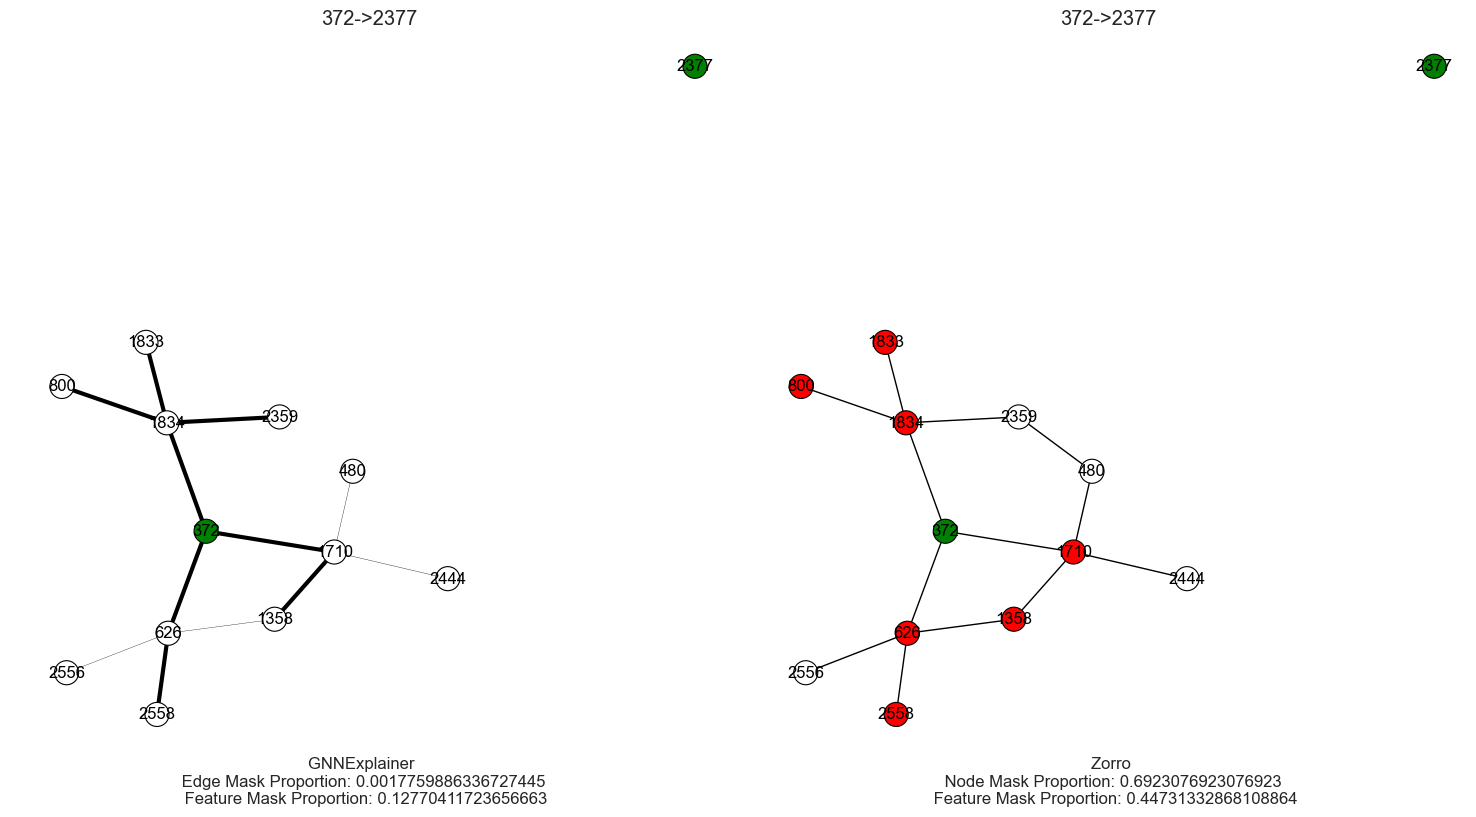

INFO:explainer:------ Start explaining edge tensor([[ 372],
        [2377]])


Generating explanations for No.199 edge in the test data.
Source node 350, Target Node: 2090
target:  1.0
pred:  0.21527519822120667
Generating explanations for No.528 edge in the test data.
Source node 372, Target Node: 2377
target:  1.0
pred:  0.7110189199447632
num_hops:  2



  0%|                                                                          | 0/18629 [00:00<?, ?it/s]
Explain edge tensor([[ 372],
        [2377]]):   0%|                           | 0/18629 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[ 372],
        [2377]])


initial_distortion:  0.5
num_hops:  2



INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[ 372],
        [2377]])

Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 1/18629 [00:00<4:08:31,  1.25it/s]

node_masks:  tensor([[0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.]])
best_node:  5
impove_in_distortion_by_node:  0.050000000000000044
best_feature:  581
impove_in_distortion_by_feature:  0.06999999999999995
count:  1
0.54
[nan, 581, 0.54]
num_to_add_once:  2


Argmax [0], 0.029999999999999916:  57%|████████████████████▌               | 4/7 [00:00<00:00, 20.41it/s]


distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.029999999999999916
best_node:  [0]
impove_in_distortion_by_node:  0.029999999999999916
best_feature:  None
impove_in_distortion_by_feature:  -100



Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 2/18629 [00:01<2:34:58,  2.00it/s]

count:  2
0.57
[[0], nan, 0.57]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 8], 0.0:  50%|████████████████████████▌                        | 3/6 [00:00<00:00, 19.30it/s]


distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.13999999999999996:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.13999999999999996


Argmax [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170], 0.020000000000000018:  10%| | 3/30 [00:00<


distortion_improve:  -0.06999999999999995
distortion_improve:  0.020000000000000018
best_node:  [10, 8]
impove_in_distortion_by_node:  0.0
best_feature:  [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170]
impove_in_distortion_by_feature:  0.020000000000000018



Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 3/18629 [00:01<2:23:25,  2.16it/s]

count:  3
0.59
[nan, [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170], 0.59]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [2, 12], 0.010000000000000009:  50%|████████████████                | 3/6 [00:00<00:00, 20.29it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.06999999999999995:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.06999999999999995:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 4/18629 [00:01<2:15:38,  2.29it/s]

distortion_improve:  -0.09999999999999998
best_node:  [2, 12]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.06999999999999995
count:  4
0.6
[[2, 12], nan, 0.6]


possible_nodes change:  tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
num_to_add_once:  2


Argmax [10, 8], -0.030000000000000027:   0%|                                       | 0/4 [00:00<?, ?it/s]

distortion_improve:  -0.030000000000000027


Argmax [11, 1], -0.010000000000000009:  50%|███████████████▌               | 2/4 [00:00<00:00, 20.26it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.12
distortion_improve:  -0.10999999999999999


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.13999999999999996
best_node:  [11, 1]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.10999999999999999
tensor([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.]])
[11, 1]
Removing nodes:  [11, 1]




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 5/18629 [00:02<2:02:34,  2.53it/s]

count:  5
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]])
num_to_add_once:  2


Argmax [10, 8], -0.030000000000000027:  50%|███████████████▌               | 1/2 [00:00<00:00, 18.78it/s]


distortion_improve:  -0.030000000000000027
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.12:   0%|         | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:   7%| | 2/30 [00:00<00:0

distortion_improve:  -0.10999999999999999


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.13999999999999996
best_node:  [10, 8]
impove_in_distortion_by_node:  -0.030000000000000027
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.10999999999999999
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]])
[10, 8]
Removing nodes:  [10, 8]




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 6/18629 [00:02<1:48:37,  2.86it/s]

count:  6
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:   3%| | 1/30 [00:00<00:0

distortion_improve:  -0.12
distortion_improve:  -0.10999999999999999


Argmax [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469], -0.10999999999999999:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.13999999999999996
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1263, 1381, 16, 19, 118, 257, 299, 351, 395, 469]
impove_in_distortion_by_feature:  -0.10999999999999999




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 7/18629 [00:02<1:33:19,  3.33it/s]

count:  7
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [35, 39, 93, 99, 121, 124, 191, 192, 205, 208], -0.08999999999999997:  10%| | 3/30 [00:00<00:01, 2

distortion_improve:  -0.12
distortion_improve:  -0.13999999999999996
distortion_improve:  -0.08999999999999997
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [35, 39, 93, 99, 121, 124, 191, 192, 205, 208]
impove_in_distortion_by_feature:  -0.08999999999999997




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 8/18629 [00:02<1:22:52,  3.74it/s]

count:  8
0.6
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.12:   0%|         | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [251, 263, 303, 310, 313, 360, 368, 369, 396, 398], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.11it/s]

distortion_improve:  -0.13999999999999996
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [251, 263, 303, 310, 313, 360, 368, 369, 396, 398]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                 | 9/18629 [00:03<1:21:52,  3.79it/s]

count:  9
0.6
[nan, [251, 263, 303, 310, 313, 360, 368, 369, 396, 398], 0.6]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [422, 509, 510, 548, 608, 612, 617, 624, 637, 640], 0.030000000000000027:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.14999999999999997
distortion_improve:  0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [422, 509, 510, 548, 608, 612, 617, 624, 637, 640]
impove_in_distortion_by_feature:  0.030000000000000027


count: 


Explain edge tensor([[ 372],
        [2377]]):   0%|                | 10/18629 [00:03<1:21:31,  3.81it/s]

 10
0.63
[nan, [422, 509, 510, 548, 608, 612, 617, 624, 637, 640], 0.63]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [675, 729, 735, 762, 781, 783, 810, 814, 835, 874], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.16999999999999998
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [675, 729, 735, 762, 781, 783, 810, 814, 835, 874]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 11/18629 [00:03<1:22:14,  3.77it/s]

count:  11
0.64
[nan, [675, 729, 735, 762, 781, 783, 810, 814, 835, 874], 0.64]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.08999999999999997:   7%| | 2/30 [00:00<00

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.18


Argmax [899, 906, 912, 924, 928, 933, 973, 978, 979, 980], -0.07000000000000006:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 12/18629 [00:03<1:22:56,  3.74it/s]

distortion_improve:  -0.07000000000000006
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [899, 906, 912, 924, 928, 933, 973, 978, 979, 980]
impove_in_distortion_by_feature:  -0.07000000000000006
count:  12
0.64
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.08999999999999997:   7%| | 2/30 [00:00<00

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.18


Argmax [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261], 0.04999999999999993:  10%| | 3/30 [0


distortion_improve:  0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261]
impove_in_distortion_by_feature:  0.04999999999999993



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 13/18629 [00:04<1:21:45,  3.79it/s]

count:  13
0.69
[nan, [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261], 0.69]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.10999999999999999:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.10999999999999999


Argmax [1295, 1328, 1384, 1412, 1427, 2, 25, 44, 45, 52], -0.029999999999999916:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.21999999999999997
distortion_improve:  -0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1295, 1328, 1384, 1412, 1427, 2, 25, 44, 45, 52]
impove_in_distortion_by_feature:  -0.029999999999999916




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 14/18629 [00:04<1:16:33,  4.05it/s]

count:  14
0.69
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.10999999999999999:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.10999999999999999


Argmax [61, 64, 66, 68, 86, 88, 94, 98, 102, 109], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 20.56

distortion_improve:  -0.21999999999999997
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [61, 64, 66, 68, 86, 88, 94, 98, 102, 109]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 15/18629 [00:04<1:16:41,  4.05it/s]

count:  15
0.7
[nan, [61, 64, 66, 68, 86, 88, 94, 98, 102, 109], 0.7]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [114, 125, 130, 134, 140, 158, 166, 178, 179, 182], 0.040000000000000036:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.16999999999999993
distortion_improve:  0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [114, 125, 130, 134, 140, 158, 166, 178, 179, 182]
impove_in_distortion_by_feature:  0.040000000000000036




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 16/18629 [00:04<1:20:27,  3.86it/s]

count:  16
0.74
[nan, [114, 125, 130, 134, 140, 158, 166, 178, 179, 182], 0.74]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [187, 188, 189, 200, 203, 207, 214, 230, 231, 233], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.18999999999999995
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [187, 188, 189, 200, 203, 207, 214, 230, 231, 233]
impove_in_distortion_by_feature:  0.020000000000000018


count: 


Explain edge tensor([[ 372],
        [2377]]):   0%|                | 17/18629 [00:05<1:19:52,  3.88it/s]

 17
0.76
[nan, [187, 188, 189, 200, 203, 207, 214, 230, 231, 233], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [250, 258, 269, 275, 277, 278, 280, 284, 292, 305], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 18/18629 [00:05<1:14:10,  4.18it/s]

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.16000000000000003
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [250, 258, 269, 275, 277, 278, 280, 284, 292, 305]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  18
0.76
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.06000000000000005:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06000000000000005


Argmax [319, 335, 336, 338, 342, 374, 375, 400, 401, 407], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 19/18629 [00:05<1:10:06,  4.42it/s]

distortion_improve:  -0.16000000000000003
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [319, 335, 336, 338, 342, 374, 375, 400, 401, 407]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  19
0.76
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.06000000000000005:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.16000000000000003


Argmax [417, 431, 437, 440, 445, 468, 474, 475, 480, 482], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.93it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 20/18629 [00:05<1:11:36,  4.33it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [417, 431, 437, 440, 445, 468, 474, 475, 480, 482]
impove_in_distortion_by_feature:  0.0
count:  20
0.76
[nan, [417, 431, 437, 440, 445, 468, 474, 475, 480, 482], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.06000000000000005:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.15000000000000002


Argmax [489, 492, 495, 501, 506, 507, 516, 523, 524, 526], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.64it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 21/18629 [00:06<1:12:58,  4.25it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [489, 492, 495, 501, 506, 507, 516, 523, 524, 526]
impove_in_distortion_by_feature:  0.0
count:  21
0.76
[nan, [489, 492, 495, 501, 506, 507, 516, 523, 524, 526], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.040000000000000036:   0%| | 0/30 [00:00<?

distortion_improve:  -0.040000000000000036


Argmax [528, 534, 536, 546, 549, 552, 556, 560, 566, 575], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.00it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 22/18629 [00:06<1:13:11,  4.24it/s]

distortion_improve:  -0.13
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [528, 534, 536, 546, 549, 552, 556, 560, 566, 575]
impove_in_distortion_by_feature:  0.0
count:  22
0.76
[nan, [528, 534, 536, 546, 549, 552, 556, 560, 566, 575], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], -0.010000000000000009:   0%| | 0/30 [00:00<?

distortion_improve:  -0.010000000000000009


Argmax [585, 592, 596, 597, 611, 613, 618, 625, 633, 638], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.09it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 23/18629 [00:06<1:12:37,  4.27it/s]

distortion_improve:  -0.09999999999999998
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [585, 592, 596, 597, 611, 613, 618, 625, 633, 638]
impove_in_distortion_by_feature:  0.0
count:  23
0.76
[nan, [585, 592, 596, 597, 611, 613, 618, 625, 633, 638], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], 0.0:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [658, 694, 701, 704, 705, 712, 723, 725, 731, 734], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 24/18629 [00:06<1:13:21,  4.23it/s]

distortion_improve:  -0.12
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [658, 694, 701, 704, 705, 712, 723, 725, 731, 734]
impove_in_distortion_by_feature:  0.010000000000000009
count:  24
0.77
[nan, [658, 694, 701, 704, 705, 712, 723, 725, 731, 734], 0.77]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], 0.0:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], 0.0:  10%|▎  | 3/30 [00:00<00:01, 20.73it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 25/18629 [00:07<1:14:43,  4.15it/s]

distortion_improve:  -0.16000000000000003
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986]
impove_in_distortion_by_feature:  0.0
count:  25
0.77
[nan, [1290, 393, 988, 1144, 1174, 11, 195, 666, 865, 986], 0.77]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [782, 785, 800, 801, 812, 819, 821, 834, 836, 854], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 26/18629 [00:07<1:15:07,  4.13it/s]

distortion_improve:  -0.14
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [782, 785, 800, 801, 812, 819, 821, 834, 836, 854]
impove_in_distortion_by_feature:  0.010000000000000009
count:  26
0.78
[nan, [782, 785, 800, 801, 812, 819, 821, 834, 836, 854], 0.78]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [739, 744, 748, 752, 756, 759, 760, 763, 771, 779], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 27/18629 [00:07<1:10:24,  4.40it/s]

distortion_improve:  -0.15000000000000002
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [739, 744, 748, 752, 756, 759, 760, 763, 771, 779]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  27
0.78
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.15000000000000002:   0%| | 0/30 [00:

distortion_improve:  -0.15000000000000002


Argmax [935, 937, 938, 957, 959, 967, 995, 1005, 1021, 1034], -0.010000000000000009:  10%| | 3/30 [00:00<

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 28/18629 [00:07<1:07:20,  4.60it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [935, 937, 938, 957, 959, 967, 995, 1005, 1021, 1034]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  28
0.78
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.15000000000000002:   0%| | 0/30 [00:

distortion_improve:  -0.15000000000000002


Argmax [859, 860, 871, 876, 884, 893, 897, 905, 911, 926], -0.020000000000000018:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [1036, 1044, 1049, 1052, 1057, 1058, 1060, 1061, 1070, 1076], 0.020000000000000018:  10%| | 3/30 [

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 29/18629 [00:07<1:10:22,  4.40it/s]

distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1036, 1044, 1049, 1052, 1057, 1058, 1060, 1061, 1070, 1076]
impove_in_distortion_by_feature:  0.020000000000000018
count:  29
0.8
[nan, [1036, 1044, 1049, 1052, 1057, 1058, 1060, 1061, 1070, 1076], 0.8]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.16000000000000003:   0%| | 0/30 [00:

distortion_improve:  -0.16000000000000003


Argmax [1094, 1095, 1096, 1097, 1105, 1108, 1109, 1117, 1124, 1137], 0.010000000000000009:  10%| | 3/30 [


distortion_improve:  -0.030000000000000027
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1094, 1095, 1096, 1097, 1105, 1108, 1109, 1117, 1124, 1137]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 30/18629 [00:08<1:13:49,  4.20it/s]

count:  30
0.81
[nan, [1094, 1095, 1096, 1097, 1105, 1108, 1109, 1117, 1124, 1137], 0.81]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.16000000000000003:   0%| | 0/30 [00:

distortion_improve:  -0.16000000000000003


Argmax [1142, 1143, 1145, 1147, 1149, 1152, 1157, 1160, 1167, 1171], 0.0:  10%| | 3/30 [00:00<00:01, 19.5

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1142, 1143, 1145, 1147, 1149, 1152, 1157, 1160, 1167, 1171]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 31/18629 [00:08<1:15:26,  4.11it/s]

count:  31
0.81
[nan, [1142, 1143, 1145, 1147, 1149, 1152, 1157, 1160, 1167, 1171], 0.81]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1175, 1178, 1179, 1180, 1184, 1185, 1192, 1197, 1198, 1203], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.14
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1175, 1178, 1179, 1180, 1184, 1185, 1192, 1197, 1198, 1203]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 32/18629 [00:08<1:12:32,  4.27it/s]

count:  32
0.81
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1204, 1205, 1206, 1215, 1230, 1231, 1235, 1250, 1254, 1255], -0.010000000000000009:  10%| | 3/30 

distortion_improve:  -0.14
distortion_improve:  -0.040000000000000036
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1204, 1205, 1206, 1215, 1230, 1231, 1235, 1250, 1254, 1255]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 33/18629 [00:08<1:10:12,  4.41it/s]

count:  33
0.81
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1256, 1259, 1260, 1262, 1267, 1274, 1278, 1279, 1281, 1292], 0.029999999999999916:  10%| | 3/30 [


distortion_improve:  -0.14
distortion_improve:  -0.040000000000000036
distortion_improve:  0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1256, 1259, 1260, 1262, 1267, 1274, 1278, 1279, 1281, 1292]
impove_in_distortion_by_feature:  0.029999999999999916



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 34/18629 [00:09<1:11:13,  4.35it/s]

count:  34
0.84
[nan, [1256, 1259, 1260, 1262, 1267, 1274, 1278, 1279, 1281, 1292], 0.84]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1304, 1308, 1311, 1316, 1317, 1325, 1330, 1331, 1334, 1335], 0.040000000000000036:  10%| | 3/30 [

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.029999999999999916
distortion_improve:  0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1304, 1308, 1311, 1316, 1317, 1325, 1330, 1331, 1334, 1335]
impove_in_distortion_by_feature:  0.040000000000000036




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 35/18629 [00:09<1:13:59,  4.19it/s]

count:  35
0.88
[nan, [1304, 1308, 1311, 1316, 1317, 1325, 1330, 1331, 1334, 1335], 0.88]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1340, 1343, 1352, 1355, 1357, 1359, 1376, 1379, 1386, 1405], 0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.040000000000000036
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1340, 1343, 1352, 1355, 1357, 1359, 1376, 1379, 1386, 1405]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 36/18629 [00:09<1:15:46,  4.09it/s]

count:  36
0.9
[nan, [1340, 1343, 1352, 1355, 1357, 1359, 1376, 1379, 1386, 1405], 0.9]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1418, 1424, 1425, 1429, 0, 1, 3, 4, 5, 7], -0.050000000000000044:  10%| | 3/30 [00:00<00:01, 20.9

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 37/18629 [00:09<1:11:23,  4.34it/s]

distortion_improve:  -0.12
distortion_improve:  -0.06000000000000005
distortion_improve:  -0.050000000000000044
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1418, 1424, 1425, 1429, 0, 1, 3, 4, 5, 7]
impove_in_distortion_by_feature:  -0.050000000000000044
count:  37
0.9
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [8, 9, 10, 12, 13, 14, 15, 17, 18, 20], 0.0:  10%|█▋               | 3/30 [00:00<00:01, 20.30it/s]


distortion_improve:  -0.12
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [8, 9, 10, 12, 13, 14, 15, 17, 18, 20]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 38/18629 [00:10<1:12:49,  4.25it/s]

count:  38
0.9
[nan, [8, 9, 10, 12, 13, 14, 15, 17, 18, 20], 0.9]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [859, 860, 871, 876, 884, 893, 897, 905, 911, 926], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.59it/s]

distortion_improve:  -0.10999999999999999
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [859, 860, 871, 876, 884, 893, 897, 905, 911, 926]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 39/18629 [00:10<1:14:31,  4.16it/s]

count:  39
0.9
[nan, [859, 860, 871, 876, 884, 893, 897, 905, 911, 926], 0.9]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [21, 22, 23, 24, 26, 27, 28, 29, 30, 31], 0.010000000000000009:  10%| | 3/30 [00:00<00:01, 21.38it

distortion_improve:  -0.08999999999999997
distortion_improve:  0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [21, 22, 23, 24, 26, 27, 28, 29, 30, 31]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 40/18629 [00:10<1:14:44,  4.14it/s]

count:  40
0.91
[nan, [21, 22, 23, 24, 26, 27, 28, 29, 30, 31], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [32, 33, 34, 36, 37, 40, 41, 42, 43, 46], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 20.39it/s]

distortion_improve:  -0.10999999999999999
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [32, 33, 34, 36, 37, 40, 41, 42, 43, 46]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 41/18629 [00:10<1:15:53,  4.08it/s]

count:  41
0.91
[nan, [32, 33, 34, 36, 37, 40, 41, 42, 43, 46], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [48, 49, 50, 53, 54, 55, 57, 59, 60, 62], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 22.62i

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 42/18629 [00:10<1:10:21,  4.40it/s]

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [48, 49, 50, 53, 54, 55, 57, 59, 60, 62]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  42
0.91
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.10999999999999999:   0%| | 0/30 [00:

distortion_improve:  -0.10999999999999999


Argmax [63, 67, 70, 71, 72, 73, 74, 75, 76, 77], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 14.54i

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 43/18629 [00:11<1:12:44,  4.26it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [63, 67, 70, 71, 72, 73, 74, 75, 76, 77]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  43
0.91
None


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [78, 79, 80, 81, 83, 84, 85, 87, 90, 91], -0.020000000000000018:   7%| | 2/30 [00:00<00:01, 19.27i

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.020000000000000018


Argmax [92, 95, 96, 100, 101, 103, 104, 106, 107, 108], 0.0:  10%|▊       | 3/30 [00:00<00:01, 19.34it/s]

Explain edge tensor([[ 372],
        [2377]]):   0%|                | 44/18629 [00:11<1:14:28,  4.16it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [92, 95, 96, 100, 101, 103, 104, 106, 107, 108]
impove_in_distortion_by_feature:  0.0
count:  44
0.91
[nan, [92, 95, 96, 100, 101, 103, 104, 106, 107, 108], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], -0.09999999999999998:   0%| | 0/30 [00:

distortion_improve:  -0.09999999999999998


Argmax [111, 113, 115, 116, 117, 119, 120, 122, 126, 127], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.69it/s]


distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [111, 113, 115, 116, 117, 119, 120, 122, 126, 127]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[ 372],
        [2377]]):   0%|                | 45/18629 [00:11<1:16:45,  4.03it/s]

count:  45
0.91
[nan, [111, 113, 115, 116, 117, 119, 120, 122, 126, 127], 0.91]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [128, 129, 132, 133, 135, 137, 139, 141, 142, 143], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.60it/s]

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [128, 129, 132, 133, 135, 137, 139, 141, 142, 143]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 46/18629 [00:12<1:17:41,  3.99it/s]

count:  46
0.91
[nan, [128, 129, 132, 133, 135, 137, 139, 141, 142, 143], 0.91]




possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [144, 145, 146, 147, 148, 149, 150, 152, 153, 154], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07000000000000006
distortion_improve:  0.0
distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [144, 145, 146, 147, 148, 149, 150, 152, 153, 154]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 47/18629 [00:12<1:16:23,  4.05it/s]

count:  47
0.93
[nan, [144, 145, 146, 147, 148, 149, 150, 152, 153, 154], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [155, 156, 157, 159, 160, 161, 162, 163, 164, 165], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.40it/s]

distortion_improve:  -0.09000000000000008
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [155, 156, 157, 159, 160, 161, 162, 163, 164, 165]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 48/18629 [00:12<1:16:06,  4.07it/s]

count:  48
0.93
[nan, [155, 156, 157, 159, 160, 161, 162, 163, 164, 165], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [78, 79, 80, 81, 83, 84, 85, 87, 90, 91], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 21.23it/s]

distortion_improve:  -0.08000000000000007
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [78, 79, 80, 81, 83, 84, 85, 87, 90, 91]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 49/18629 [00:12<1:16:03,  4.07it/s]

count:  49
0.93
[nan, [78, 79, 80, 81, 83, 84, 85, 87, 90, 91], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [167, 168, 169, 170, 171, 172, 173, 174, 175, 176], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.22it/s]

distortion_improve:  -0.08000000000000007
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [167, 168, 169, 170, 171, 172, 173, 174, 175, 176]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 50/18629 [00:12<1:15:33,  4.10it/s]

count:  50
0.93
[nan, [167, 168, 169, 170, 171, 172, 173, 174, 175, 176], 0.93]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [198, 199, 201, 202, 204, 206, 209, 210, 212, 213], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
distortion_improve:  0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [198, 199, 201, 202, 204, 206, 209, 210, 212, 213]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 51/18629 [00:13<1:14:58,  4.13it/s]

count:  51
0.94
[nan, [198, 199, 201, 202, 204, 206, 209, 210, 212, 213], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [215, 216, 217, 218, 219, 220, 221, 222, 223, 224], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.58it/s]

distortion_improve:  -0.05999999999999994
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [215, 216, 217, 218, 219, 220, 221, 222, 223, 224]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 52/18629 [00:13<1:16:40,  4.04it/s]

count:  52
0.94
[nan, [215, 216, 217, 218, 219, 220, 221, 222, 223, 224], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [177, 180, 181, 184, 185, 186, 190, 194, 196, 197], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.56it/s]

distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [177, 180, 181, 184, 185, 186, 190, 194, 196, 197]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 53/18629 [00:13<1:18:10,  3.96it/s]

count:  53
0.94
[nan, [177, 180, 181, 184, 185, 186, 190, 194, 196, 197], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [225, 226, 227, 228, 229, 232, 235, 236, 239, 240], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.65it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [225, 226, 227, 228, 229, 232, 235, 236, 239, 240]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 54/18629 [00:14<1:18:55,  3.92it/s]

count:  54
0.94
[nan, [225, 226, 227, 228, 229, 232, 235, 236, 239, 240], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [241, 242, 244, 245, 246, 247, 248, 249, 252, 253], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.20it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [241, 242, 244, 245, 246, 247, 248, 249, 252, 253]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 55/18629 [00:14<1:18:35,  3.94it/s]

count:  55
0.94
[nan, [241, 242, 244, 245, 246, 247, 248, 249, 252, 253], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [254, 255, 256, 259, 260, 261, 262, 264, 265, 266], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.51it/s]

distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [254, 255, 256, 259, 260, 261, 262, 264, 265, 266]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 56/18629 [00:14<1:18:11,  3.96it/s]

count:  56
0.94
[nan, [254, 255, 256, 259, 260, 261, 262, 264, 265, 266], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [267, 268, 270, 271, 272, 273, 276, 279, 281, 283], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.17it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [267, 268, 270, 271, 272, 273, 276, 279, 281, 283]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 57/18629 [00:14<1:17:44,  3.98it/s]

count:  57
0.94
[nan, [267, 268, 270, 271, 272, 273, 276, 279, 281, 283], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [285, 286, 287, 288, 289, 290, 291, 293, 294, 295], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.38it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [285, 286, 287, 288, 289, 290, 291, 293, 294, 295]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 58/18629 [00:15<1:18:03,  3.97it/s]

count:  58
0.94
[nan, [285, 286, 287, 288, 289, 290, 291, 293, 294, 295], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [296, 297, 298, 300, 301, 302, 304, 306, 307, 308], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.63it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [296, 297, 298, 300, 301, 302, 304, 306, 307, 308]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 59/18629 [00:15<1:17:55,  3.97it/s]

count:  59
0.94
[nan, [296, 297, 298, 300, 301, 302, 304, 306, 307, 308], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [309, 311, 312, 316, 317, 318, 320, 321, 323, 325], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.29it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [309, 311, 312, 316, 317, 318, 320, 321, 323, 325]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 60/18629 [00:15<1:16:30,  4.05it/s]

count:  60
0.94
[nan, [309, 311, 312, 316, 317, 318, 320, 321, 323, 325], 0.94]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [339, 340, 341, 344, 345, 346, 347, 348, 349, 350], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [339, 340, 341, 344, 345, 346, 347, 348, 349, 350]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 61/18629 [00:15<1:16:26,  4.05it/s]

count:  61
0.95
[nan, [339, 340, 341, 344, 345, 346, 347, 348, 349, 350], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [326, 327, 328, 329, 330, 331, 332, 333, 334, 337], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.84it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [326, 327, 328, 329, 330, 331, 332, 333, 334, 337]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 62/18629 [00:15<1:16:48,  4.03it/s]

count:  62
0.95
[nan, [326, 327, 328, 329, 330, 331, 332, 333, 334, 337], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [353, 354, 355, 356, 357, 358, 359, 361, 362, 363], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.89it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [353, 354, 355, 356, 357, 358, 359, 361, 362, 363]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 63/18629 [00:16<1:16:58,  4.02it/s]

count:  63
0.95
[nan, [353, 354, 355, 356, 357, 358, 359, 361, 362, 363], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [364, 365, 366, 370, 371, 372, 373, 376, 377, 378], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.65it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [364, 365, 366, 370, 371, 372, 373, 376, 377, 378]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 64/18629 [00:16<1:16:02,  4.07it/s]

count:  64
0.95
[nan, [364, 365, 366, 370, 371, 372, 373, 376, 377, 378], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [379, 380, 381, 382, 383, 384, 385, 386, 387, 388], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.05it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [379, 380, 381, 382, 383, 384, 385, 386, 387, 388]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 65/18629 [00:16<1:15:50,  4.08it/s]

count:  65
0.95
[nan, [379, 380, 381, 382, 383, 384, 385, 386, 387, 388], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [389, 390, 391, 392, 394, 399, 402, 404, 405, 406], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.06it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [389, 390, 391, 392, 394, 399, 402, 404, 405, 406]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 66/18629 [00:16<1:14:33,  4.15it/s]

count:  66
0.95
[nan, [389, 390, 391, 392, 394, 399, 402, 404, 405, 406], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [408, 410, 411, 412, 413, 414, 415, 416, 418, 420], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.83it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [408, 410, 411, 412, 413, 414, 415, 416, 418, 420]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 67/18629 [00:17<1:16:26,  4.05it/s]

count:  67
0.95
[nan, [408, 410, 411, 412, 413, 414, 415, 416, 418, 420], 0.95]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], 0.010000000000000009:  10%| | 3/30 [00:

distortion_improve:  0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 68/18629 [00:17<1:17:05,  4.01it/s]

count:  68
0.96
[nan, [1177, 1201, 1257, 1266, 1272, 1305, 1389, 1393, 1423, 6], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [421, 423, 424, 425, 426, 427, 428, 429, 430, 432], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.35it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [421, 423, 424, 425, 426, 427, 428, 429, 430, 432]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 69/18629 [00:17<1:22:42,  3.74it/s]

count:  69
0.96
[nan, [421, 423, 424, 425, 426, 427, 428, 429, 430, 432], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [433, 434, 435, 436, 438, 439, 441, 442, 443, 444], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.33it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [433, 434, 435, 436, 438, 439, 441, 442, 443, 444]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 70/18629 [00:18<1:21:34,  3.79it/s]

count:  70
0.96
[nan, [433, 434, 435, 436, 438, 439, 441, 442, 443, 444], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [446, 447, 448, 449, 450, 451, 452, 453, 454, 455], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.17it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [446, 447, 448, 449, 450, 451, 452, 453, 454, 455]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 71/18629 [00:18<1:20:30,  3.84it/s]

count:  71
0.96
[nan, [446, 447, 448, 449, 450, 451, 452, 453, 454, 455], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [467, 470, 471, 472, 473, 476, 477, 478, 479, 481], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.17it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [467, 470, 471, 472, 473, 476, 477, 478, 479, 481]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 72/18629 [00:18<1:20:40,  3.83it/s]

count:  72
0.96
[nan, [467, 470, 471, 472, 473, 476, 477, 478, 479, 481], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [483, 484, 485, 486, 487, 488, 490, 491, 493, 494], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.57it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [483, 484, 485, 486, 487, 488, 490, 491, 493, 494]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 73/18629 [00:18<1:20:50,  3.83it/s]

count:  73
0.96
[nan, [483, 484, 485, 486, 487, 488, 490, 491, 493, 494], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [496, 497, 498, 499, 500, 502, 503, 504, 508, 511], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.77it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [496, 497, 498, 499, 500, 502, 503, 504, 508, 511]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 74/18629 [00:19<1:18:25,  3.94it/s]

count:  74
0.96
[nan, [496, 497, 498, 499, 500, 502, 503, 504, 508, 511], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [527, 529, 530, 532, 533, 535, 537, 538, 539, 540], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [527, 529, 530, 532, 533, 535, 537, 538, 539, 540]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 75/18629 [00:19<1:19:00,  3.91it/s]

count:  75
0.97
[nan, [527, 529, 530, 532, 533, 535, 537, 538, 539, 540], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [512, 513, 514, 515, 517, 518, 519, 521, 522, 525], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.45it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [512, 513, 514, 515, 517, 518, 519, 521, 522, 525]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 76/18629 [00:19<1:19:23,  3.89it/s]

count:  76
0.97
[nan, [512, 513, 514, 515, 517, 518, 519, 521, 522, 525], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [541, 542, 543, 544, 545, 547, 550, 553, 554, 555], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.04it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [541, 542, 543, 544, 545, 547, 550, 553, 554, 555]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 77/18629 [00:19<1:19:58,  3.87it/s]

count:  77
0.97
[nan, [541, 542, 543, 544, 545, 547, 550, 553, 554, 555], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [570, 571, 572, 574, 576, 577, 578, 579, 582, 583], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.06it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [570, 571, 572, 574, 576, 577, 578, 579, 582, 583]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 78/18629 [00:20<1:19:47,  3.87it/s]

count:  78
0.97
[nan, [570, 571, 572, 574, 576, 577, 578, 579, 582, 583], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [584, 586, 587, 589, 590, 591, 594, 595, 598, 599], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.25it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [584, 586, 587, 589, 590, 591, 594, 595, 598, 599]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 79/18629 [00:20<1:18:32,  3.94it/s]

count:  79
0.97
[nan, [584, 586, 587, 589, 590, 591, 594, 595, 598, 599], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [600, 601, 602, 603, 605, 606, 607, 609, 610, 614], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.82it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [600, 601, 602, 603, 605, 606, 607, 609, 610, 614]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 80/18629 [00:20<1:17:06,  4.01it/s]

count:  80
0.97
[nan, [600, 601, 602, 603, 605, 606, 607, 609, 610, 614], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [457, 458, 459, 460, 461, 462, 463, 464, 465, 466], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.75it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [457, 458, 459, 460, 461, 462, 463, 464, 465, 466]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[ 372],
        [2377]]):   0%|                | 81/18629 [00:20<1:19:14,  3.90it/s]

count:  81
0.97
[nan, [457, 458, 459, 460, 461, 462, 463, 464, 465, 466], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [557, 558, 561, 562, 563, 564, 565, 567, 568, 569], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [557, 558, 561, 562, 563, 564, 565, 567, 568, 569]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[ 372],
Explain edge tensor([[ 372],           | 82/18629 [00:21<1:18:18,  3.95it/s]
        [2377]]):   0%|                | 82/18629 [00:21<1:19:31,  3.89it/s]
INFO:explainer:------ Finished explaining edge tensor([[ 372],
        [2377]])


count:  82
0.98
[nan, [557, 558, 561, 562, 563, 564, 565, 567, 568, 569], 0.98]
[(array([[1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.]],
      dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.5], [nan, 581, 0.54], [[0], nan, 0.57], [nan, [559, 615, 724, 919, 969, 994, 1011, 1116, 1151, 1170], 0.59], [[2, 12], nan, 0.6], None, None, None, None, [nan, [251, 263, 303, 310, 313, 360, 368, 369, 396, 398], 0.6], [nan, [422, 509, 510, 548, 608, 612, 617, 624, 637, 640], 0.63], [nan, [675, 729, 735, 762, 781, 783, 810, 814, 835, 874], 0.64], None, [nan, [1072, 1075, 1118, 1123, 1165, 1209, 1227, 1228, 1247, 1261], 0.69], None, [nan, [61, 64, 66, 68, 86, 88, 94, 98, 102, 109], 0.7], [nan, [114, 125, 130, 134, 140, 158, 166, 178, 179, 182], 0.74], [nan, [187, 188, 189, 200, 203, 207, 214, 230, 231, 233], 0.76], None, None, [nan, [417, 431, 437, 440, 445, 468, 474, 475, 480, 482], 0.76], [nan, [489, 492, 495, 501, 506, 507, 516, 523, 524, 526], 0.76], [n

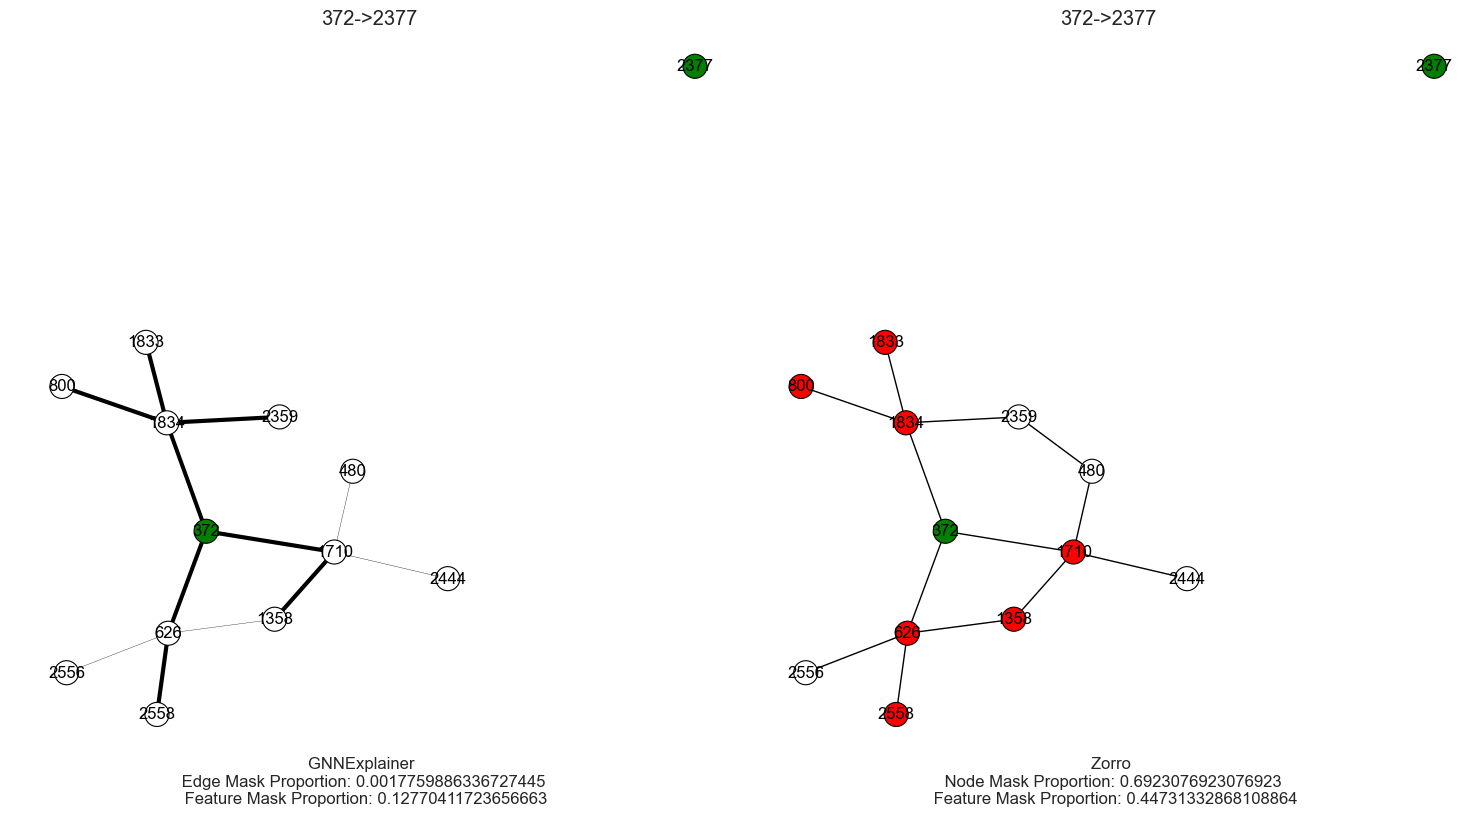

INFO:explainer:------ Start explaining edge tensor([[518],
        [666]])


Generating explanations for No.809 edge in the test data.
Source node 518, Target Node: 666
target:  1.0
pred:  0.7096816301345825
num_hops:  2



  0%|                                                                          | 0/35825 [00:00<?, ?it/s]
Explain edge tensor([[518],
        [666]]):   0%|                             | 0/35825 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[518],
        [666]])


initial_distortion:  0.59
num_hops:  2



INFO:explainer:------ Current fidelity 0.99
INFO:explainer:------ Finished explaining edge tensor([[518],
        [666]])

Explain edge tensor([[518],
        [666]]):   0%|                  | 1/35825 [00:01<16:09:43,  1.62s/it]

node_masks:  tensor([[1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
         1., 1., 0., 0., 1., 1., 1.]])
best_node:  9
impove_in_distortion_by_node:  0.13
best_feature:  1305
impove_in_distortion_by_feature:  0.13
count:  1
0.7
[nan, 1305, 0.7]
num_to_add_once:  2


Argmax [2, 20], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:00, 14.57it/s]

distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009


Argmax [10, 11], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00, 14.15it/s]

distortion_improve:  0.0
distortion_improve:  0.010000000000000009
best_node:  [10, 11]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  None
impove_in_distortion_by_feature:  -100




Explain edge tensor([[518],
        [666]]):   0%|                   | 2/35825 [00:02<9:33:33,  1.04it/s]

count:  2
0.71
[[10, 11], nan, 0.71]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], 0.020000000000000018:  25%|████████                        | 2/8 [00:00<00:00, 12.75it/s]

distortion_improve:  0.0
distortion_improve:  0.020000000000000018
distortion_improve:  0.0


Argmax [7, 15], 0.020000000000000018:  50%|████████████████                | 4/8 [00:00<00:00, 13.35it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.12:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.12


Argmax [664, 675, 710, 915, 922, 1079, 1151, 1177, 1274, 1359], 0.030000000000000027:   7%| | 2/30 [00:00

distortion_improve:  0.030000000000000027


Argmax [1381, 2, 44, 71, 88, 93, 135, 173, 203, 211], 0.040000000000000036:  10%| | 3/30 [00:00<00:02, 13

distortion_improve:  0.040000000000000036
best_node:  [7, 15]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [1381, 2, 44, 71, 88, 93, 135, 173, 203, 211]
impove_in_distortion_by_feature:  0.040000000000000036




Explain edge tensor([[518],
        [666]]):   0%|                   | 3/35825 [00:02<8:25:25,  1.18it/s]

count:  3
0.75
[nan, [1381, 2, 44, 71, 88, 93, 135, 173, 203, 211], 0.75]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], 0.020000000000000018:  25%|████████                        | 2/8 [00:00<00:00, 12.74it/s]

distortion_improve:  0.0
distortion_improve:  0.020000000000000018
distortion_improve:  0.0


Argmax [7, 15], 0.020000000000000018:  50%|████████████████                | 4/8 [00:00<00:00, 12.93it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.07999999999999996:   0%| | 0/30 [00:00<?

distortion_improve:  -0.07999999999999996


Argmax [664, 675, 710, 915, 922, 1079, 1151, 1177, 1274, 1359], 0.050000000000000044:   7%| | 2/30 [00:00

distortion_improve:  0.050000000000000044


Argmax [664, 675, 710, 915, 922, 1079, 1151, 1177, 1274, 1359], 0.050000000000000044:  10%| | 3/30 [00:00

distortion_improve:  -0.040000000000000036
best_node:  [7, 15]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [664, 675, 710, 915, 922, 1079, 1151, 1177, 1274, 1359]
impove_in_distortion_by_feature:  0.050000000000000044




Explain edge tensor([[518],
        [666]]):   0%|                   | 4/35825 [00:03<7:55:35,  1.26it/s]

count:  4
0.8
[nan, [664, 675, 710, 915, 922, 1079, 1151, 1177, 1274, 1359], 0.8]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [2, 20], -0.010000000000000009:  25%|███████▊                       | 2/8 [00:00<00:00, 11.85it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.020000000000000018


Argmax [16, 17], 0.0:  25%|████████████                                    | 2/8 [00:00<00:00, 11.85it/s]

distortion_improve:  0.0


Argmax [16, 17], 0.0:  50%|████████████████████████                        | 4/8 [00:00<00:00, 12.00it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.1100000000000001:   0%| | 0/30 [00:00<?,

distortion_improve:  -0.1100000000000001


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.050000000000000044:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.050000000000000044


Argmax [477, 540, 559, 588, 619, 661, 671, 677, 681, 699], 0.019999999999999907:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.019999999999999907
best_node:  [16, 17]
impove_in_distortion_by_node:  0.0
best_feature:  [477, 540, 559, 588, 619, 661, 671, 677, 681, 699]
impove_in_distortion_by_feature:  0.019999999999999907




Explain edge tensor([[518],
        [666]]):   0%|                   | 5/35825 [00:04<7:39:55,  1.30it/s]

count:  5
0.82
[nan, [477, 540, 559, 588, 619, 661, 671, 677, 681, 699], 0.82]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [2, 20], 0.0:  25%|████████████▎                                    | 2/8 [00:00<00:00, 13.35it/s]

distortion_improve:  0.0
distortion_improve:  0.0
distortion_improve:  0.0


Argmax [2, 20], 0.0:  50%|████████████████████████▌                        | 4/8 [00:00<00:00, 13.46it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.09999999999999998:   0%| | 0/30 [00:00<?

distortion_improve:  -0.09999999999999998


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.009999999999999898:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.009999999999999898


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.009999999999999898
best_node:  [2, 20]
impove_in_distortion_by_node:  0.0
best_feature:  [212, 228, 233, 247, 313, 365, 369, 402, 408, 443]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[518],
        [666]]):   0%|                   | 6/35825 [00:04<7:25:19,  1.34it/s]

count:  6
0.82
[[2, 20], nan, 0.82]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], 0.0:  33%|████████████████▎                                | 2/6 [00:00<00:00, 12.74it/s]

distortion_improve:  0.0
distortion_improve:  0.0


Argmax [1, 21], 0.020000000000000018:  50%|████████████████                | 3/6 [00:00<00:00, 12.74it/s]


distortion_improve:  0.020000000000000018
num_to_add_once:  10


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.009999999999999898:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.12
distortion_improve:  -0.009999999999999898


Argmax [704, 725, 749, 779, 820, 851, 860, 869, 873, 874], 0.0:  10%|▌    | 3/30 [00:00<00:02, 12.72it/s]

distortion_improve:  0.0
best_node:  [1, 21]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [704, 725, 749, 779, 820, 851, 860, 869, 873, 874]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                   | 7/35825 [00:05<7:01:59,  1.41it/s]

count:  7
0.84
[[1, 21], nan, 0.84]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [16, 17], -0.010000000000000009:  50%|███████████████               | 2/4 [00:00<00:00, 13.58it/s]


distortion_improve:  -0.029999999999999916
distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.14:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.14


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [704, 725, 749, 779, 820, 851, 860, 869, 873, 874], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  [16, 17]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [704, 725, 749, 779, 820, 851, 860, 869, 873, 874]
impove_in_distortion_by_feature:  -0.010000000000000009
Removing features:  [704, 725, 749, 779, 820, 851, 860, 869, 873, 874]




Explain edge tensor([[518],
        [666]]):   0%|                   | 8/35825 [00:06<6:25:30,  1.55it/s]

count:  8
0.84
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], -0.029999999999999916:   0%|                                       | 0/4 [00:00<?, ?it/s]

distortion_improve:  -0.029999999999999916


Argmax [16, 17], -0.010000000000000009:  50%|███████████████               | 2/4 [00:00<00:00, 12.51it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.14:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.14


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [903, 923, 939, 957, 988, 1022, 1049, 1072, 1076, 1118], -0.020000000000000018:  10%| | 3/30 [00:0

distortion_improve:  -0.020000000000000018
best_node:  [16, 17]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [903, 923, 939, 957, 988, 1022, 1049, 1072, 1076, 1118]
impove_in_distortion_by_feature:  -0.020000000000000018
tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0.]])
[16, 17]
Removing nodes:  [16, 17]




Explain edge tensor([[518],
        [666]]):   0%|                   | 9/35825 [00:06<5:57:41,  1.67it/s]

count:  9
0.84
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], -0.029999999999999916:  50%|███████████████▌               | 1/2 [00:00<00:00, 12.20it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.14:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.14


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.029999999999999916:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.029999999999999916


Argmax [903, 923, 939, 957, 988, 1022, 1049, 1072, 1076, 1118], -0.020000000000000018:  10%| | 3/30 [00:0

distortion_improve:  -0.020000000000000018
best_node:  [7, 15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [903, 923, 939, 957, 988, 1022, 1049, 1072, 1076, 1118]
impove_in_distortion_by_feature:  -0.020000000000000018
Removing features:  [903, 923, 939, 957, 988, 1022, 1049, 1072, 1076, 1118]




Explain edge tensor([[518],
        [666]]):   0%|                  | 10/35825 [00:07<5:40:45,  1.75it/s]

count:  10
0.84
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], -0.029999999999999916:  50%|███████████████▌               | 1/2 [00:00<00:00,  9.38it/s]


distortion_improve:  -0.029999999999999916
num_to_add_once:  10


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.029999999999999916:   3%| | 1/30 [00:00<00:

distortion_improve:  -0.14
distortion_improve:  -0.029999999999999916


Argmax [1143, 1144, 1156, 1170, 1189, 1202, 1207, 1254, 1271, 1331], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  0.010000000000000009
best_node:  [7, 15]
impove_in_distortion_by_node:  -0.029999999999999916
best_feature:  [1143, 1144, 1156, 1170, 1189, 1202, 1207, 1254, 1271, 1331]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 11/35825 [00:07<5:31:31,  1.80it/s]

count:  11
0.85
[nan, [1143, 1144, 1156, 1170, 1189, 1202, 1207, 1254, 1271, 1331], 0.85]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], 0.010000000000000009:  50%|████████████████                | 1/2 [00:00<00:00, 13.15it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.13:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.13


Argmax [1342, 1349, 1355, 1360, 1365, 1397, 1423, 1429, 6, 20], 0.010000000000000009:  10%| | 3/30 [00:00

distortion_improve:  -0.04999999999999993
distortion_improve:  0.010000000000000009
best_node:  [7, 15]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [1342, 1349, 1355, 1360, 1365, 1397, 1423, 1429, 6, 20]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 12/35825 [00:08<5:02:53,  1.97it/s]

count:  12
0.86
[nan, [1342, 1349, 1355, 1360, 1365, 1397, 1423, 1429, 6, 20], 0.86]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2


Argmax [7, 15], 0.010000000000000009:  50%|████████████████                | 1/2 [00:00<00:00, 16.28it/s]


distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.10999999999999999
distortion_improve:  -0.010000000000000009


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  [7, 15]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [212, 228, 233, 247, 313, 365, 369, 402, 408, 443]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 13/35825 [00:08<4:36:56,  2.16it/s]

count:  13
0.87
[[7, 15], nan, 0.87]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.13:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.13


Argmax [212, 228, 233, 247, 313, 365, 369, 402, 408, 443], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [212, 228, 233, 247, 313, 365, 369, 402, 408, 443]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 14/35825 [00:08<3:58:10,  2.51it/s]

count:  14
0.87
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.13:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.13


Argmax [23, 25, 26, 35, 39, 41, 43, 51, 57, 62], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 16.78i

distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [23, 25, 26, 35, 39, 41, 43, 51, 57, 62]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 15/35825 [00:08<3:29:18,  2.85it/s]

count:  15
0.87
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.13:   0%|        | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.13


Argmax [121, 125, 129, 131, 132, 133, 139, 147, 154, 155], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [121, 125, 129, 131, 132, 133, 139, 147, 154, 155]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 16/35825 [00:09<3:23:09,  2.94it/s]

count:  16
0.88
[nan, [121, 125, 129, 131, 132, 133, 139, 147, 154, 155], 0.88]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [68, 81, 84, 85, 87, 89, 95, 99, 103, 120], 0.0:  10%|█▎           | 3/30 [00:00<00:01, 16.29it/s]

distortion_improve:  -0.13
distortion_improve:  0.0
distortion_improve:  -0.050000000000000044
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [68, 81, 84, 85, 87, 89, 95, 99, 103, 120]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                  | 17/35825 [00:09<3:17:00,  3.03it/s]

count:  17
0.88
[nan, [68, 81, 84, 85, 87, 89, 95, 99, 103, 120], 0.88]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [221, 239, 257, 263, 274, 280, 284, 286, 310, 314], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.15000000000000002
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [221, 239, 257, 263, 274, 280, 284, 286, 310, 314]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 18/35825 [00:09<3:02:12,  3.28it/s]

count:  18
0.88
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [320, 323, 330, 335, 336, 337, 339, 345, 348, 351], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.15000000000000002
distortion_improve:  -0.020000000000000018
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [320, 323, 330, 335, 336, 337, 339, 345, 348, 351]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 19/35825 [00:10<3:00:21,  3.31it/s]

count:  19
0.89
[nan, [320, 323, 330, 335, 336, 337, 339, 345, 348, 351], 0.89]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [161, 168, 172, 178, 179, 180, 204, 205, 208, 214], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.14
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [161, 168, 172, 178, 179, 180, 204, 205, 208, 214]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[518],
        [666]]):   0%|                  | 20/35825 [00:10<2:49:41,  3.52it/s]

count:  20
0.89
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [416, 417, 420, 422, 428, 429, 430, 431, 432, 433], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.14
distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [416, 417, 420, 422, 428, 429, 430, 431, 432, 433]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 21/35825 [00:10<2:42:03,  3.68it/s]

count:  21
0.89
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [437, 440, 442, 451, 458, 460, 464, 467, 469, 472], -0.030000000000000027:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.14
distortion_improve:  -0.050000000000000044
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [437, 440, 442, 451, 458, 460, 464, 467, 469, 472]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[518],
        [666]]):   0%|                  | 22/35825 [00:10<2:36:29,  3.81it/s]

count:  22
0.89
None


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [485, 486, 495, 497, 498, 510, 512, 513, 517, 519], 0.0:  10%|▌    | 3/30 [00:00<00:01, 16.79it/s]

distortion_improve:  -0.14
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [485, 486, 495, 497, 498, 510, 512, 513, 517, 519]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                  | 23/35825 [00:11<2:42:49,  3.66it/s]

count:  23
0.89
[nan, [485, 486, 495, 497, 498, 510, 512, 513, 517, 519], 0.89]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [535, 536, 539, 551, 552, 577, 584, 591, 592, 612], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.020000000000000018
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [535, 536, 539, 551, 552, 577, 584, 591, 592, 612]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 24/35825 [00:11<2:46:21,  3.59it/s]

count:  24
0.9
[nan, [535, 536, 539, 551, 552, 577, 584, 591, 592, 612], 0.9]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [615, 623, 625, 639, 644, 646, 666, 668, 673, 676], 0.030000000000000027:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.08000000000000007
distortion_improve:  0.0
distortion_improve:  0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [615, 623, 625, 639, 644, 646, 666, 668, 673, 676]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[518],
        [666]]):   0%|                  | 25/35825 [00:11<2:49:58,  3.51it/s]

count:  25
0.93
[nan, [615, 623, 625, 639, 644, 646, 666, 668, 673, 676], 0.93]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [694, 695, 696, 697, 698, 700, 718, 723, 726, 734], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.13
distortion_improve:  -0.030000000000000027
distortion_improve:  0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [694, 695, 696, 697, 698, 700, 718, 723, 726, 734]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[518],
        [666]]):   0%|                  | 26/35825 [00:11<2:52:34,  3.46it/s]

count:  26
0.94
[nan, [694, 695, 696, 697, 698, 700, 718, 723, 726, 734], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [736, 743, 746, 750, 753, 756, 758, 759, 760, 762], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.1399999999999999
distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [736, 743, 746, 750, 753, 756, 758, 759, 760, 762]
impove_in_distortion_by_feature:  -0.009999999999999898


count:  27
0.94
None


Explain edge tensor([[518],
        [666]]):   0%|                  | 27/35825 [00:12<2:48:18,  3.54it/s]



possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [763, 776, 777, 778, 783, 805, 808, 809, 810, 812], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.63it/s]

distortion_improve:  -0.1399999999999999
distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [763, 776, 777, 778, 783, 805, 808, 809, 810, 812]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                  | 28/35825 [00:12<2:54:35,  3.42it/s]

count:  28
0.94
[nan, [763, 776, 777, 778, 783, 805, 808, 809, 810, 812], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [353, 359, 375, 377, 379, 395, 398, 401, 406, 414], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.89it/s]

distortion_improve:  -0.12
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [353, 359, 375, 377, 379, 395, 398, 401, 406, 414]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                  | 29/35825 [00:12<2:58:13,  3.35it/s]

count:  29
0.94
[nan, [353, 359, 375, 377, 379, 395, 398, 401, 406, 414], 0.94]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [821, 827, 828, 830, 838, 840, 861, 863, 872, 876], 0.0:   7%|▎    | 2/30 [00:00<00:02, 11.34it/s]

distortion_improve:  -0.15999999999999992
distortion_improve:  0.0


Argmax [882, 884, 893, 900, 906, 910, 911, 912, 913, 916], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[518],
        [666]]):   0%|                  | 30/35825 [00:13<3:22:59,  2.94it/s]

distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [882, 884, 893, 900, 906, 910, 911, 912, 913, 916]
impove_in_distortion_by_feature:  0.010000000000000009
count:  30
0.95
[nan, [882, 884, 893, 900, 906, 910, 911, 912, 913, 916], 0.95]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [929, 936, 950, 959, 962, 963, 965, 969, 971, 973], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.13
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [929, 936, 950, 959, 962, 963, 965, 969, 971, 973]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 31/35825 [00:13<3:22:56,  2.94it/s]

count:  31
0.96
[nan, [929, 936, 950, 959, 962, 963, 965, 969, 971, 973], 0.96]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [821, 827, 828, 830, 838, 840, 861, 863, 872, 876], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.09999999999999998
distortion_improve:  -0.010000000000000009


Argmax [974, 980, 990, 993, 994, 996, 1005, 1012, 1018, 1019], 0.0:  10%| | 3/30 [00:00<00:01, 14.77it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [974, 980, 990, 993, 994, 996, 1005, 1012, 1018, 1019]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                  | 32/35825 [00:13<3:22:34,  2.94it/s]

count:  32
0.96
[nan, [974, 980, 990, 993, 994, 996, 1005, 1012, 1018, 1019], 0.96]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [821, 827, 828, 830, 838, 840, 861, 863, 872, 876], 0.0:   7%|▎    | 2/30 [00:00<00:01, 14.99it/s]

distortion_improve:  -0.07999999999999996
distortion_improve:  0.0


Argmax [821, 827, 828, 830, 838, 840, 861, 863, 872, 876], 0.0:  10%|▌    | 3/30 [00:00<00:01, 15.06it/s]


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [821, 827, 828, 830, 838, 840, 861, 863, 872, 876]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[518],
        [666]]):   0%|                  | 33/35825 [00:14<3:21:03,  2.97it/s]

count:  33
0.96
[nan, [821, 827, 828, 830, 838, 840, 861, 863, 872, 876], 0.96]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.08999999999999997:   0%| | 0/30 [00:00<?

distortion_improve:  -0.08999999999999997


Argmax [1024, 1030, 1035, 1036, 1038, 1039, 1042, 1051, 1052, 1054], 0.010000000000000009:   7%| | 2/30 [

distortion_improve:  0.010000000000000009


Argmax [1024, 1030, 1035, 1036, 1038, 1039, 1042, 1051, 1052, 1054], 0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1024, 1030, 1035, 1036, 1038, 1039, 1042, 1051, 1052, 1054]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[518],
        [666]]):   0%|                  | 34/35825 [00:14<3:22:06,  2.95it/s]

count:  34
0.97
[nan, [1024, 1030, 1035, 1036, 1038, 1039, 1042, 1051, 1052, 1054], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax None, -1000:   0%|                                                         | 0/30 [00:00<?, ?it/s]

distortion_improve: 

Argmax [1066, 1067, 1081, 1082, 1085, 1088, 1090, 1092, 1093, 1099], -0.010000000000000009:   7%| | 2/30 

 -0.06999999999999995
distortion_improve:  -0.010000000000000009


Argmax [1105, 1109, 1119, 1134, 1137, 1142, 1159, 1172, 1179, 1180], 0.0:  10%| | 3/30 [00:00<00:01, 14.9

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1105, 1109, 1119, 1134, 1137, 1142, 1159, 1172, 1179, 1180]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                  | 35/35825 [00:14<3:21:40,  2.96it/s]

count:  35
0.97
[nan, [1105, 1109, 1119, 1134, 1137, 1142, 1159, 1172, 1179, 1180], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1066, 1067, 1081, 1082, 1085, 1088, 1090, 1092, 1093, 1099], 0.0:   7%| | 2/30 [00:00<00:01, 14.8

distortion_improve:  -0.06999999999999995
distortion_improve:  0.0


Argmax [1066, 1067, 1081, 1082, 1085, 1088, 1090, 1092, 1093, 1099], 0.0:  10%| | 3/30 [00:00<00:01, 14.8

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1066, 1067, 1081, 1082, 1085, 1088, 1090, 1092, 1093, 1099]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[518],
        [666]]):   0%|                  | 36/35825 [00:15<3:21:16,  2.96it/s]

count:  36
0.97
[nan, [1066, 1067, 1081, 1082, 1085, 1088, 1090, 1092, 1093, 1099], 0.97]


possible_nodes change:  tensor([[0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 0.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [814, 859, 541, 1174, 390, 1338, 1352, 118, 150, 338], -0.06999999999999995:   0%| | 0/30 [00:00<?

distortion_improve:  -0.06999999999999995


Argmax [1182, 1183, 1198, 1201, 1203, 1204, 1205, 1208, 1218, 1225], 0.010000000000000009:   7%| | 2/30 [

distortion_improve:  0.010000000000000009


Argmax [1182, 1183, 1198, 1201, 1203, 1204, 1205, 1208, 1218, 1225], 0.010000000000000009:  10%| | 3/30 [


distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1182, 1183, 1198, 1201, 1203, 1204, 1205, 1208, 1218, 1225]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[518],
Explain edge tensor([[518],             | 37/35825 [00:15<3:20:52,  2.97it/s]
        [666]]):   0%|                  | 37/35825 [00:15<4:12:28,  2.36it/s]
INFO:explainer:------ Finished explaining edge tensor([[518],
        [666]])


count:  37
0.98
[nan, [1182, 1183, 1198, 1201, 1203, 1204, 1205, 1208, 1218, 1225], 0.98]
[(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32), array([[0., 0., 1., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.59], [nan, 1305, 0.7], [[10, 11], nan, 0.71], [nan, [1381, 2, 44, 71, 88, 93, 135, 173, 203, 211], 0.75], [nan, [664, 675, 710, 915, 922, 1079, 1151, 1177, 1274, 1359], 0.8], [nan, [477, 540, 559, 588, 619, 661, 671, 677, 681, 699], 0.82], [[2, 20], nan, 0.82], [[1, 21], nan, 0.84], None, None, None, [nan, [1143, 1144, 1156, 1170, 1189, 1202, 1207, 1254, 1271, 1331], 0.85], [nan, [1342, 1349, 1355, 1360, 1365, 1397, 1423, 1429, 6, 20], 0.86], [[7, 15], nan, 0.87], None, None, [nan, [121, 125, 129, 131, 132, 133, 139, 147, 154, 155], 0.88], [nan, [68, 81, 84, 85, 87, 89, 95, 99, 103, 120], 0.88], None, [nan, [320, 323, 330, 335, 336, 337, 339, 345, 348, 351], 0.89], None, None, None, [nan, [485, 4

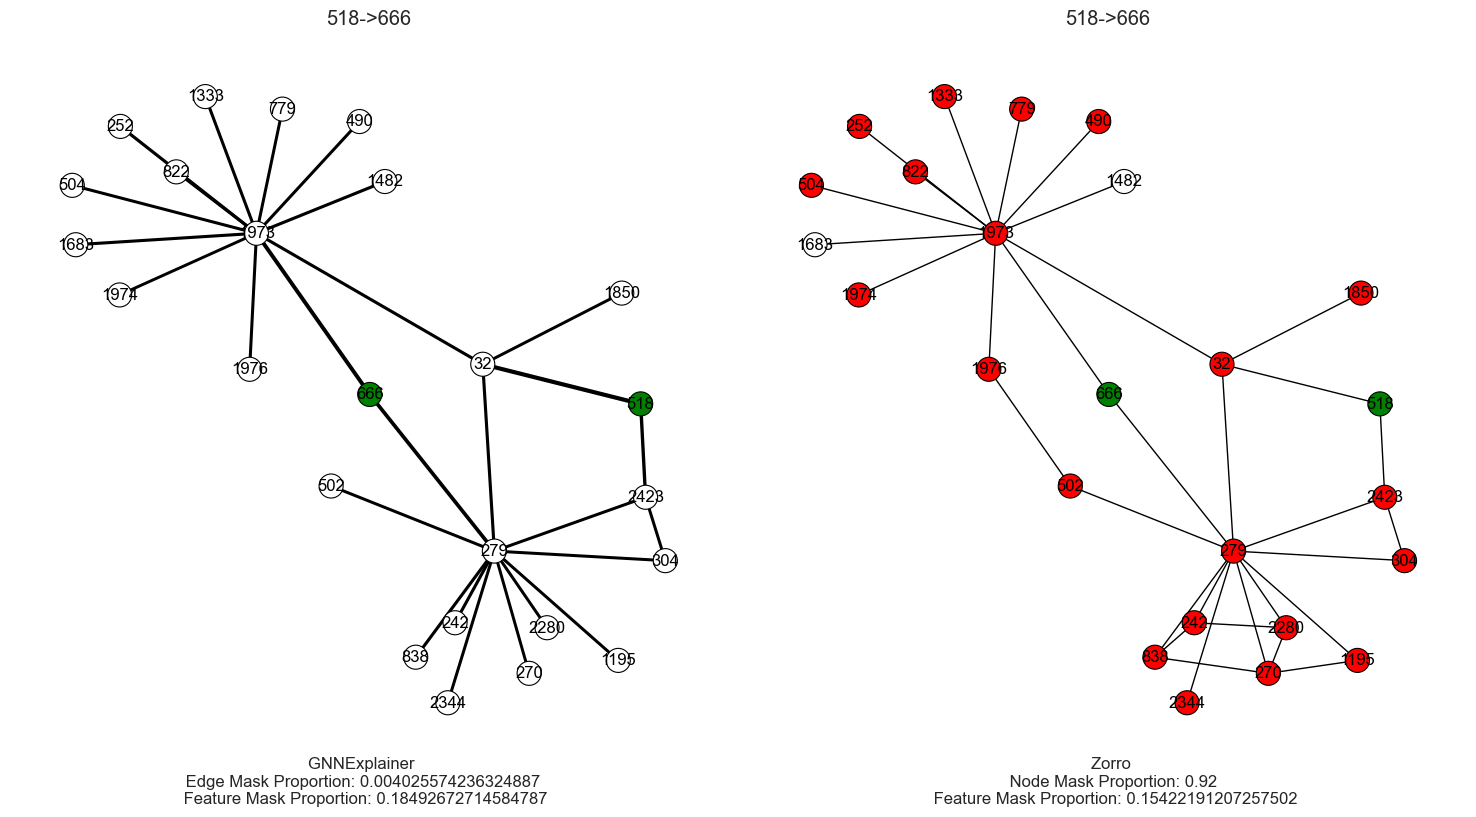

INFO:explainer:------ Start explaining edge tensor([[  16],
        [2444]])


Generating explanations for No.86 edge in the test data.
Source node 16, Target Node: 2444
target:  1.0
pred:  0.5995500683784485
num_hops:  2



  0%|                                                                          | 0/28660 [00:00<?, ?it/s]
Explain edge tensor([[  16],
        [2444]]):   0%|                           | 0/28660 [00:00<?, ?it/s]INFO:explainer:------ Start explaining edge tensor([[  16],
        [2444]])


initial_distortion:  0.48
num_hops:  2




Explain edge tensor([[  16],
        [2444]]):   0%|                | 1/28660 [00:01<10:57:04,  1.38s/it]

node_masks:  tensor([[0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
         0., 0.]])
best_node:  0
impove_in_distortion_by_node:  0.050000000000000044
best_feature:  19
impove_in_distortion_by_feature:  0.030000000000000027
count:  1
0.48
[0, nan, 0.48]
num_to_add_once:  10


Argmax [19, 89, 118, 168, 356, 368, 495, 548, 884, 1042], 0.07000000000000006:  10%| | 3/30 [00:00<00:01,

Explain edge tensor([[  16],
        [2444]]):   0%|                 | 2/28660 [00:01<5:31:09,  1.44it/s]

distortion_improve:  0.07000000000000006
distortion_improve:  0.030000000000000027
distortion_improve:  0.050000000000000044
best_node:  None
impove_in_distortion_by_node:  -100
best_feature:  [19, 89, 118, 168, 356, 368, 495, 548, 884, 1042]
impove_in_distortion_by_feature:  0.07000000000000006
count:  2
0.55
[nan, [19, 89, 118, 168, 356, 368, 495, 548, 884, 1042], 0.55]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2


Argmax [9, 16], 0.10999999999999999:  57%|██████████████████▊              | 4/7 [00:00<00:00, 23.51it/s]


distortion_improve:  0.06999999999999995
distortion_improve:  0.019999999999999907
distortion_improve:  0.10999999999999999
distortion_improve:  0.019999999999999907
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], 0.04999999999999993:   0%| | 0/30 [00:00<?, 

distortion_improve:  0.04999999999999993


Argmax [396, 693, 756, 783, 1005, 1075, 1122, 1138, 1149, 1176], 0.08999999999999997:  10%| | 3/30 [00:00

Explain edge tensor([[  16],
        [2444]]):   0%|                 | 3/28660 [00:02<4:32:33,  1.75it/s]

distortion_improve:  0.08999999999999997
distortion_improve:  -0.010000000000000009
best_node:  [9, 16]
impove_in_distortion_by_node:  0.10999999999999999
best_feature:  [396, 693, 756, 783, 1005, 1075, 1122, 1138, 1149, 1176]
impove_in_distortion_by_feature:  0.08999999999999997
count:  3
0.66
[[9, 16], nan, 0.66]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2


Argmax [4, 13], 0.05999999999999994:  60%|███████████████████▊             | 3/5 [00:00<00:00, 19.35it/s]


distortion_improve:  0.05999999999999994
distortion_improve:  0.0
distortion_improve:  0.010000000000000009
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], 0.0:   0%|           | 0/30 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [396, 693, 756, 783, 1005, 1075, 1122, 1138, 1149, 1176], 0.06999999999999995:  10%| | 3/30 [00:00

Explain edge tensor([[  16],
        [2444]]):   0%|                 | 4/28660 [00:02<3:57:24,  2.01it/s]

distortion_improve:  0.06999999999999995
distortion_improve:  0.010000000000000009
best_node:  [4, 13]
impove_in_distortion_by_node:  0.05999999999999994
best_feature:  [396, 693, 756, 783, 1005, 1075, 1122, 1138, 1149, 1176]
impove_in_distortion_by_feature:  0.06999999999999995
count:  4
0.73
[nan, [396, 693, 756, 783, 1005, 1075, 1122, 1138, 1149, 1176], 0.73]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2


Argmax [4, 13], 0.030000000000000027:   0%|                                        | 0/5 [00:00<?, ?it/s]

distortion_improve:  0.030000000000000027


Argmax [4, 13], 0.030000000000000027:  60%|███████████████████▏            | 3/5 [00:00<00:00, 18.19it/s]


distortion_improve:  0.0
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29], 0.0:   3%|▎        | 1/30 [00:00<00:02, 11.66it/s]

distortion_improve:  -0.010000000000000009
distortion_improve:  0.0


Argmax [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29], 0.0:  10%|▉        | 3/30 [00:00<00:01, 21.72it/s]

distortion_improve:  -0.010000000000000009
best_node:  [4, 13]
impove_in_distortion_by_node:  0.030000000000000027
best_feature:  [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                 | 5/28660 [00:02<3:42:54,  2.14it/s]

count:  5
0.76
[[4, 13], nan, 0.76]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2


Argmax [10, 19], 0.0:   0%|                                                        | 0/3 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [10, 19], 0.0:  67%|████████████████████████████████                | 2/3 [00:00<00:00, 13.97it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29], 0.030000000000000027:   7%| | 2/30 [00:00<00:01, 1

distortion_improve:  0.0
distortion_improve:  0.030000000000000027


Argmax [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29], 0.030000000000000027:  10%| | 3/30 [00:00<00:01, 1

distortion_improve:  0.010000000000000009
best_node:  [10, 19]
impove_in_distortion_by_node:  0.0
best_feature:  [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29]
impove_in_distortion_by_feature:  0.030000000000000027




Explain edge tensor([[  16],
        [2444]]):   0%|                 | 6/28660 [00:03<3:45:31,  2.12it/s]

count:  6
0.79
[nan, [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29], 0.79]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2


Argmax [18], 0.0:  67%|██████████████████████████████████▋                 | 2/3 [00:00<00:00, 16.23it/s]


distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], -0.030000000000000027:   0%| | 0/30 [00:00<?

distortion_improve:  -0.030000000000000027


Argmax [39, 50, 52, 54, 62, 63, 70, 79, 101, 103], 0.0:   7%|▊            | 2/30 [00:00<00:01, 17.32it/s]

distortion_improve:  0.0


Argmax [39, 50, 52, 54, 62, 63, 70, 79, 101, 103], 0.0:  10%|█▎           | 3/30 [00:00<00:01, 18.28it/s]


distortion_improve:  -0.020000000000000018
best_node:  [18]
impove_in_distortion_by_node:  0.0
best_feature:  [39, 50, 52, 54, 62, 63, 70, 79, 101, 103]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  16],
        [2444]]):   0%|                 | 7/28660 [00:03<3:32:40,  2.25it/s]

count:  7
0.79
[nan, [39, 50, 52, 54, 62, 63, 70, 79, 101, 103], 0.79]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2


Argmax [10, 19], 0.0:   0%|                                                        | 0/3 [00:00<?, ?it/s]

distortion_improve:  0.0


Argmax [10, 19], 0.0:  67%|████████████████████████████████                | 2/3 [00:00<00:00, 16.13it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], -0.020000000000000018:   0%| | 0/30 [00:00<?

distortion_improve:  -0.020000000000000018


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], -0.020000000000000018:   7%| | 2/30 [00:00<0

distortion_improve:  -0.020000000000000018


Argmax [179, 201, 203, 208, 211, 218, 227, 230, 234, 237], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  [10, 19]
impove_in_distortion_by_node:  0.0
best_feature:  [179, 201, 203, 208, 211, 218, 227, 230, 234, 237]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                 | 8/28660 [00:04<3:25:48,  2.32it/s]

count:  8
0.79
[[10, 19], nan, 0.79]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2


Argmax [18], 0.0: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.68it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], -0.020000000000000018:   7%| | 2/30 [00:00<0

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.020000000000000018


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], -0.020000000000000018:  10%| | 3/30 [00:00<0

distortion_improve:  -0.020000000000000018
best_node:  [18]
impove_in_distortion_by_node:  0.0
best_feature:  [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[  16],
        [2444]]):   0%|                 | 9/28660 [00:04<3:09:13,  2.52it/s]

count:  9
0.79
[[18], nan, 0.79]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], -0.030000000000000027:   0%| | 0/30 [00:00<?

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.010000000000000009


Argmax [108, 124, 126, 128, 135, 145, 146, 154, 160, 177], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [108, 124, 126, 128, 135, 145, 146, 154, 160, 177]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 10/28660 [00:04<2:42:21,  2.94it/s]

count:  10
0.79
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [179, 201, 203, 208, 211, 218, 227, 230, 234, 237], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018


Argmax [179, 201, 203, 208, 211, 218, 227, 230, 234, 237], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [179, 201, 203, 208, 211, 218, 227, 230, 234, 237]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[  16],
        [2444]]):   0%|                | 11/28660 [00:04<2:24:23,  3.31it/s]

count:  11
0.79
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], -0.030000000000000027:   7%| | 2/30 [00:00<0

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.040000000000000036


Argmax [329, 333, 335, 338, 339, 361, 363, 367, 369, 370], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.37it/s]

distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [329, 333, 335, 338, 339, 361, 363, 367, 369, 370]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 12/28660 [00:05<2:19:02,  3.43it/s]

count:  12
0.79
[nan, [329, 333, 335, 338, 339, 361, 363, 367, 369, 370], 0.79]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], 0.010000000000000009:   0%| | 0/30 [00:00<?,

distortion_improve:  0.010000000000000009


Argmax [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], 0.010000000000000009:  10%| | 3/30 [00:00<00

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 13/28660 [00:05<2:16:34,  3.50it/s]

count:  13
0.8
[nan, [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], 0.8]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [478, 479, 492, 523, 534, 536, 539, 540, 546, 556], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [478, 479, 492, 523, 534, 536, 539, 540, 546, 556]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 14/28660 [00:05<2:14:07,  3.56it/s]

count:  14
0.81
[nan, [478, 479, 492, 523, 534, 536, 539, 540, 546, 556], 0.81]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [377, 383, 390, 393, 394, 414, 420, 434, 442, 462], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.84it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [377, 383, 390, 393, 394, 414, 420, 434, 442, 462]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 15/28660 [00:05<2:13:32,  3.57it/s]

count:  15
0.81
[nan, [377, 383, 390, 393, 394, 414, 420, 434, 442, 462], 0.81]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [646, 652, 653, 661, 666, 689, 694, 700, 706, 709], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.030000000000000027
distortion_improve:  0.0
distortion_improve:  0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [646, 652, 653, 661, 666, 689, 694, 700, 706, 709]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[  16],
        [2444]]):   0%|                | 16/28660 [00:06<2:10:51,  3.65it/s]

count:  16
0.82
[nan, [646, 652, 653, 661, 666, 689, 694, 700, 706, 709], 0.82]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [559, 562, 565, 573, 578, 587, 605, 606, 621, 645], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.84it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [559, 562, 565, 573, 578, 587, 605, 606, 621, 645]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 17/28660 [00:06<2:09:50,  3.68it/s]

count:  17
0.82
[nan, [559, 562, 565, 573, 578, 587, 605, 606, 621, 645], 0.82]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [723, 732, 746, 758, 760, 772, 775, 776, 778, 779], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.019999999999999907
distortion_improve:  0.010000000000000009
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [723, 732, 746, 758, 760, 772, 775, 776, 778, 779]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 18/28660 [00:06<2:10:58,  3.64it/s]

count:  18
0.83
[nan, [723, 732, 746, 758, 760, 772, 775, 776, 778, 779], 0.83]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [786, 796, 801, 807, 808, 813, 816, 817, 818, 859], -0.010000000000000009:  10%| | 3/30 [00:00<00:

Explain edge tensor([[  16],
        [2444]]):   0%|                | 19/28660 [00:06<2:00:15,  3.97it/s]

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.019999999999999907
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [786, 796, 801, 807, 808, 813, 816, 817, 818, 859]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  19
0.83
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [924, 936, 940, 950, 973, 995, 999, 1004, 1007, 1014], -0.010000000000000009:  10%| | 3/30 [00:00<


distortion_improve:  -0.039999999999999925
distortion_improve:  -0.019999999999999907
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [924, 936, 940, 950, 973, 995, 999, 1004, 1007, 1014]
impove_in_distortion_by_feature:  -0.010000000000000009



Explain edge tensor([[  16],
        [2444]]):   0%|                | 20/28660 [00:07<1:58:14,  4.04it/s]

count:  20
0.83
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1017, 1036, 1039, 1050, 1058, 1071, 1106, 1117, 1120, 1132], 0.0:  10%| | 3/30 [00:00<00:01, 20.6


distortion_improve:  -0.039999999999999925
distortion_improve:  -0.019999999999999907
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1017, 1036, 1039, 1050, 1058, 1071, 1106, 1117, 1120, 1132]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  16],
        [2444]]):   0%|                | 21/28660 [00:07<2:00:22,  3.97it/s]

count:  21
0.83
[nan, [1017, 1036, 1039, 1050, 1058, 1071, 1106, 1117, 1120, 1132], 0.83]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [870, 882, 891, 892, 894, 896, 906, 911, 912, 915], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.019999999999999907
distortion_improve:  0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [870, 882, 891, 892, 894, 896, 906, 911, 912, 915]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 22/28660 [00:07<2:00:20,  3.97it/s]

count:  22
0.84
[nan, [870, 882, 891, 892, 894, 896, 906, 911, 912, 915], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1212, 1213, 1215, 1217, 1218, 1224, 1226, 1233, 1234, 1236], -0.020000000000000018:  10%| | 3/30 

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.029999999999999916
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1212, 1213, 1215, 1217, 1218, 1224, 1226, 1233, 1234, 1236]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[  16],
        [2444]]):   0%|                | 23/28660 [00:07<1:55:26,  4.13it/s]

count:  23
0.84
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1255, 1256, 1260, 1262, 1266, 1273, 1278, 1291, 1292, 1314], 0.0:  10%| | 3/30 [00:00<00:01, 18.2

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1255, 1256, 1260, 1262, 1266, 1273, 1278, 1291, 1292, 1314]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 24/28660 [00:08<2:00:46,  3.95it/s]

count:  24
0.84
[nan, [1255, 1256, 1260, 1262, 1266, 1273, 1278, 1291, 1292, 1314], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [250, 262, 270, 272, 275, 281, 302, 305, 313, 324], -0.020000000000000018:  10%| | 3/30 [00:00<00:

Explain edge tensor([[  16],
        [2444]]):   0%|                | 25/28660 [00:08<1:52:33,  4.24it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.029999999999999916
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [250, 262, 270, 272, 275, 281, 302, 305, 313, 324]
impove_in_distortion_by_feature:  -0.020000000000000018
count:  25
0.84
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1134, 1139, 1141, 1162, 1164, 1165, 1172, 1173, 1175, 1206], -0.029999999999999916:   0%| | 0/30 

distortion_improve:  -0.029999999999999916


Argmax [3, 5, 6, 7, 8, 9, 10, 11, 12, 13], 0.0:  10%|██                   | 3/30 [00:00<00:01, 19.44it/s]

Explain edge tensor([[  16],
        [2444]]):   0%|                | 26/28660 [00:08<1:55:08,  4.14it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [3, 5, 6, 7, 8, 9, 10, 11, 12, 13]
impove_in_distortion_by_feature:  0.0
count:  26
0.84
[nan, [3, 5, 6, 7, 8, 9, 10, 11, 12, 13], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1325, 1332, 1338, 1365, 1376, 1379, 1398, 1406, 1413, 1415], -0.020000000000000018:  10%| | 3/30 


distortion_improve:  -0.029999999999999916
distortion_improve:  -0.020000000000000018
distortion_improve:  -0.029999999999999916
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1325, 1332, 1338, 1365, 1376, 1379, 1398, 1406, 1413, 1415]
impove_in_distortion_by_feature:  -0.020000000000000018



Explain edge tensor([[  16],
        [2444]]):   0%|                | 27/28660 [00:08<1:55:58,  4.11it/s]

count:  27
0.84
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [31, 32, 33, 34, 35, 36, 37, 40, 42, 43], -0.020000000000000018:  10%| | 3/30 [00:00<00:01, 16.20i

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.029999999999999916
distortion_improve:  -0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [31, 32, 33, 34, 35, 36, 37, 40, 42, 43]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[  16],
        [2444]]):   0%|                | 28/28660 [00:09<1:56:24,  4.10it/s]

count:  28
0.84
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [44, 45, 46, 47, 48, 49, 51, 53, 55, 56], -0.010000000000000009:  10%| | 3/30 [00:00<00:01, 17.13i

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.029999999999999916
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [44, 45, 46, 47, 48, 49, 51, 53, 55, 56]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 29/28660 [00:09<1:54:52,  4.15it/s]

count:  29
0.84
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [58, 59, 60, 61, 64, 66, 68, 69, 71, 72], 0.0:  10%|█▌             | 3/30 [00:00<00:01, 20.74it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [58, 59, 60, 61, 64, 66, 68, 69, 71, 72]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 30/28660 [00:09<1:55:02,  4.15it/s]

count:  30
0.84
[nan, [58, 59, 60, 61, 64, 66, 68, 69, 71, 72], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1134, 1139, 1141, 1162, 1164, 1165, 1172, 1173, 1175, 1206], -0.029999999999999916:  10%| | 3/30 

Explain edge tensor([[  16],
        [2444]]):   0%|                | 31/28660 [00:09<1:46:36,  4.48it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.04999999999999993
distortion_improve:  -0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1134, 1139, 1141, 1162, 1164, 1165, 1172, 1173, 1175, 1206]
impove_in_distortion_by_feature:  -0.029999999999999916
count:  31
0.84
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [15, 17, 18, 20, 21, 22, 23, 24, 25, 30], -0.04999999999999993:   0%|      | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.04999999999999993


Argmax [87, 90, 91, 92, 93, 96, 97, 100, 102, 104], 0.0:  10%|█▏          | 3/30 [00:00<00:01, 20.03it/s]

Explain edge tensor([[  16],
        [2444]]):   0%|                | 32/28660 [00:10<1:49:40,  4.35it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [87, 90, 91, 92, 93, 96, 97, 100, 102, 104]
impove_in_distortion_by_feature:  0.0
count:  32
0.84
[nan, [87, 90, 91, 92, 93, 96, 97, 100, 102, 104], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [105, 106, 107, 109, 110, 111, 112, 113, 114, 115], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.20it/s]


distortion_improve:  -0.039999999999999925
distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [105, 106, 107, 109, 110, 111, 112, 113, 114, 115]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  16],
        [2444]]):   0%|                | 33/28660 [00:10<1:55:14,  4.14it/s]

count:  33
0.84
[nan, [105, 106, 107, 109, 110, 111, 112, 113, 114, 115], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [116, 117, 119, 120, 122, 127, 129, 133, 136, 137], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.69it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [116, 117, 119, 120, 122, 127, 129, 133, 136, 137]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 34/28660 [00:10<1:55:00,  4.15it/s]

count:  34
0.84
[nan, [116, 117, 119, 120, 122, 127, 129, 133, 136, 137], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [138, 139, 141, 142, 143, 144, 147, 148, 149, 150], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.67it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [138, 139, 141, 142, 143, 144, 147, 148, 149, 150]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 35/28660 [00:10<1:56:05,  4.11it/s]

count:  35
0.84
[nan, [138, 139, 141, 142, 143, 144, 147, 148, 149, 150], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [15, 17, 18, 20, 21, 22, 23, 24, 25, 30], -0.029999999999999916:  10%| | 3/30 [00:00<00:01, 20.96i

Explain edge tensor([[  16],
        [2444]]):   0%|                | 36/28660 [00:10<1:47:58,  4.42it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.029999999999999916
distortion_improve:  -0.039999999999999925
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [15, 17, 18, 20, 21, 22, 23, 24, 25, 30]
impove_in_distortion_by_feature:  -0.029999999999999916
count:  36
0.84
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [73, 74, 76, 78, 80, 81, 83, 84, 85, 86], -0.029999999999999916:   0%|     | 0/30 [00:00<?, ?it/s]

distortion_improve:  -0.029999999999999916


Argmax [165, 166, 169, 170, 171, 172, 174, 175, 176, 178], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.11it/s]


distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [165, 166, 169, 170, 171, 172, 174, 175, 176, 178]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  16],
        [2444]]):   0%|                | 37/28660 [00:11<1:51:10,  4.29it/s]

count:  37
0.84
[nan, [165, 166, 169, 170, 171, 172, 174, 175, 176, 178], 0.84]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [180, 181, 182, 183, 184, 185, 186, 187, 188, 189], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.05999999999999994
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [180, 181, 182, 183, 184, 185, 186, 187, 188, 189]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 38/28660 [00:11<1:56:22,  4.10it/s]

count:  38
0.85
[nan, [180, 181, 182, 183, 184, 185, 186, 187, 188, 189], 0.85]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [190, 191, 192, 196, 197, 198, 199, 200, 202, 206], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [190, 191, 192, 196, 197, 198, 199, 200, 202, 206]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 39/28660 [00:11<1:52:21,  4.25it/s]

count:  39
0.85
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [73, 74, 76, 78, 80, 81, 83, 84, 85, 86], -0.039999999999999925:  10%| | 3/30 [00:00<00:01, 23.29i

Explain edge tensor([[  16],
        [2444]]):   0%|                | 40/28660 [00:11<1:45:13,  4.53it/s]

distortion_improve:  -0.039999999999999925
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.04999999999999993
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [73, 74, 76, 78, 80, 81, 83, 84, 85, 86]
impove_in_distortion_by_feature:  -0.039999999999999925
count:  40
0.85
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [152, 153, 155, 156, 157, 158, 159, 161, 162, 164], -0.06999999999999995:   0%| | 0/30 [00:00<?, ?

distortion_improve:  -0.06999999999999995


Argmax [222, 223, 224, 228, 229, 231, 232, 233, 235, 236], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.32it/s]

Explain edge tensor([[  16],
        [2444]]):   0%|                | 41/28660 [00:12<1:48:22,  4.40it/s]

distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [222, 223, 224, 228, 229, 231, 232, 233, 235, 236]
impove_in_distortion_by_feature:  0.0
count:  41
0.85
[nan, [222, 223, 224, 228, 229, 231, 232, 233, 235, 236], 0.85]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [239, 240, 241, 242, 243, 244, 245, 246, 247, 248], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[  16],
        [2444]]):   0%|                | 42/28660 [00:12<1:50:25,  4.32it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [239, 240, 241, 242, 243, 244, 245, 246, 247, 248]
impove_in_distortion_by_feature:  0.010000000000000009
count:  42
0.86
[nan, [239, 240, 241, 242, 243, 244, 245, 246, 247, 248], 0.86]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [249, 251, 252, 253, 254, 255, 256, 258, 259, 260], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

Explain edge tensor([[  16],
        [2444]]):   0%|                | 43/28660 [00:12<1:53:47,  4.19it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.05999999999999994
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [249, 251, 252, 253, 254, 255, 256, 258, 259, 260]
impove_in_distortion_by_feature:  0.010000000000000009
count:  43
0.87
[nan, [249, 251, 252, 253, 254, 255, 256, 258, 259, 260], 0.87]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [263, 264, 266, 267, 268, 269, 271, 276, 277, 279], -0.030000000000000027:  10%| | 3/30 [00:00<00:


distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.030000000000000027
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [263, 264, 266, 267, 268, 269, 271, 276, 277, 279]
impove_in_distortion_by_feature:  -0.030000000000000027



Explain edge tensor([[  16],
        [2444]]):   0%|                | 44/28660 [00:12<1:50:23,  4.32it/s]

count:  44
0.87
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [282, 285, 286, 287, 289, 290, 291, 293, 294, 295], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.08999999999999997
distortion_improve:  -0.06999999999999995
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [282, 285, 286, 287, 289, 290, 291, 293, 294, 295]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 45/28660 [00:13<1:47:43,  4.43it/s]

count:  45
0.87
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax None, -1000:   0%|                                                         | 0/30 [00:00<?, ?it/s]

distortion_improve: 

Argmax [296, 300, 301, 303, 304, 306, 307, 309, 311, 312], 0.010000000000000009:  10%| | 3/30 [00:00<00:0


 -0.08999999999999997
distortion_improve:  -0.06999999999999995
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [296, 300, 301, 303, 304, 306, 307, 309, 311, 312]
impove_in_distortion_by_feature:  0.010000000000000009



Explain edge tensor([[  16],
        [2444]]):   0%|                | 46/28660 [00:13<1:48:44,  4.39it/s]

count:  46
0.88
[nan, [296, 300, 301, 303, 304, 306, 307, 309, 311, 312], 0.88]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [314, 315, 316, 317, 318, 319, 320, 321, 323, 325], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.29it/s]

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [314, 315, 316, 317, 318, 319, 320, 321, 323, 325]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 47/28660 [00:13<1:51:12,  4.29it/s]

count:  47
0.88
[nan, [314, 315, 316, 317, 318, 319, 320, 321, 323, 325], 0.88]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [327, 328, 331, 332, 334, 337, 341, 342, 343, 344], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.11it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [327, 328, 331, 332, 334, 337, 341, 342, 343, 344]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 48/28660 [00:13<1:53:47,  4.19it/s]

count:  48
0.88
[nan, [327, 328, 331, 332, 334, 337, 341, 342, 343, 344], 0.88]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [345, 346, 347, 350, 351, 352, 354, 355, 357, 358], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.33it/s]

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [345, 346, 347, 350, 351, 352, 354, 355, 357, 358]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 49/28660 [00:14<1:55:12,  4.14it/s]

count:  49
0.88
[nan, [345, 346, 347, 350, 351, 352, 354, 355, 357, 358], 0.88]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [360, 362, 365, 366, 371, 372, 373, 376, 378, 379], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.06999999999999995
distortion_improve:  -0.06000000000000005
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [360, 362, 365, 366, 371, 372, 373, 376, 378, 379]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 50/28660 [00:14<1:58:57,  4.01it/s]

count:  50
0.89
[nan, [360, 362, 365, 366, 371, 372, 373, 376, 378, 379], 0.89]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [380, 381, 382, 384, 385, 387, 388, 389, 391, 392], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.06000000000000005
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [380, 381, 382, 384, 385, 387, 388, 389, 391, 392]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 51/28660 [00:14<1:53:45,  4.19it/s]

count:  51
0.89
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [395, 397, 398, 399, 400, 402, 403, 404, 405, 407], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.07999999999999996
distortion_improve:  -0.06000000000000005
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [395, 397, 398, 399, 400, 402, 403, 404, 405, 407]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 52/28660 [00:14<1:59:50,  3.98it/s]

count:  52
0.9
[nan, [395, 397, 398, 399, 400, 402, 403, 404, 405, 407], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [408, 410, 411, 412, 413, 415, 417, 418, 419, 421], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.75it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.07000000000000006
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [408, 410, 411, 412, 413, 415, 417, 418, 419, 421]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 53/28660 [00:15<1:58:44,  4.02it/s]

count:  53
0.9
[nan, [408, 410, 411, 412, 413, 415, 417, 418, 419, 421], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [423, 424, 425, 426, 427, 428, 429, 430, 431, 432], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.07000000000000006
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [423, 424, 425, 426, 427, 428, 429, 430, 431, 432]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 54/28660 [00:15<1:59:32,  3.99it/s]

count:  54
0.9
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [433, 435, 436, 437, 438, 439, 441, 443, 444, 448], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.07000000000000006
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [433, 435, 436, 437, 438, 439, 441, 443, 444, 448]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 55/28660 [00:15<1:56:03,  4.11it/s]

count:  55
0.9
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [449, 450, 451, 452, 453, 454, 456, 457, 458, 460], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.18it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.07000000000000006
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [449, 450, 451, 452, 453, 454, 456, 457, 458, 460]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 56/28660 [00:15<1:57:14,  4.07it/s]

count:  56
0.9
[nan, [449, 450, 451, 452, 453, 454, 456, 457, 458, 460], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [461, 463, 465, 466, 467, 468, 470, 471, 473, 474], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.20it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [461, 463, 465, 466, 467, 468, 470, 471, 473, 474]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 57/28660 [00:16<1:58:49,  4.01it/s]

count:  57
0.9
[nan, [461, 463, 465, 466, 467, 468, 470, 471, 473, 474], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [476, 480, 481, 483, 485, 486, 487, 488, 489, 490], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.43it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [476, 480, 481, 483, 485, 486, 487, 488, 489, 490]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 58/28660 [00:16<2:02:03,  3.91it/s]

count:  58
0.9
[nan, [476, 480, 481, 483, 485, 486, 487, 488, 489, 490], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [491, 493, 494, 496, 497, 498, 499, 500, 501, 502], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.04it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [491, 493, 494, 496, 497, 498, 499, 500, 501, 502]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 59/28660 [00:16<2:03:48,  3.85it/s]

count:  59
0.9
[nan, [491, 493, 494, 496, 497, 498, 499, 500, 501, 502], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [503, 504, 505, 508, 509, 510, 511, 512, 513, 514], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.02it/s]

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [503, 504, 505, 508, 509, 510, 511, 512, 513, 514]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 60/28660 [00:16<2:04:10,  3.84it/s]

count:  60
0.9
[nan, [503, 504, 505, 508, 509, 510, 511, 512, 513, 514], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [515, 516, 517, 518, 519, 520, 521, 522, 524, 526], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.28it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [515, 516, 517, 518, 519, 520, 521, 522, 524, 526]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 61/28660 [00:17<2:05:27,  3.80it/s]

count:  61
0.9
[nan, [515, 516, 517, 518, 519, 520, 521, 522, 524, 526], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [527, 528, 529, 530, 531, 532, 533, 535, 537, 538], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [527, 528, 529, 530, 531, 532, 533, 535, 537, 538]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 62/28660 [00:17<1:58:45,  4.01it/s]

count:  62
0.9
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [541, 542, 544, 545, 547, 549, 550, 552, 553, 554], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.53it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [541, 542, 544, 545, 547, 549, 550, 552, 553, 554]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 63/28660 [00:17<2:02:25,  3.89it/s]

count:  63
0.9
[nan, [541, 542, 544, 545, 547, 549, 550, 552, 553, 554], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [555, 557, 558, 560, 561, 563, 564, 566, 567, 568], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.07it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.050000000000000044
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [555, 557, 558, 560, 561, 563, 564, 566, 567, 568]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 64/28660 [00:17<2:05:05,  3.81it/s]

count:  64
0.9
[nan, [555, 557, 558, 560, 561, 563, 564, 566, 567, 568], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [569, 570, 571, 572, 574, 576, 577, 579, 582, 583], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.95it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.06000000000000005
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [569, 570, 571, 572, 574, 576, 577, 579, 582, 583]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 65/28660 [00:18<2:05:33,  3.80it/s]

count:  65
0.9
[nan, [569, 570, 571, 572, 574, 576, 577, 579, 582, 583], 0.9]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [584, 588, 589, 590, 591, 593, 594, 595, 596, 597], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.06000000000000005
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [584, 588, 589, 590, 591, 593, 594, 595, 596, 597]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 66/28660 [00:18<2:07:14,  3.75it/s]

count:  66
0.91
[nan, [584, 588, 589, 590, 591, 593, 594, 595, 596, 597], 0.91]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [598, 599, 600, 601, 602, 603, 604, 607, 608, 609], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.050000000000000044
distortion_improve:  -0.050000000000000044
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [598, 599, 600, 601, 602, 603, 604, 607, 608, 609]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 67/28660 [00:18<2:06:04,  3.78it/s]

count:  67
0.92
[nan, [598, 599, 600, 601, 602, 603, 604, 607, 608, 609], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [610, 611, 612, 614, 615, 616, 617, 620, 622, 623], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.47it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.040000000000000036
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [610, 611, 612, 614, 615, 616, 617, 620, 622, 623]
impove_in_distortion_by_feature:  0.0


count: 


Explain edge tensor([[  16],
        [2444]]):   0%|                | 68/28660 [00:18<2:05:29,  3.80it/s]

 68
0.92
[nan, [610, 611, 612, 614, 615, 616, 617, 620, 622, 623], 0.92]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [624, 625, 626, 627, 628, 629, 631, 632, 633, 634], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.030000000000000027
distortion_improve:  0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [624, 625, 626, 627, 628, 629, 631, 632, 633, 634]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 69/28660 [00:19<2:07:51,  3.73it/s]

count:  69
0.93
[nan, [624, 625, 626, 627, 628, 629, 631, 632, 633, 634], 0.93]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [635, 636, 637, 638, 639, 640, 641, 642, 643, 644], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.68it/s]

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [635, 636, 637, 638, 639, 640, 641, 642, 643, 644]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 70/28660 [00:19<2:08:13,  3.72it/s]

count:  70
0.93
[nan, [635, 636, 637, 638, 639, 640, 641, 642, 643, 644], 0.93]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [647, 649, 650, 651, 654, 655, 657, 658, 659, 662], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.09it/s]

distortion_improve:  -0.040000000000000036
distortion_improve:  -0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [647, 649, 650, 651, 654, 655, 657, 658, 659, 662]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 71/28660 [00:19<2:10:59,  3.64it/s]

count:  71
0.93
[nan, [647, 649, 650, 651, 654, 655, 657, 658, 659, 662], 0.93]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [664, 665, 667, 668, 669, 670, 671, 672, 673, 674], 0.009999999999999898:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.030000000000000027
distortion_improve:  -0.020000000000000018
distortion_improve:  0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [664, 665, 667, 668, 669, 670, 671, 672, 673, 674]
impove_in_distortion_by_feature:  0.009999999999999898




Explain edge tensor([[  16],
        [2444]]):   0%|                | 72/28660 [00:20<2:12:04,  3.61it/s]

count:  72
0.94
[nan, [664, 665, 667, 668, 669, 670, 671, 672, 673, 674], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [676, 677, 678, 679, 680, 681, 682, 683, 684, 686], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.29it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [676, 677, 678, 679, 680, 681, 682, 683, 684, 686]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 73/28660 [00:20<2:10:38,  3.65it/s]

count:  73
0.94
[nan, [676, 677, 678, 679, 680, 681, 682, 683, 684, 686], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [687, 688, 690, 691, 692, 695, 696, 697, 698, 699], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.95it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.04999999999999993
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [687, 688, 690, 691, 692, 695, 696, 697, 698, 699]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 74/28660 [00:20<2:09:17,  3.68it/s]

count:  74
0.94
[nan, [687, 688, 690, 691, 692, 695, 696, 697, 698, 699], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [702, 703, 705, 707, 708, 710, 711, 712, 713, 714], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.33it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [702, 703, 705, 707, 708, 710, 711, 712, 713, 714]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 75/28660 [00:20<2:08:04,  3.72it/s]

count:  75
0.94
[nan, [702, 703, 705, 707, 708, 710, 711, 712, 713, 714], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [716, 717, 718, 719, 720, 724, 727, 728, 730, 731], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.91it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [716, 717, 718, 719, 720, 724, 727, 728, 730, 731]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 76/28660 [00:21<2:09:23,  3.68it/s]

count:  76
0.94
[nan, [716, 717, 718, 719, 720, 724, 727, 728, 730, 731], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [207, 209, 210, 214, 215, 216, 217, 219, 220, 221], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.52it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [207, 209, 210, 214, 215, 216, 217, 219, 220, 221]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 77/28660 [00:21<2:09:54,  3.67it/s]

count:  77
0.94
[nan, [207, 209, 210, 214, 215, 216, 217, 219, 220, 221], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [744, 745, 747, 748, 751, 752, 753, 754, 757, 759], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.60it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [744, 745, 747, 748, 751, 752, 753, 754, 757, 759]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 78/28660 [00:21<2:10:24,  3.65it/s]

count:  78
0.94
[nan, [744, 745, 747, 748, 751, 752, 753, 754, 757, 759], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [733, 734, 735, 737, 738, 739, 740, 741, 742, 743], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.96it/s]

distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [733, 734, 735, 737, 738, 739, 740, 741, 742, 743]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 79/28660 [00:21<2:06:49,  3.76it/s]

count:  79
0.94
[nan, [733, 734, 735, 737, 738, 739, 740, 741, 742, 743], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [761, 765, 766, 768, 769, 771, 773, 774, 777, 780], -0.009999999999999898:  10%| | 3/30 [00:00<00:

Explain edge tensor([[  16],
        [2444]]):   0%|                | 80/28660 [00:22<1:57:04,  4.07it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [761, 765, 766, 768, 769, 771, 773, 774, 777, 780]
impove_in_distortion_by_feature:  -0.009999999999999898
count:  80
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [793, 795, 797, 798, 799, 800, 802, 805, 806, 814], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.91it/s]


distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [793, 795, 797, 798, 799, 800, 802, 805, 806, 814]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  16],
        [2444]]):   0%|                | 81/28660 [00:22<1:58:52,  4.01it/s]

count:  81
0.94
[nan, [793, 795, 797, 798, 799, 800, 802, 805, 806, 814], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [815, 819, 820, 822, 823, 824, 825, 826, 827, 828], 0.0:  10%|▌    | 3/30 [00:00<00:01, 18.44it/s]

distortion_improve:  -0.019999999999999907
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [815, 819, 820, 822, 823, 824, 825, 826, 827, 828]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 82/28660 [00:22<2:01:52,  3.91it/s]

count:  82
0.94
[nan, [815, 819, 820, 822, 823, 824, 825, 826, 827, 828], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [781, 782, 784, 785, 787, 788, 789, 790, 791, 792], -0.009999999999999898:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.009999999999999898
distortion_improve:  -0.009999999999999898
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [781, 782, 784, 785, 787, 788, 789, 790, 791, 792]
impove_in_distortion_by_feature:  -0.009999999999999898




Explain edge tensor([[  16],
        [2444]]):   0%|                | 83/28660 [00:22<1:54:41,  4.15it/s]

count:  83
0.94
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [842, 843, 844, 845, 846, 847, 848, 849, 850, 851], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.80it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [842, 843, 844, 845, 846, 847, 848, 849, 850, 851]
impove_in_distortion_by_feature:  0.0


count: 


Explain edge tensor([[  16],
        [2444]]):   0%|                | 84/28660 [00:23<1:57:18,  4.06it/s]

 84
0.94
[nan, [842, 843, 844, 845, 846, 847, 848, 849, 850, 851], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [852, 853, 854, 855, 856, 857, 858, 860, 861, 862], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.23it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [852, 853, 854, 855, 856, 857, 858, 860, 861, 862]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 85/28660 [00:23<1:58:45,  4.01it/s]

count:  85
0.94
[nan, [852, 853, 854, 855, 856, 857, 858, 860, 861, 862], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [863, 864, 865, 866, 867, 868, 869, 871, 872, 874], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.87it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.009999999999999898
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [863, 864, 865, 866, 867, 868, 869, 871, 872, 874]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 86/28660 [00:23<1:59:11,  4.00it/s]

count:  86
0.94
[nan, [863, 864, 865, 866, 867, 868, 869, 871, 872, 874], 0.94]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [831, 832, 833, 835, 836, 837, 838, 839, 840, 841], 0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.029999999999999916
distortion_improve:  0.020000000000000018
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [831, 832, 833, 835, 836, 837, 838, 839, 840, 841]
impove_in_distortion_by_feature:  0.020000000000000018




Explain edge tensor([[  16],
        [2444]]):   0%|                | 87/28660 [00:23<1:57:46,  4.04it/s]

count:  87
0.96
[nan, [831, 832, 833, 835, 836, 837, 838, 839, 840, 841], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [875, 876, 878, 881, 883, 885, 886, 887, 888, 889], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.04999999999999993
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [875, 876, 878, 881, 883, 885, 886, 887, 888, 889]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 88/28660 [00:24<1:54:39,  4.15it/s]

count:  88
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [908, 909, 910, 914, 916, 917, 918, 919, 920, 922], 0.0:  10%|▌    | 3/30 [00:00<00:01, 21.41it/s]


distortion_improve:  -0.04999999999999993
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [908, 909, 910, 914, 916, 917, 918, 919, 920, 922]
impove_in_distortion_by_feature:  0.0
count: 


Explain edge tensor([[  16],
        [2444]]):   0%|                | 89/28660 [00:24<1:56:45,  4.08it/s]

 89
0.96
[nan, [908, 909, 910, 914, 916, 917, 918, 919, 920, 922], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [890, 893, 895, 897, 898, 900, 903, 904, 905, 907], 0.0:  10%|▌    | 3/30 [00:00<00:01, 19.85it/s]

distortion_improve:  -0.039999999999999925
distortion_improve:  0.0
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [890, 893, 895, 897, 898, 900, 903, 904, 905, 907]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 90/28660 [00:24<1:58:58,  4.00it/s]

count:  90
0.96
[nan, [890, 893, 895, 897, 898, 900, 903, 904, 905, 907], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [925, 926, 927, 928, 929, 931, 932, 934, 935, 937], 0.0:  10%|▌    | 3/30 [00:00<00:01, 17.35it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [925, 926, 927, 928, 929, 931, 932, 934, 935, 937]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 91/28660 [00:24<2:02:49,  3.88it/s]

count:  91
0.96
[nan, [925, 926, 927, 928, 929, 931, 932, 934, 935, 937], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [938, 941, 942, 943, 944, 945, 946, 947, 948, 949], 0.0:  10%|▌    | 3/30 [00:00<00:01, 20.04it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  0.0
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [938, 941, 942, 943, 944, 945, 946, 947, 948, 949]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 92/28660 [00:25<2:02:32,  3.89it/s]

count:  92
0.96
[nan, [938, 941, 942, 943, 944, 945, 946, 947, 948, 949], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [964, 965, 966, 968, 971, 972, 975, 976, 977, 979], 0.0:  10%|▌    | 3/30 [00:00<00:01, 22.41it/s]

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [964, 965, 966, 968, 971, 972, 975, 976, 977, 979]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 93/28660 [00:25<1:59:56,  3.97it/s]

count:  93
0.96
[nan, [964, 965, 966, 968, 971, 972, 975, 976, 977, 979], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [951, 952, 953, 954, 955, 956, 958, 960, 961, 962], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [951, 952, 953, 954, 955, 956, 958, 960, 961, 962]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[  16],
        [2444]]):   0%|                | 94/28660 [00:25<1:54:27,  4.16it/s]

count:  94
0.96
None


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [991, 992, 993, 994, 996, 997, 1000, 1001, 1002, 1003], 0.0:  10%| | 3/30 [00:00<00:01, 19.90it/s]

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [991, 992, 993, 994, 996, 997, 1000, 1001, 1002, 1003]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 95/28660 [00:25<1:55:44,  4.11it/s]

count:  95
0.96
[nan, [991, 992, 993, 994, 996, 997, 1000, 1001, 1002, 1003], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1006, 1008, 1009, 1010, 1012, 1013, 1015, 1018, 1019, 1020], 0.0:  10%| | 3/30 [00:00<00:01, 19.9

distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1006, 1008, 1009, 1010, 1012, 1013, 1015, 1018, 1019, 1020]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
        [2444]]):   0%|                | 96/28660 [00:26<1:58:24,  4.02it/s]

count:  96
0.96
[nan, [1006, 1008, 1009, 1010, 1012, 1013, 1015, 1018, 1019, 1020], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [980, 981, 982, 983, 984, 986, 987, 988, 989, 990], -0.010000000000000009:  10%| | 3/30 [00:00<00:



distortion_improve:  -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  -0.010000000000000009
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [980, 981, 982, 983, 984, 986, 987, 988, 989, 990]
impove_in_distortion_by_feature:  -0.010000000000000009
count:  97
0.96
None


Explain edge tensor([[  16],
        [2444]]):   0%|                | 97/28660 [00:26<1:51:33,  4.27it/s]



possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax None, -1000:   0%|                                                         | 0/30 [00:00<?, ?it/s]

distortion_improve: 

Argmax [1033, 1034, 1035, 1037, 1038, 1040, 1043, 1044, 1045, 1046], 0.0:  10%| | 3/30 [00:00<00:01, 21.1


 -0.020000000000000018
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1033, 1034, 1035, 1037, 1038, 1040, 1043, 1044, 1045, 1046]
impove_in_distortion_by_feature:  0.0



Explain edge tensor([[  16],
        [2444]]):   0%|                | 98/28660 [00:26<1:54:03,  4.17it/s]

count:  98
0.96
[nan, [1033, 1034, 1035, 1037, 1038, 1040, 1043, 1044, 1045, 1046], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1047, 1048, 1051, 1053, 1055, 1056, 1057, 1059, 1061, 1062], 0.0:  10%| | 3/30 [00:00<00:01, 20.6

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1047, 1048, 1051, 1053, 1055, 1056, 1057, 1059, 1061, 1062]
impove_in_distortion_by_feature:  0.0


count: 


Explain edge tensor([[  16],
        [2444]]):   0%|                | 99/28660 [00:26<1:56:56,  4.07it/s]

 99
0.96
[nan, [1047, 1048, 1051, 1053, 1055, 1056, 1057, 1059, 1061, 1062], 0.96]


possible_nodes change:  tensor([[1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
         1., 1.]])
num_to_add_once:  2
num_to_add_once:  10


Argmax [1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1072, 1073], 0.0:  10%| | 3/30 [00:00<00:01, 20.3

distortion_improve:  -0.029999999999999916
distortion_improve:  -0.010000000000000009
distortion_improve:  0.0
best_node:  None
impove_in_distortion_by_node:  -1000
best_feature:  [1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1072, 1073]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[  16],
Explain edge tensor([[  16],          | 100/28660 [00:27<1:56:49,  4.07it/s]
        [2444]]):   0%|               | 100/28660 [00:27<2:08:49,  3.70it/s]
INFO:explainer:------ Finished explaining edge tensor([[  16],
        [2444]])


count:  100
0.96
[nan, [1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1072, 1073], 0.96]
[(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32), array([[1., 0., 1., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.48], [0, nan, 0.48], [nan, [19, 89, 118, 168, 356, 368, 495, 548, 884, 1042], 0.55], [[9, 16], nan, 0.66], [nan, [396, 693, 756, 783, 1005, 1075, 1122, 1138, 1149, 1176], 0.73], [[4, 13], nan, 0.76], [nan, [1240, 1272, 1305, 1328, 0, 2, 14, 27, 28, 29], 0.79], [nan, [39, 50, 52, 54, 62, 63, 70, 79, 101, 103], 0.79], [[10, 19], nan, 0.79], [[18], nan, 0.79], None, None, [nan, [329, 333, 335, 338, 339, 361, 363, 367, 369, 370], 0.79], [nan, [1263, 1290, 1352, 88, 121, 288, 292, 330, 336, 340], 0.8], [nan, [478, 479, 492, 523, 534, 536, 539, 540, 546, 556], 0.81], [nan, [377, 383, 390, 393, 394, 414, 420, 434, 442, 462], 0.81], [nan, [646, 652, 653, 661, 666, 689, 694, 700, 706, 709], 0.82], [nan, [559, 562, 565, 573,

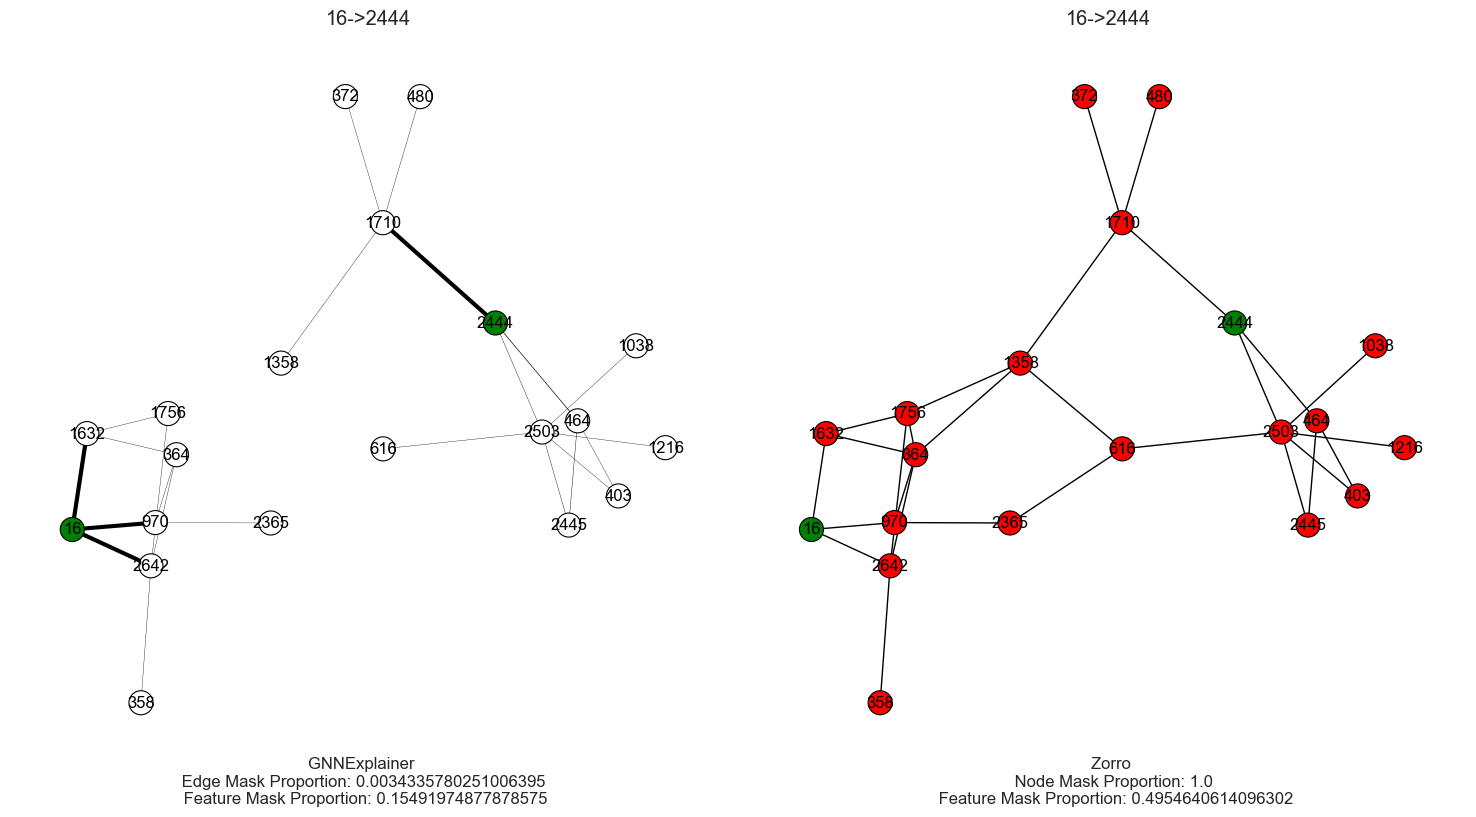

INFO:explainer:------ Start explaining edge tensor([[1224],
        [1526]])


Generating explanations for No.76 edge in the test data.
Source node 1224, Target Node: 1526
target:  1.0
pred:  0.9935012459754944
num_hops:  2



  0%|                                                                         | 0/123238 [00:00<?, ?it/s]
Explain edge tensor([[1224],
        [1526]]):   0%|                          | 0/123238 [00:00<?, ?it/s]

initial_distortion:  0.41
num_hops:  2


INFO:explainer:------ Start explaining edge tensor([[1224],
        [1526]])


INFO:explainer:------ Current fidelity 1.0
INFO:explainer:------ Finished explaining edge tensor([[1224],
        [1526]])


node_masks:  tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
best_node:  45
impove_in_distortion_by_node:  0.18
best_feature:  341
impove_in_distortion_by_feature:  0.16999999999999998



Explain edge tensor([[1224],
        [1526]]):   0%|               | 1/123238 [00:02<81:07:48,  2.37s/it]

count:  1
0.41
[45, nan, 0.41]
num_to_add_once:  10


Argmax [341, 814, 25, 261, 493, 1247, 1263, 495, 967, 1075], 0.35000000000000003:   3%| | 1/30 [00:00<00:

distortion_improve:  0.35000000000000003


Argmax [341, 814, 25, 261, 493, 1247, 1263, 495, 967, 1075], 0.35000000000000003:   7%| | 2/30 [00:00<00:

distortion_improve:  0.07


Argmax [341, 814, 25, 261, 493, 1247, 1263, 495, 967, 1075], 0.35000000000000003:  10%| | 3/30 [00:00<00:

distortion_improve:  0.020000000000000018
best_node:  None
impove_in_distortion_by_node:  -100
best_feature:  [341, 814, 25, 261, 493, 1247, 1263, 495, 967, 1075]
impove_in_distortion_by_feature:  0.35000000000000003




Explain edge tensor([[1224],
        [1526]]):   0%|               | 2/123238 [00:03<46:07:55,  1.35s/it]

count:  2
0.76
[nan, [341, 814, 25, 261, 493, 1247, 1263, 495, 967, 1075], 0.76]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [64, 2], 0.05999999999999994:  10%|███▏                            | 1/10 [00:00<00:01,  7.92it/s]

distortion_improve:  0.05999999999999994


Argmax [64, 2], 0.05999999999999994:  20%|██████▍                         | 2/10 [00:00<00:01,  7.76it/s]

distortion_improve:  0.020000000000000018


Argmax [64, 2], 0.05999999999999994:  30%|█████████▌                      | 3/10 [00:00<00:00,  7.86it/s]

distortion_improve:  0.0


Argmax [64, 2], 0.05999999999999994:  40%|████████████▊                   | 4/10 [00:00<00:00,  7.81it/s]

distortion_improve:  0.030000000000000027


Argmax [64, 2], 0.05999999999999994:  50%|████████████████                | 5/10 [00:00<00:00,  7.87it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], 0.030000000000000027:   3%| | 1/30 [00:00<

distortion_improve:  0.030000000000000027


Argmax [675, 756, 1144, 1199, 1208, 1224, 1237, 1261, 26, 99], 0.07999999999999996:   7%| | 2/30 [00:00<0

distortion_improve:  0.07999999999999996


Argmax [675, 756, 1144, 1199, 1208, 1224, 1237, 1261, 26, 99], 0.07999999999999996:  10%| | 3/30 [00:00<0

distortion_improve:  0.030000000000000027
best_node:  [64, 2]
impove_in_distortion_by_node:  0.05999999999999994
best_feature:  [675, 756, 1144, 1199, 1208, 1224, 1237, 1261, 26, 99]
impove_in_distortion_by_feature:  0.07999999999999996




Explain edge tensor([[1224],
        [1526]]):   0%|               | 3/123238 [00:04<45:11:53,  1.32s/it]

count:  3
0.84
[nan, [675, 756, 1144, 1199, 1208, 1224, 1237, 1261, 26, 99], 0.84]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [64, 2], 0.07000000000000006:  10%|███▏                            | 1/10 [00:00<00:01,  7.38it/s]

distortion_improve:  0.07000000000000006


Argmax [64, 2], 0.07000000000000006:  20%|██████▍                         | 2/10 [00:00<00:01,  7.47it/s]

distortion_improve:  0.040000000000000036


Argmax [64, 2], 0.07000000000000006:  30%|█████████▌                      | 3/10 [00:00<00:00,  7.52it/s]

distortion_improve:  -0.010000000000000009


Argmax [64, 2], 0.07000000000000006:  40%|████████████▊                   | 4/10 [00:00<00:00,  7.59it/s]

distortion_improve:  0.07000000000000006


Argmax [64, 2], 0.07000000000000006:  50%|████████████████                | 5/10 [00:00<00:00,  7.51it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], 0.0:   3%| | 1/30 [00:00<00:03,  7.59it/s]

distortion_improve:  0.0


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], 0.0:   7%| | 2/30 [00:00<00:03,  7.59it/s]

distortion_improve:  -0.020000000000000018


Argmax [646, 685, 707, 723, 725, 735, 774, 812, 813, 893], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  [64, 2]
impove_in_distortion_by_node:  0.07000000000000006
best_feature:  [646, 685, 707, 723, 725, 735, 774, 812, 813, 893]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|               | 4/123238 [00:05<45:22:54,  1.33s/it]

count:  4
0.91
[[64, 2], nan, 0.91]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [38, 70], 0.029999999999999916:  10%|███                           | 1/10 [00:00<00:01,  7.61it/s]

distortion_improve:  0.029999999999999916


Argmax [38, 70], 0.029999999999999916:  20%|██████                        | 2/10 [00:00<00:01,  7.64it/s]

distortion_improve:  -0.010000000000000009


Argmax [4, 22], 0.039999999999999925:  30%|█████████▎                     | 3/10 [00:00<00:00,  7.52it/s]

distortion_improve:  0.039999999999999925


Argmax [4, 22], 0.039999999999999925:  40%|████████████▍                  | 4/10 [00:00<00:00,  7.53it/s]

distortion_improve:  0.010000000000000009


Argmax [4, 22], 0.039999999999999925:  50%|███████████████▌               | 5/10 [00:00<00:00,  7.53it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.050000000000000044:   3%| | 1/30 [00:00

distortion_improve:  -0.050000000000000044


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], 0.010000000000000009:   7%| | 2/30 [00:00<00:0

distortion_improve:  0.010000000000000009


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.0
best_node:  [4, 22]
impove_in_distortion_by_node:  0.039999999999999925
best_feature:  [132, 168, 252, 260, 284, 324, 345, 360, 513, 619]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|               | 5/123238 [00:06<45:21:43,  1.33s/it]

count:  5
0.95
[[4, 22], nan, 0.95]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [38, 70], 0.010000000000000009:  10%|███                           | 1/10 [00:00<00:01,  7.69it/s]

distortion_improve:  0.010000000000000009


Argmax [38, 70], 0.010000000000000009:  20%|██████                        | 2/10 [00:00<00:01,  7.54it/s]

distortion_improve:  0.0


Argmax [38, 70], 0.010000000000000009:  30%|█████████                     | 3/10 [00:00<00:00,  7.56it/s]

distortion_improve:  0.0


Argmax [38, 70], 0.010000000000000009:  40%|████████████                  | 4/10 [00:00<00:00,  7.51it/s]

distortion_improve:  0.0


Argmax [38, 70], 0.010000000000000009:  50%|███████████████               | 5/10 [00:00<00:00,  7.57it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.07999999999999996:   3%| | 1/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [646, 685, 707, 723, 725, 735, 774, 812, 813, 893], 0.010000000000000009:  10%| | 3/30 [00:00<00:0

distortion_improve:  0.010000000000000009
best_node:  [38, 70]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [646, 685, 707, 723, 725, 735, 774, 812, 813, 893]
impove_in_distortion_by_feature:  0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|               | 6/123238 [00:08<45:22:31,  1.33s/it]

count:  6
0.96
[nan, [646, 685, 707, 723, 725, 735, 774, 812, 813, 893], 0.96]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [38, 70], 0.0:  10%|████▋                                          | 1/10 [00:00<00:01,  7.43it/s]

distortion_improve:  0.0


Argmax [38, 70], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:01,  7.37it/s]

distortion_improve:  0.0


Argmax [38, 70], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.25it/s]

distortion_improve:  -0.010000000000000009


Argmax [38, 70], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.43it/s]

distortion_improve:  0.0


Argmax [38, 70], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.44it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.020000000000000018:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.029999999999999916
best_node:  [38, 70]
impove_in_distortion_by_node:  0.0
best_feature:  [132, 168, 252, 260, 284, 324, 345, 360, 513, 619]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|               | 7/123238 [00:09<45:27:15,  1.33s/it]

count:  7
0.96
[[38, 70], nan, 0.96]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [57, 3], 0.010000000000000009:  10%|███                            | 1/10 [00:00<00:01,  7.88it/s]

distortion_improve:  0.010000000000000009


Argmax [57, 3], 0.010000000000000009:  20%|██████▏                        | 2/10 [00:00<00:00,  8.01it/s]

distortion_improve:  0.0


Argmax [57, 3], 0.010000000000000009:  30%|█████████▎                     | 3/10 [00:00<00:00,  8.05it/s]

distortion_improve:  0.0


Argmax [57, 3], 0.010000000000000009:  40%|████████████▍                  | 4/10 [00:00<00:00,  8.09it/s]

distortion_improve:  0.0


Argmax [57, 3], 0.010000000000000009:  50%|███████████████▌               | 5/10 [00:00<00:00,  7.98it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], 0.0:  10%| | 3/30 [00:00<00:03,  7.85

distortion_improve:  0.0
best_node:  [57, 3]
impove_in_distortion_by_node:  0.010000000000000009
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1224],
        [1526]]):   0%|               | 8/123238 [00:10<44:47:56,  1.31s/it]

count:  8
0.97
[[57, 3], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [35, 54], 0.0:  10%|████▋                                          | 1/10 [00:00<00:01,  8.15it/s]

distortion_improve:  0.0


Argmax [35, 54], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:01,  7.89it/s]

distortion_improve:  0.0


Argmax [35, 54], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.79it/s]

distortion_improve:  0.0


Argmax [35, 54], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.81it/s]

distortion_improve:  0.0


Argmax [35, 54], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.82it/s]


distortion_improve:  -0.06999999999999995
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.05999999999999994:   3%| | 1/30 [00:00<

distortion_improve:  -0.05999999999999994


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.010000000000000009
best_node:  [35, 54]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|               | 9/123238 [00:12<44:32:14,  1.30s/it]

count:  9
0.97
[[35, 54], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [55, 61], 0.0:  10%|████▋                                          | 1/10 [00:00<00:01,  7.43it/s]

distortion_improve:  0.0


Argmax [55, 61], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:01,  7.04it/s]

distortion_improve:  0.0


Argmax [55, 61], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:01,  6.29it/s]

distortion_improve:  0.0


Argmax [55, 61], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  6.53it/s]

distortion_improve:  -0.06999999999999995


Argmax [55, 61], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  6.72it/s]


distortion_improve:  -0.030000000000000027
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.05999999999999994:   3%| | 1/30 [00:00<

distortion_improve:  -0.05999999999999994


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.010000000000000009
best_node:  [55, 61]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|              | 10/123238 [00:13<45:26:40,  1.33s/it]

count:  10
0.97
[[55, 61], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [76, 7], 0.0:  10%|████▊                                           | 1/10 [00:00<00:01,  8.07it/s]

distortion_improve:  0.0


Argmax [76, 7], 0.0:  20%|█████████▌                                      | 2/10 [00:00<00:01,  7.86it/s]

distortion_improve:  0.0


Argmax [76, 7], 0.0:  30%|██████████████▍                                 | 3/10 [00:00<00:00,  7.67it/s]

distortion_improve:  -0.04999999999999993


Argmax [76, 7], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00,  7.64it/s]

distortion_improve:  -0.020000000000000018


Argmax [76, 7], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00,  7.67it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.020000000000000018:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.010000000000000009
best_node:  [76, 7]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|              | 11/123238 [00:14<45:15:42,  1.32s/it]

count:  11
0.97
[[76, 7], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [20, 27], 0.0:  10%|████▋                                          | 1/10 [00:00<00:01,  7.47it/s]

distortion_improve:  0.0


Argmax [20, 27], 0.0:  20%|█████████▍                                     | 2/10 [00:00<00:01,  7.52it/s]

distortion_improve:  -0.039999999999999925


Argmax [20, 27], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.54it/s]

distortion_improve:  -0.020000000000000018


Argmax [20, 27], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.56it/s]

distortion_improve:  0.0


Argmax [20, 27], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.54it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.020000000000000018
best_node:  [20, 27]
impove_in_distortion_by_node:  0.0
best_feature:  [132, 168, 252, 260, 284, 324, 345, 360, 513, 619]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|              | 12/123238 [00:16<45:31:41,  1.33s/it]

count:  12
0.97
[[20, 27], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.030000000000000027:  10%|██▉                          | 1/10 [00:00<00:01,  6.52it/s]

distortion_improve:  -0.030000000000000027


Argmax [48, 52], -0.020000000000000018:  20%|█████▊                       | 2/10 [00:00<00:01,  7.03it/s]

distortion_improve:  -0.020000000000000018


Argmax [53, 63], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:01,  6.92it/s]

distortion_improve:  0.0


Argmax [53, 63], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.08it/s]

distortion_improve:  0.0


Argmax [53, 63], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.07it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.010000000000000009:   7%| | 2/30 [00:00<00:

distortion_improve:  -0.010000000000000009


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], -0.010000000000000009:  10%| | 3/30 [00:00<00:

distortion_improve:  -0.010000000000000009
best_node:  [53, 63]
impove_in_distortion_by_node:  0.0
best_feature:  [132, 168, 252, 260, 284, 324, 345, 360, 513, 619]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|              | 13/123238 [00:17<46:08:31,  1.35s/it]

count:  13
0.97
[[53, 63], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.030000000000000027:  10%|██▉                          | 1/10 [00:00<00:01,  7.53it/s]

distortion_improve:  -0.030000000000000027


Argmax [48, 52], -0.020000000000000018:  20%|█████▊                       | 2/10 [00:00<00:01,  7.57it/s]

distortion_improve:  -0.020000000000000018


Argmax [67, 71], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.61it/s]

distortion_improve:  0.0


Argmax [67, 71], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.48it/s]

distortion_improve:  0.0


Argmax [67, 71], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.50it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], 0.0:   7%|▎    | 2/30 [00:00<00:03,  7.42it/s]

distortion_improve:  0.0


Argmax [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], 0.0:  10%|▌    | 3/30 [00:00<00:03,  7.61it/s]

distortion_improve:  -0.010000000000000009
best_node:  [67, 71]
impove_in_distortion_by_node:  0.0
best_feature:  [132, 168, 252, 260, 284, 324, 345, 360, 513, 619]
impove_in_distortion_by_feature:  0.0




Explain edge tensor([[1224],
        [1526]]):   0%|              | 14/123238 [00:18<45:46:50,  1.34s/it]

count:  14
0.97
[nan, [132, 168, 252, 260, 284, 324, 345, 360, 513, 619], 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.89it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:00,  8.09it/s]

distortion_improve:  -0.030000000000000027


Argmax [67, 71], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00,  7.92it/s]

distortion_improve:  -0.010000000000000009


Argmax [73, 77], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.89it/s]

distortion_improve:  0.0


Argmax [73, 77], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.86it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.07999999999999996:   3%| | 1/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.030000000000000027:   7%| | 2/30 [

distortion_improve:  -0.030000000000000027


Argmax [1262, 1330, 1383, 1386, 1389, 7, 33, 44, 61, 64], -0.020000000000000018:  10%| | 3/30 [00:00<00:0

distortion_improve:  -0.020000000000000018
best_node:  [73, 77]
impove_in_distortion_by_node:  0.0
best_feature:  [1262, 1330, 1383, 1386, 1389, 7, 33, 44, 61, 64]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 15/123238 [00:20<45:02:34,  1.32s/it]

count:  15
0.97
[[73, 77], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.08999999999999997:  10%|███                           | 1/10 [00:00<00:01,  8.19it/s]

distortion_improve:  -0.08999999999999997


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:00,  8.10it/s]

distortion_improve:  -0.030000000000000027


Argmax [67, 71], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.99it/s]

distortion_improve:  0.0


Argmax [67, 71], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.90it/s]

distortion_improve:  0.0


Argmax [67, 71], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.93it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.010000000000000009:   7%| | 2/30 [

distortion_improve:  -0.010000000000000009


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.010000000000000009:  10%| | 3/30 [

distortion_improve:  -0.010000000000000009
best_node:  [67, 71]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|              | 16/123238 [00:21<44:30:11,  1.30s/it]

count:  16
0.97
[[67, 71], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.10999999999999999:  10%|███                           | 1/10 [00:00<00:01,  7.59it/s]

distortion_improve:  -0.10999999999999999


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.55it/s]

distortion_improve:  -0.030000000000000027


Argmax [80, 5], -0.010000000000000009:  30%|█████████                     | 3/10 [00:00<00:00,  7.74it/s]

distortion_improve:  -0.010000000000000009


Argmax [6, 11], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00,  7.77it/s]

distortion_improve:  0.0


Argmax [6, 11], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00,  7.73it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.07999999999999996:   3%| | 1/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.030000000000000027:   7%| | 2/30 [

distortion_improve:  -0.030000000000000027


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.030000000000000027:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [6, 11]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.030000000000000027




Explain edge tensor([[1224],
        [1526]]):   0%|              | 17/123238 [00:22<44:24:45,  1.30s/it]

count:  17
0.97
[[6, 11], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.10999999999999999:  10%|███                           | 1/10 [00:00<00:01,  8.00it/s]

distortion_improve:  -0.10999999999999999


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:00,  8.02it/s]

distortion_improve:  -0.030000000000000027


Argmax [80, 5], 0.0:  30%|██████████████▍                                 | 3/10 [00:00<00:00,  7.60it/s]

distortion_improve:  0.0


Argmax [80, 5], 0.0:  40%|███████████████████▏                            | 4/10 [00:00<00:00,  7.66it/s]

distortion_improve:  -0.010000000000000009


Argmax [80, 5], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00,  7.79it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.07999999999999996:   3%| | 1/30 [00:00<

distortion_improve:  -0.07999999999999996


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [80, 5]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 18/123238 [00:24<44:27:01,  1.30s/it]

count:  18
0.97
[[80, 5], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.08999999999999997:  10%|███                           | 1/10 [00:00<00:01,  7.56it/s]

distortion_improve:  -0.08999999999999997


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.82it/s]

distortion_improve:  -0.030000000000000027


Argmax [12, 14], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00,  7.71it/s]

distortion_improve:  -0.010000000000000009


Argmax [12, 14], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.60it/s]

distortion_improve:  -0.010000000000000009


Argmax [12, 14], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00,  7.61it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.030000000000000027:   3%| | 1/30 [00:00

distortion_improve:  -0.030000000000000027


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [12, 14]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018
tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
[12, 14]
Removing nodes:  [12, 14]




Explain edge tensor([[1224],
        [1526]]):   0%|              | 19/123238 [00:25<43:23:40,  1.27s/it]

count:  19
0.97
None


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.08999999999999997:  10%|███                           | 1/10 [00:00<00:01,  7.41it/s]

distortion_improve:  -0.08999999999999997


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.55it/s]

distortion_improve:  -0.030000000000000027


Argmax [15, 17], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00,  7.51it/s]

distortion_improve:  -0.010000000000000009


Argmax [15, 17], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.57it/s]

distortion_improve:  -0.010000000000000009


Argmax [15, 17], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00,  7.53it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.030000000000000027:   3%| | 1/30 [00:00

distortion_improve:  -0.030000000000000027


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [15, 17]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018
tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
[15, 17]
Removing nodes:  [15, 17]




Explain edge tensor([[1224],
        [1526]]):   0%|              | 20/123238 [00:26<42:47:52,  1.25s/it]

count:  20
0.97
None


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.08999999999999997:  10%|███                           | 1/10 [00:00<00:01,  7.62it/s]

distortion_improve:  -0.08999999999999997


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.51it/s]

distortion_improve:  -0.030000000000000027


Argmax [18, 19], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00,  7.32it/s]

distortion_improve:  -0.010000000000000009


Argmax [18, 19], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.60it/s]

distortion_improve:  -0.020000000000000018


Argmax [25, 28], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.55it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.030000000000000027:   3%| | 1/30 [00:00

distortion_improve:  -0.030000000000000027


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [25, 28]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 21/123238 [00:27<43:32:48,  1.27s/it]

count:  21
0.97
[[25, 28], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.08999999999999997:  10%|███                           | 1/10 [00:00<00:01,  7.85it/s]

distortion_improve:  -0.08999999999999997


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.29it/s]

distortion_improve:  -0.030000000000000027


Argmax [18, 19], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.60it/s]

distortion_improve:  0.0


Argmax [18, 19], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.48it/s]

distortion_improve:  -0.020000000000000018


Argmax [18, 19], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.55it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.030000000000000027:   3%| | 1/30 [00:00

distortion_improve:  -0.030000000000000027


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [18, 19]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 22/123238 [00:29<44:02:15,  1.29s/it]

count:  22
0.97
[[18, 19], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.08999999999999997:  10%|███                           | 1/10 [00:00<00:01,  7.97it/s]

distortion_improve:  -0.08999999999999997


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:00,  8.19it/s]

distortion_improve:  -0.030000000000000027


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  8.11it/s]

distortion_improve:  -0.020000000000000018


Argmax [29, 30], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  8.11it/s]

distortion_improve:  0.0


Argmax [29, 30], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  8.07it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.04999999999999993:   3%| | 1/30 [00:00<

distortion_improve:  -0.04999999999999993


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [29, 30]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 23/123238 [00:30<43:41:52,  1.28s/it]

count:  23
0.97
[[29, 30], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.18it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.49it/s]

distortion_improve:  -0.030000000000000027


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  7.65it/s]

distortion_improve:  -0.020000000000000018


Argmax [31, 32], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.86it/s]

distortion_improve:  -0.010000000000000009


Argmax [33, 43], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.79it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.030000000000000027:   3%| | 1/30 [00:00

distortion_improve:  -0.030000000000000027


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [33, 43]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 24/123238 [00:31<43:41:01,  1.28s/it]

count:  24
0.97
[[33, 43], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.82it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.88it/s]

distortion_improve:  -0.030000000000000027


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  7.80it/s]

distortion_improve:  -0.020000000000000018


Argmax [31, 32], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.88it/s]

distortion_improve:  0.0


Argmax [31, 32], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.86it/s]


distortion_improve:  -0.020000000000000018
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.039999999999999925:   3%| | 1/30 [00:00

distortion_improve:  -0.039999999999999925


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [31, 32]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 25/123238 [00:32<43:47:12,  1.28s/it]

count:  25
0.97
[[31, 32], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.01it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.55it/s]

distortion_improve:  -0.030000000000000027


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  7.76it/s]

distortion_improve:  -0.020000000000000018


Argmax [21, 23], -0.020000000000000018:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.85it/s]

distortion_improve:  -0.030000000000000027


Argmax [49, 50], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00,  7.76it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.039999999999999925:   3%| | 1/30 [00:00

distortion_improve:  -0.039999999999999925


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [49, 50]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018
tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
[49, 50]
Removing nodes:  [49, 50]




Explain edge tensor([[1224],
        [1526]]):   0%|              | 26/123238 [00:34<42:35:37,  1.24s/it]

count:  26
0.97
None


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.45it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.46it/s]

distortion_improve:  -0.030000000000000027


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  7.58it/s]

distortion_improve:  -0.020000000000000018


Argmax [21, 23], -0.020000000000000018:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.71it/s]

distortion_improve:  -0.030000000000000027


Argmax [51, 59], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00,  7.59it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.039999999999999925:   3%| | 1/30 [00:00

distortion_improve:  -0.039999999999999925


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [51, 59]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018
tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
[51, 59]
Removing nodes:  [51, 59]




Explain edge tensor([[1224],
        [1526]]):   0%|              | 27/123238 [00:35<42:06:08,  1.23s/it]

count:  27
0.97
None


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.47it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.80it/s]

distortion_improve:  -0.030000000000000027


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  7.62it/s]

distortion_improve:  -0.020000000000000018


Argmax [21, 23], -0.020000000000000018:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.59it/s]

distortion_improve:  -0.030000000000000027


Argmax [65, 66], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.59it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.039999999999999925:   3%| | 1/30 [00:00

distortion_improve:  -0.039999999999999925


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:   7%| | 2/30 [

distortion_improve:  -0.020000000000000018


Argmax [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257], -0.020000000000000018:  10%| | 3/30 [

distortion_improve:  -0.039999999999999925
best_node:  [65, 66]
impove_in_distortion_by_node:  0.0
best_feature:  [903, 1005, 1071, 1118, 1149, 1166, 1172, 1174, 1209, 1257]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 28/123238 [00:36<43:11:08,  1.26s/it]

count:  28
0.97
[[65, 66], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.06999999999999995:  10%|███                           | 1/10 [00:00<00:01,  7.52it/s]

distortion_improve:  -0.06999999999999995


Argmax [48, 52], -0.030000000000000027:  20%|█████▊                       | 2/10 [00:00<00:01,  7.56it/s]

distortion_improve:  -0.030000000000000027


Argmax [21, 23], -0.010000000000000009:  30%|████████▋                    | 3/10 [00:00<00:00,  7.56it/s]

distortion_improve:  -0.010000000000000009


Argmax [46, 47], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.51it/s]

distortion_improve:  0.0


Argmax [46, 47], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.50it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:   3%| | 1/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:   7%| | 2/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:  10%| | 3/30 [00:00

distortion_improve:  -0.039999999999999925
best_node:  [46, 47]
impove_in_distortion_by_node:  0.0
best_feature:  [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 29/123238 [00:37<43:49:40,  1.28s/it]

count:  29
0.97
[[46, 47], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.79it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.039999999999999925:  20%|█████▊                       | 2/10 [00:00<00:01,  7.70it/s]

distortion_improve:  -0.039999999999999925


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  7.70it/s]

distortion_improve:  -0.020000000000000018


Argmax [74, 78], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00,  7.70it/s]

distortion_improve:  -0.010000000000000009


Argmax [74, 78], -0.010000000000000009:  50%|██████████████▌              | 5/10 [00:00<00:00,  7.75it/s]


distortion_improve:  -0.010000000000000009
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:   3%| | 1/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:   7%| | 2/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:  10%| | 3/30 [00:00

distortion_improve:  -0.039999999999999925
best_node:  [74, 78]
impove_in_distortion_by_node:  -0.010000000000000009
best_feature:  [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581]
impove_in_distortion_by_feature:  -0.020000000000000018
tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])
[74, 78]
Removing nodes:  [74, 78]




Explain edge tensor([[1224],
        [1526]]):   0%|              | 30/123238 [00:39<42:43:35,  1.25s/it]

count:  30
0.97
None


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.07999999999999996:  10%|███                           | 1/10 [00:00<00:01,  7.56it/s]

distortion_improve:  -0.07999999999999996


Argmax [48, 52], -0.039999999999999925:  20%|█████▊                       | 2/10 [00:00<00:01,  7.49it/s]

distortion_improve:  -0.039999999999999925


Argmax [21, 23], -0.020000000000000018:  30%|████████▋                    | 3/10 [00:00<00:00,  7.93it/s]

distortion_improve:  -0.020000000000000018


Argmax [79, 82], -0.010000000000000009:  40%|███████████▌                 | 4/10 [00:00<00:00,  6.63it/s]

distortion_improve:  -0.010000000000000009


Argmax [85, 0], 0.0:  50%|████████████████████████                        | 5/10 [00:00<00:00,  6.81it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:   3%| | 1/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:   7%| | 2/30 [00:00

distortion_improve:  -0.020000000000000018


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.020000000000000018:  10%| | 3/30 [00:00

distortion_improve:  -0.039999999999999925
best_node:  [85, 0]
impove_in_distortion_by_node:  0.0
best_feature:  [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581]
impove_in_distortion_by_feature:  -0.020000000000000018




Explain edge tensor([[1224],
        [1526]]):   0%|              | 31/123238 [00:40<44:02:48,  1.29s/it]

count:  31
0.97
[[85, 0], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.04999999999999993:  10%|███                           | 1/10 [00:00<00:01,  7.73it/s]

distortion_improve:  -0.04999999999999993


Argmax [48, 52], -0.020000000000000018:  20%|█████▊                       | 2/10 [00:00<00:01,  7.76it/s]

distortion_improve:  -0.020000000000000018


Argmax [21, 23], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.79it/s]

distortion_improve:  0.0


Argmax [21, 23], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  7.84it/s]

distortion_improve:  0.0


Argmax [21, 23], 0.0:  50%|███████████████████████▌                       | 5/10 [00:00<00:00,  7.82it/s]


distortion_improve:  0.0
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.010000000000000009:   3%| | 1/30 [00:00

distortion_improve:  -0.010000000000000009


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.010000000000000009:   7%| | 2/30 [00:00

distortion_improve:  -0.010000000000000009


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.010000000000000009:  10%| | 3/30 [00:00

distortion_improve:  -0.030000000000000027
best_node:  [21, 23]
impove_in_distortion_by_node:  0.0
best_feature:  [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
        [1526]]):   0%|              | 32/123238 [00:41<43:46:09,  1.28s/it]

count:  32
0.97
[[21, 23], nan, 0.97]


possible_nodes change:  tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.]])
num_to_add_once:  2


Argmax [34, 37], -0.04999999999999993:  10%|███                           | 1/10 [00:00<00:01,  8.09it/s]

distortion_improve:  -0.04999999999999993


Argmax [48, 52], -0.020000000000000018:  20%|█████▊                       | 2/10 [00:00<00:01,  7.87it/s]

distortion_improve:  -0.020000000000000018


Argmax [79, 82], 0.0:  30%|██████████████                                 | 3/10 [00:00<00:00,  7.87it/s]

distortion_improve:  0.0


Argmax [79, 82], 0.0:  40%|██████████████████▊                            | 4/10 [00:00<00:00,  8.00it/s]

distortion_improve:  0.0


Argmax [24, 39], 0.020000000000000018:  50%|███████████████               | 5/10 [00:00<00:00,  7.90it/s]


distortion_improve:  0.020000000000000018
num_to_add_once:  10


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.010000000000000009:   3%| | 1/30 [00:00

distortion_improve:  -0.010000000000000009


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.010000000000000009:   7%| | 2/30 [00:00

distortion_improve:  -0.010000000000000009


Argmax [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581], -0.010000000000000009:  10%| | 3/30 [00:00

distortion_improve:  -0.030000000000000027
best_node:  [24, 39]
impove_in_distortion_by_node:  0.020000000000000018
best_feature:  [1290, 1305, 1352, 1353, 140, 205, 331, 425, 507, 581]
impove_in_distortion_by_feature:  -0.010000000000000009




Explain edge tensor([[1224],
Explain edge tensor([[1224],         | 33/123238 [00:42<43:38:00,  1.27s/it]
        [1526]]):   0%|              | 33/123238 [00:42<44:35:04,  1.30s/it]
INFO:explainer:------ Finished explaining edge tensor([[1224],
        [1526]])


count:  33
0.99
[[24, 39], nan, 0.99]
[(array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 0., 1., 0., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), [[nan, nan, 0.41], [45, nan, 0.41], [nan, [341, 814, 25, 261, 493, 1247, 1263, 495, 967, 1075], 0.76], [nan, [675, 756, 1144, 1199, 1208, 1224, 1237, 1261, 26, 99], 0.84], [[64, 2], nan, 0.91], [[4, 22], nan, 0.95], [nan, [646, 685, 707, 723, 725, 735, 774, 812, 813, 893], 0.96], [[38, 70], nan, 0.96], [[57, 3], nan, 0.97], [[35, 54], nan, 0.97], [[55, 61], nan, 0.97], [[76, 7], nan, 0.97], [[20, 27], nan, 0.97], [[53, 63], nan, 0.97], [nan, [132, 168, 252, 260, 284, 324, 345, 360, 513, 619

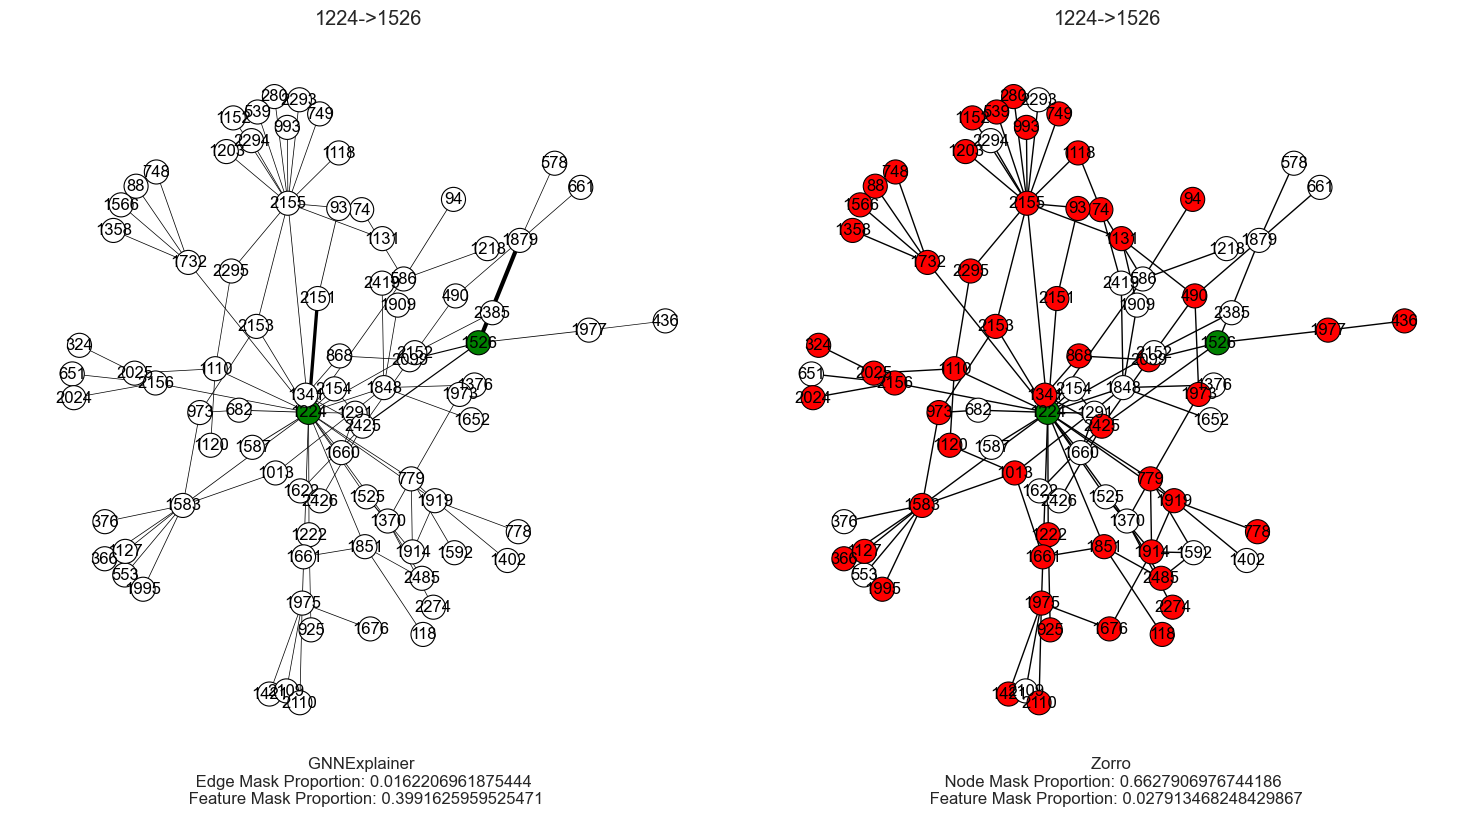

In [21]:
for _ in range(20):

    edge_id = random.randint(0, 99)
    exp_edge = selected_edge_pair_idx[edge_id]

    # exp_edge = np.random.randint(0, test_data.edge_label_index.shape[1])
    edge_label_index = test_data.edge_label_index[:, [exp_edge]]
    source_node, target_node = edge_label_index.numpy()[:, 0]
    target = test_data.edge_label[exp_edge].item()

    print(f'Generating explanations for No.{exp_edge} edge in the test data.')
    print(f'Source node {source_node}, Target Node: {target_node}')

    if sigmoid:
        pred = model(train_data.x, train_data.edge_index, edge_label_index).sigmoid().item()
    else:
        pred = model(train_data.x, train_data.edge_index, edge_label_index).item()

    print('target: ', target)
    print('pred: ', pred)

    if target == 1 and int(pred > 0.5) == target:

        num_hops = 0
        for module in model.modules():
            if isinstance(module, MessagePassing):
                if isinstance(module, APPNP):
                    num_hops += module.K
                else:
                    num_hops += 1

        computation_graph = get_computation_graph_as_nx(source_node, target_node, train_data)

        node_mask_zorro, feature_mask_zorro, edge_mask_zorro, node_mask_proportion_zorro, \
            feature_mask_proportion_zorro = extract_explanation('zorro')
        print('\n')
        _, feature_mask_gnnexplainer, edge_mask_gnnexplainer, edge_mask_proportion_gnnexplainer, \
            feature_mask_proportion_gnnexplainer = extract_explanation('gnnexplainer')

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(15, 8))

        visualize_explanation(computation_graph, train_data.edge_index, 
                                    edge_mask_gnnexplainer, source_node, target_node, ax=axs[0]) 
        visualize_explanation(computation_graph, train_data.edge_index, 
                                    edge_mask_zorro, source_node, target_node, node_mask=node_mask_zorro[0], ax=axs[1])

        # Add captions below each subplot
        fig.text(0.25, -0.02, f'GNNExplainer \n Edge Mask Proportion: {edge_mask_proportion_gnnexplainer} \n Feature Mask Proportion: {feature_mask_proportion_gnnexplainer}', ha='center', fontsize=12)
        fig.text(0.75, -0.02, f'Zorro \n Node Mask Proportion: {node_mask_proportion_zorro} \n Feature Mask Proportion: {feature_mask_proportion_zorro}', ha='center', fontsize=12)

        # Show the plots
        plt.show()
        fig.savefig(f"figs/gnnexplainer_zorro/{graph_model}_{model_name}_{decoder}_explanation_example_{edge_id}_{exp_edge}_{source_node}_{target_node}.png", bbox_inches='tight')

<AxesSubplot:title={'center':'1224->1526'}>

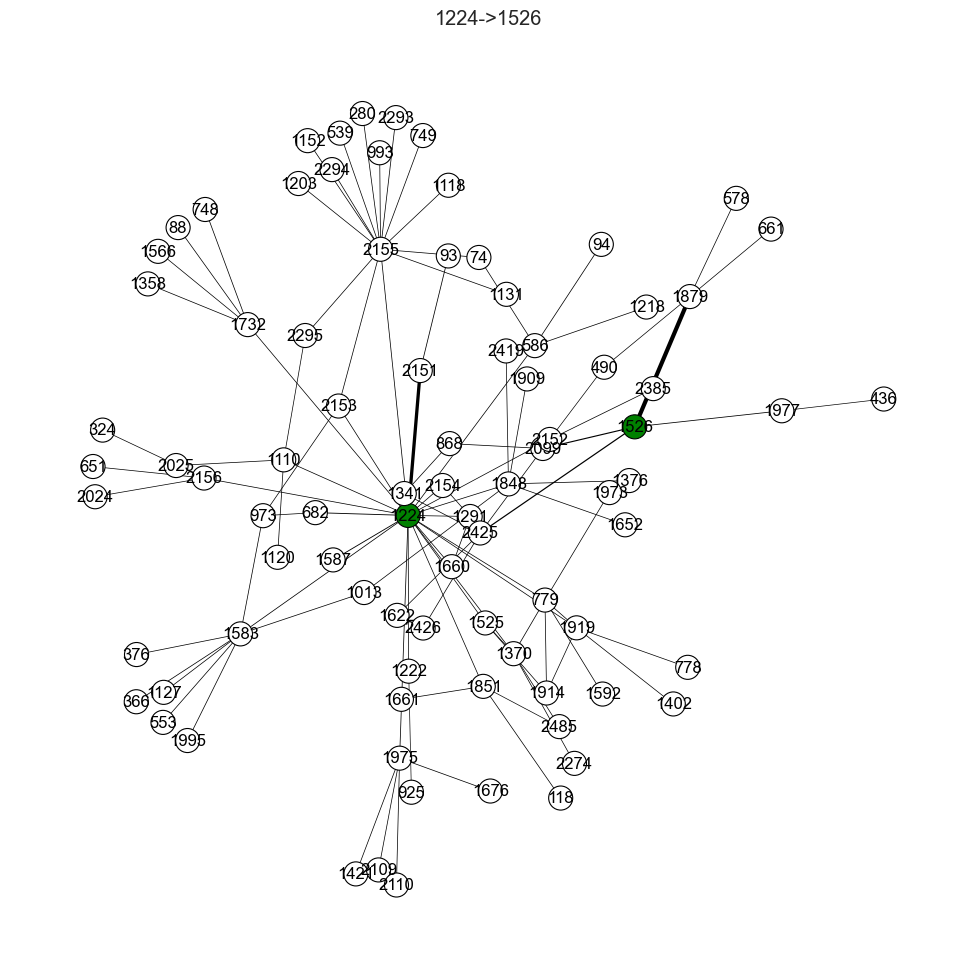

In [22]:
visualize_explanation(computation_graph, train_data.edge_index, 
                            edge_mask_gnnexplainer, source_node, target_node) 

In [11]:
# # Create subplots
# fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# # Visualize the first explanation on the first subplot
# visualize_explanation(computation_graph, train_data.edge_index, 
#                             edge_mask_gnnexplainer, source_node, target_node, ax=axs[0]) 
# # axs[0].set_title('GNNExplainer')
# # Visualize the second explanation on the second subplot
# visualize_explanation(computation_graph, train_data.edge_index, 
#                             edge_mask_zorro, source_node, target_node, node_mask=node_mask_zorro[0], ax=axs[1])
# # axs[1].set_title('Zorro')

# # Add captions below each subplot
# fig.text(0.25, 0.05, 'GNNExplainer', ha='center', fontsize=12)
# fig.text(0.75, 0.05, 'Zorro', ha='center', fontsize=12)

# # Show the plots
# plt.show()
# fig.savefig(f"figs/gnnexplainer_zorro/{graph_model}_{model_name}_{decoder}_explanation_example_{edge_id}_{exp_edge}_{source_node}_{target_node}.png")

In [12]:
# fig = visualize_explanation(computation_graph, train_data.edge_index, 
#                             edge_mask_gnnexplainer, source_node, target_node) 

# fig.set_size_inches(8, 6)

In [13]:
sorted(explanation.edge_mask, reverse=True)

NameError: name 'explanation' is not defined

In [ ]:
np.where(explanation.node_mask[0] != 0.)

In [ ]:
np.where(explanation.edge_mask >= 0.8)

In [ ]:
explanation.edge_index[:, [7558]]